## Comparing Optimization Methods on Mountain Car

In this notebook, I will look at a number of optimization methods and use these methods to train the weights of a neural network used to solve Open AI Gym's Cart Pole Environment. 

- Cross Entropy
- Hill Climbing with Adaptive Noise Scaling
- Simulated Annealing
- Evolutionary Algorithm 
- REINFORCE
- Comparison of methods

In [33]:
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display

import math
import numpy as np
from collections import deque

import gym

In [85]:
env = gym.make('MountainCarContinuous-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [76]:
# Run a demo of the environment
observation = env.reset()
cum_reward = 0
frames = []
for t in range(1000):
    # Render into buffer. 
    # You will still see the window.
    frames.append(env.render(mode = 'rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        break
        
env.render()
env.close()

In [77]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))


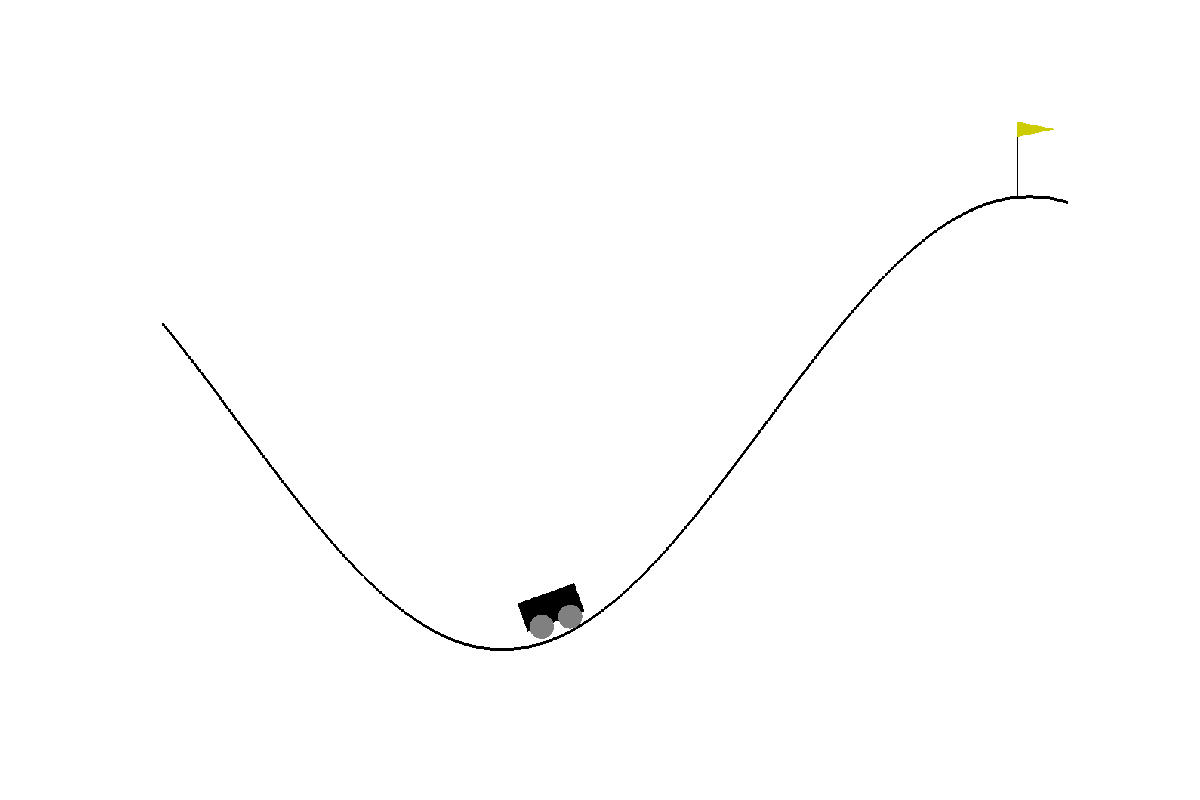
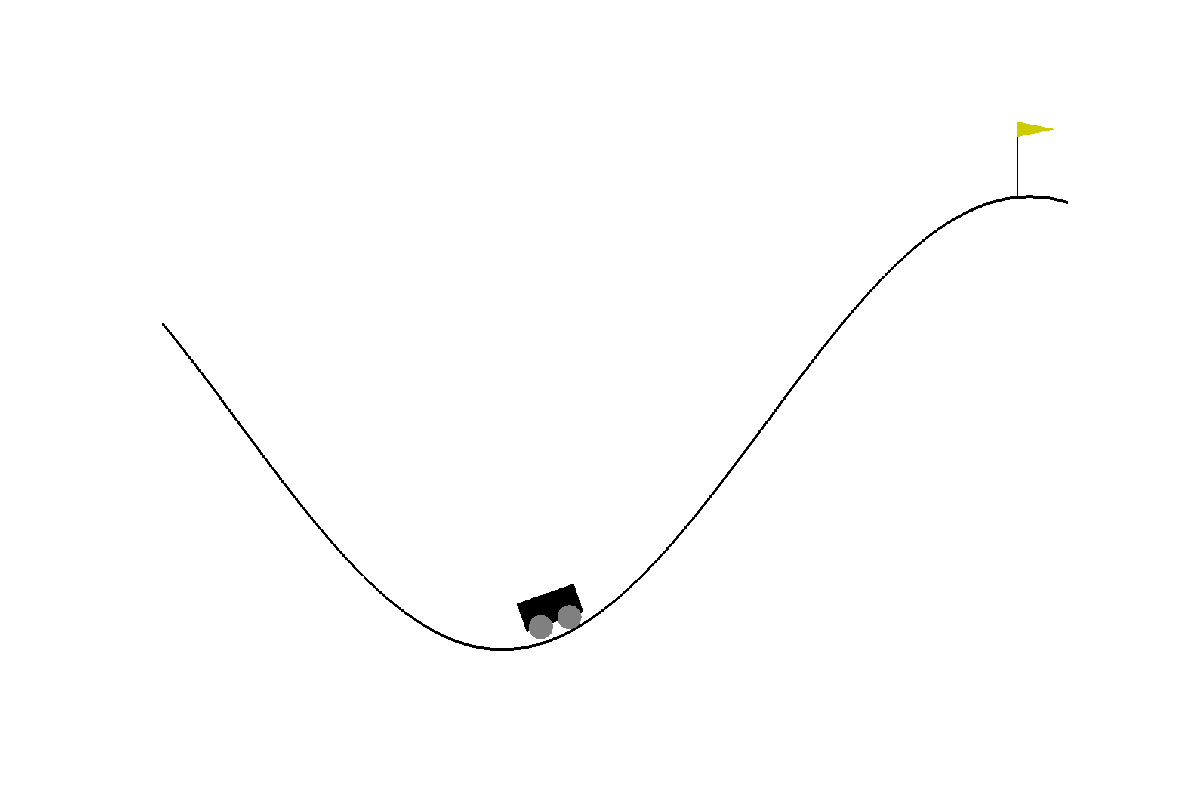
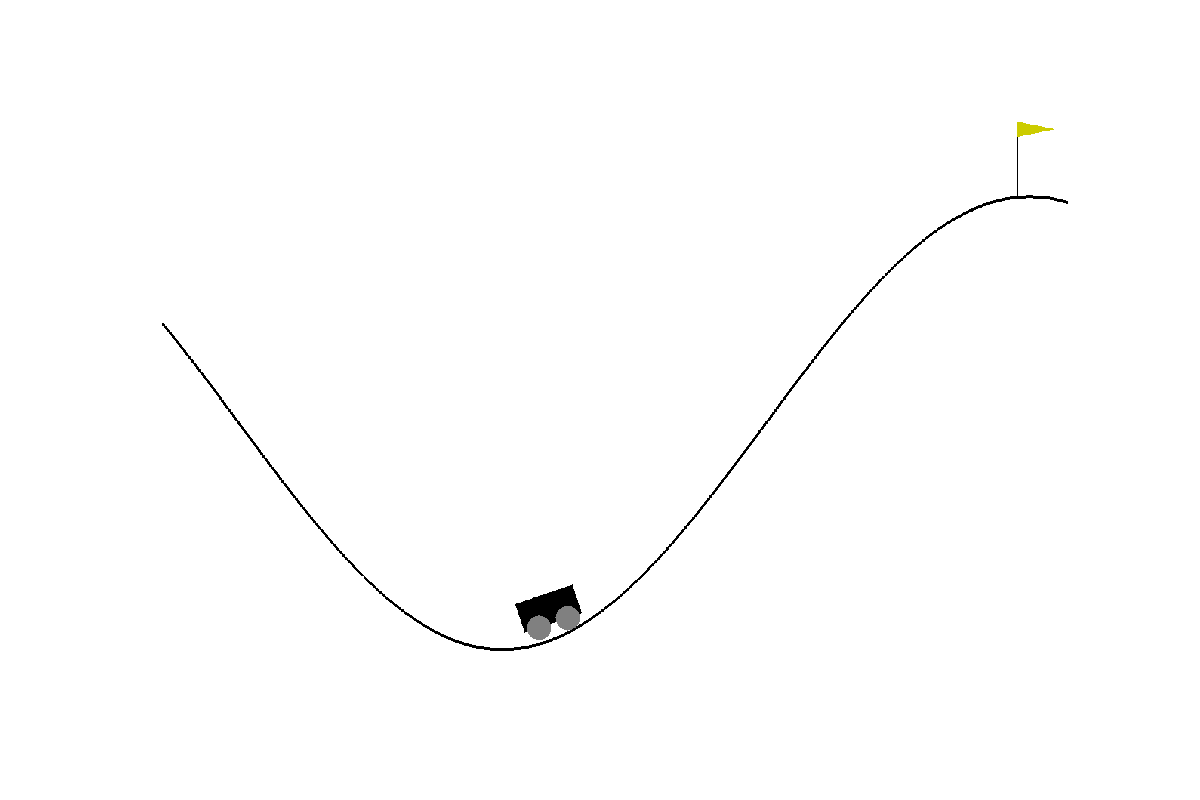
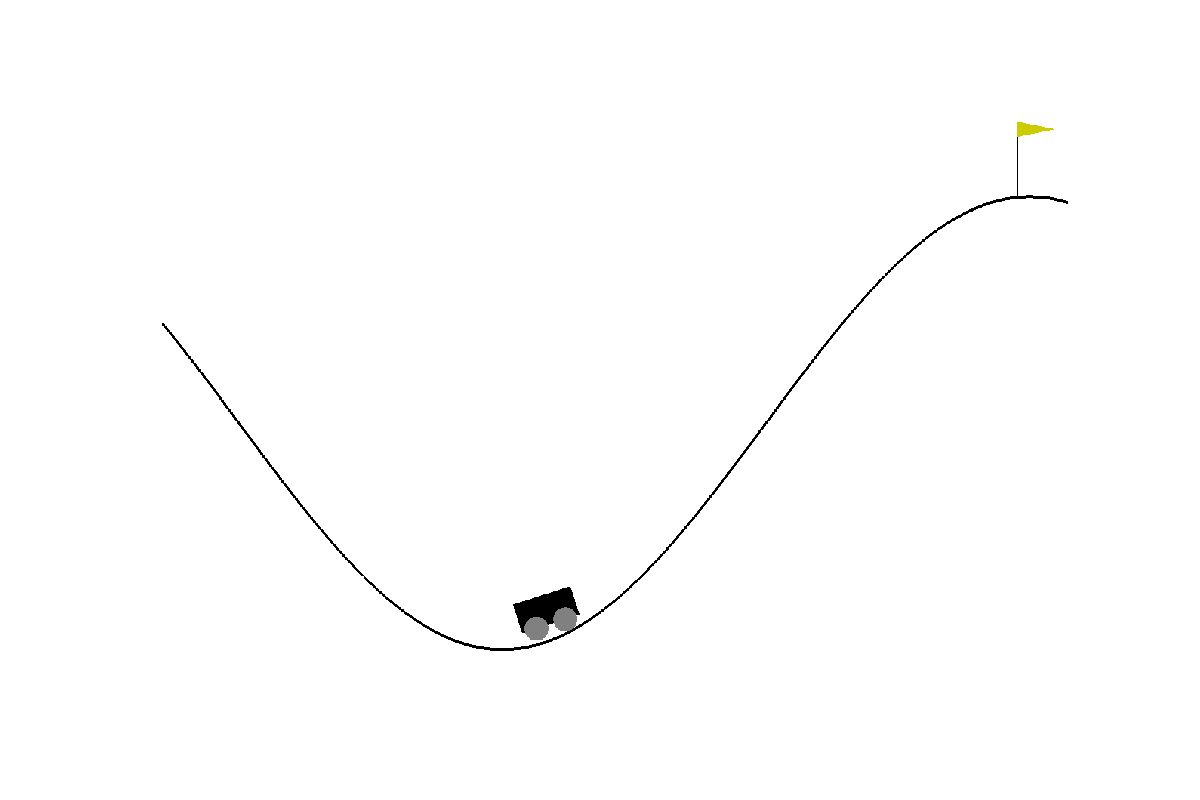
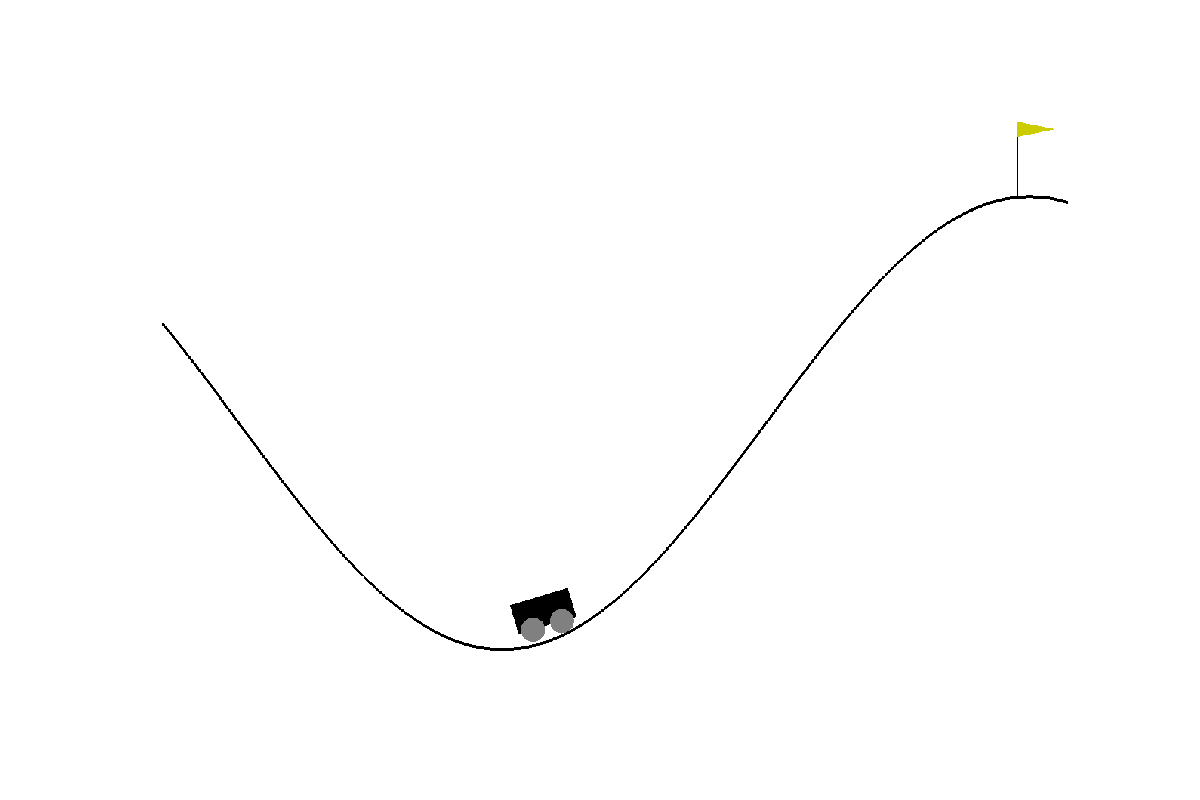
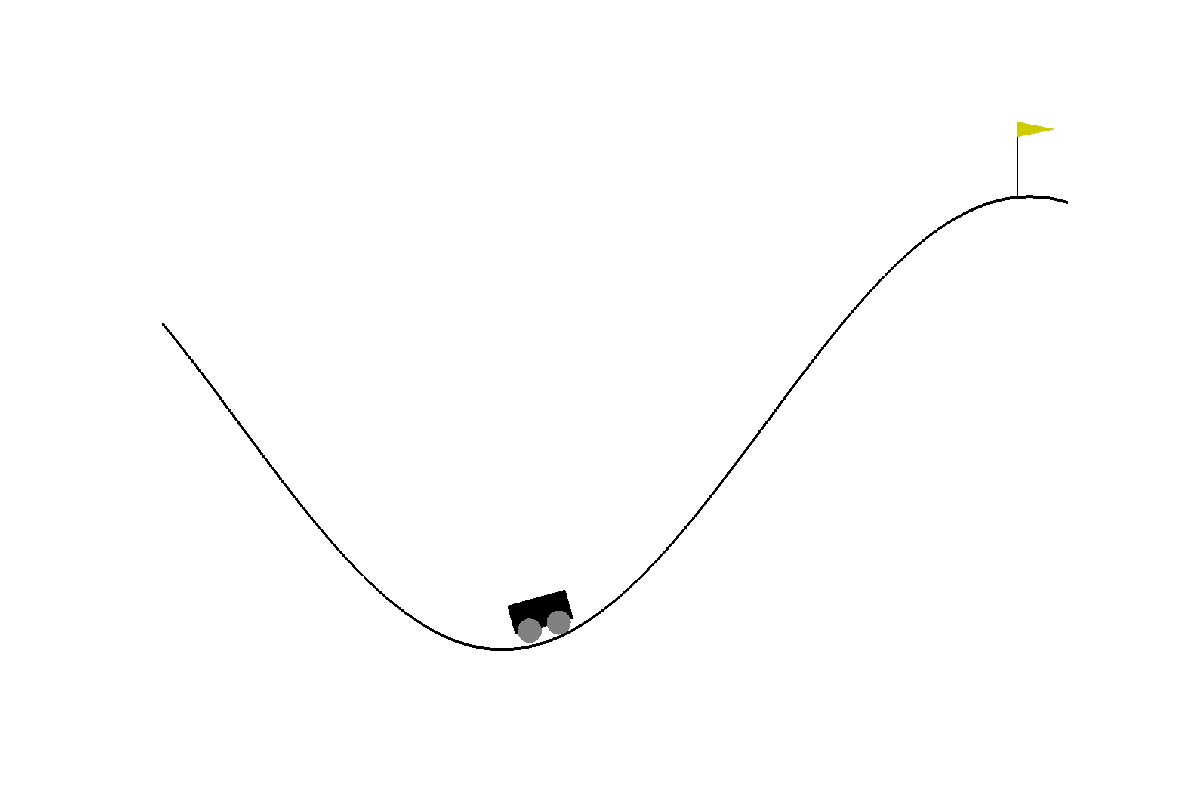
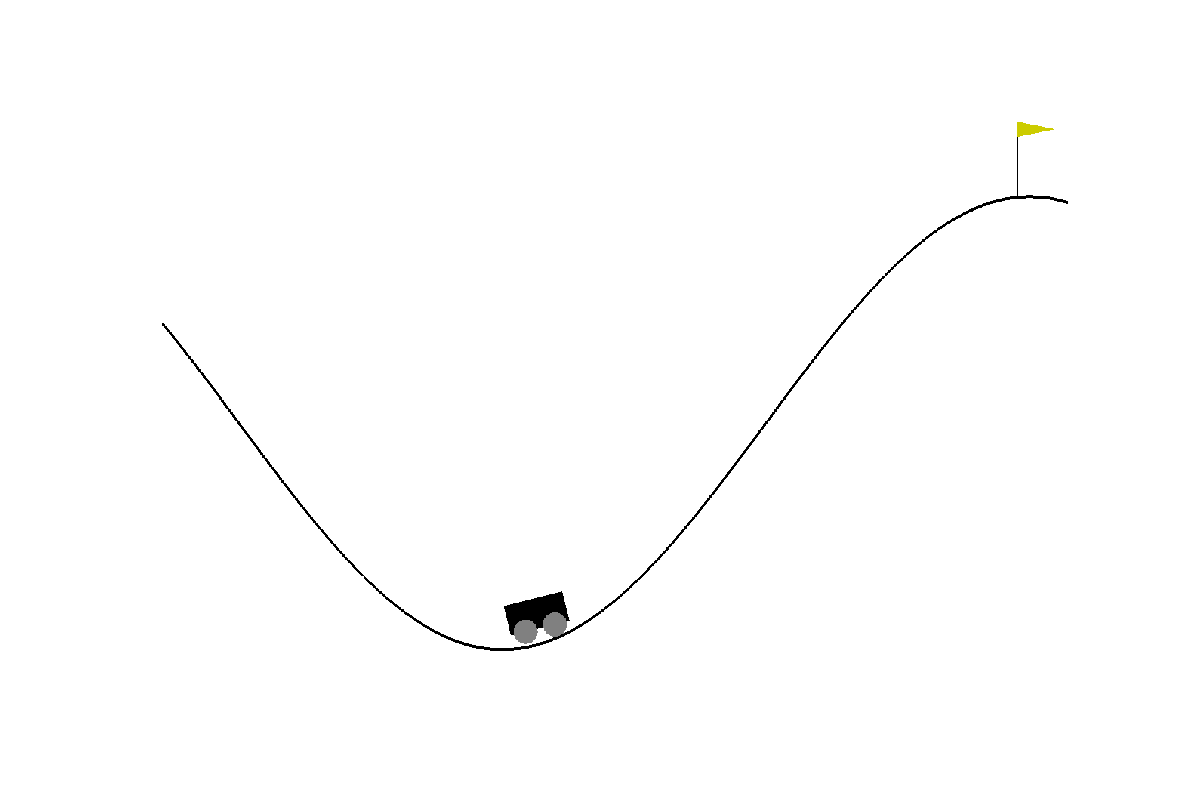
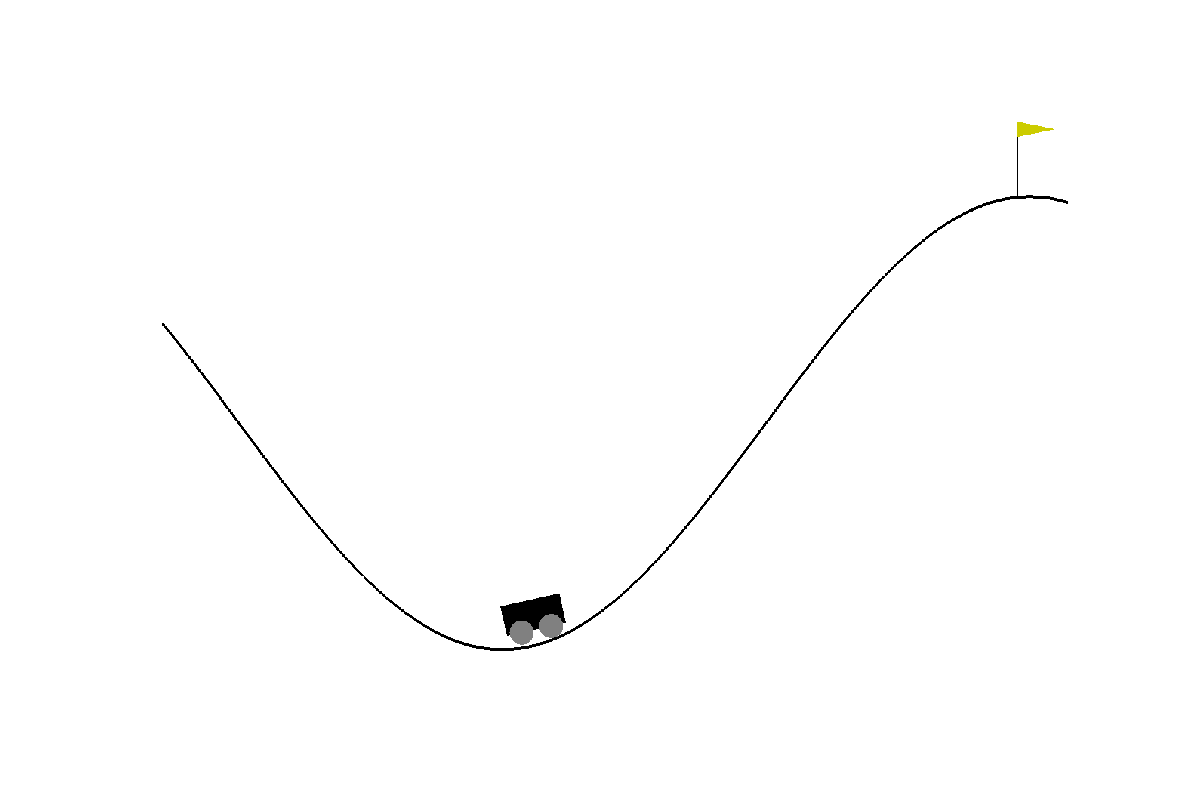
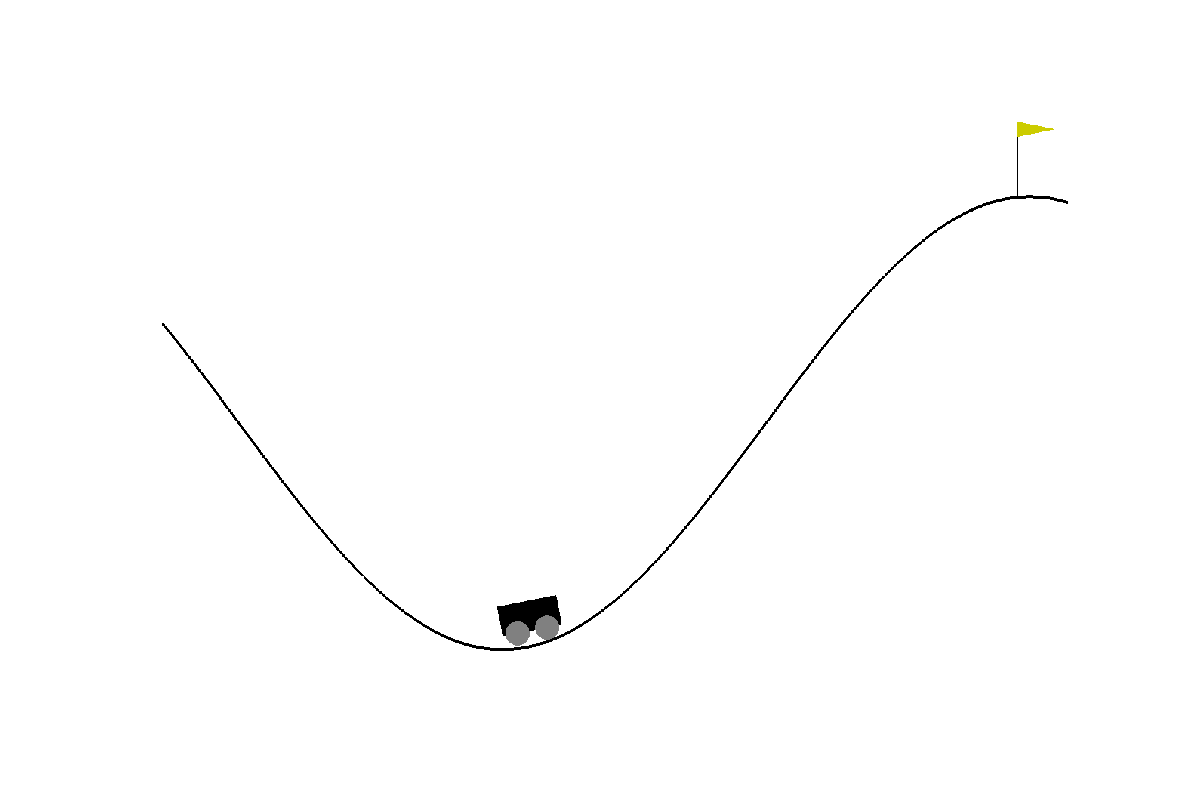
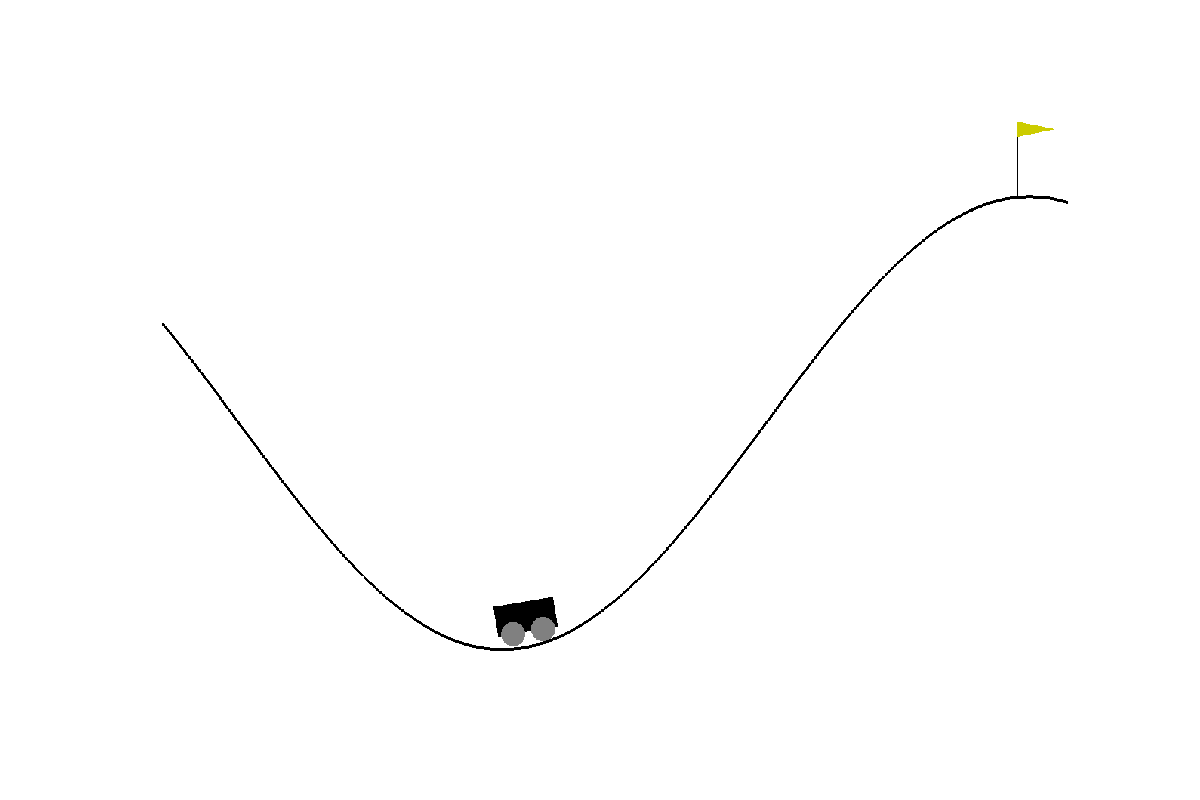
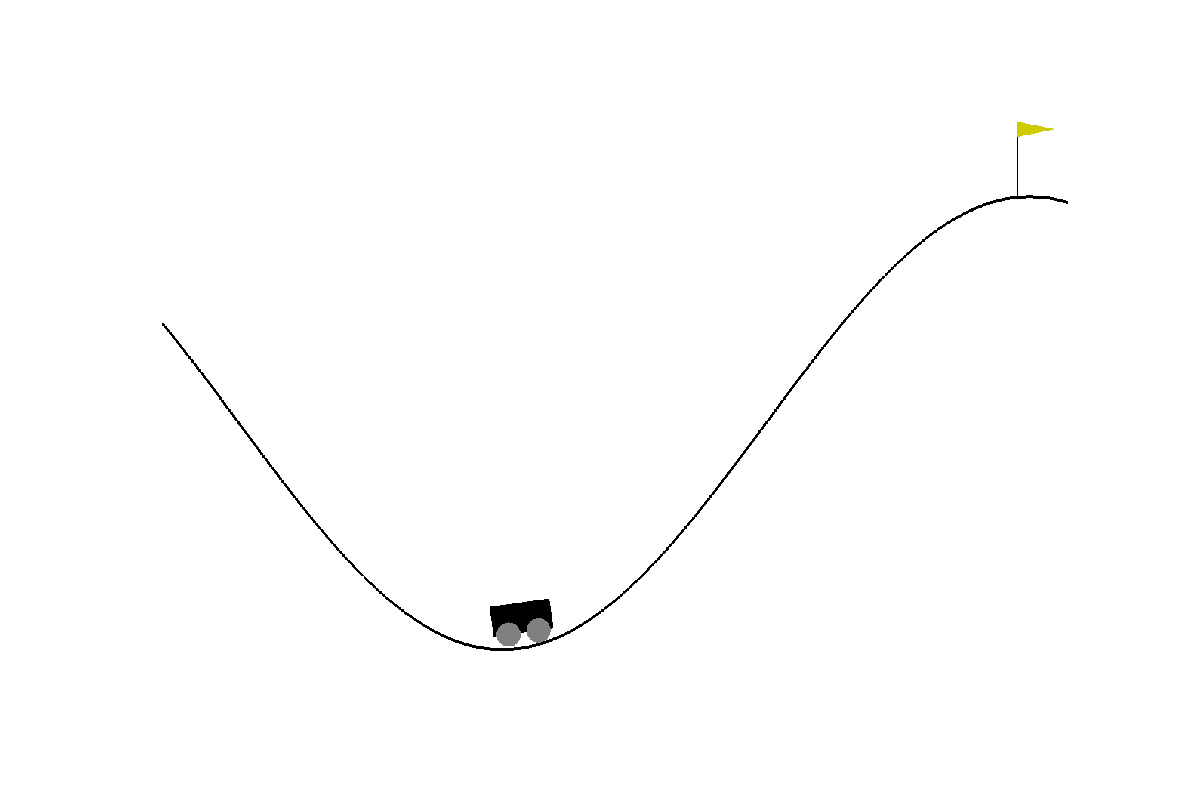
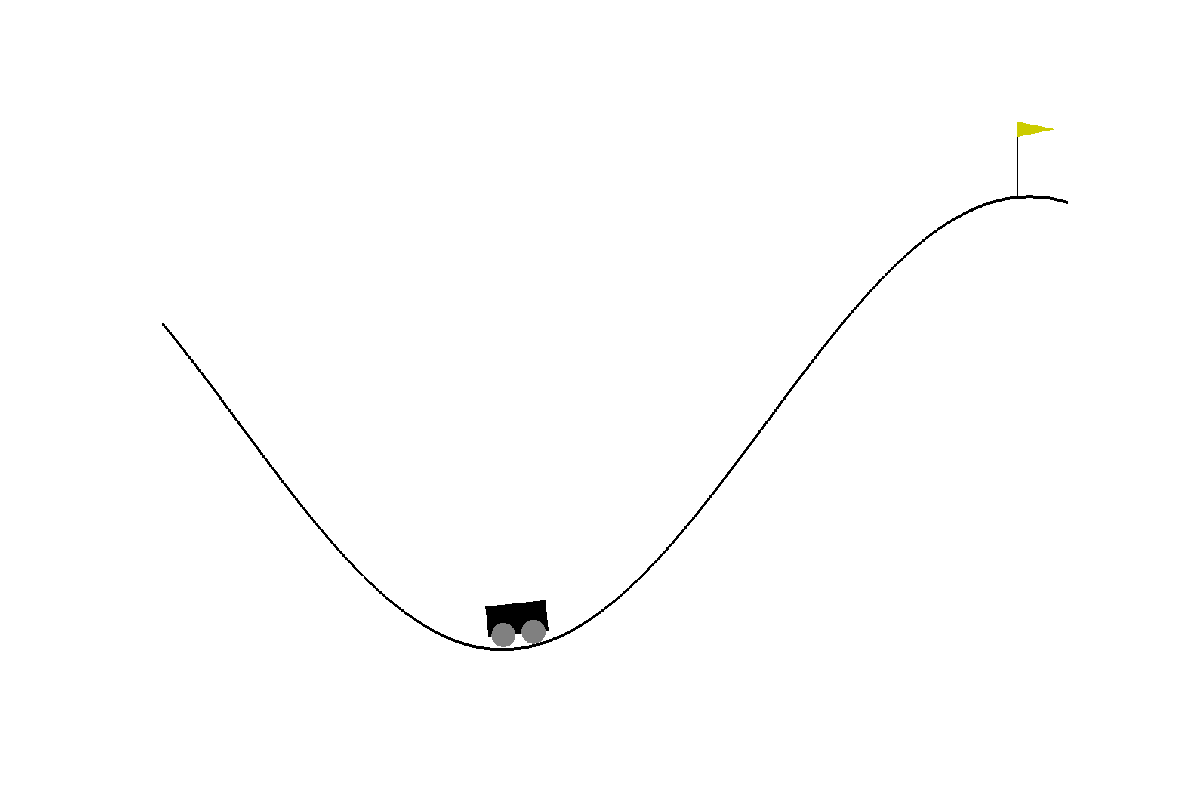
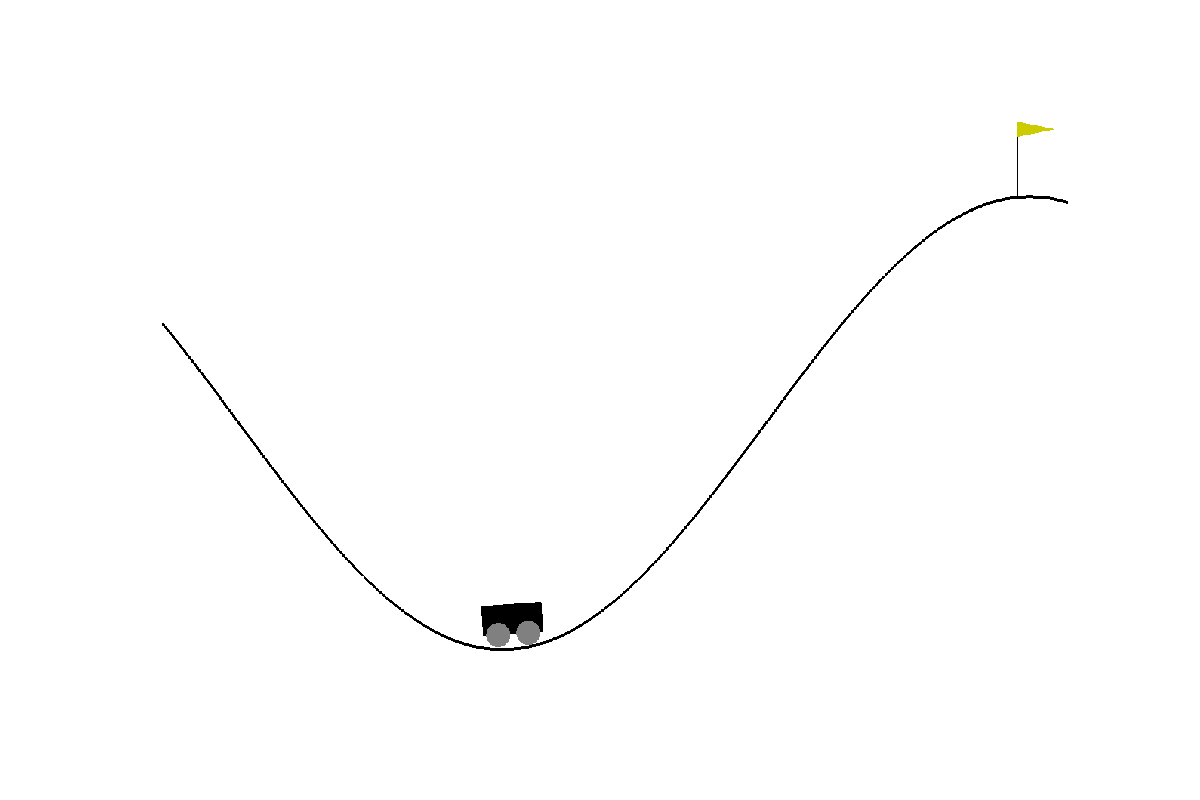
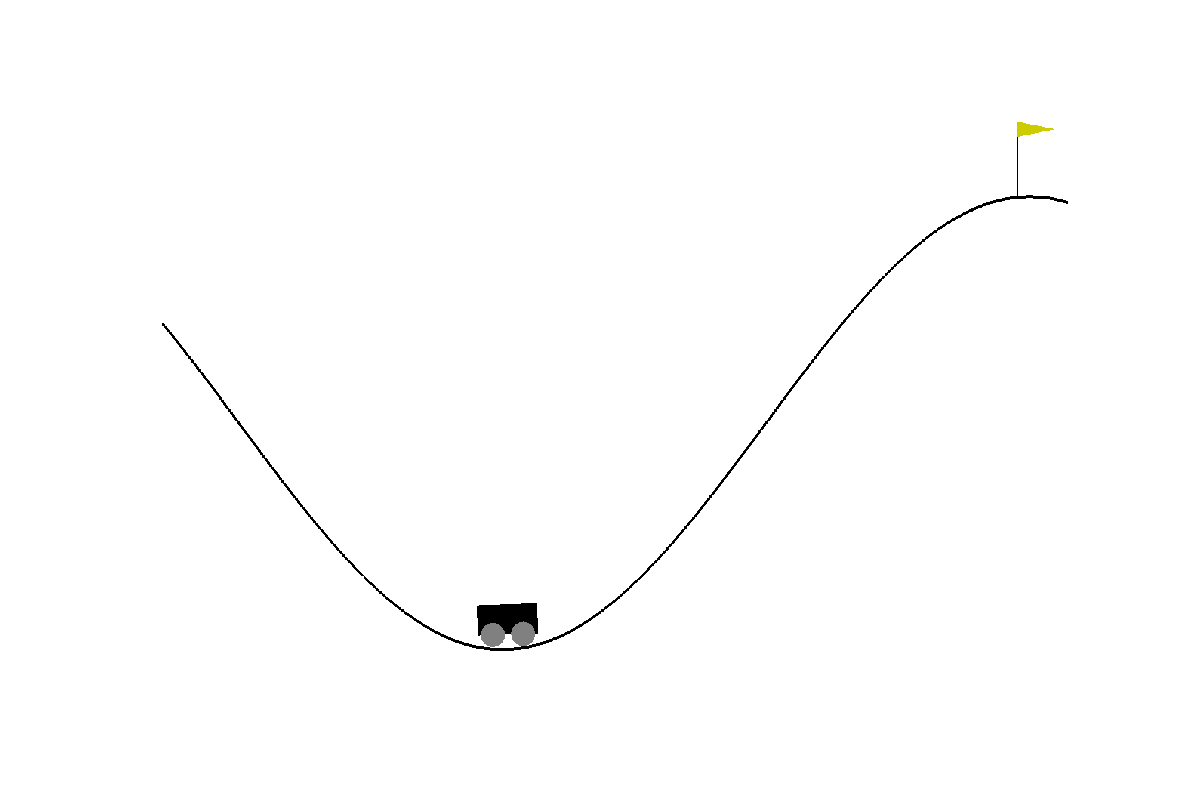
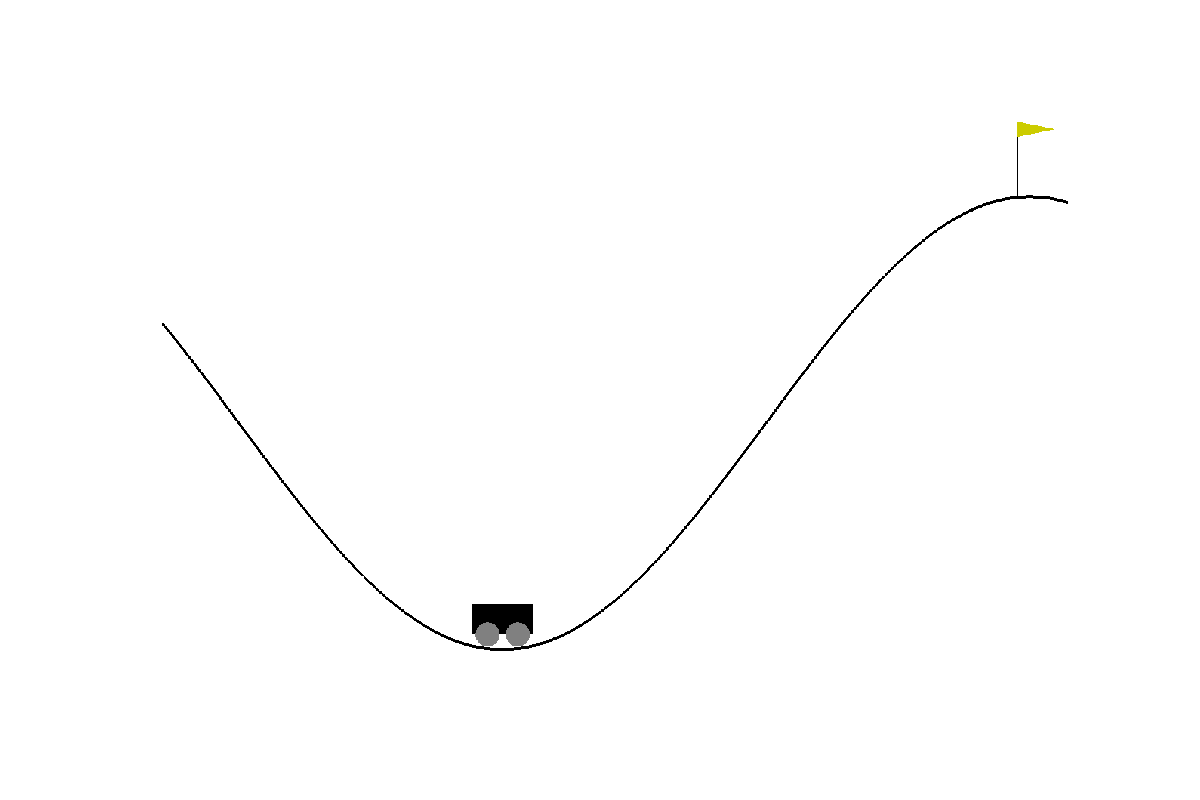
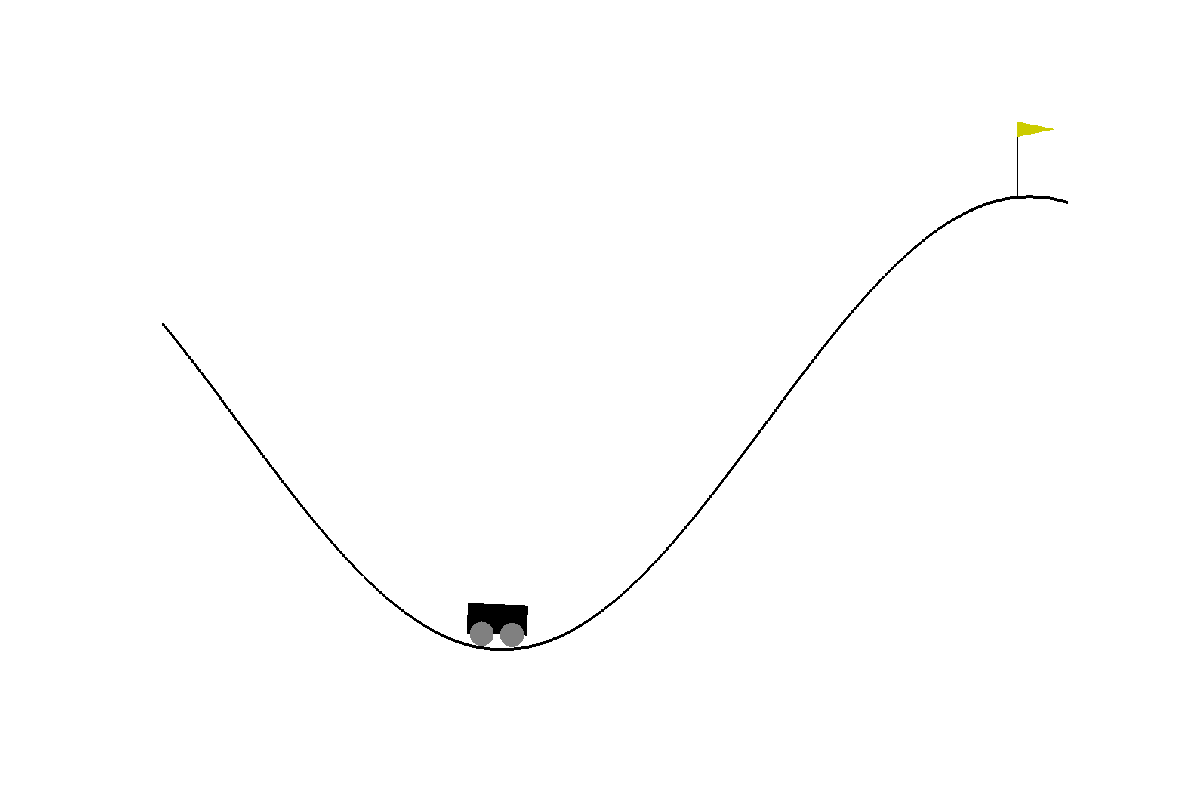
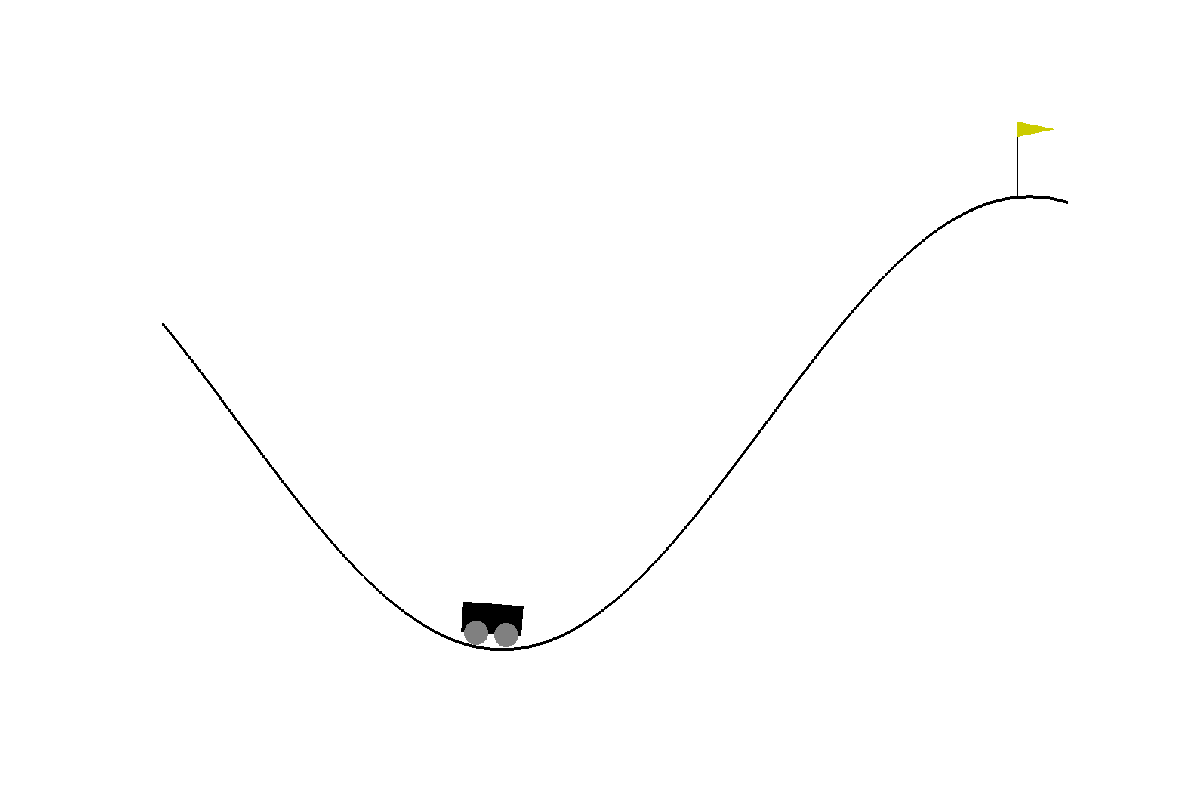
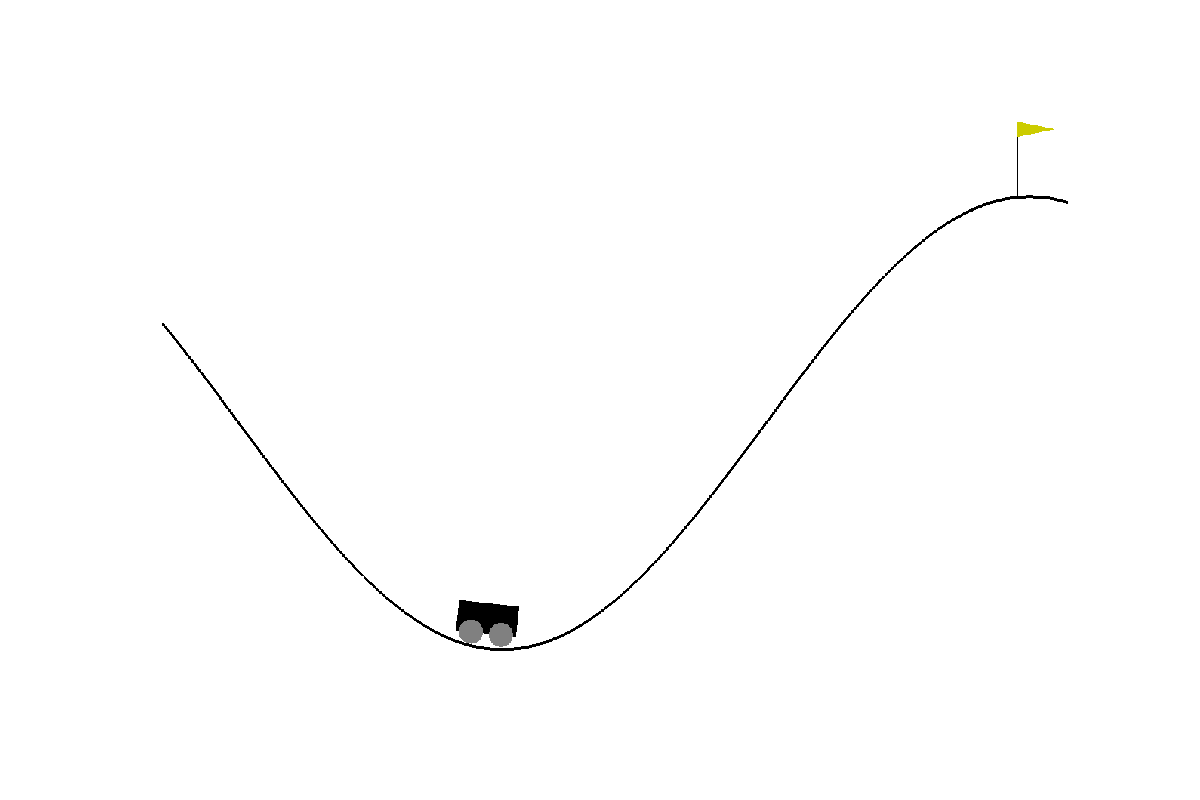
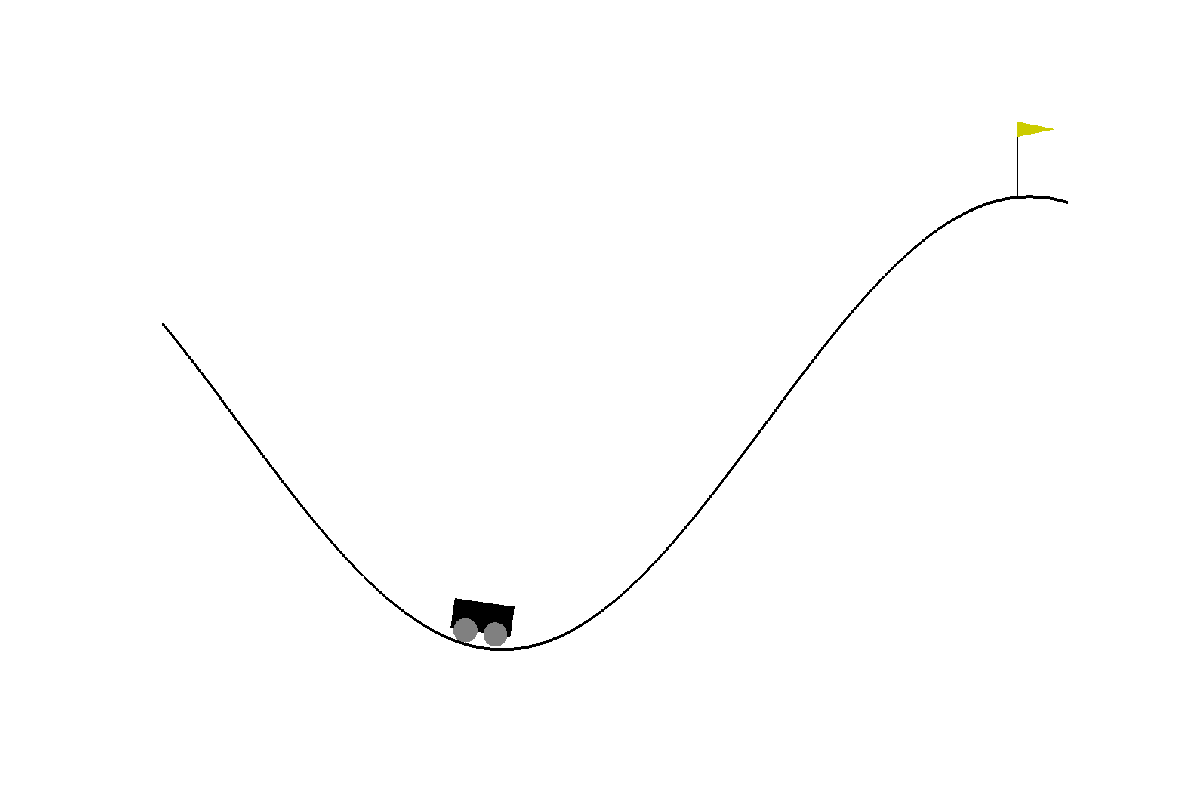
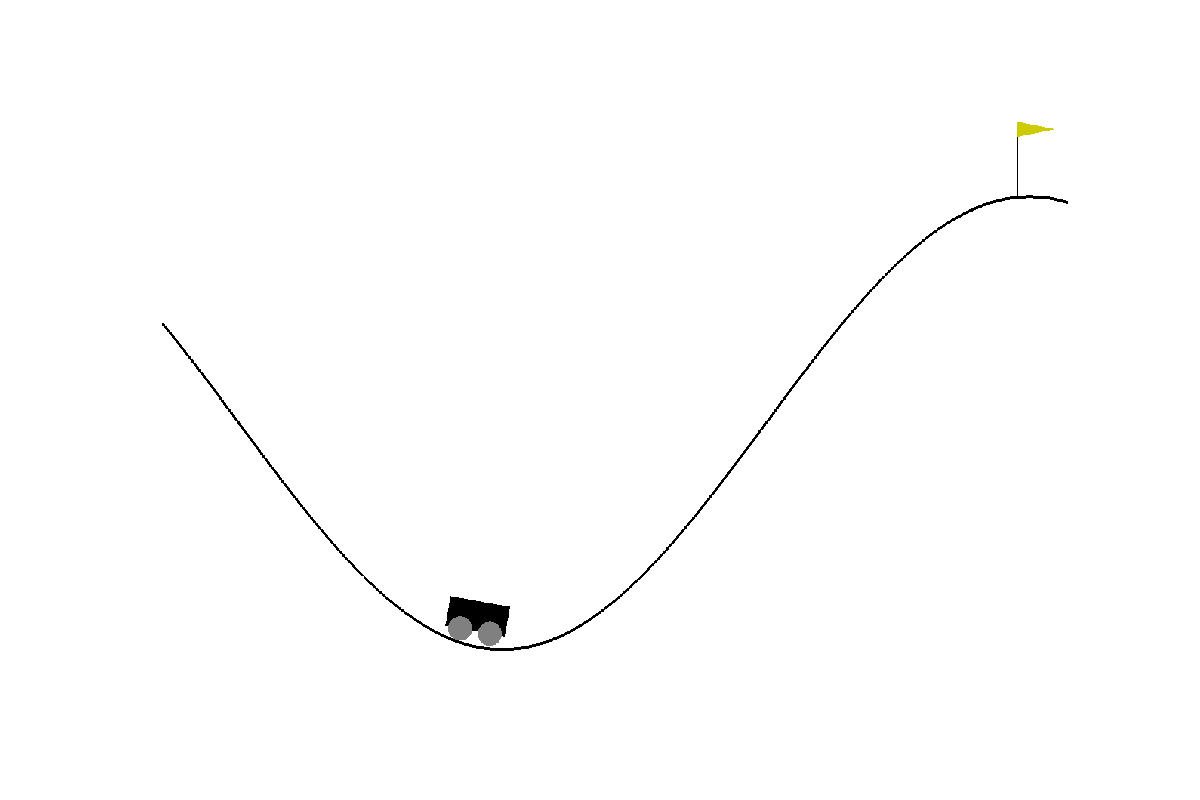
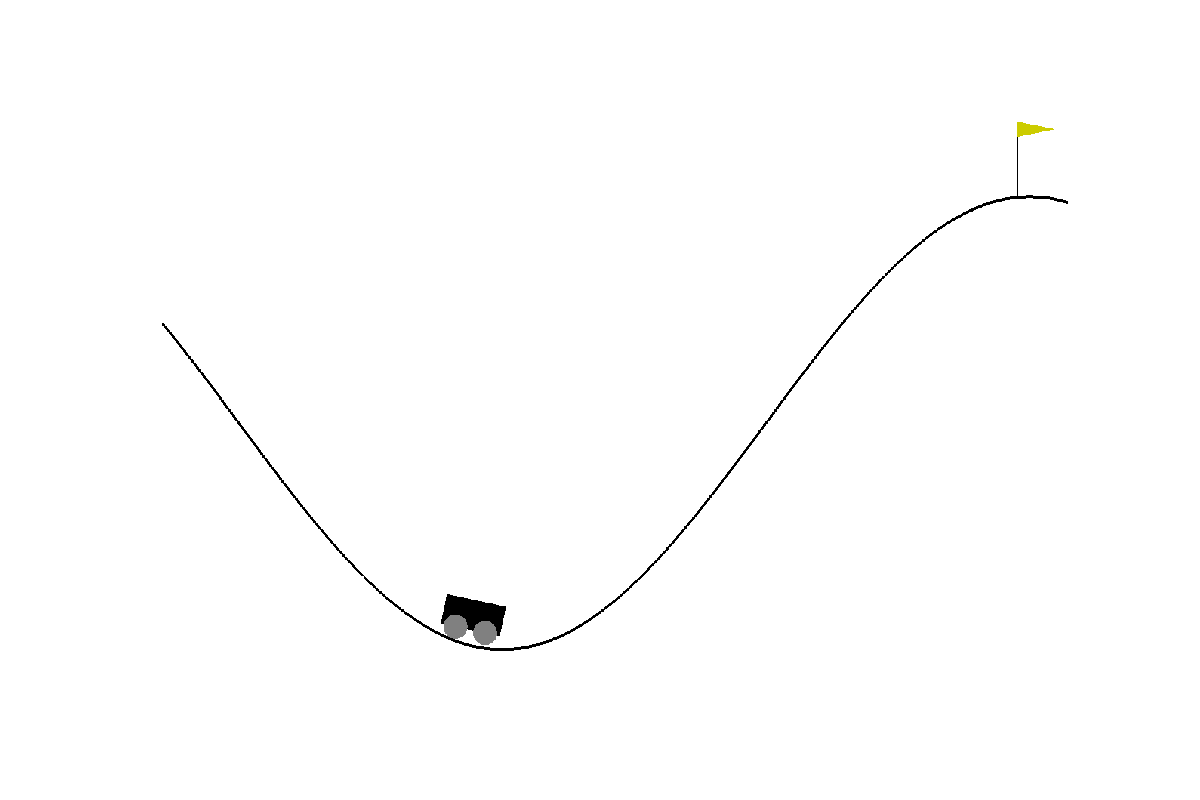
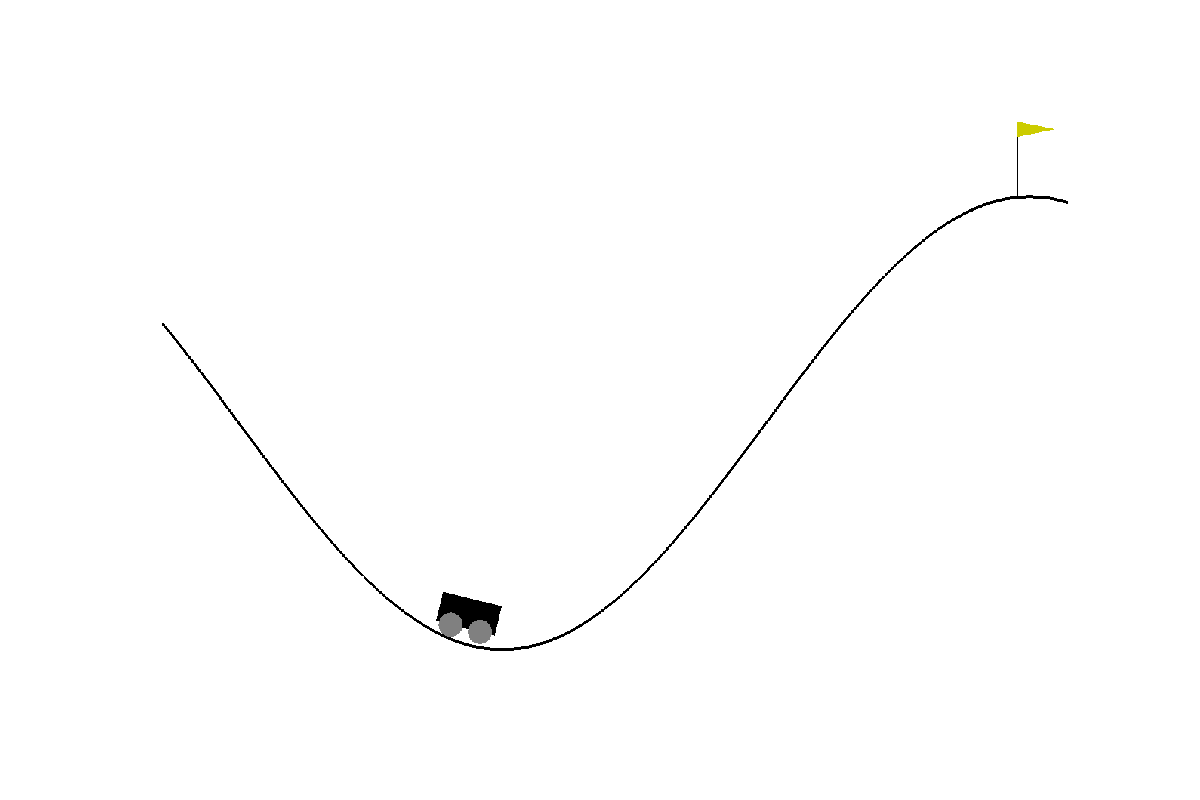
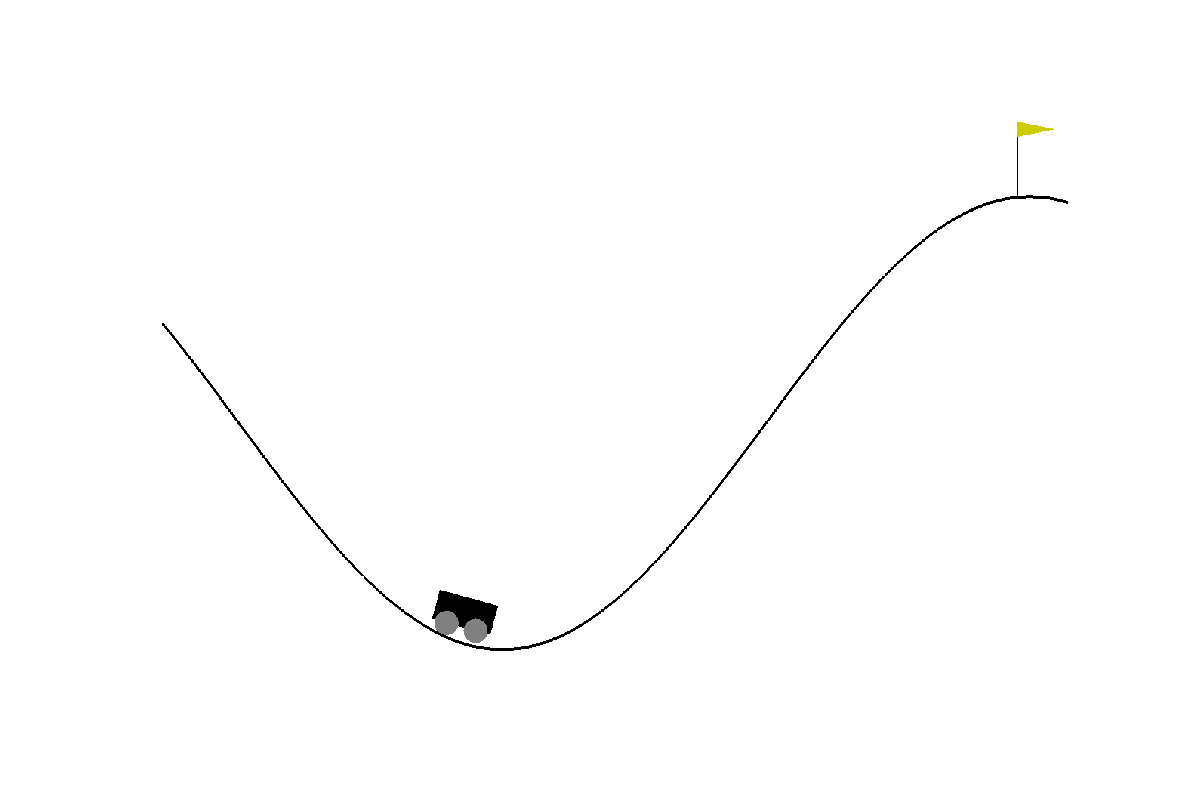
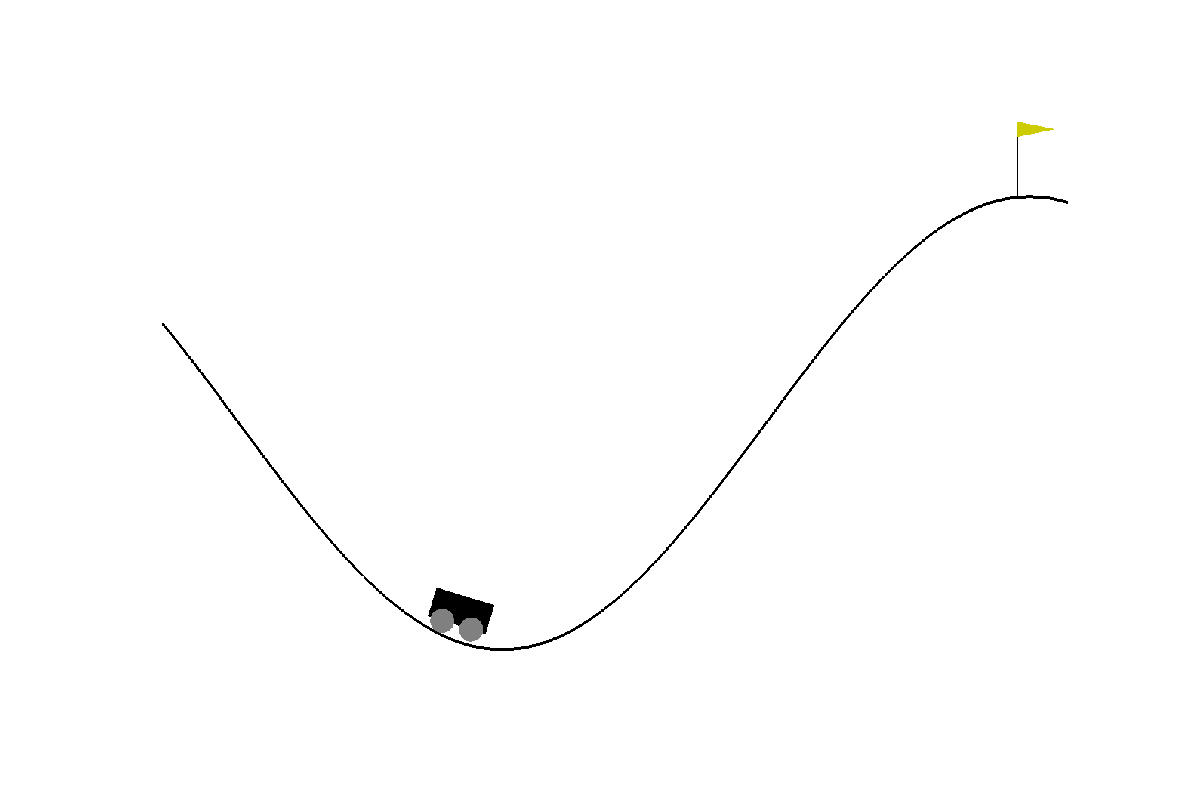
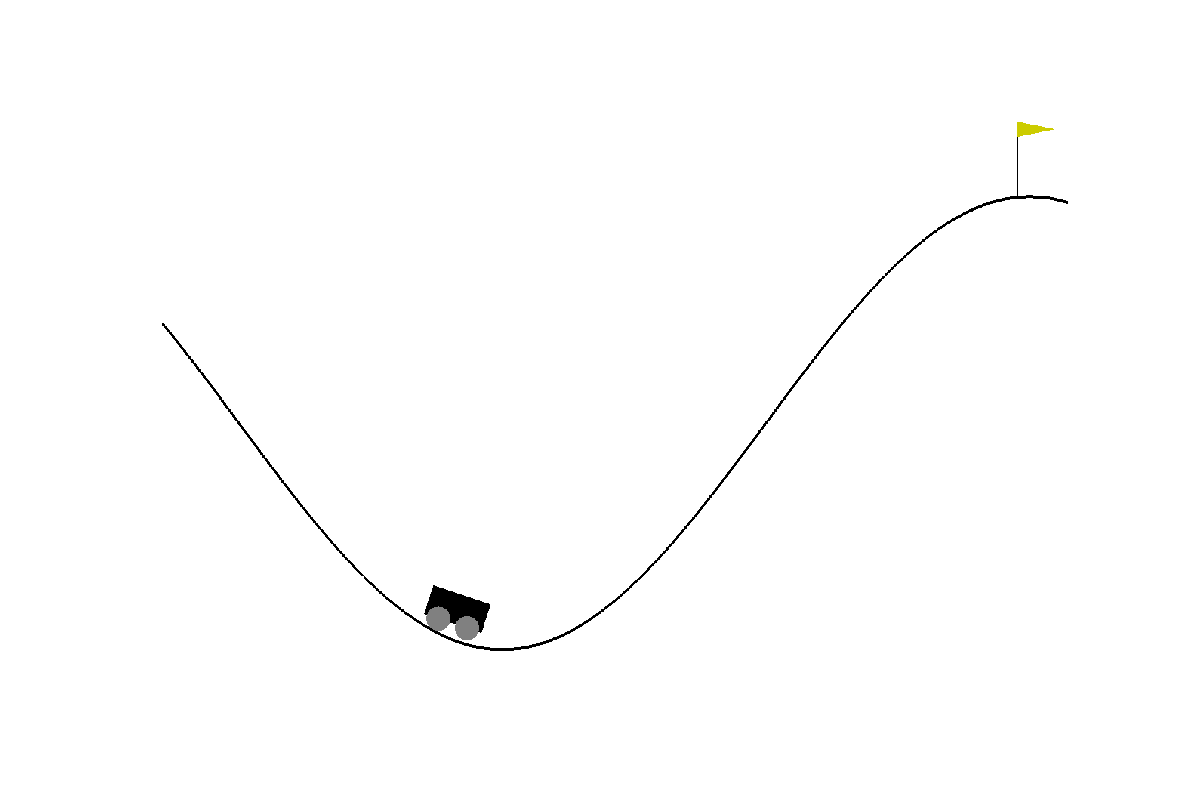
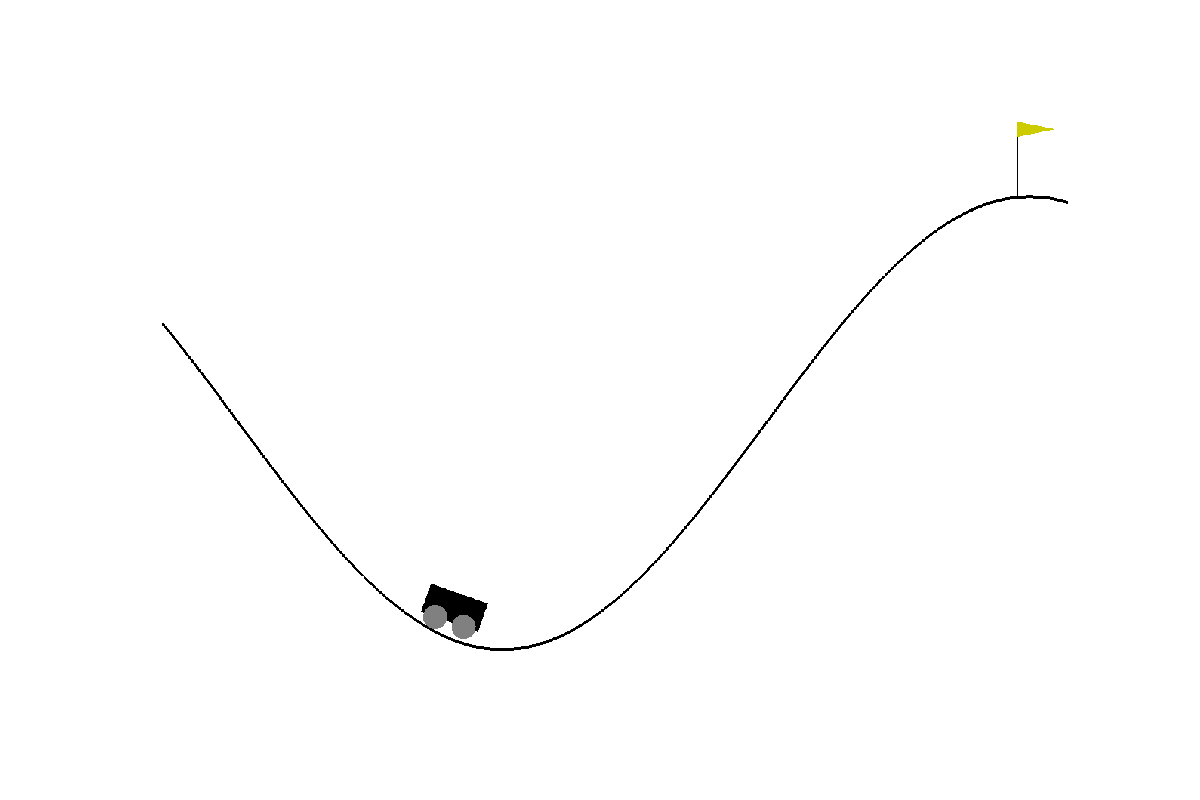
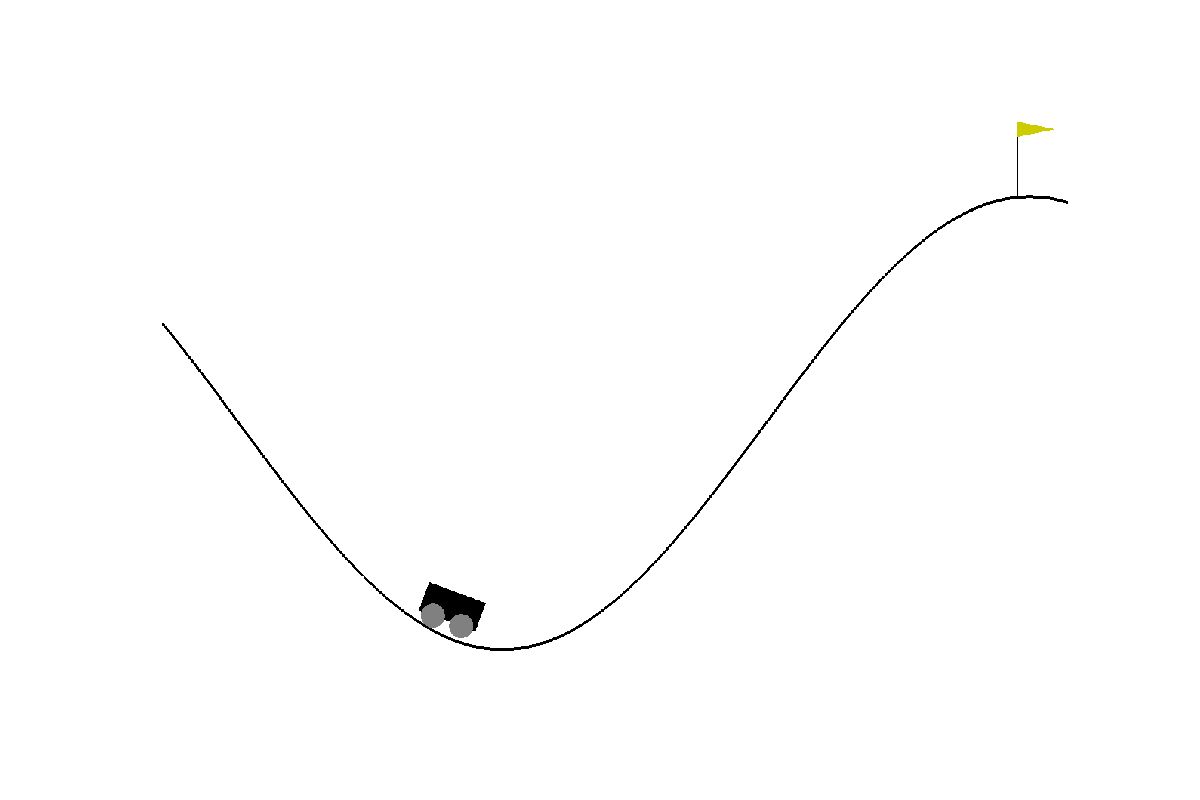
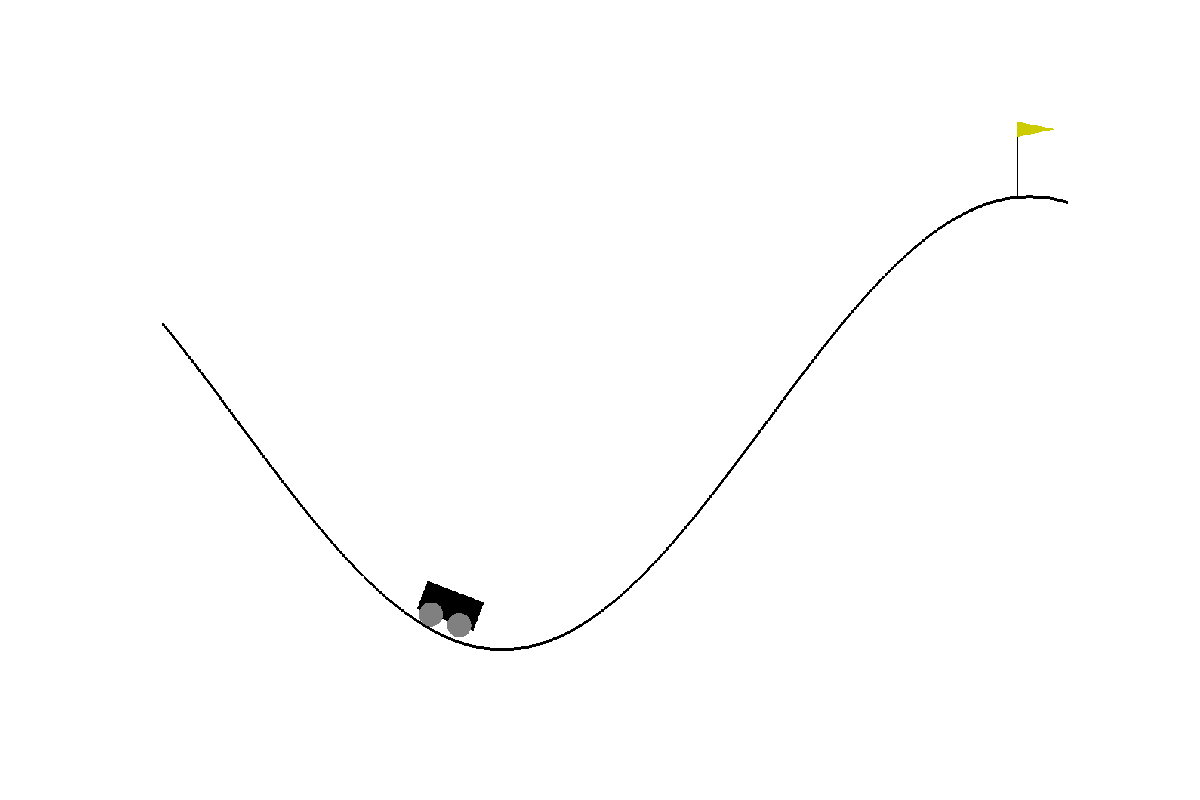
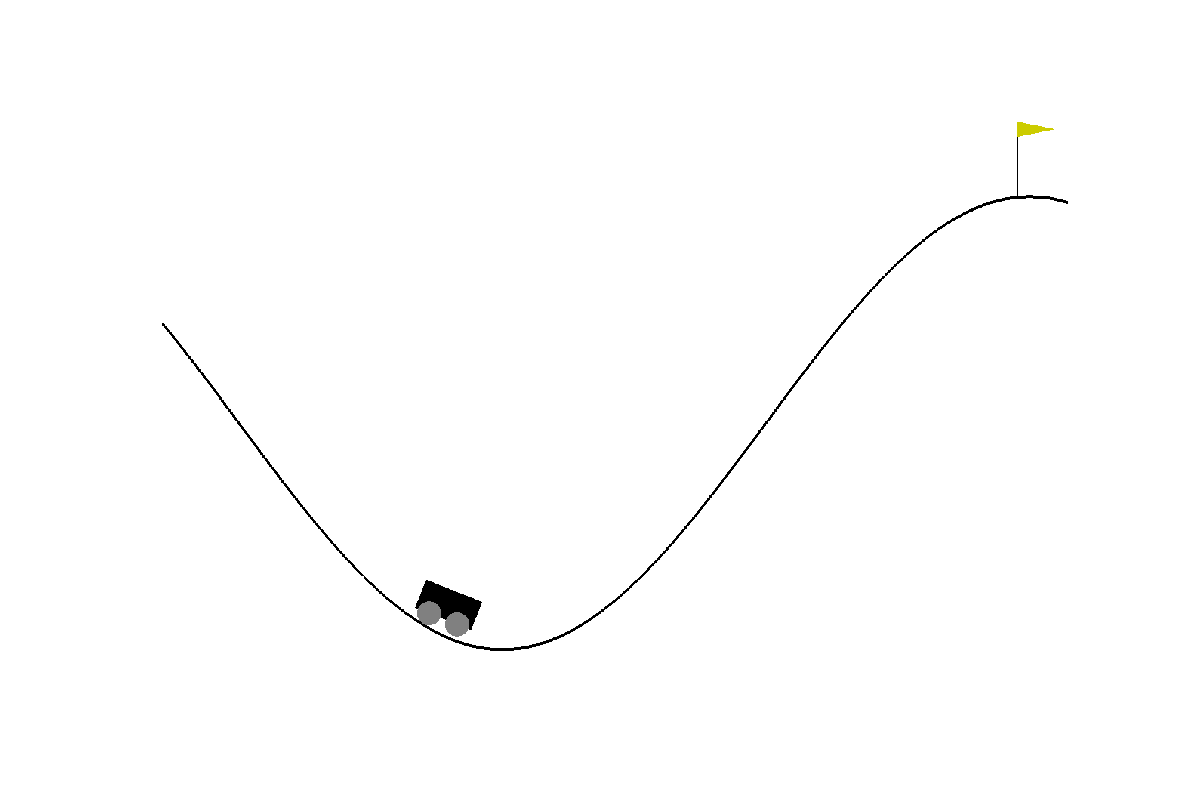
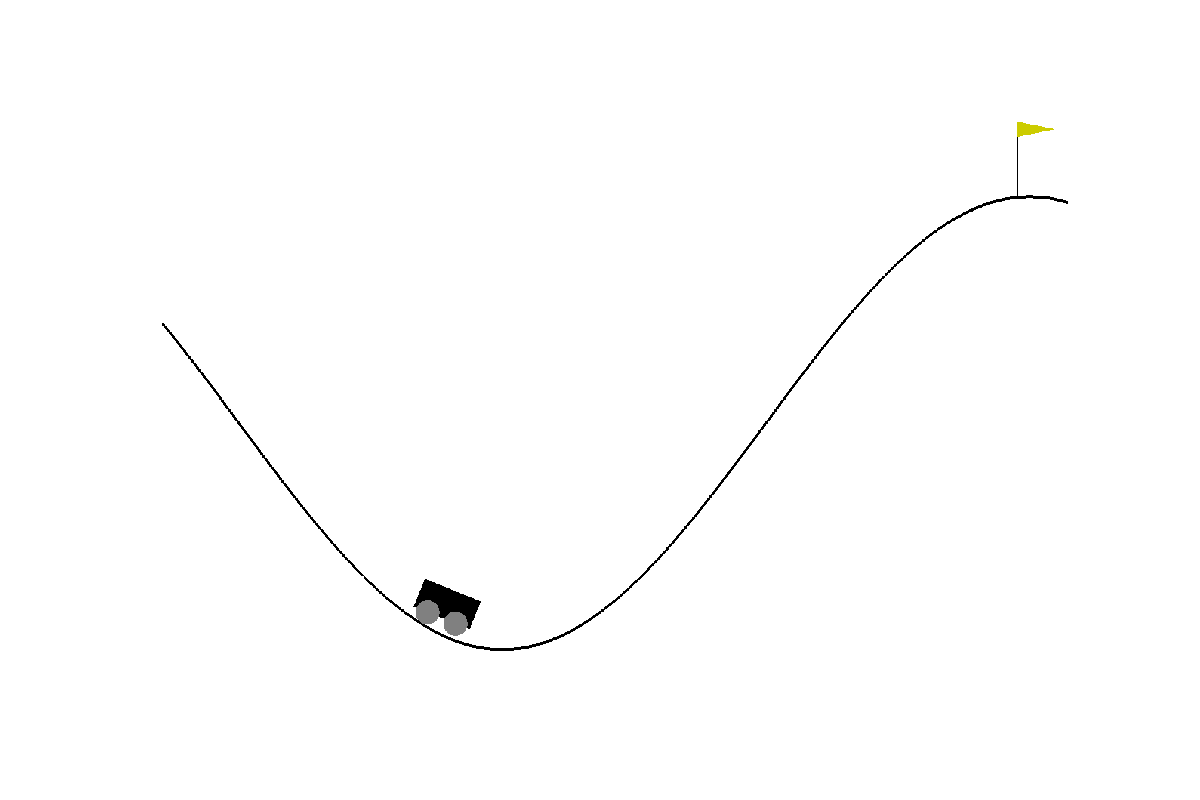
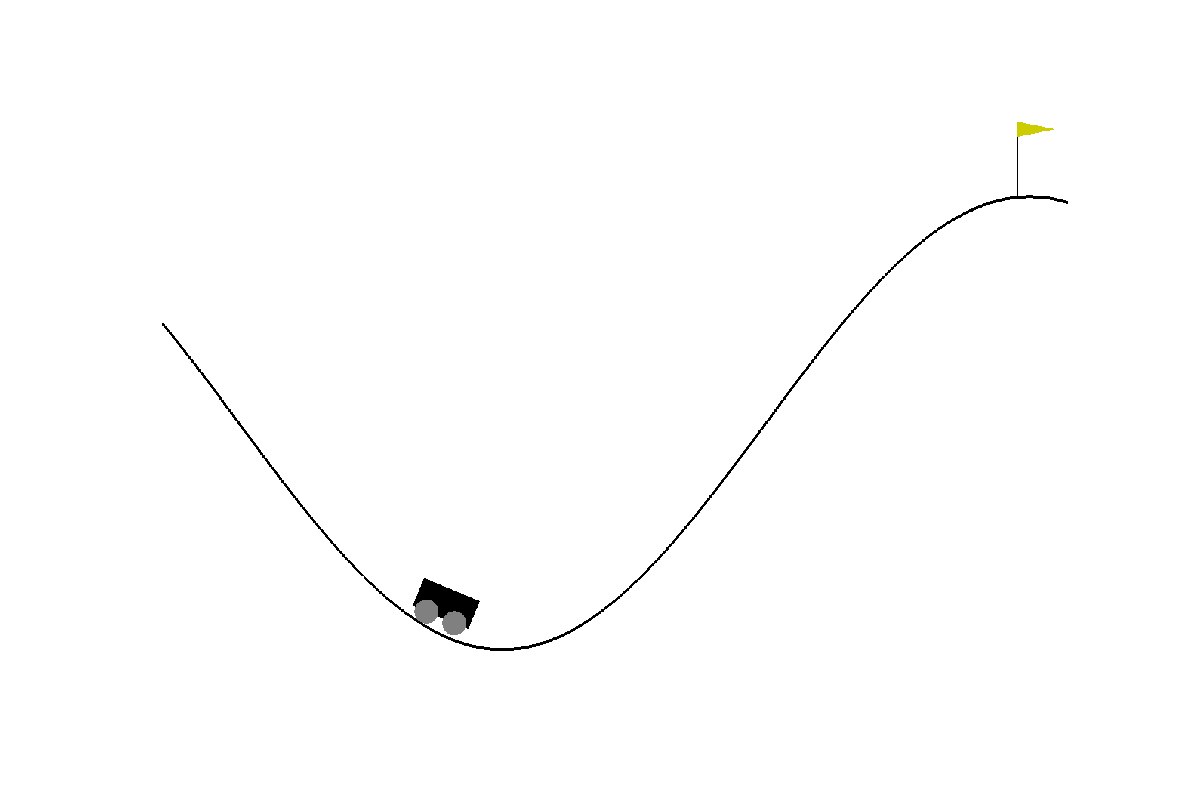
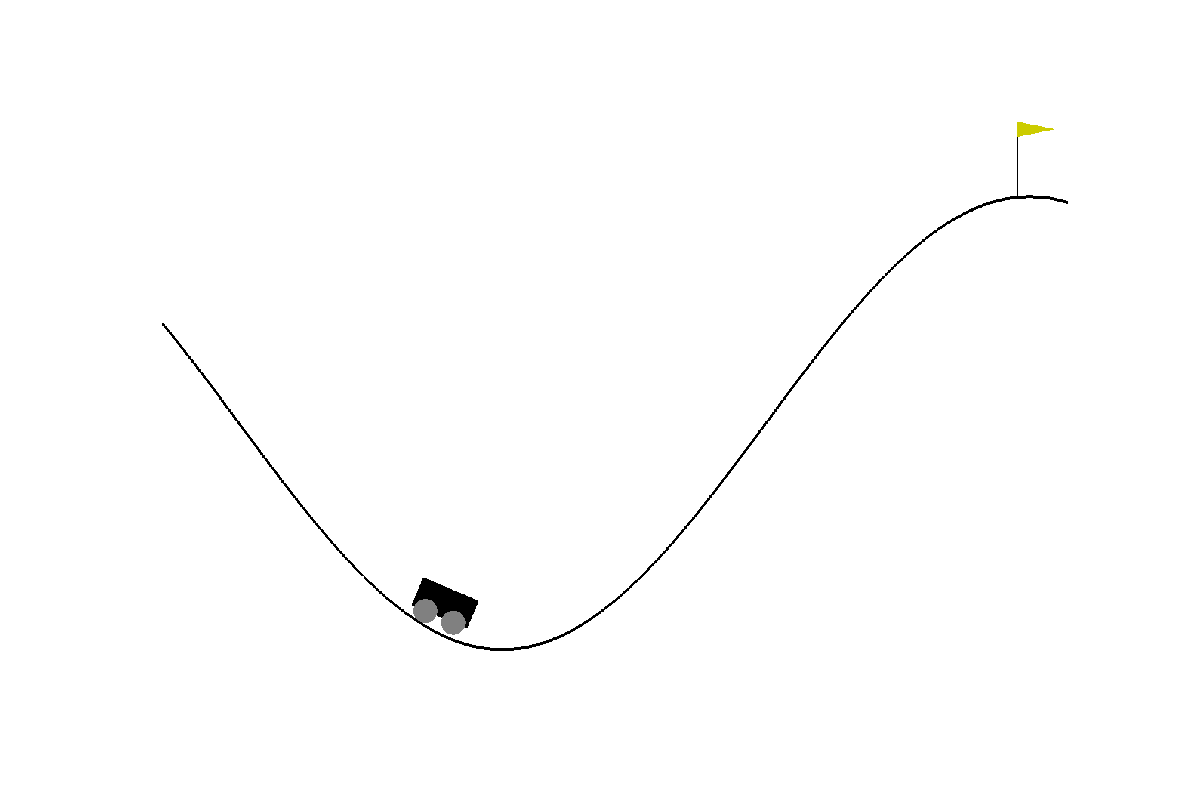
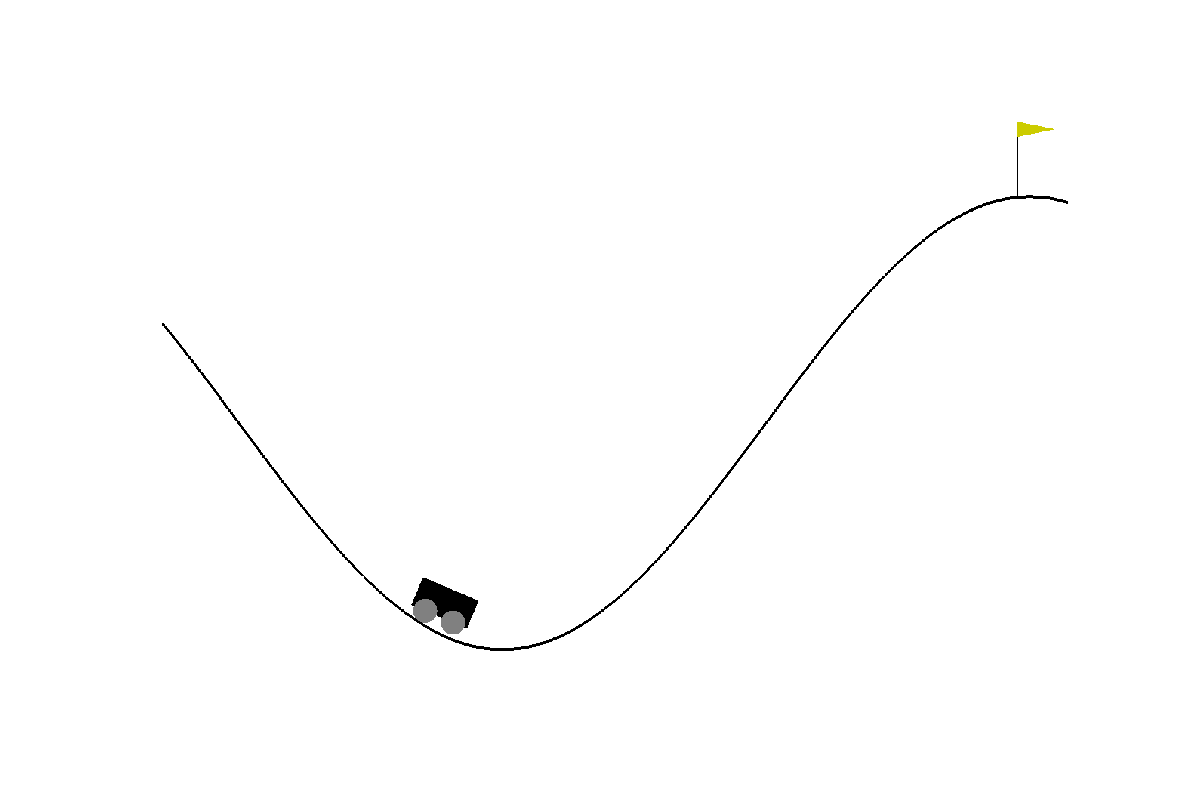
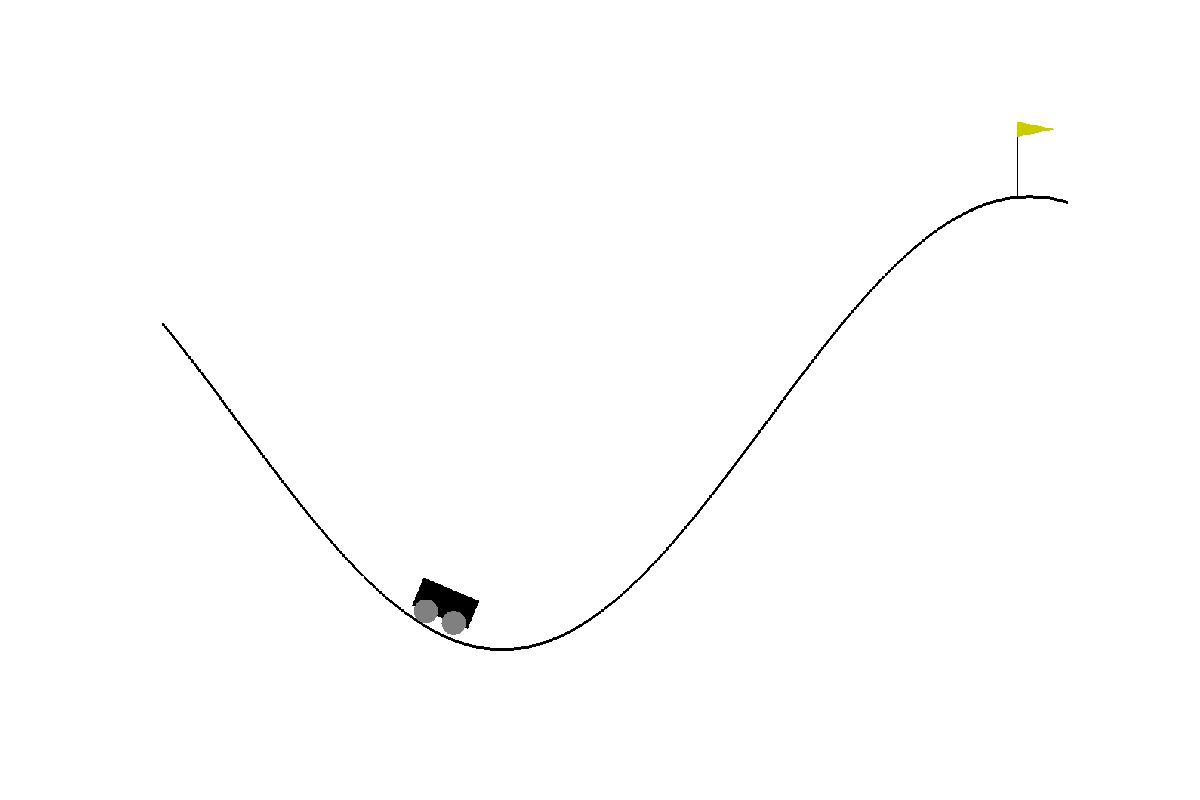
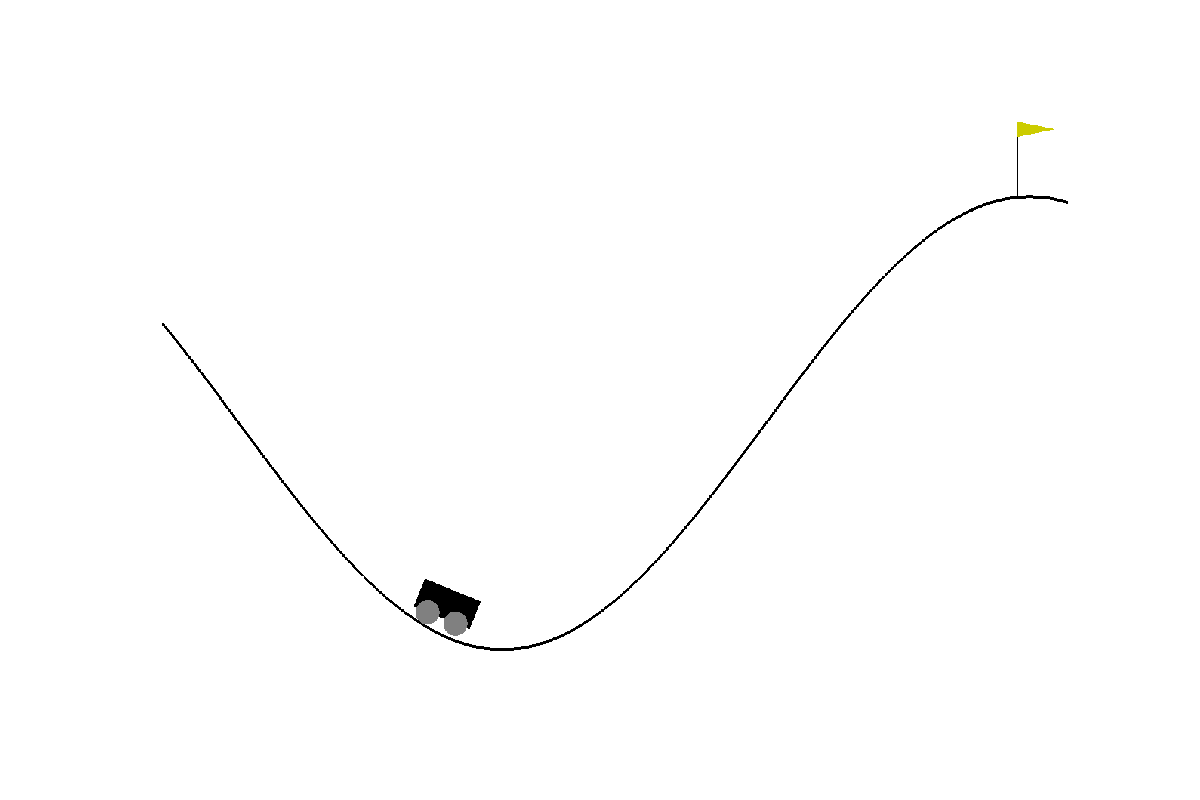
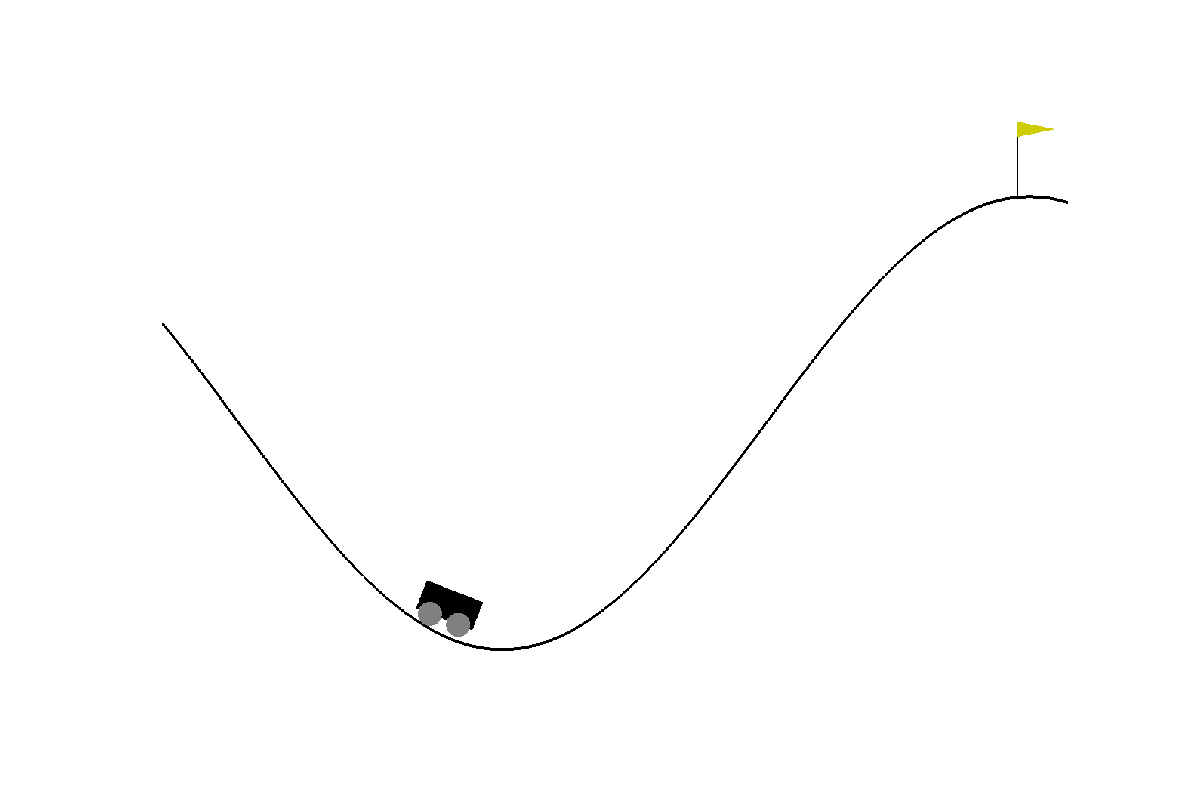
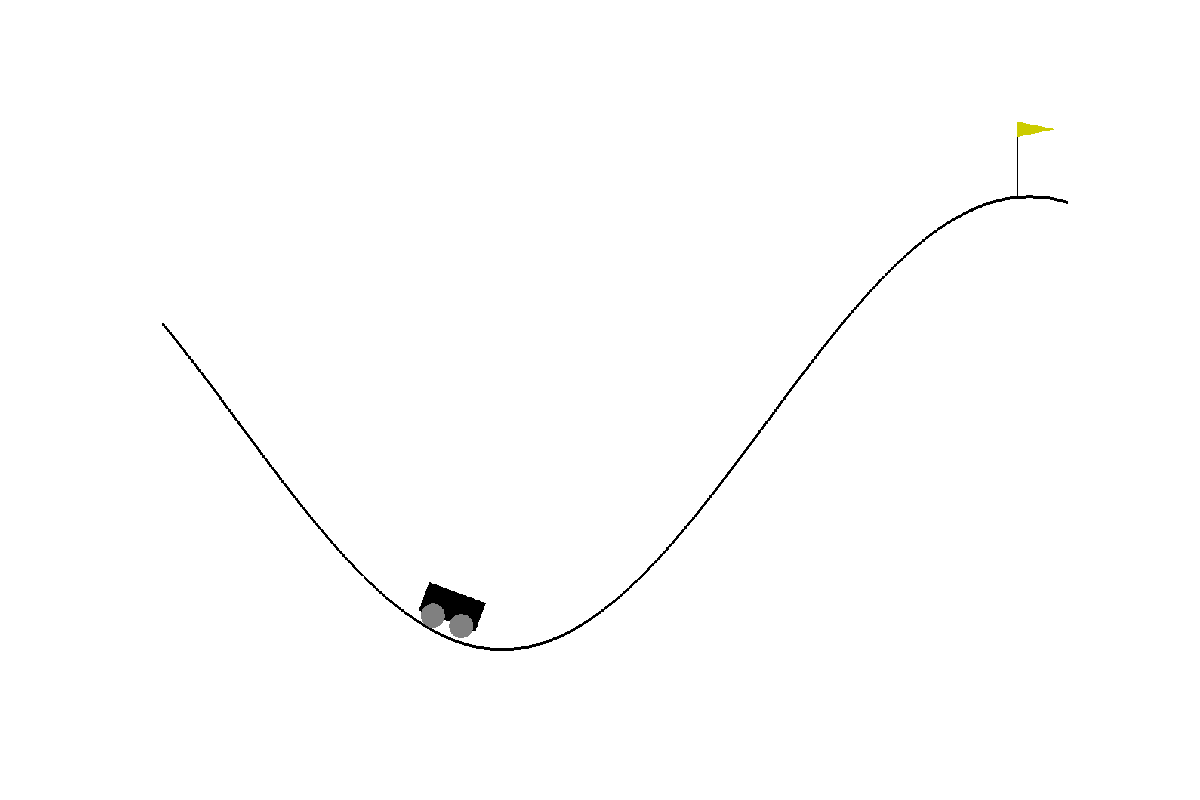
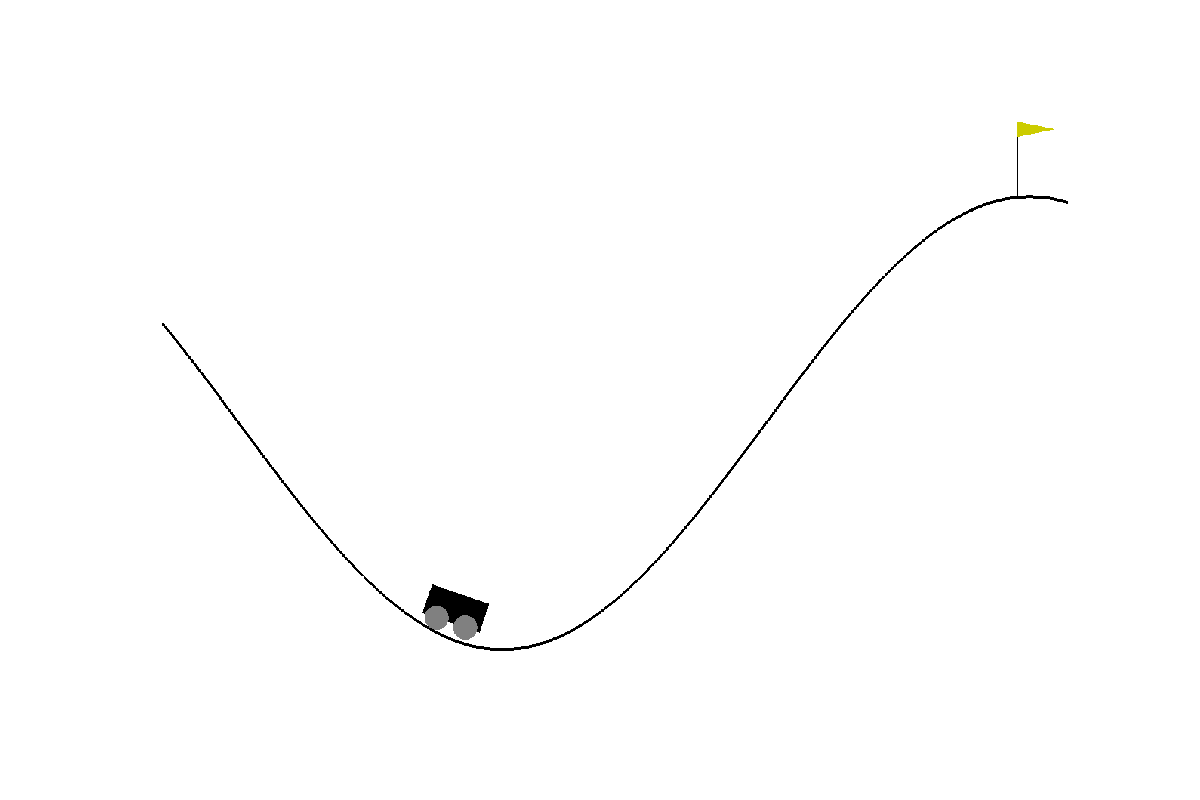
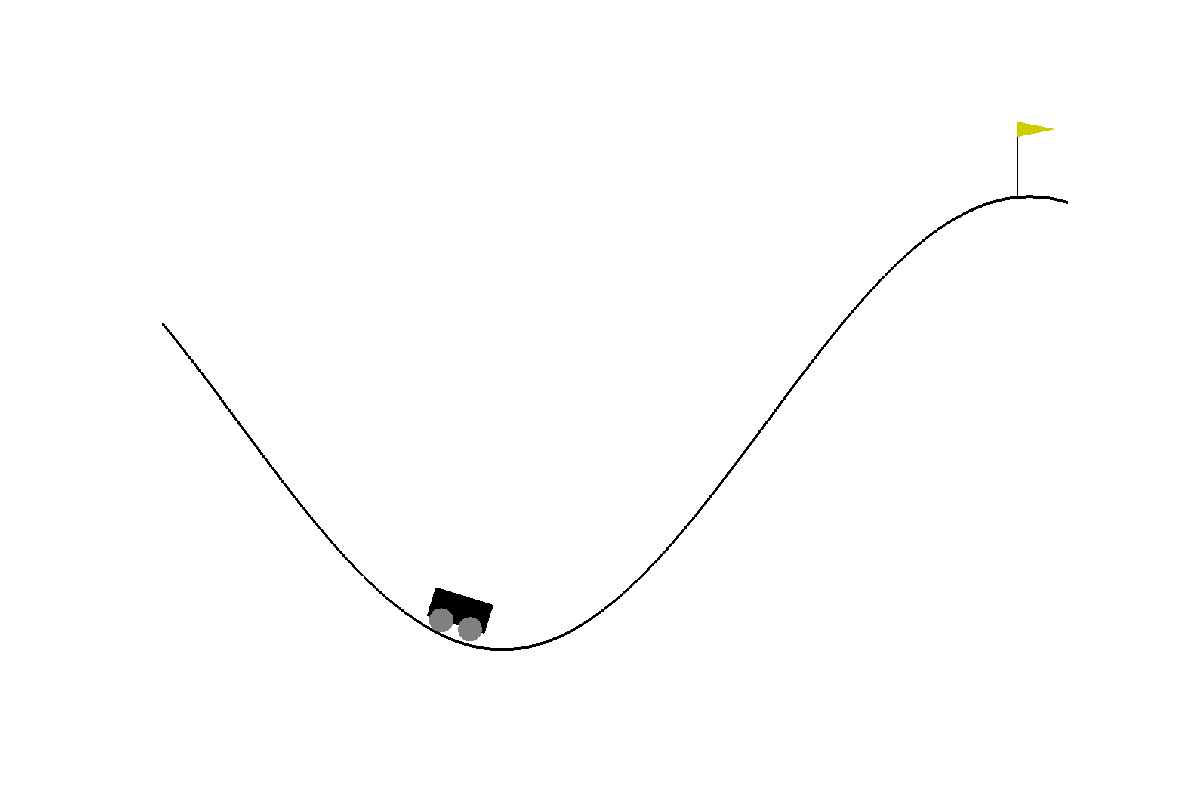
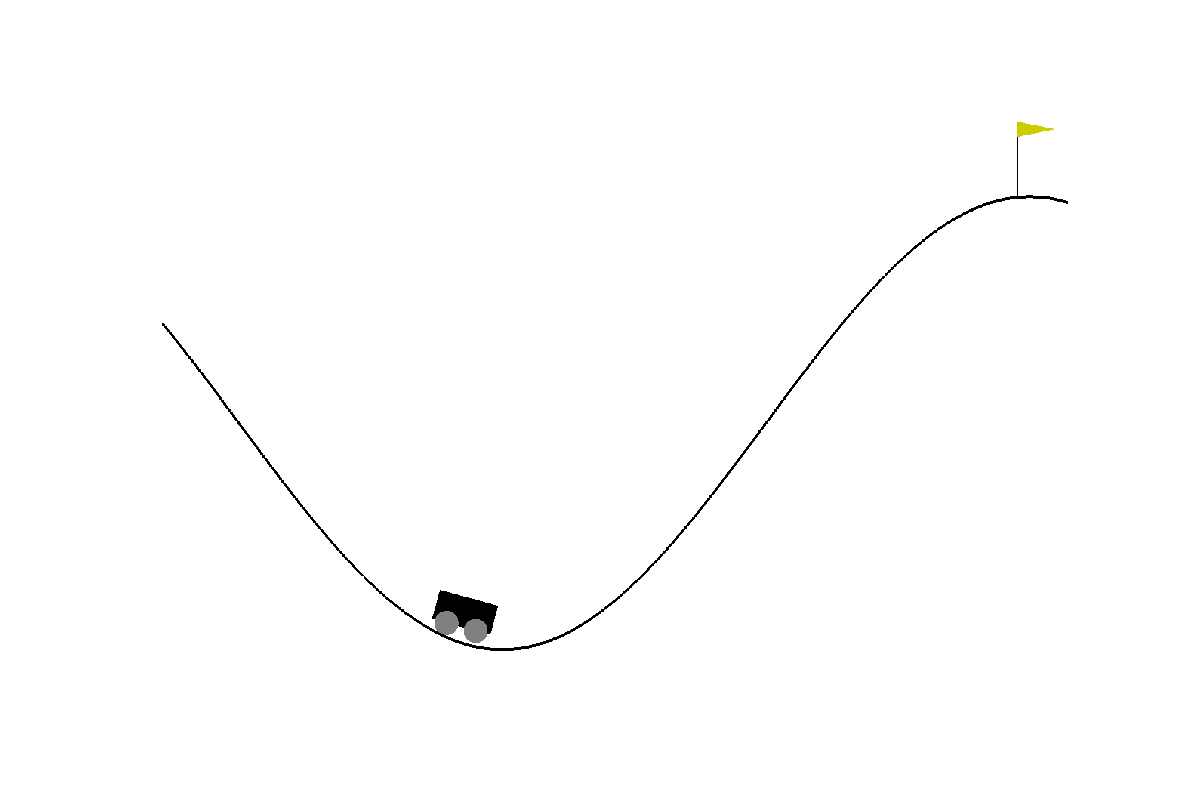
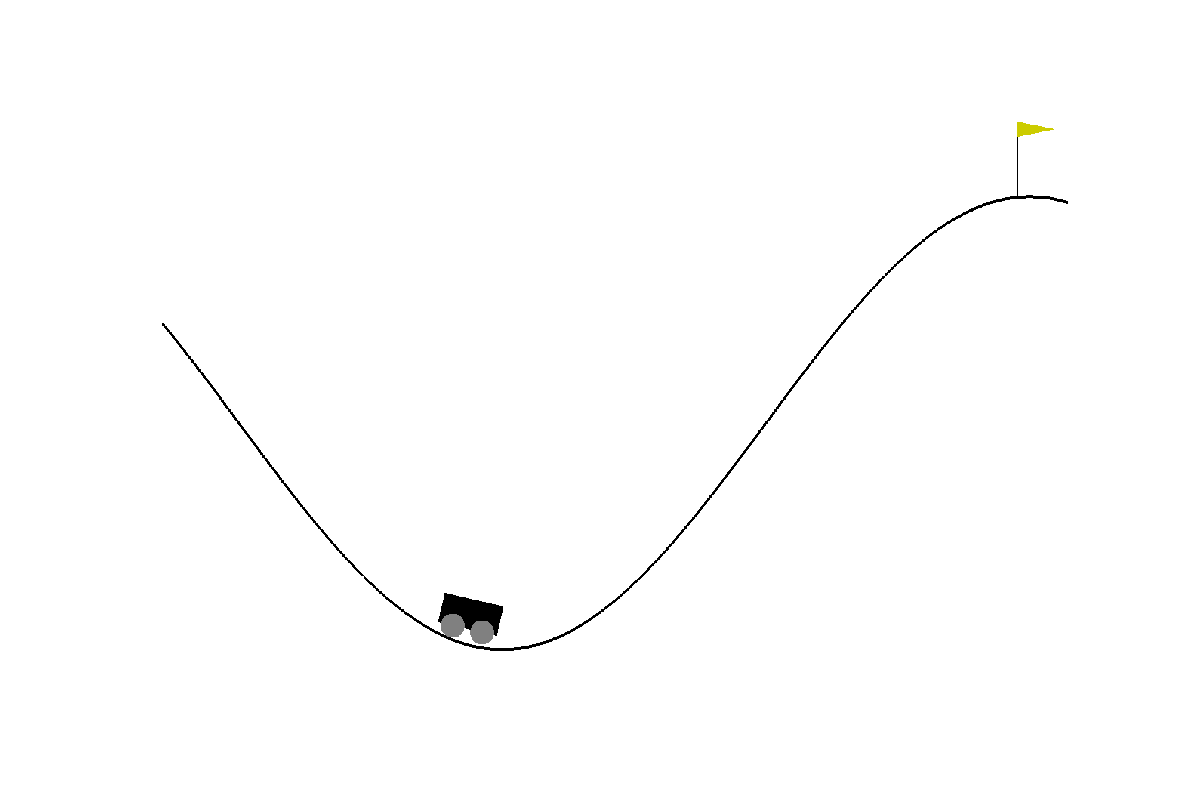
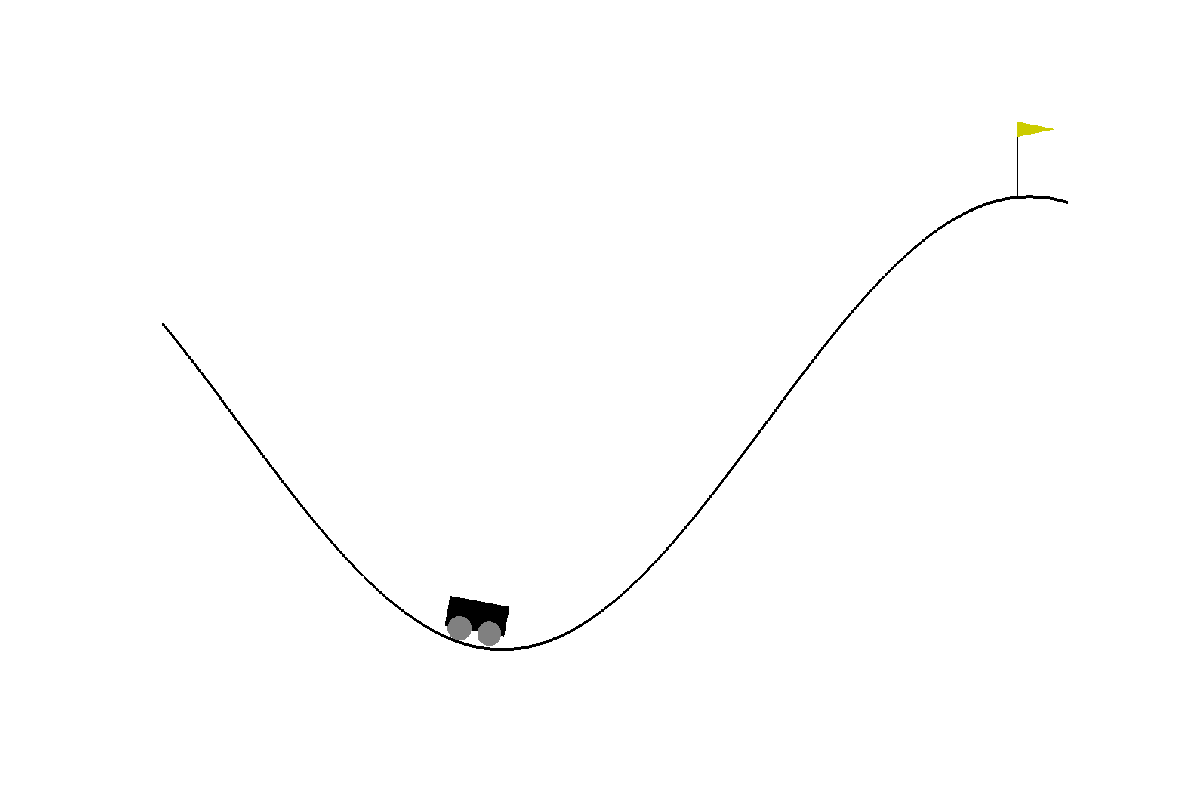
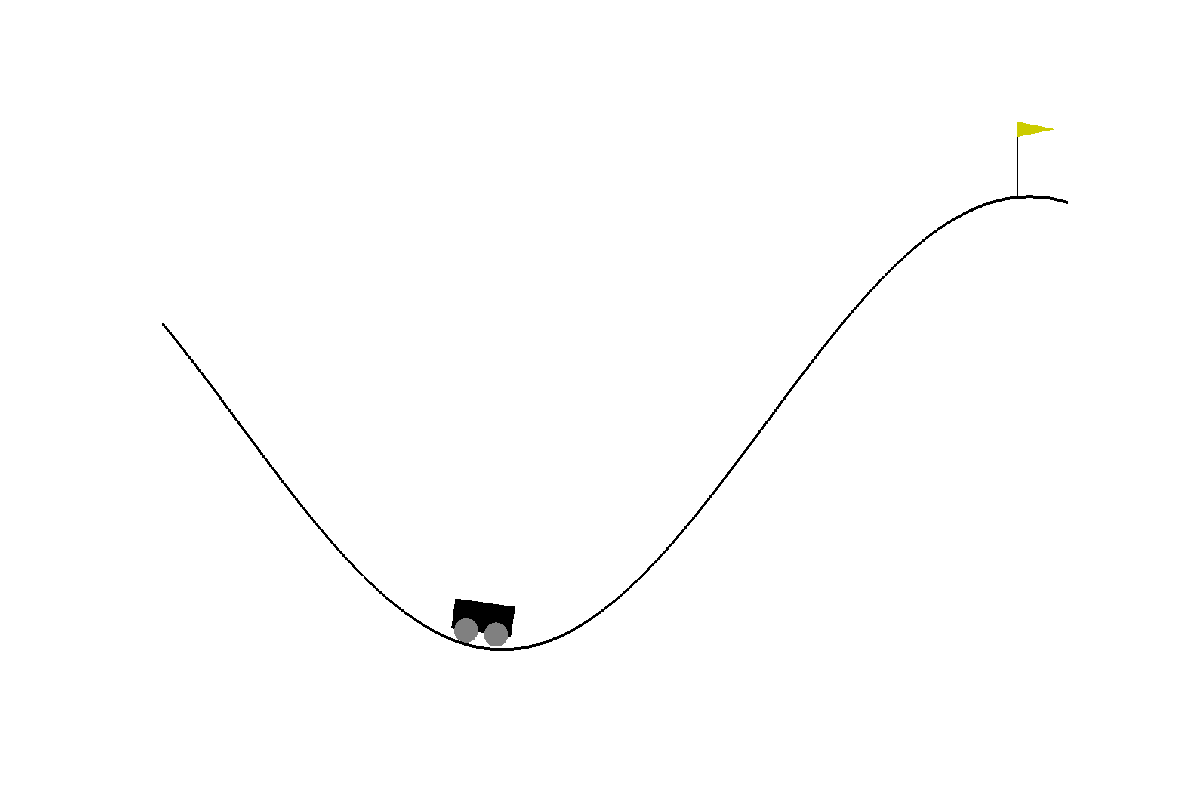
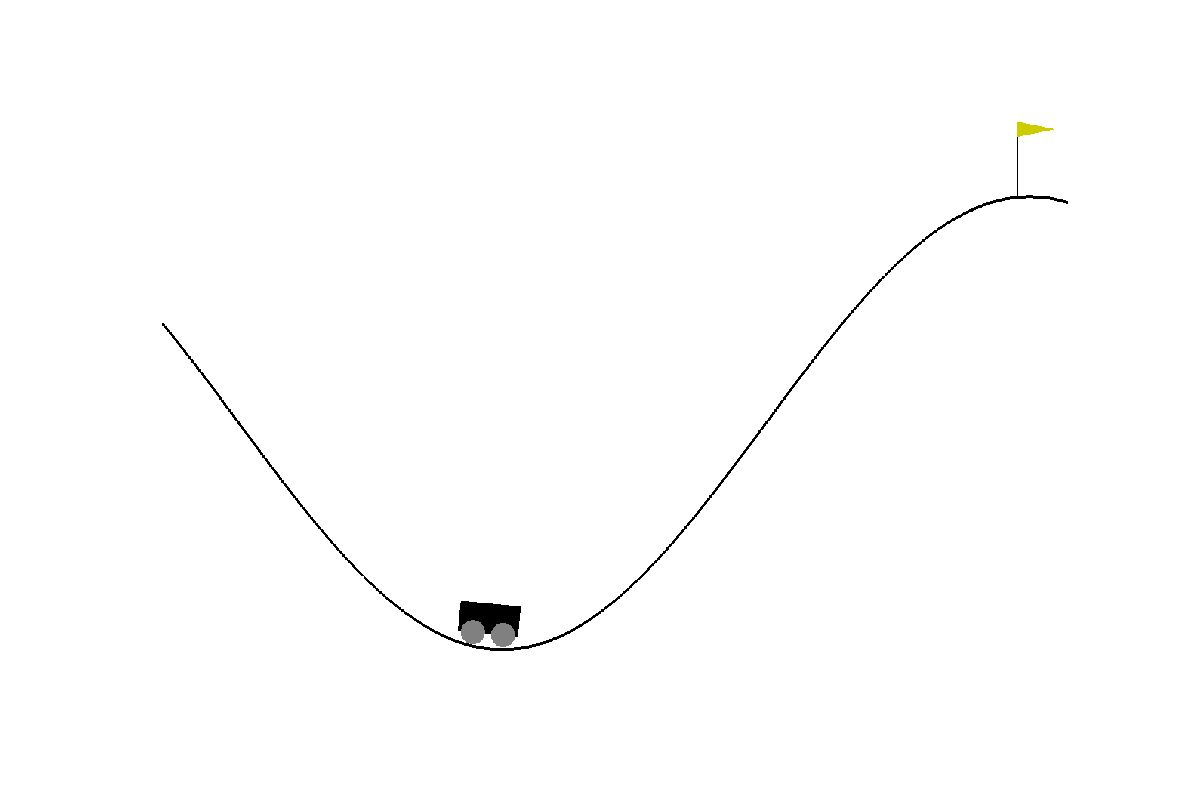
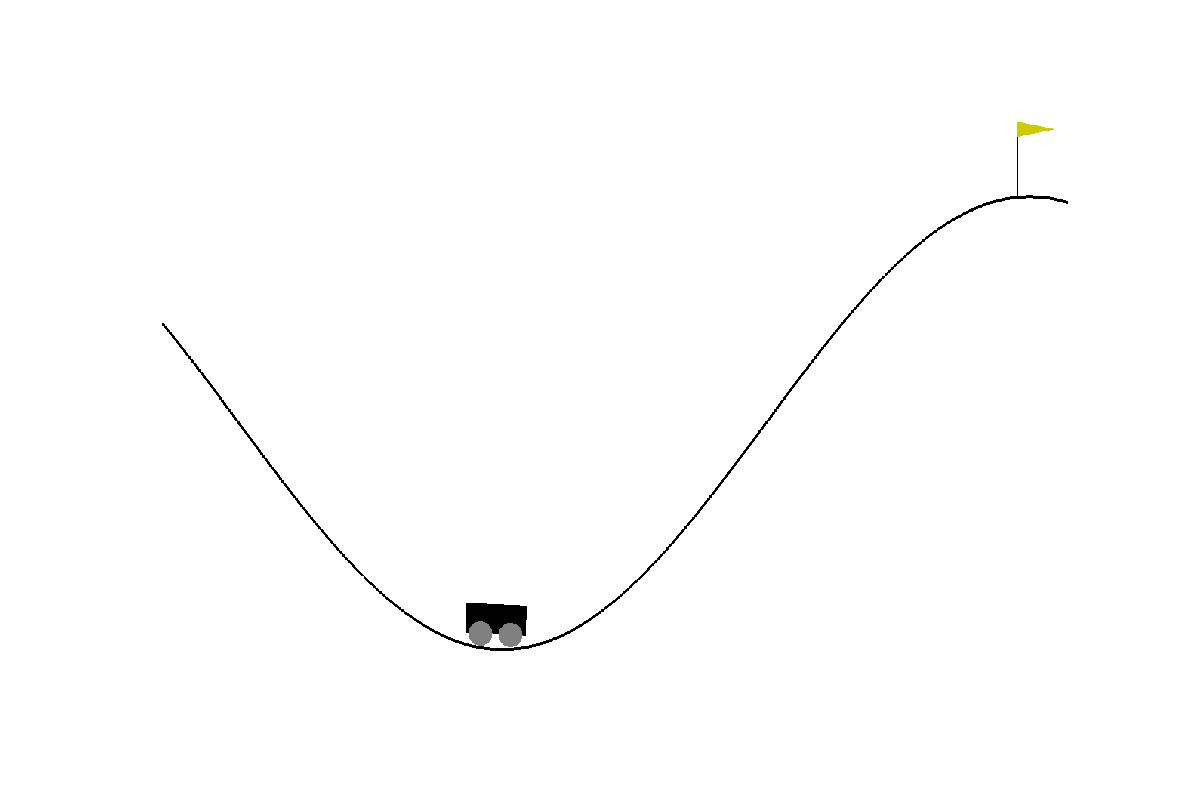
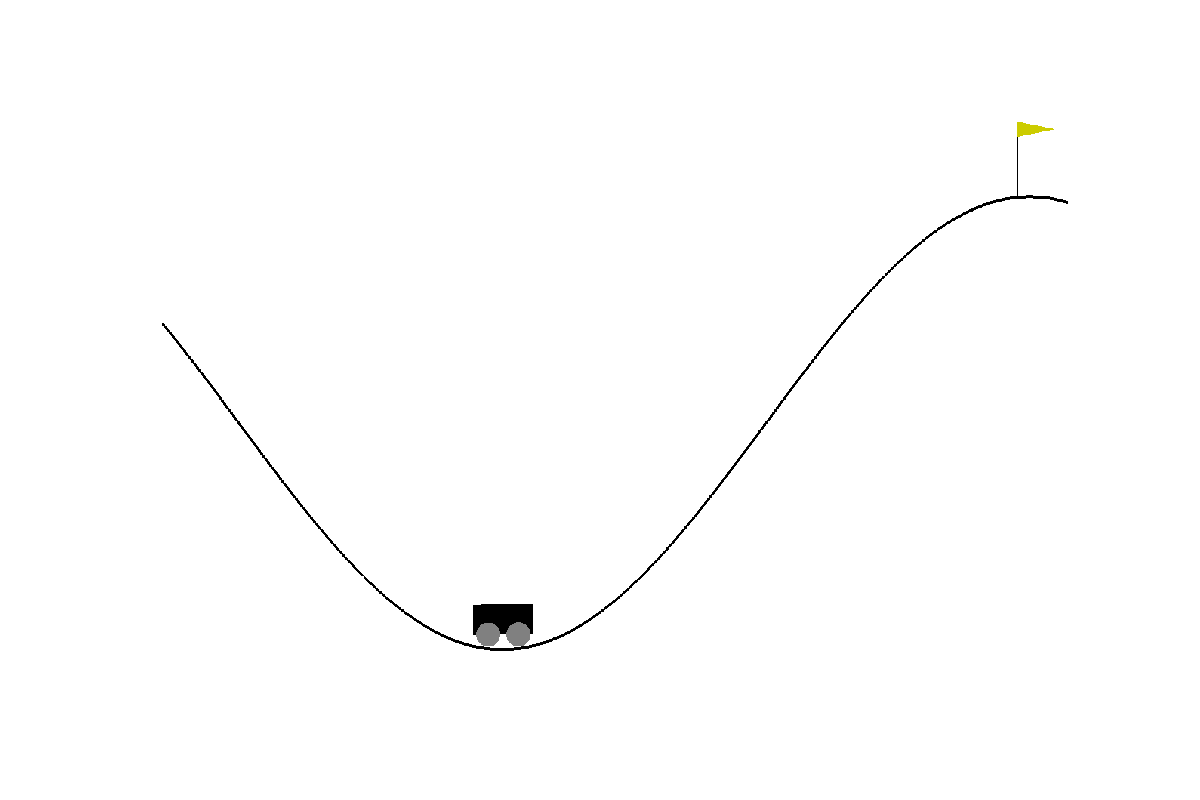
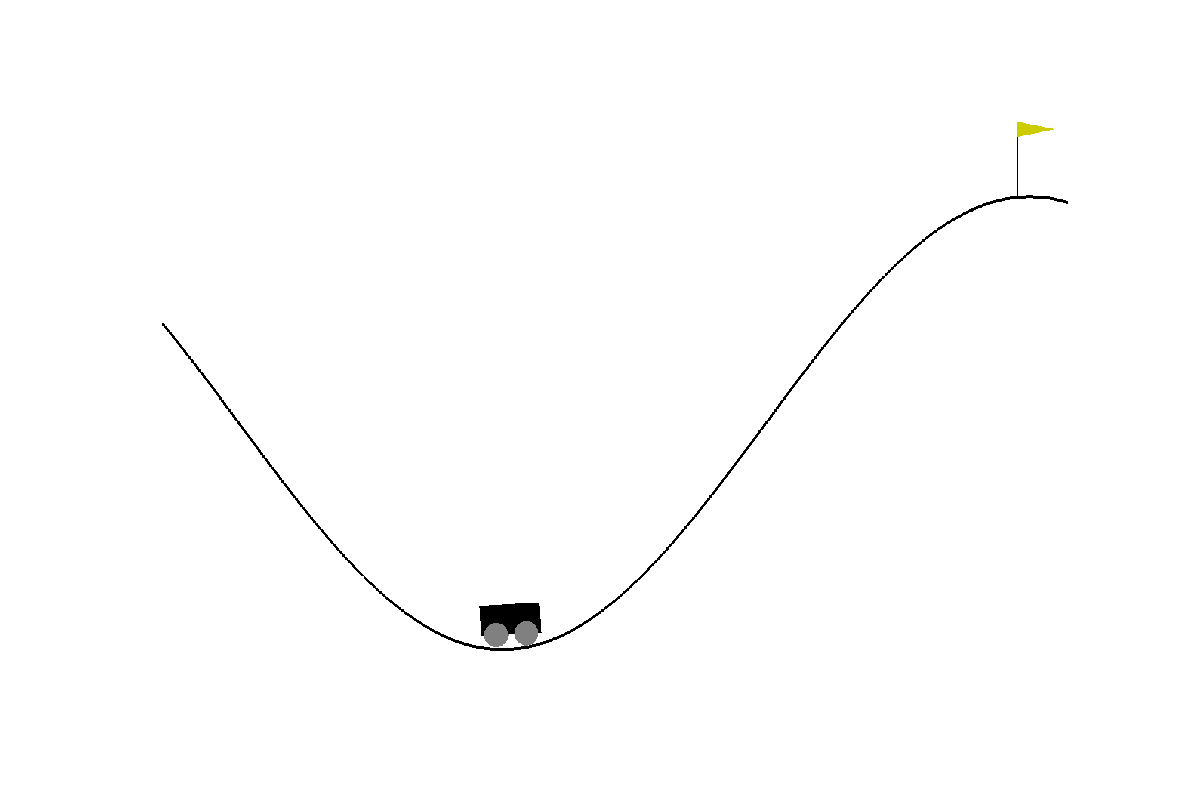
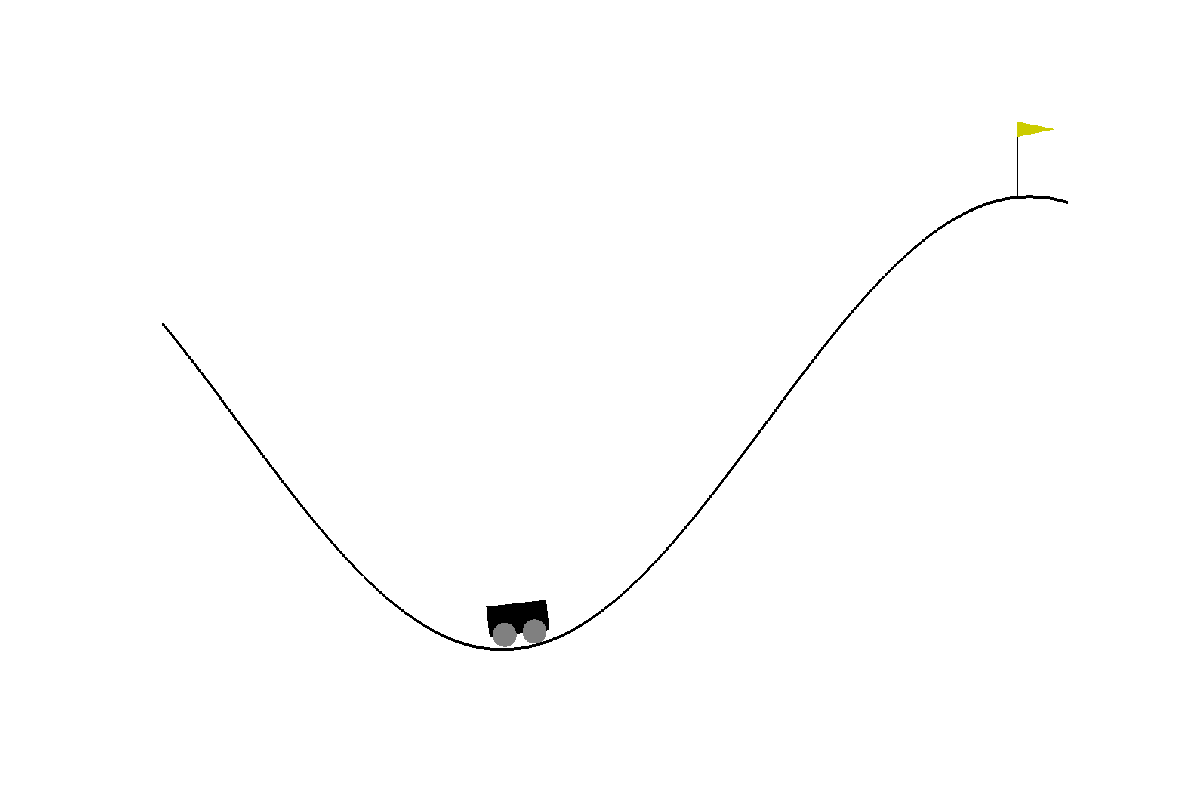
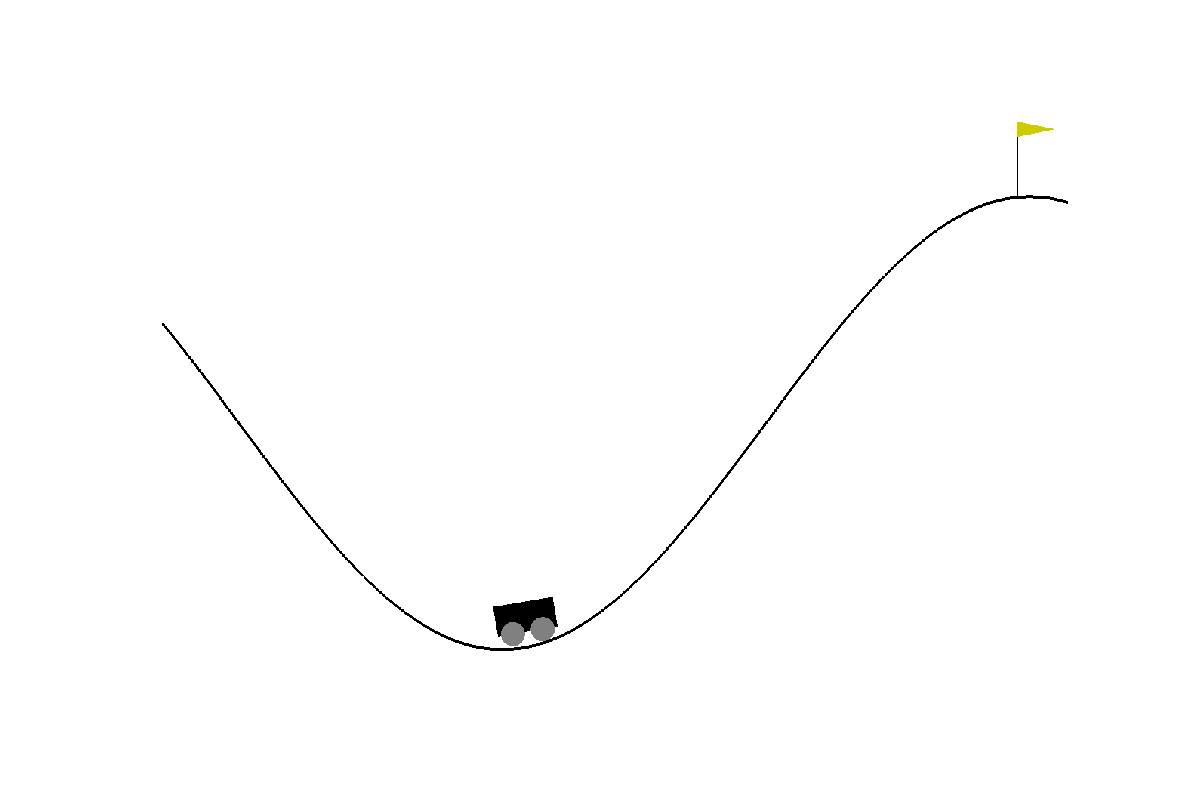
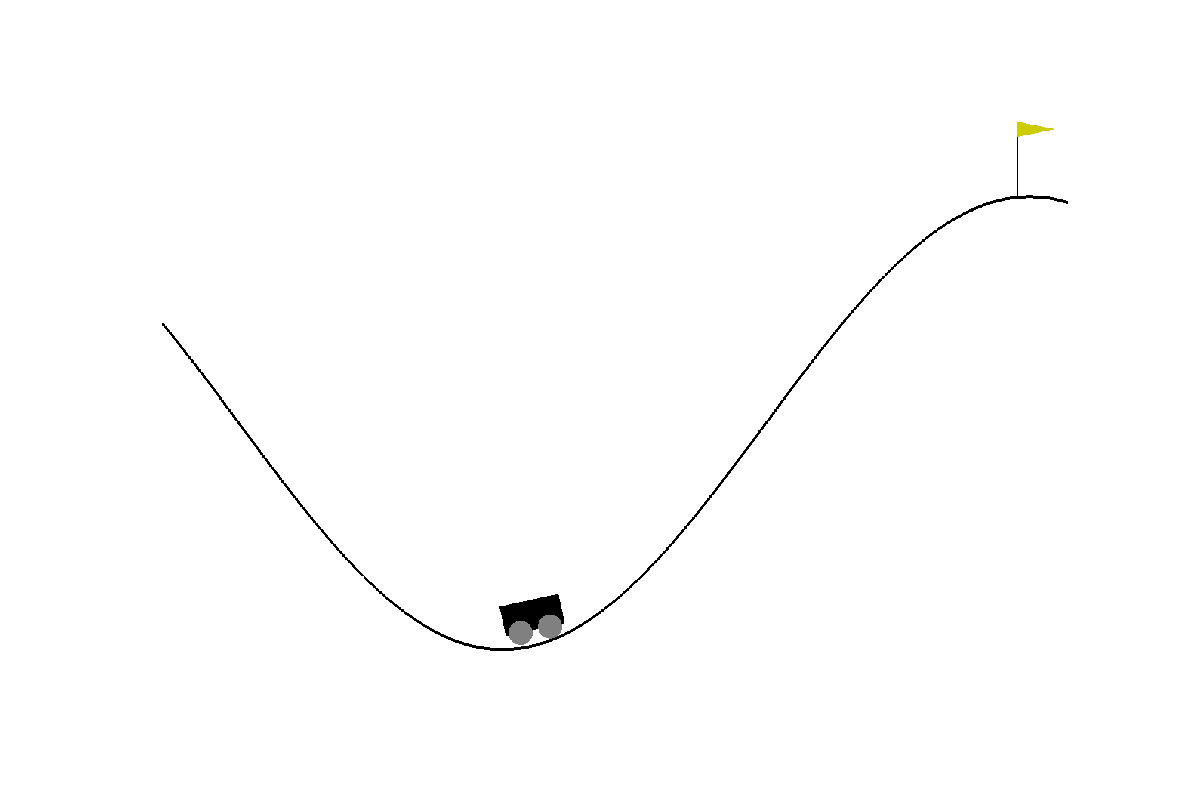
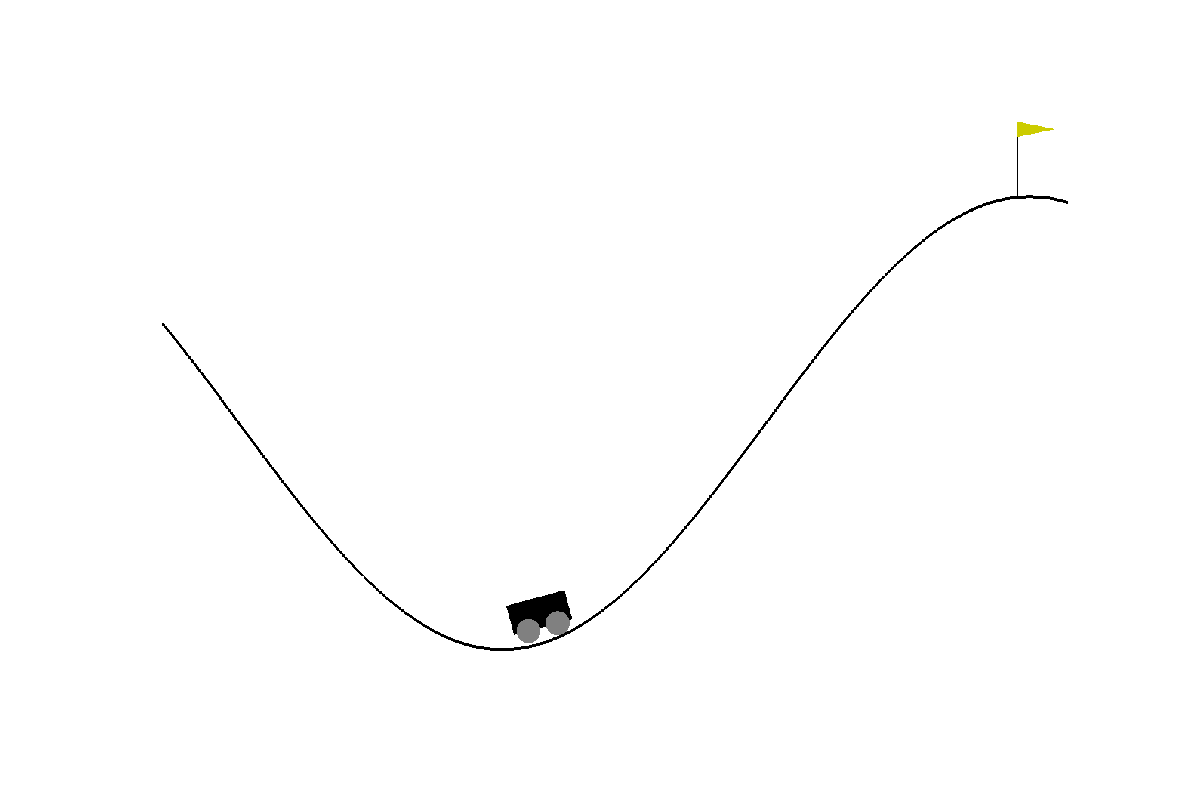
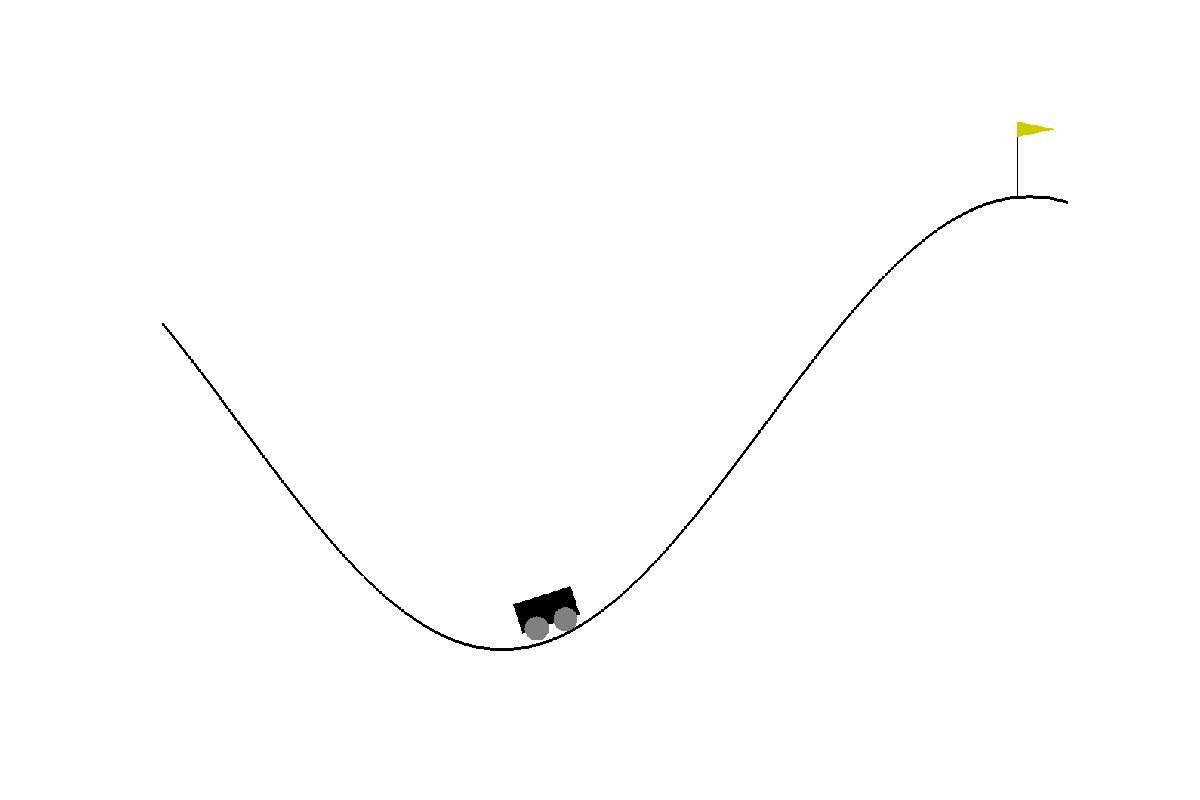
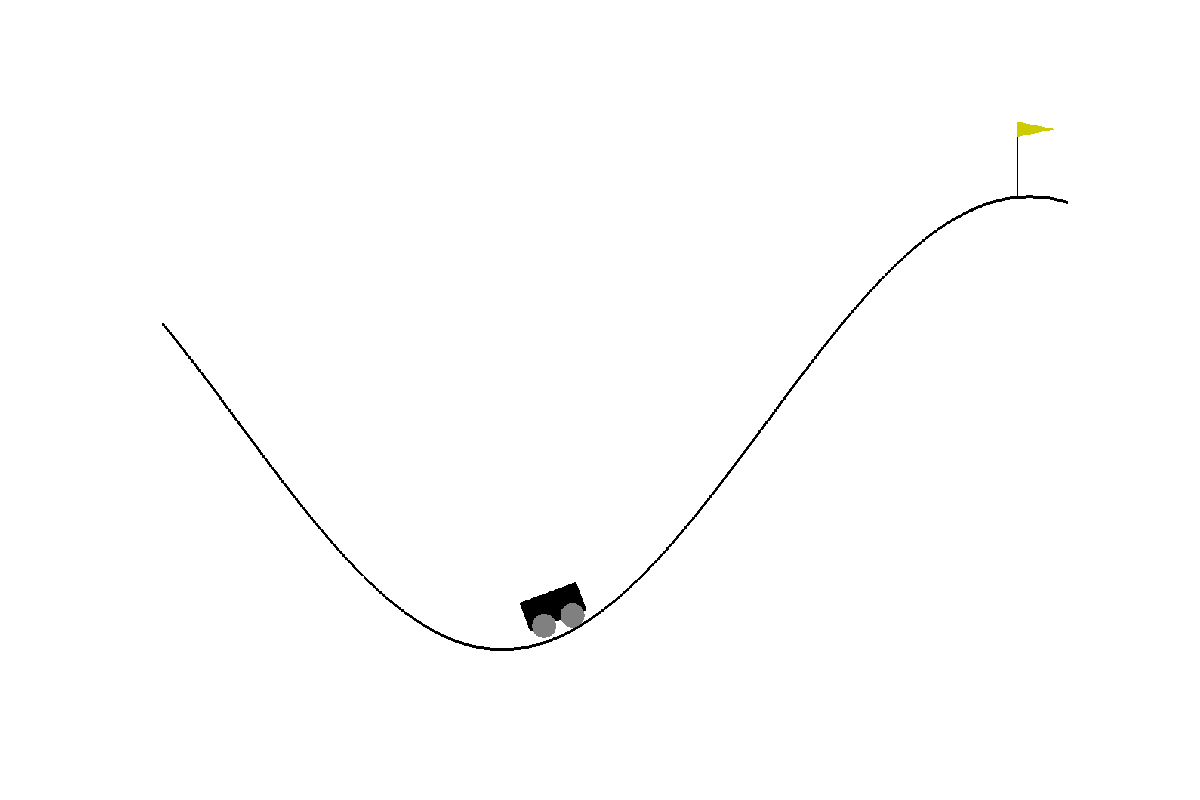
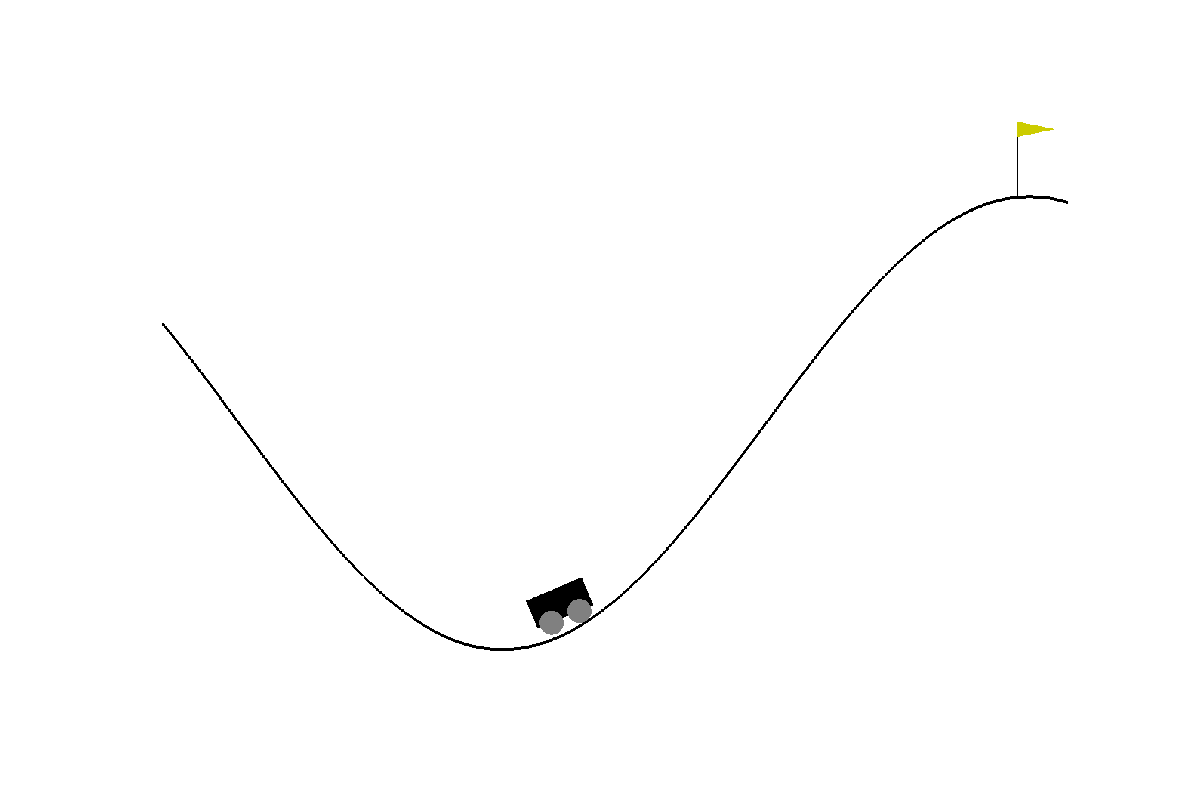
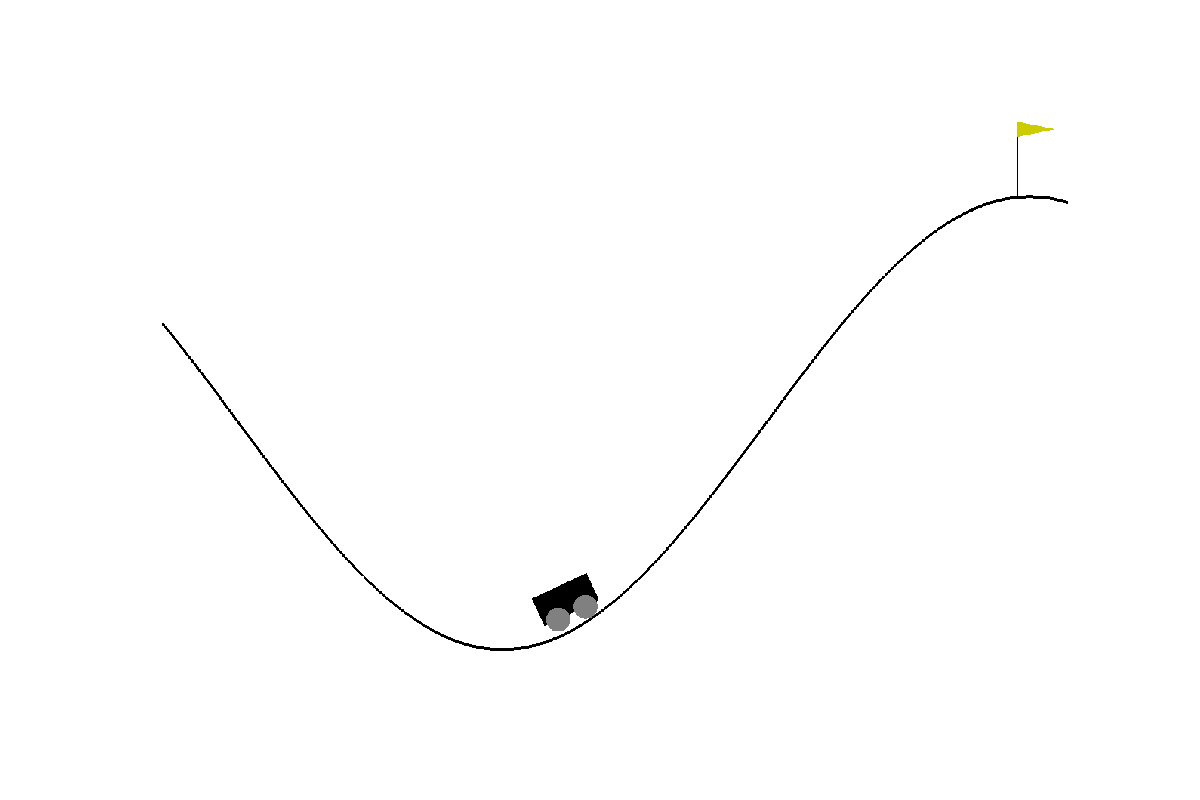
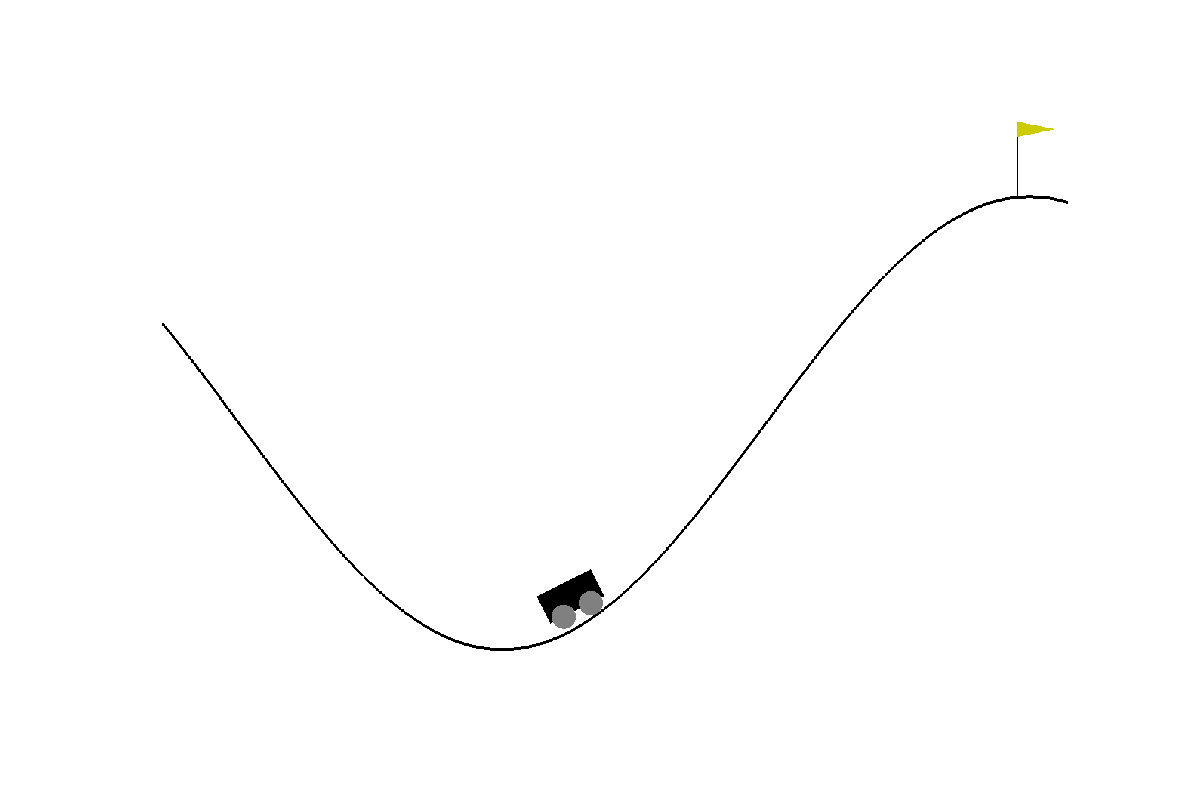
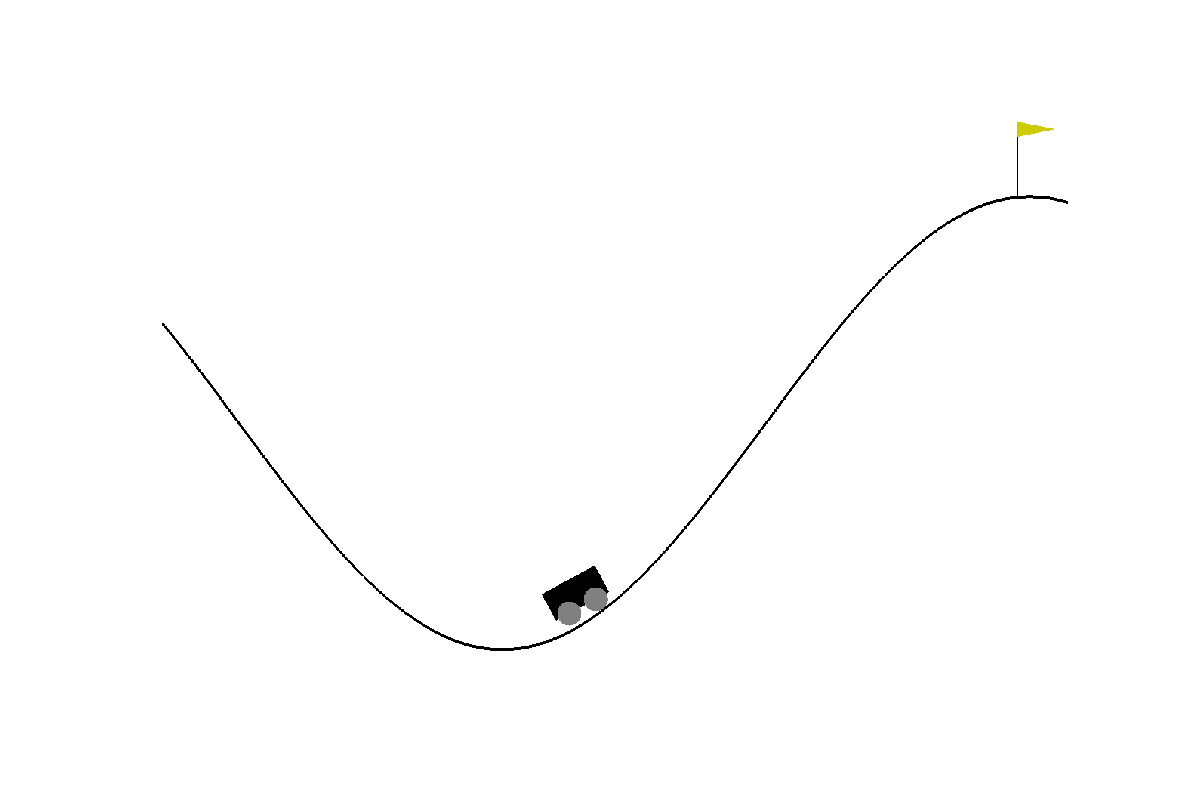
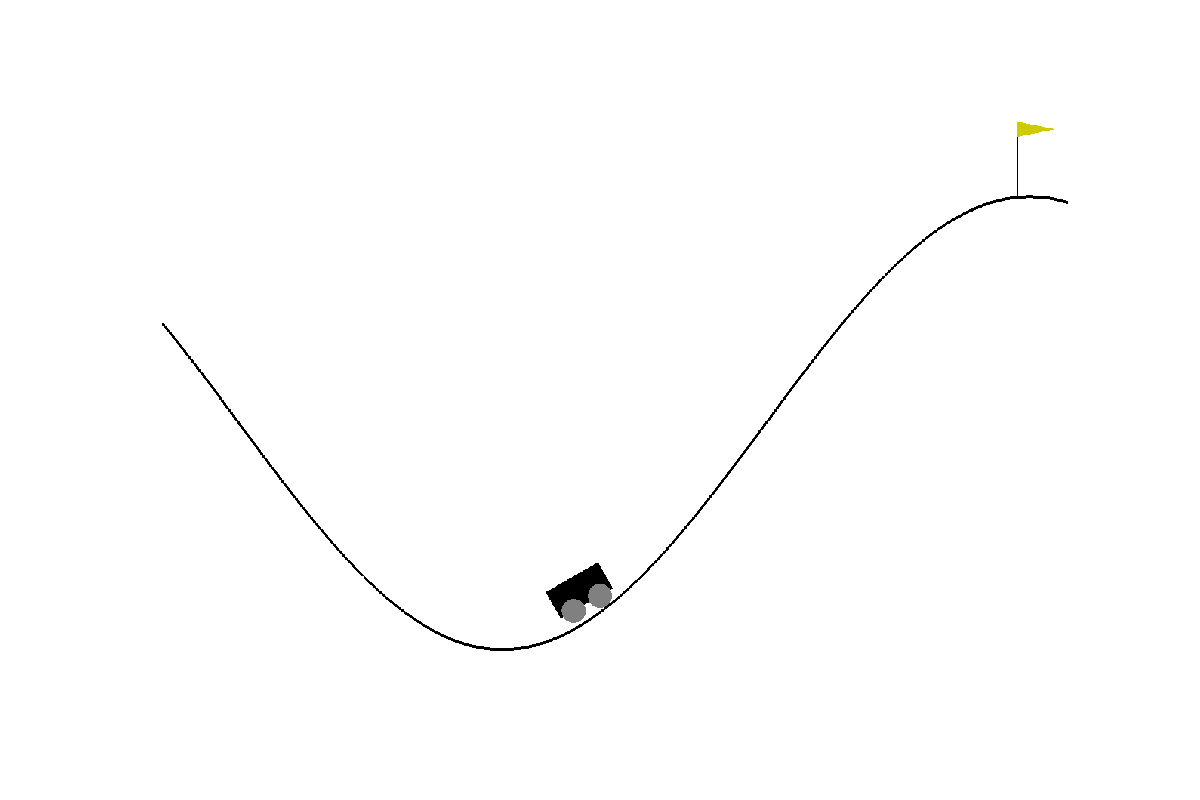
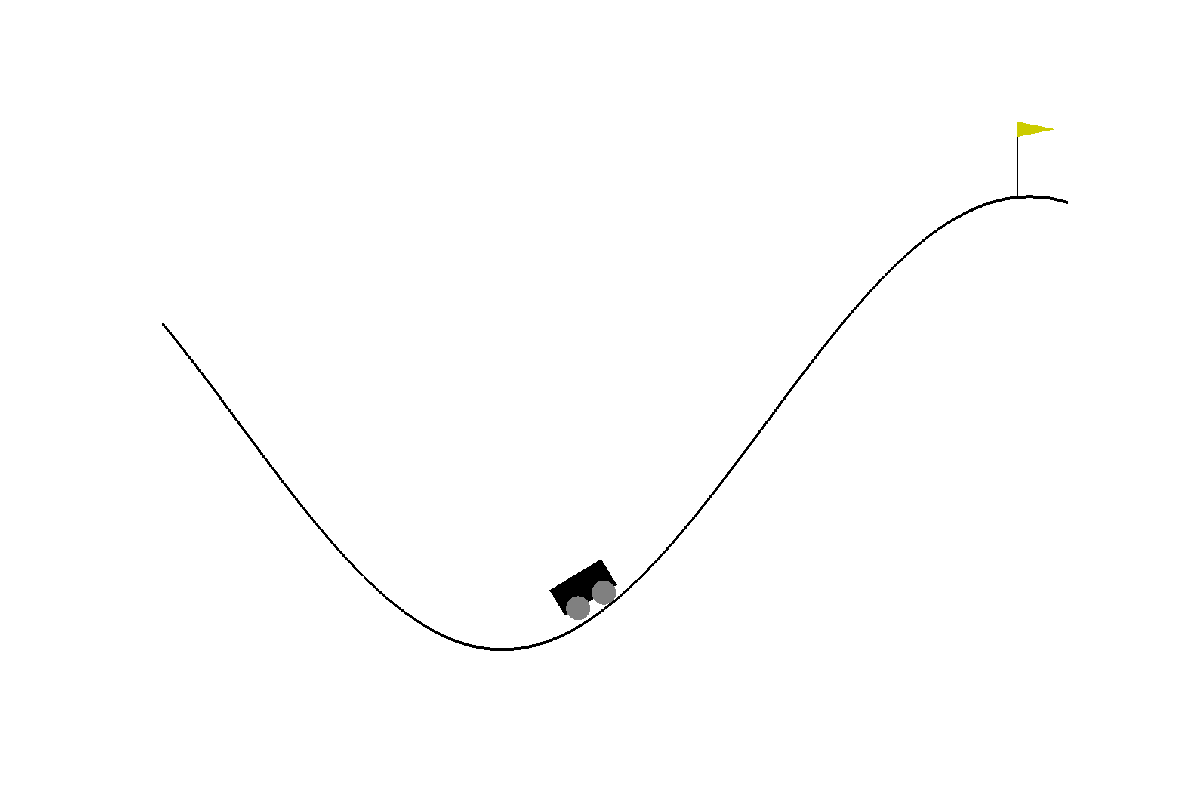
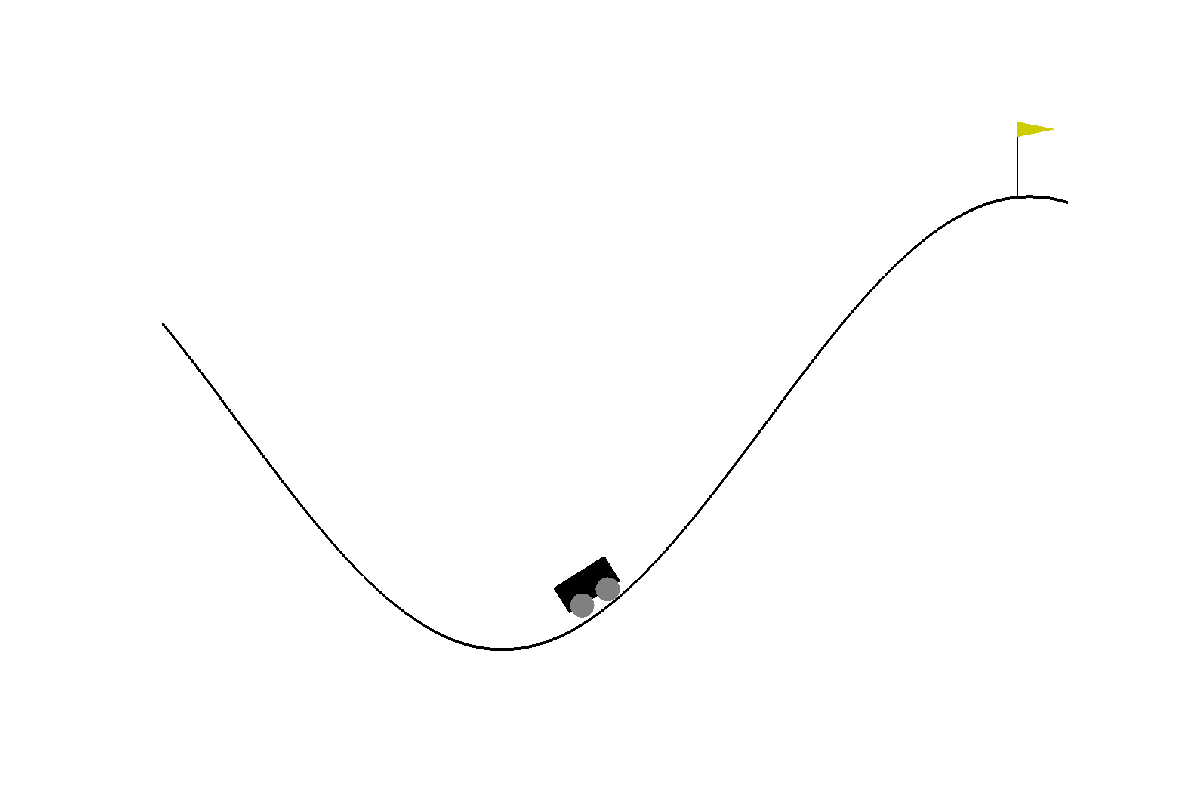
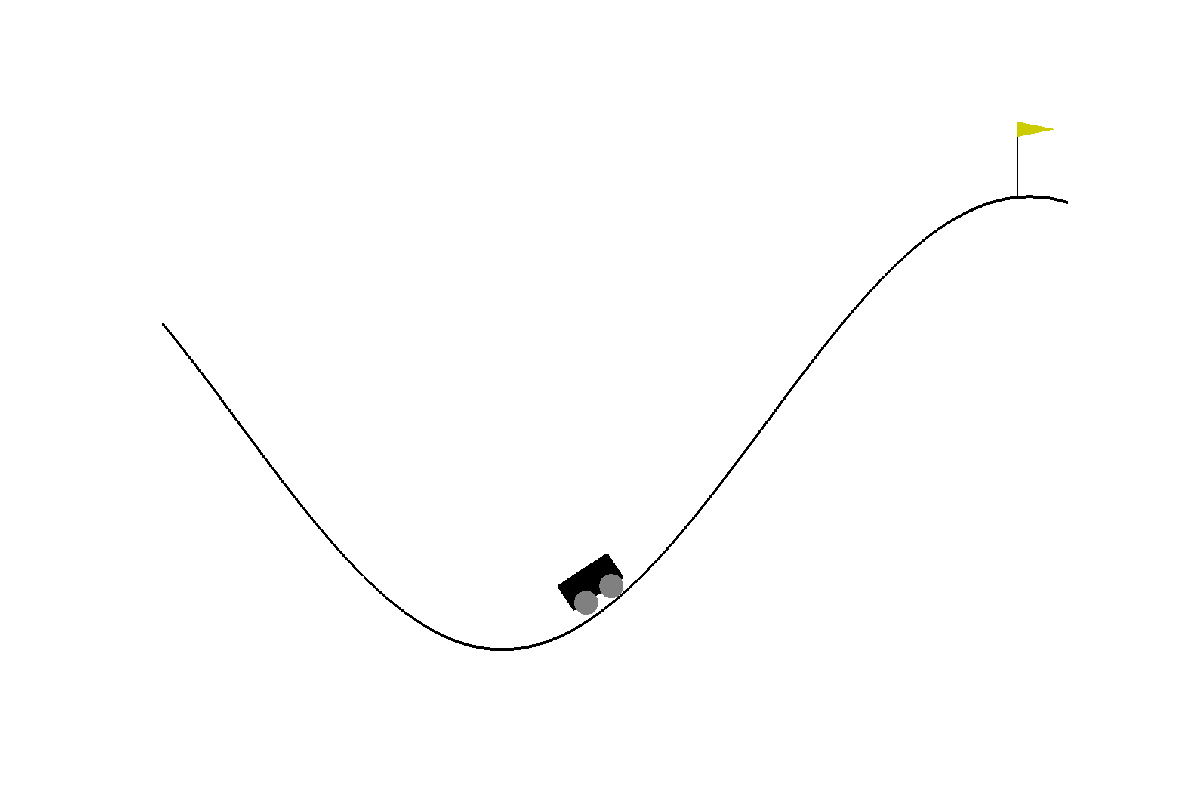
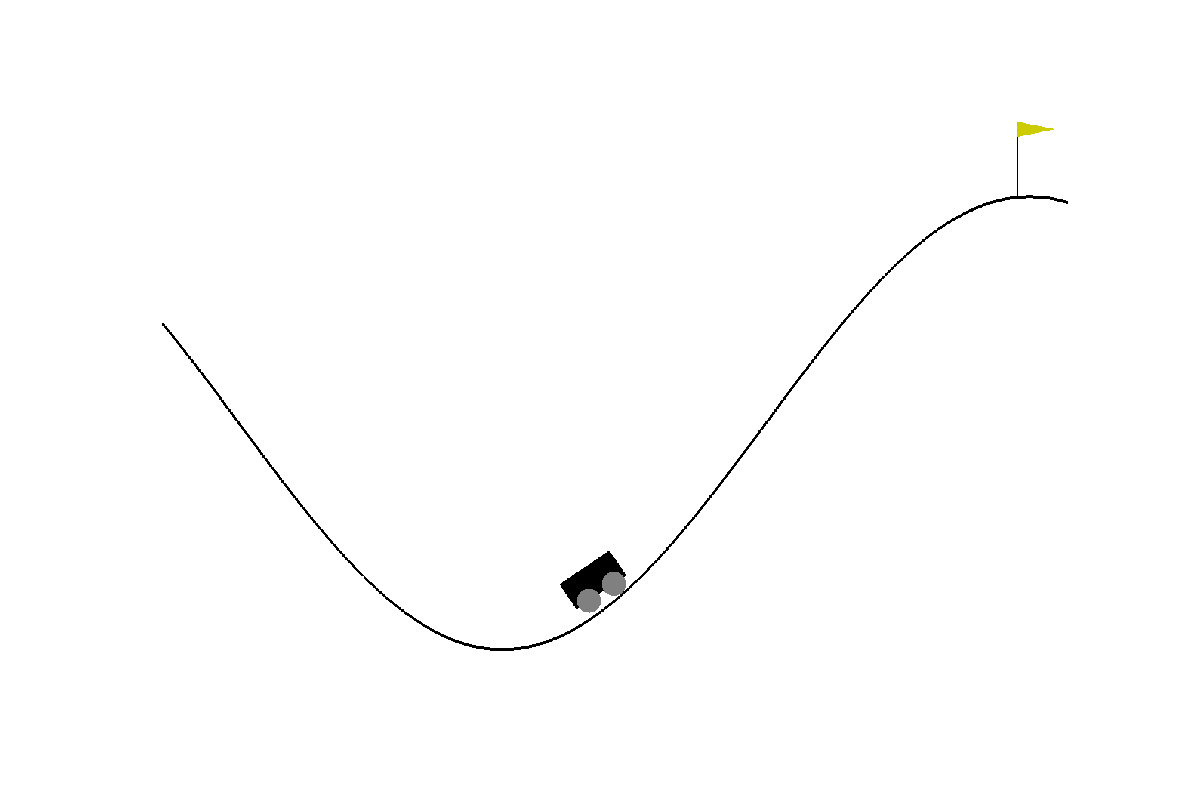
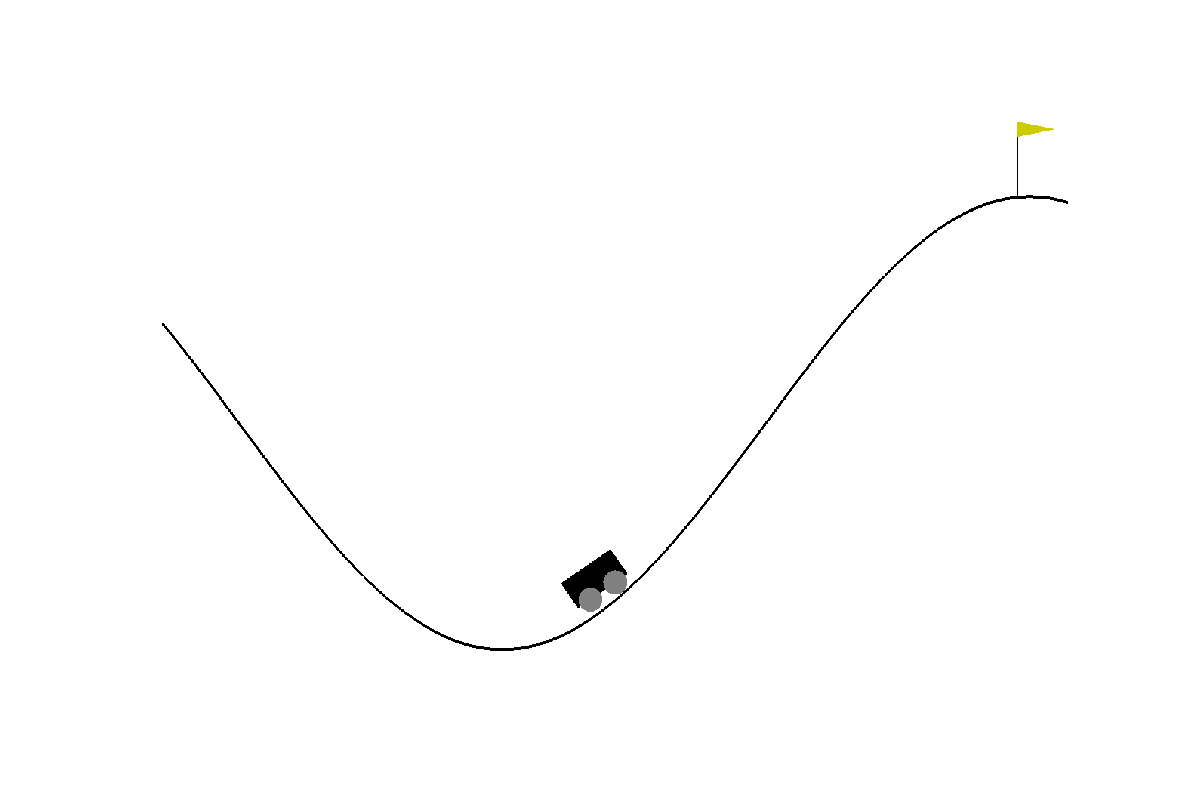
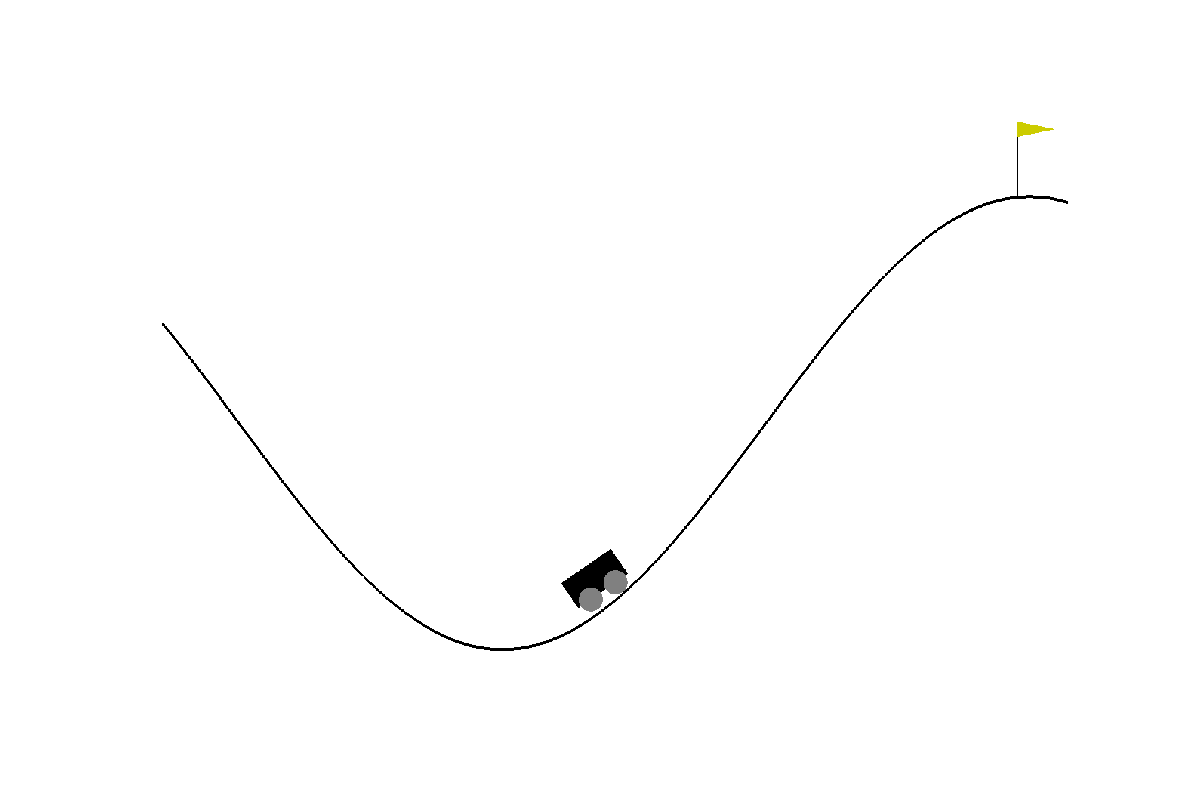
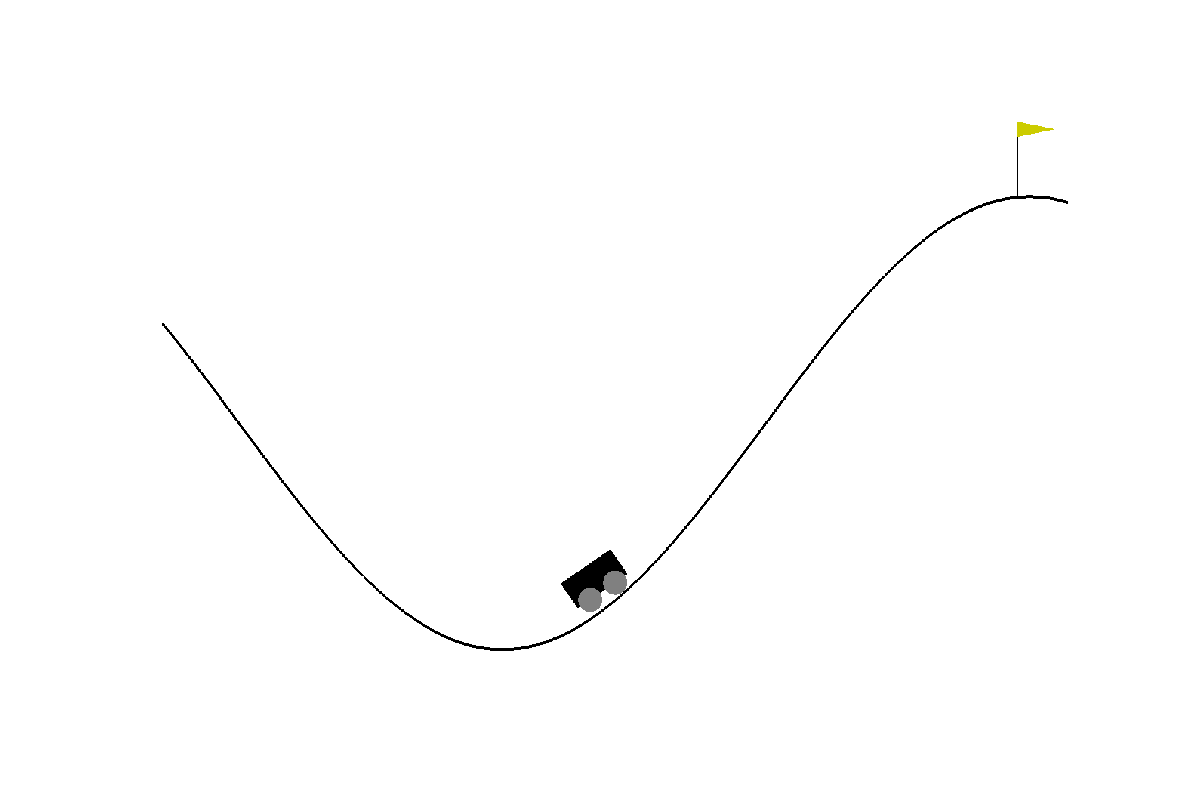
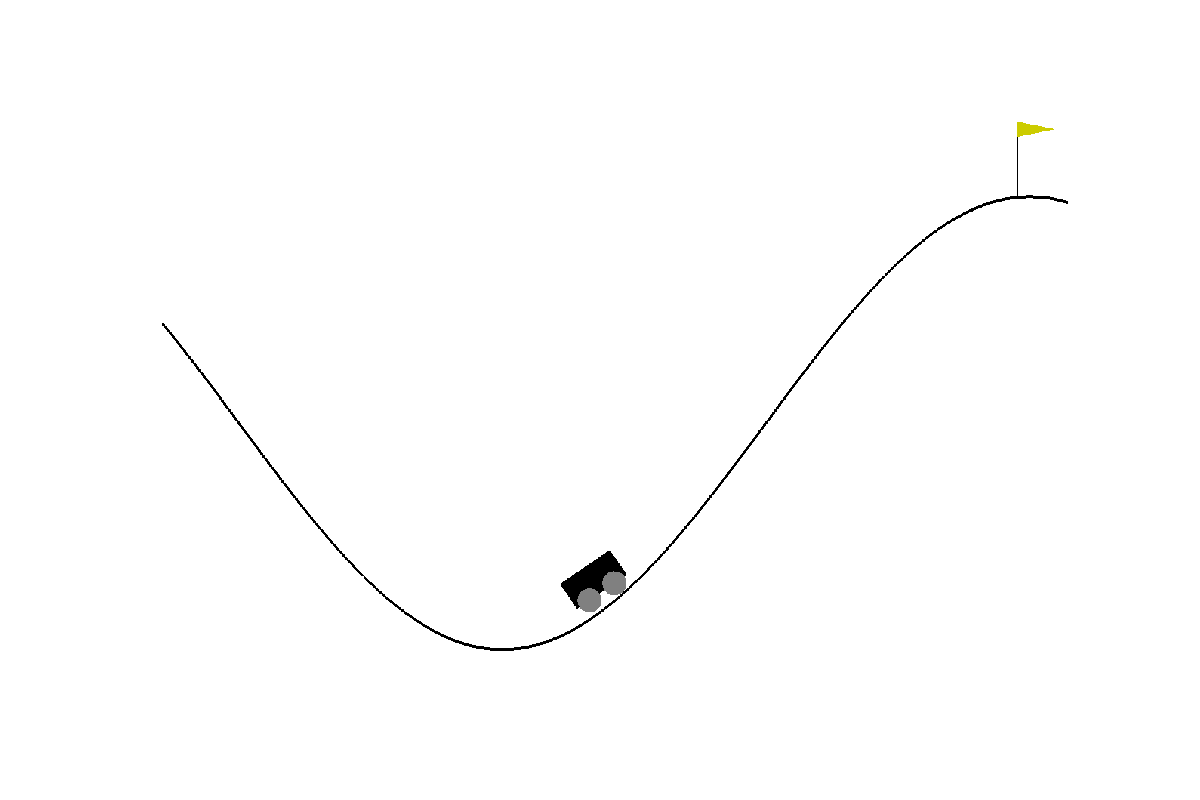
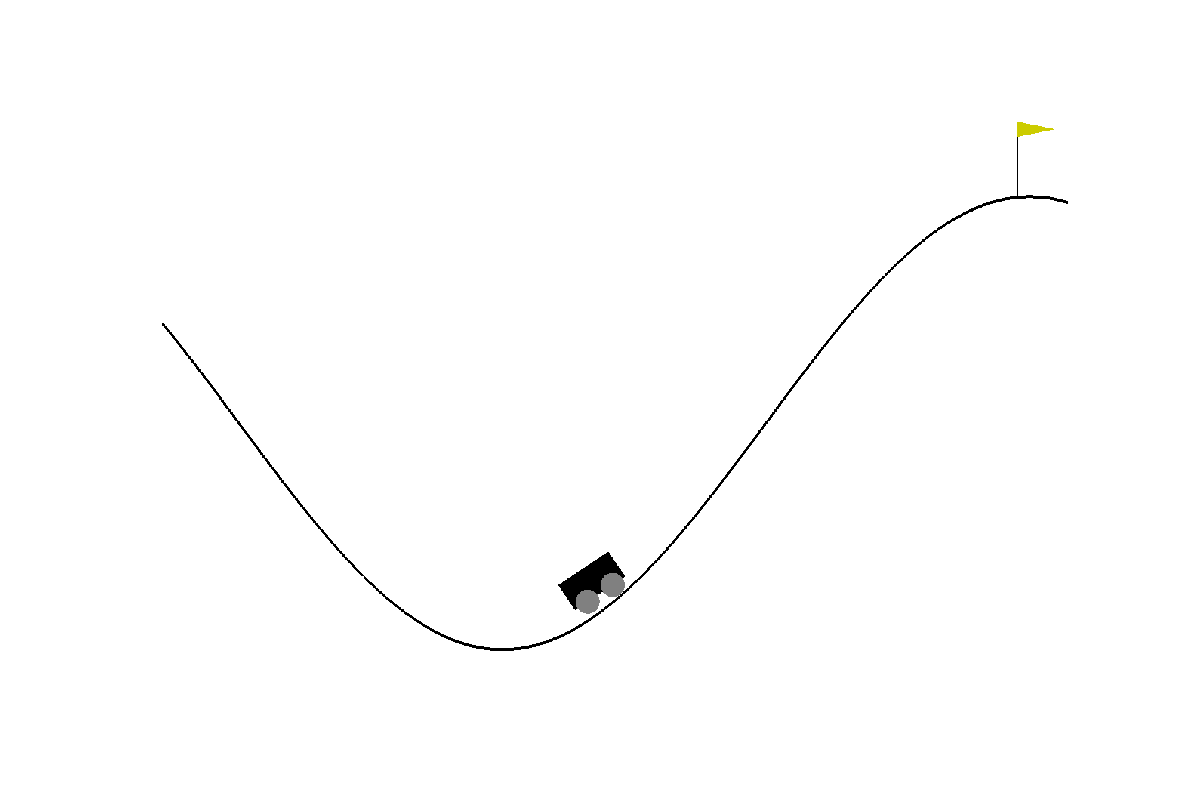
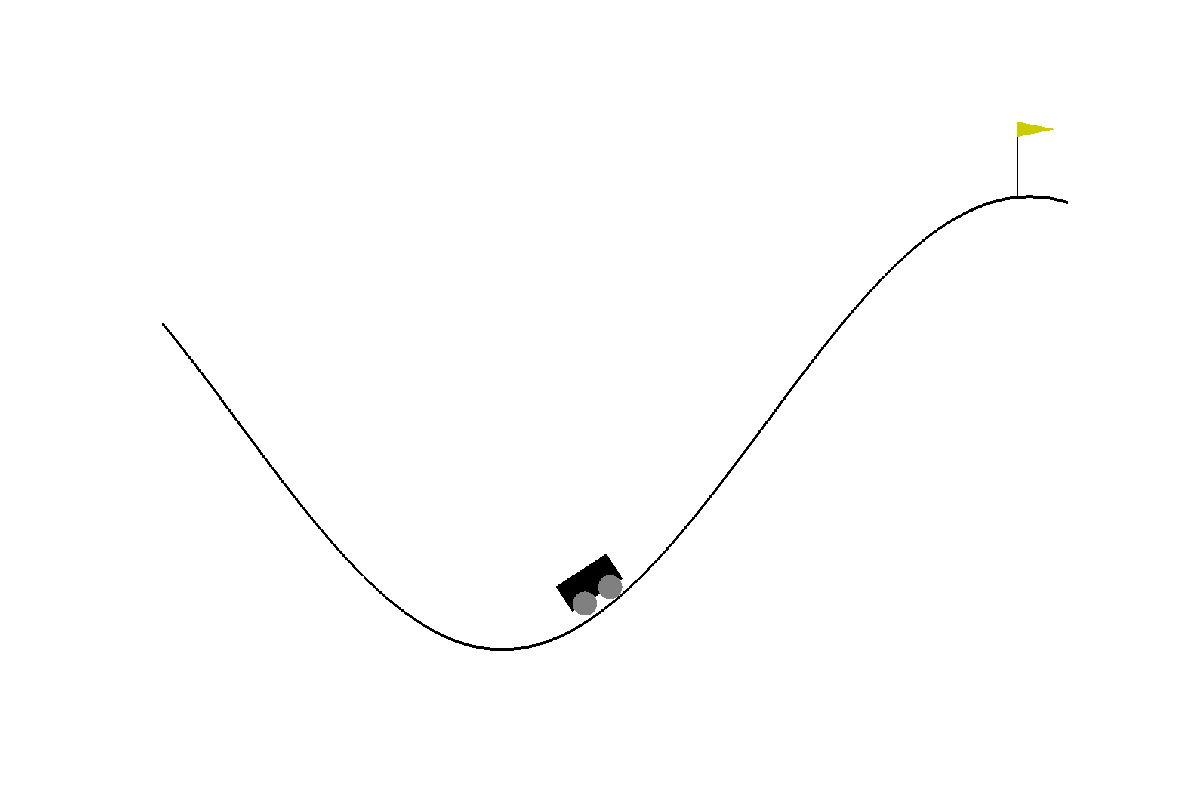
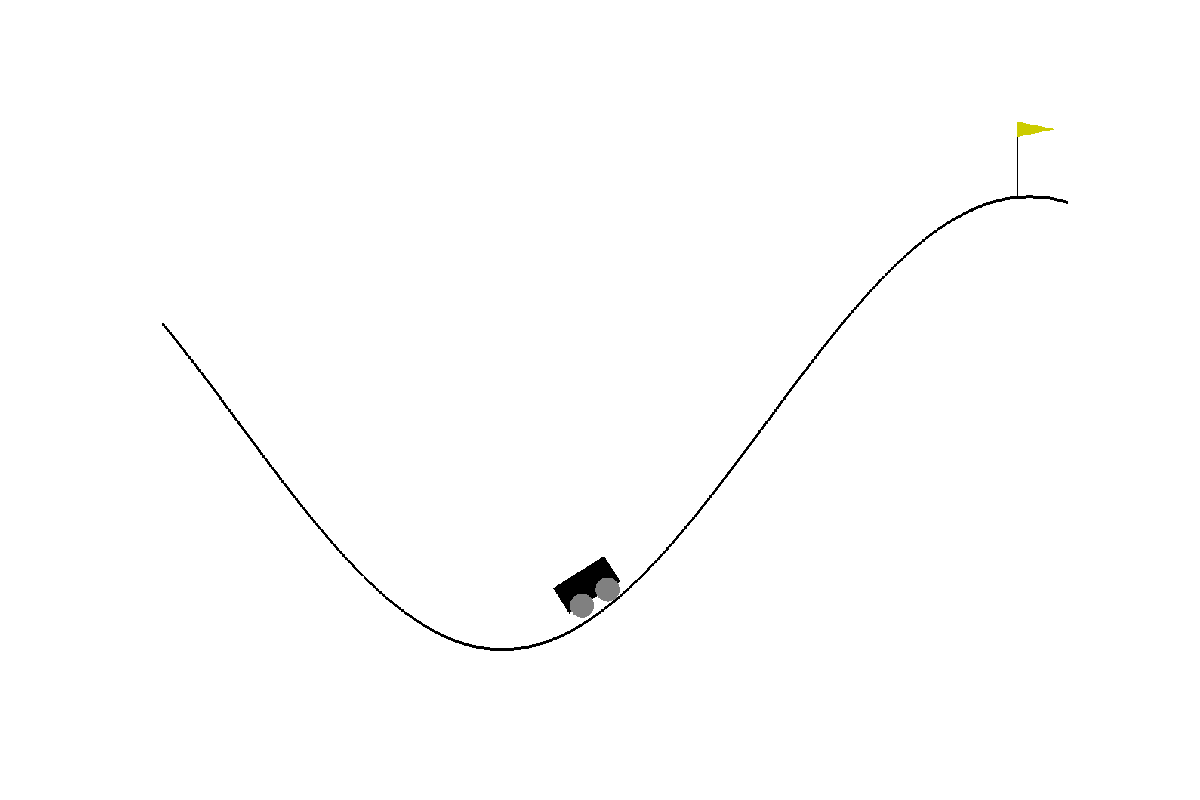
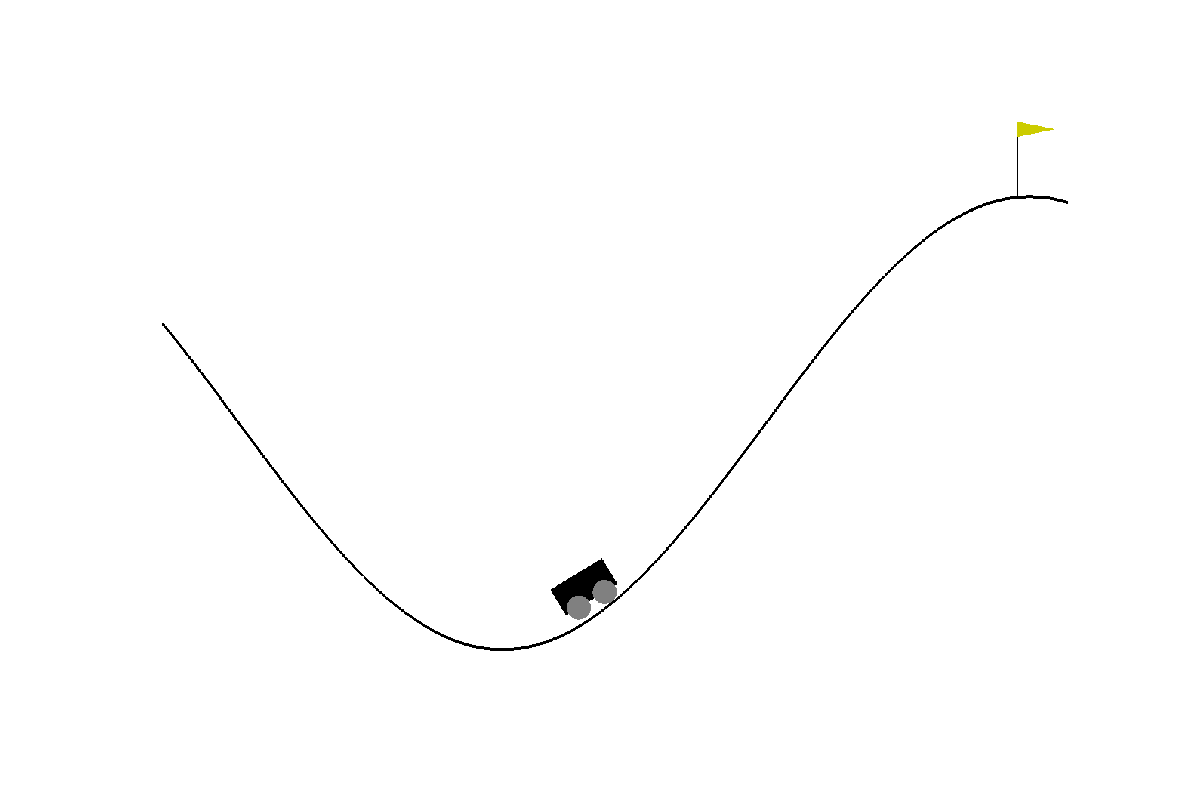
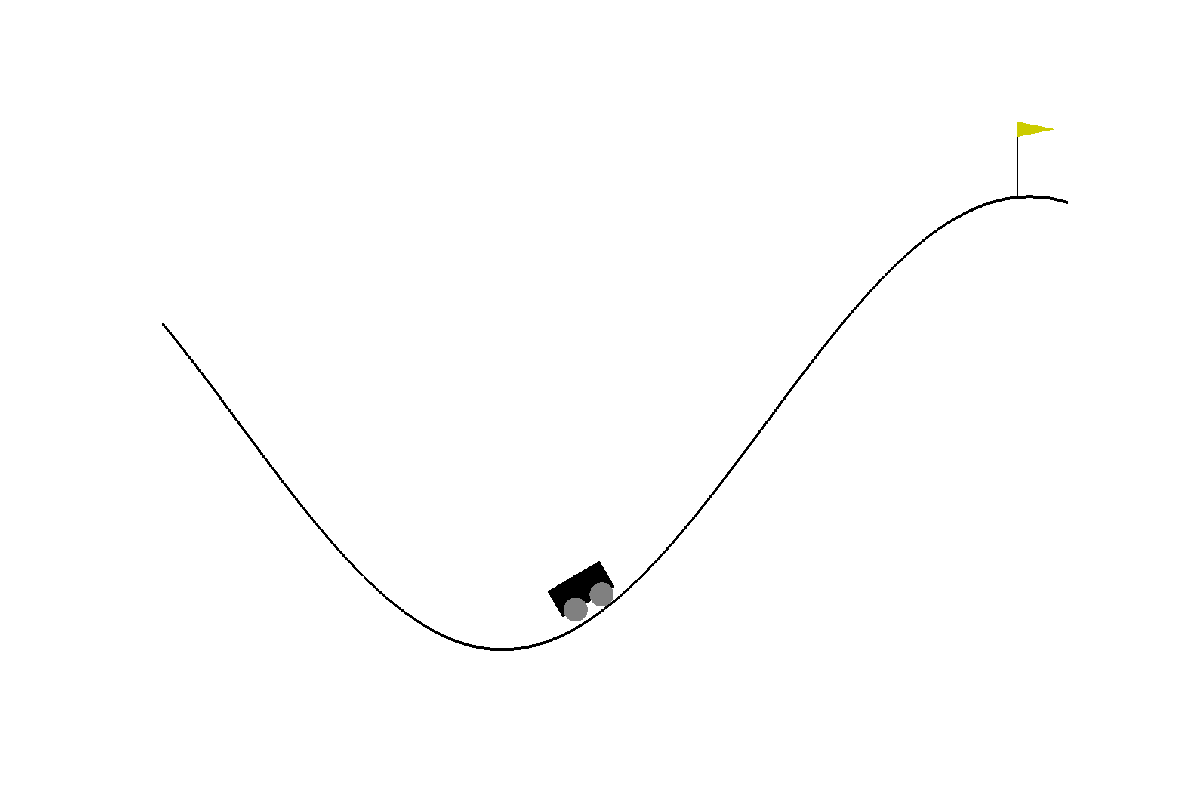
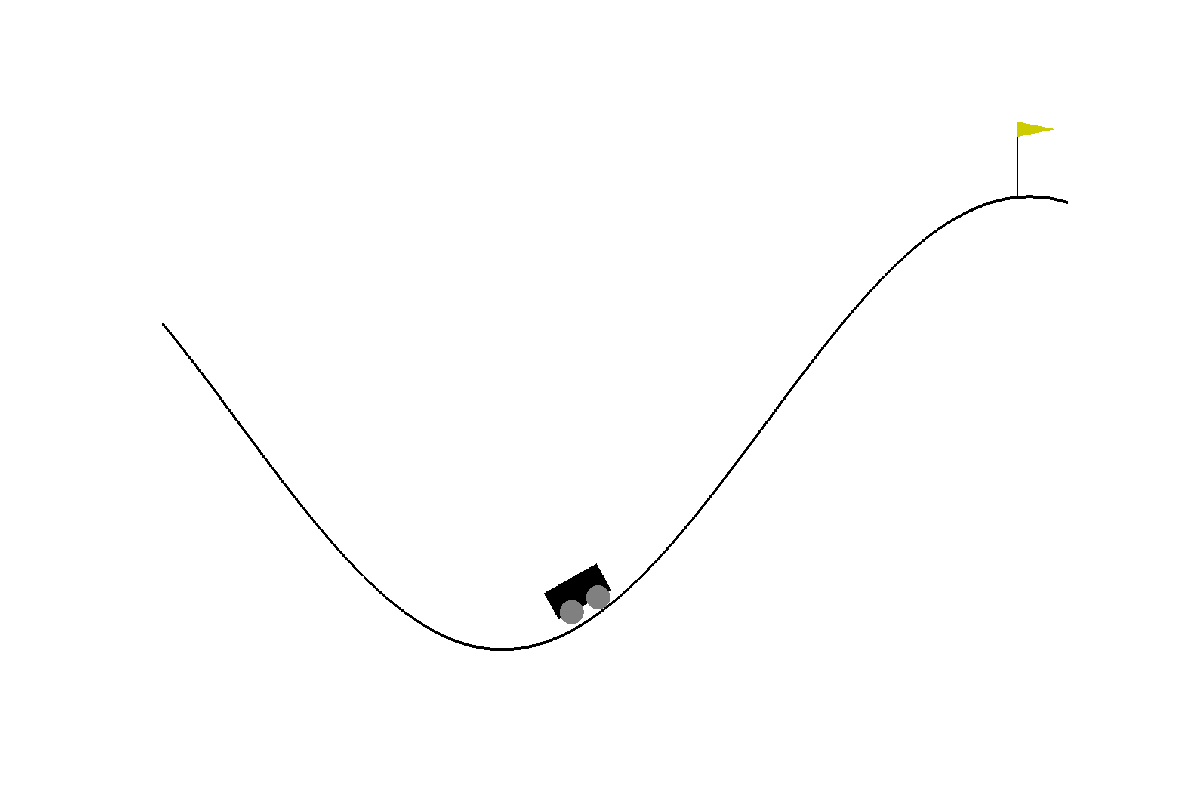
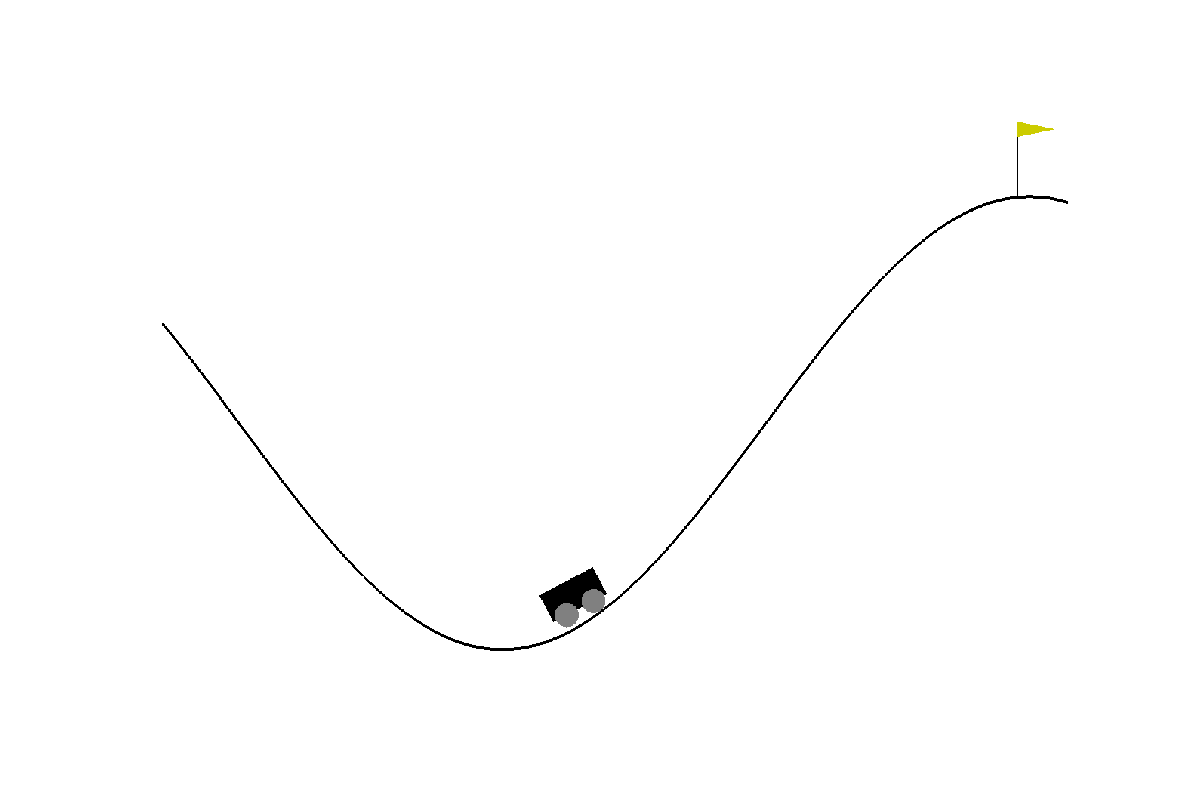
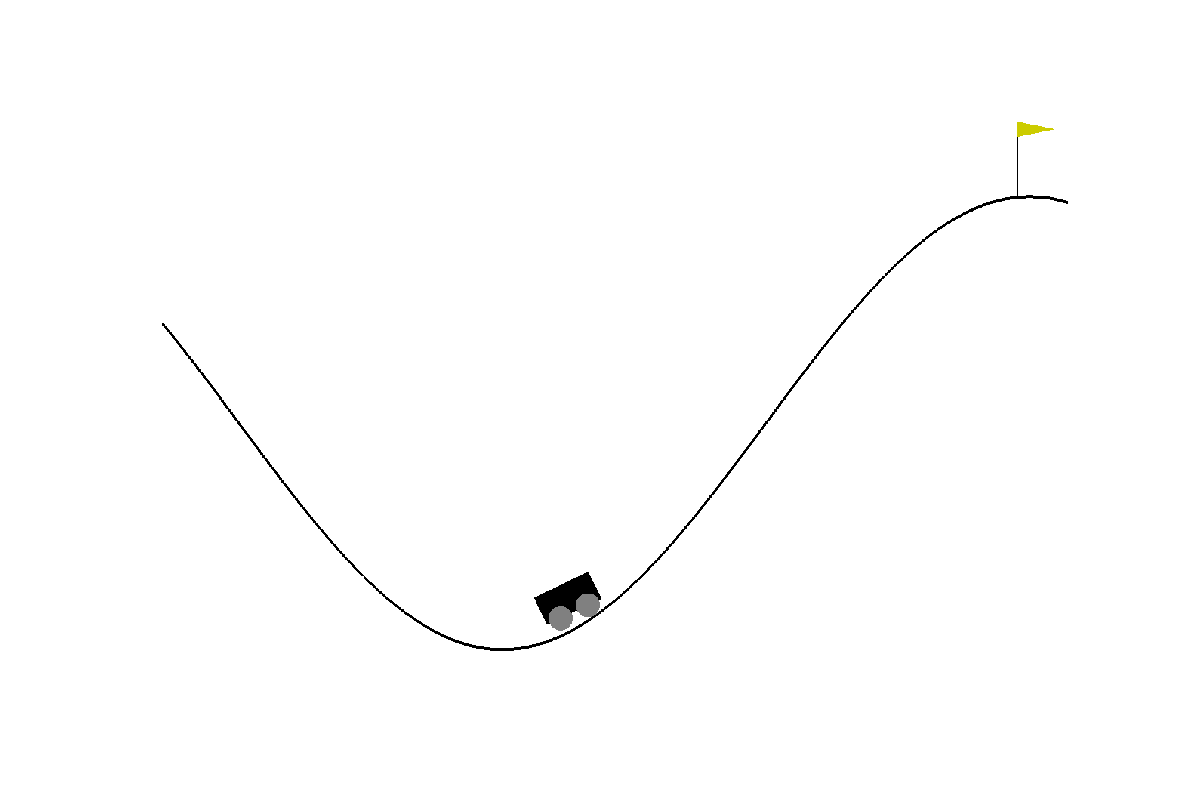
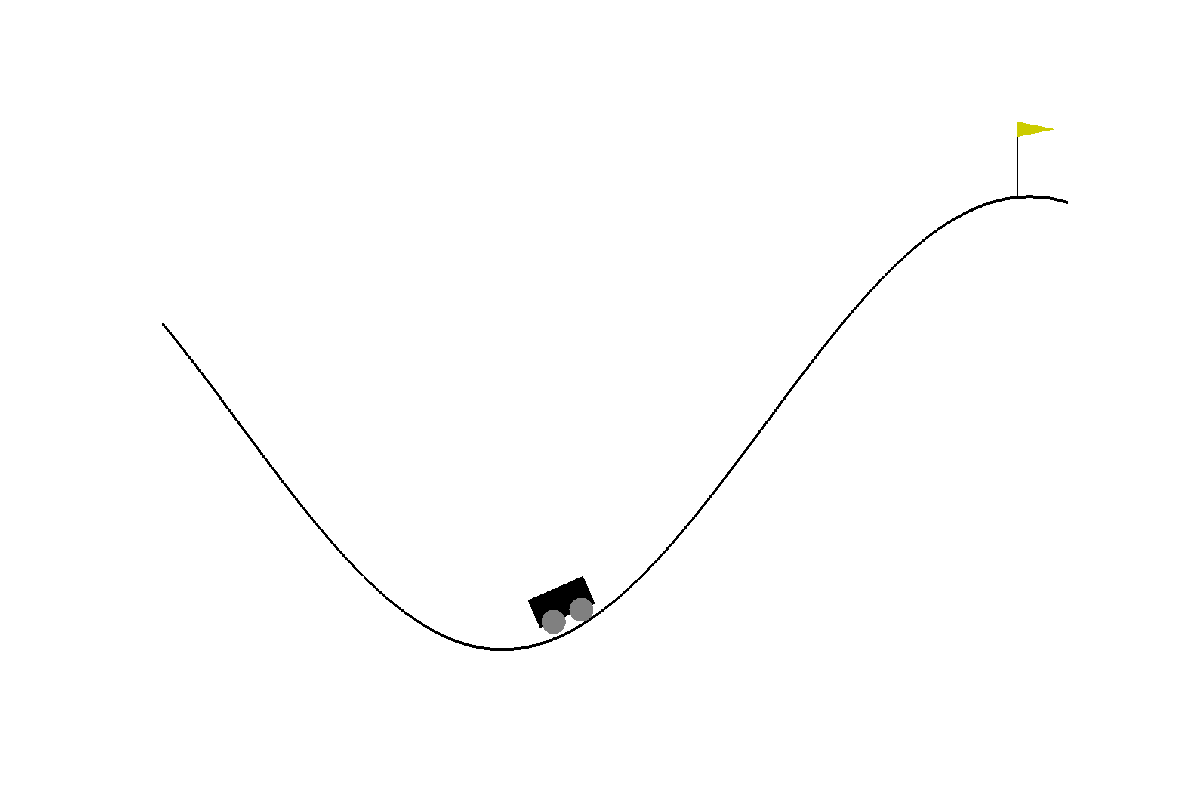
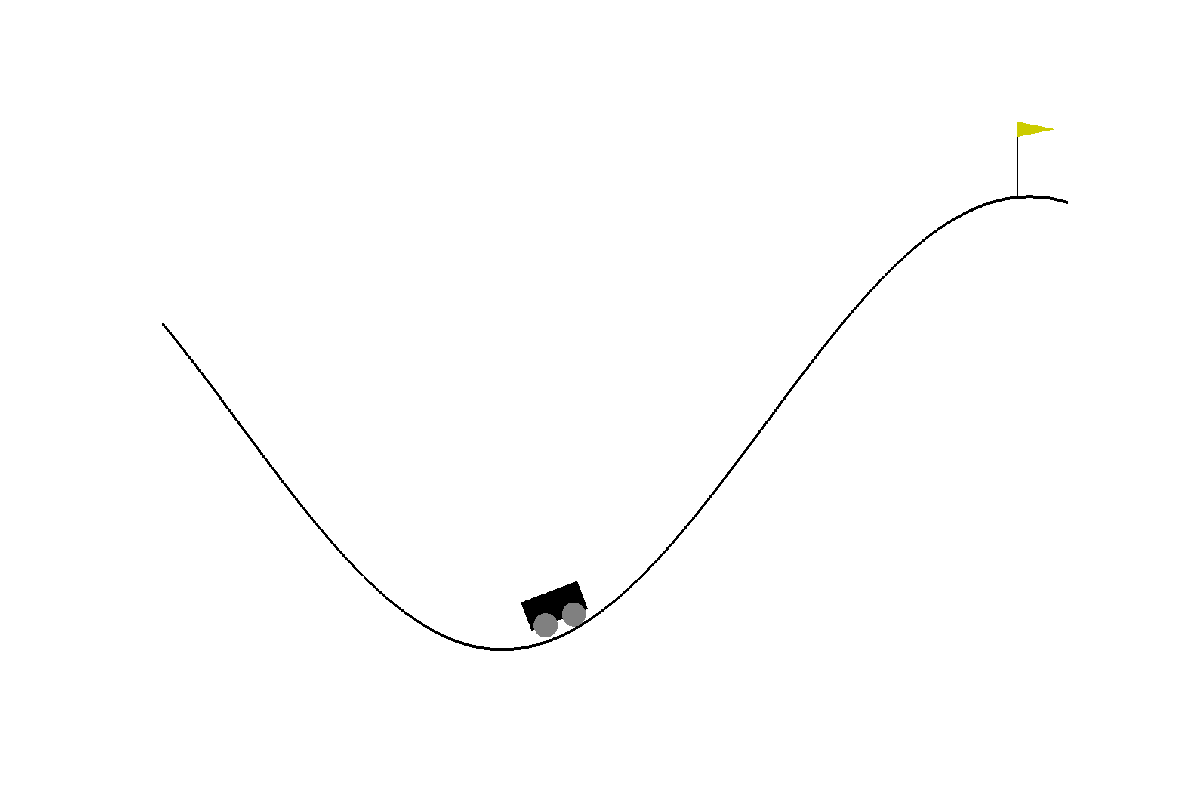
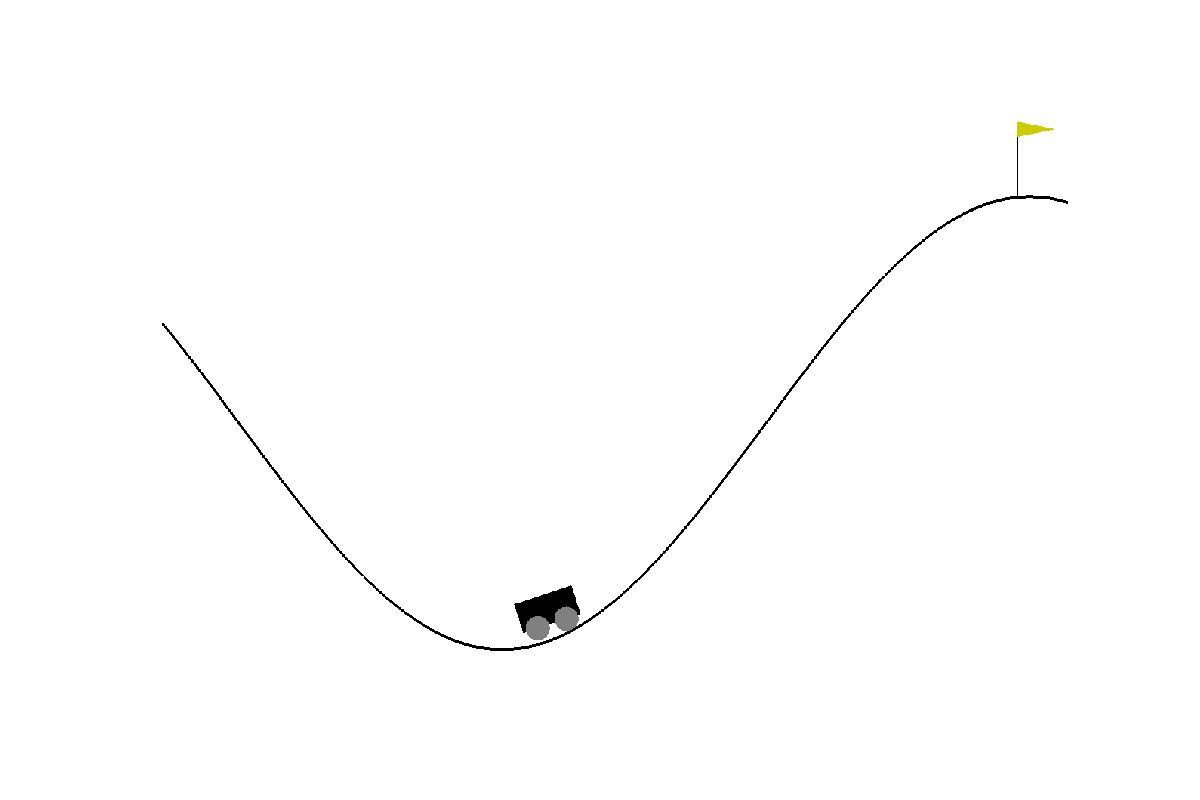
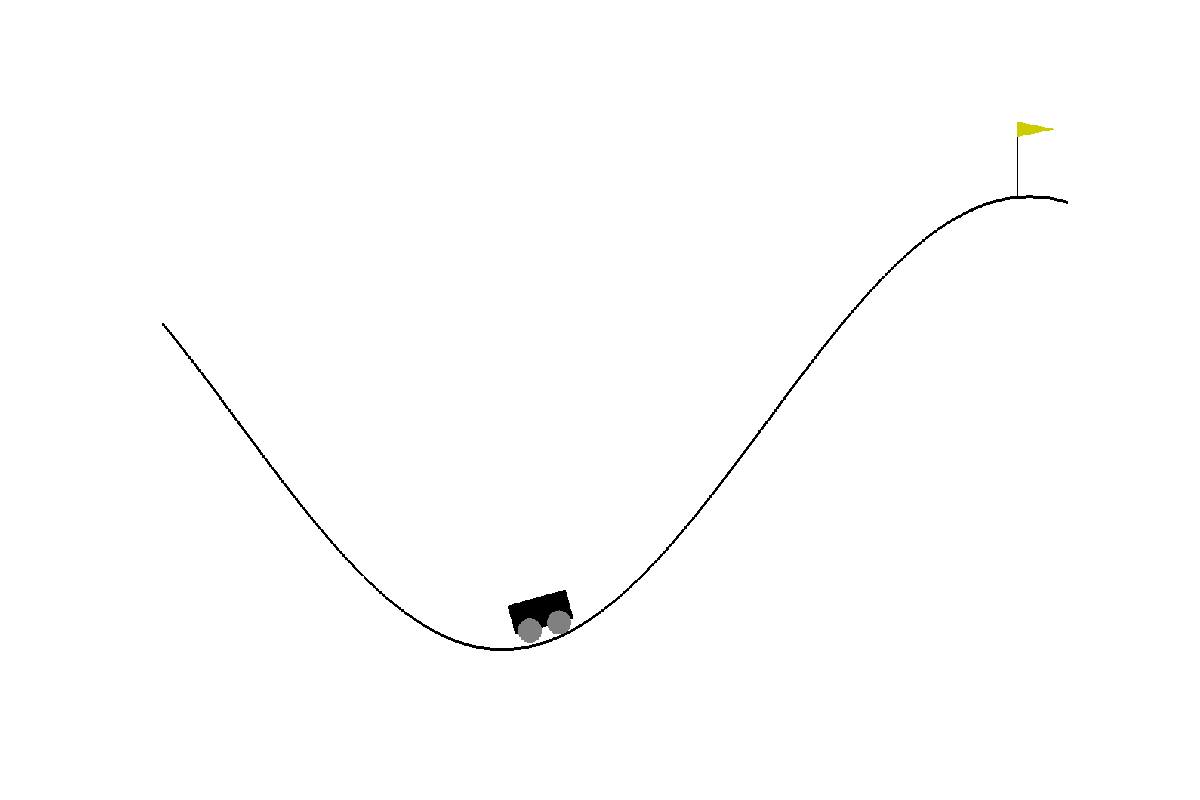
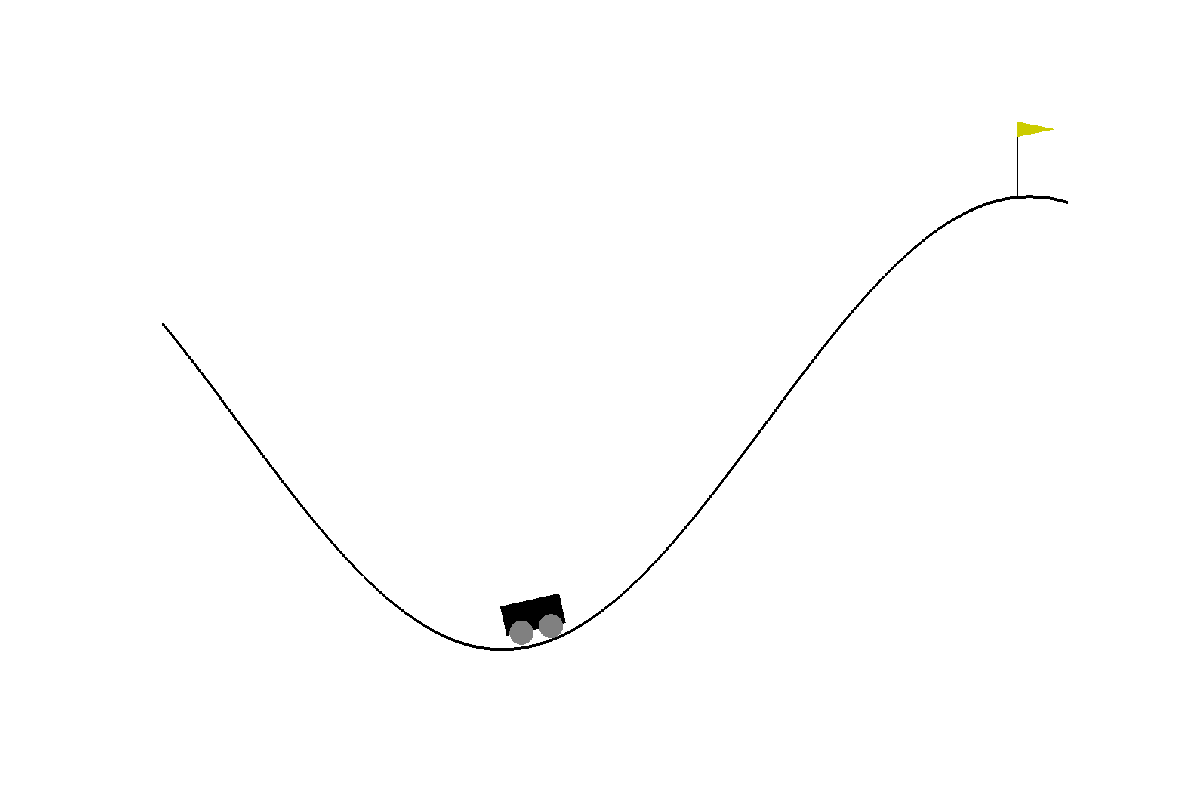
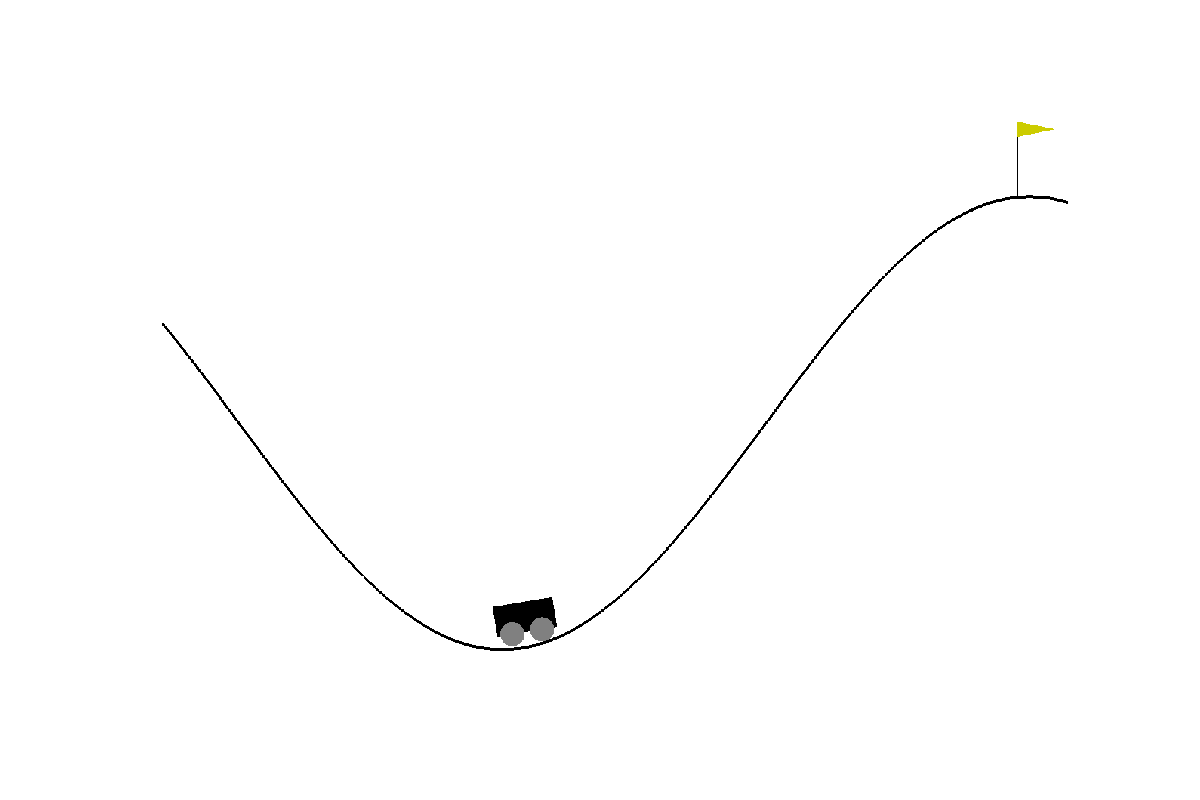
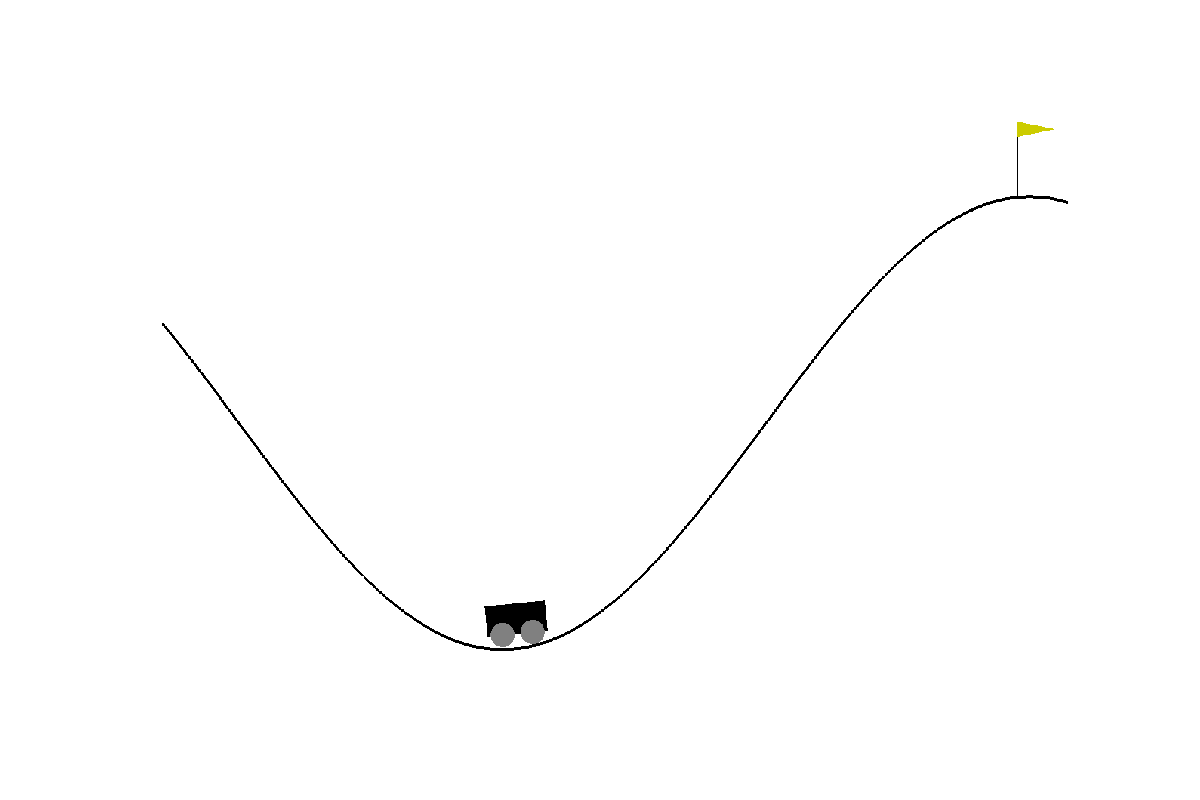
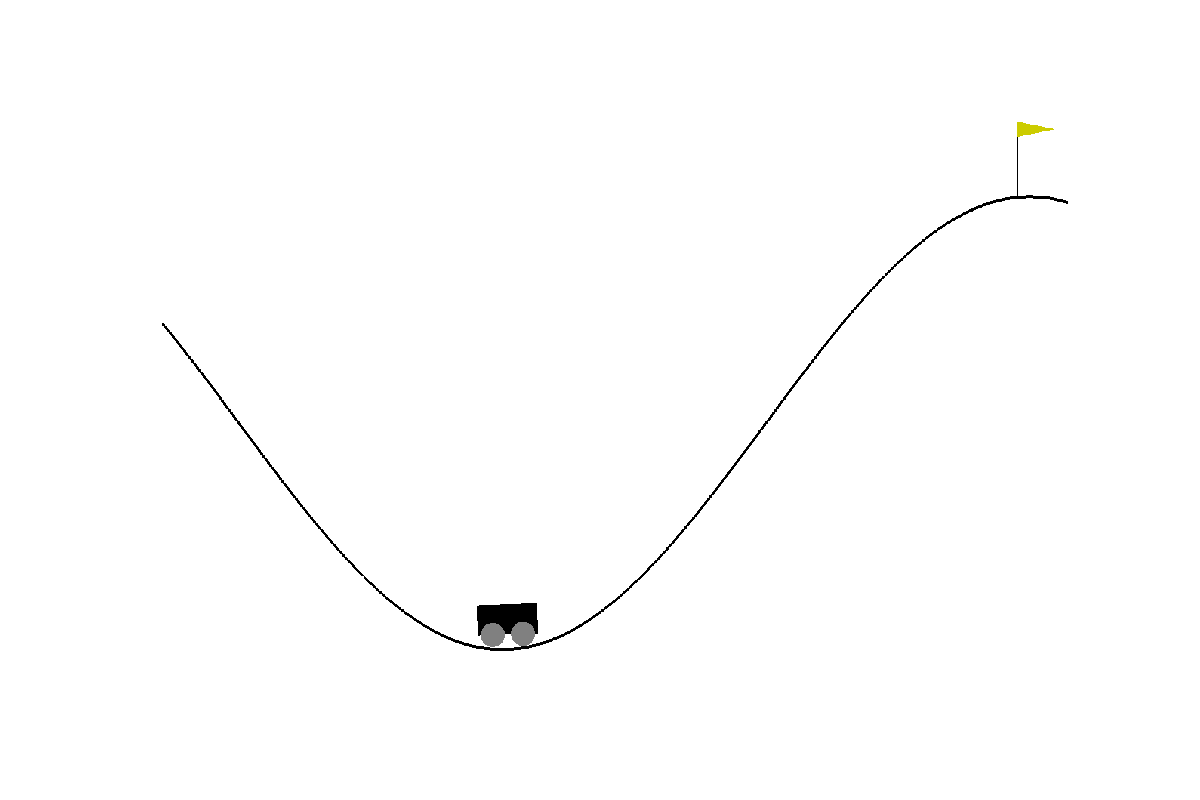
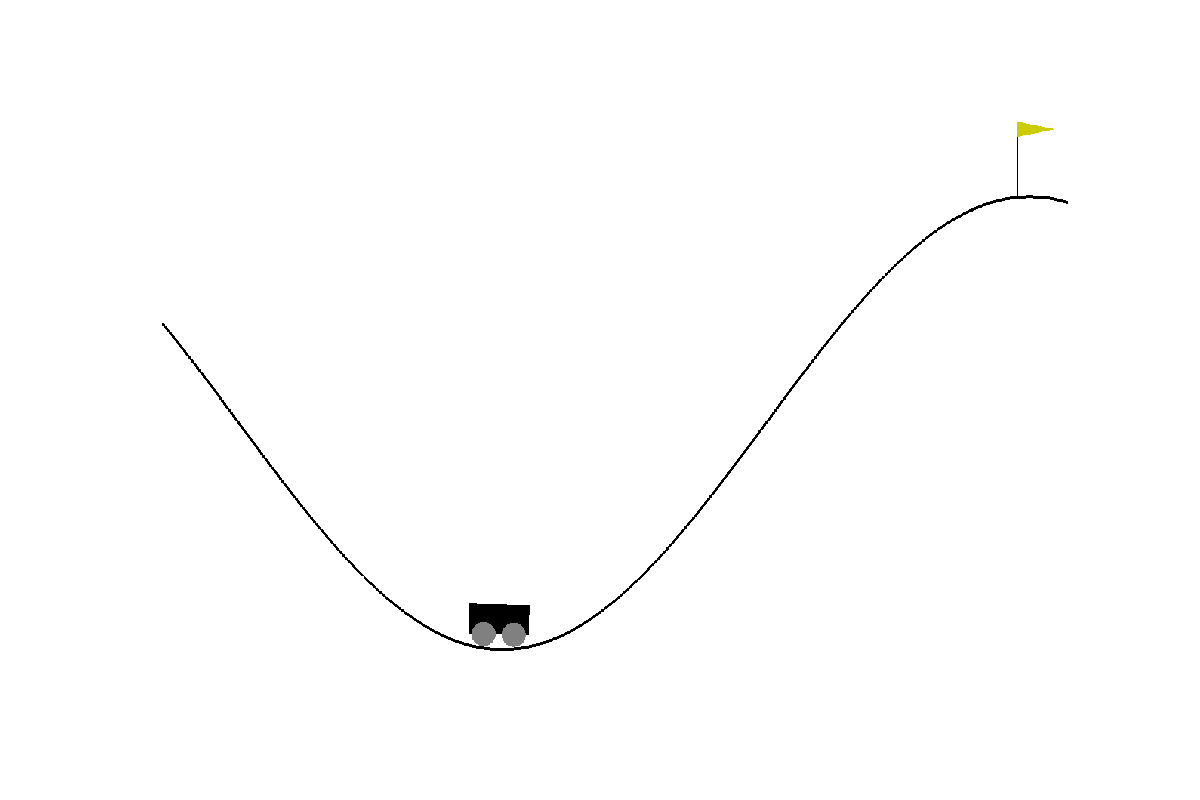
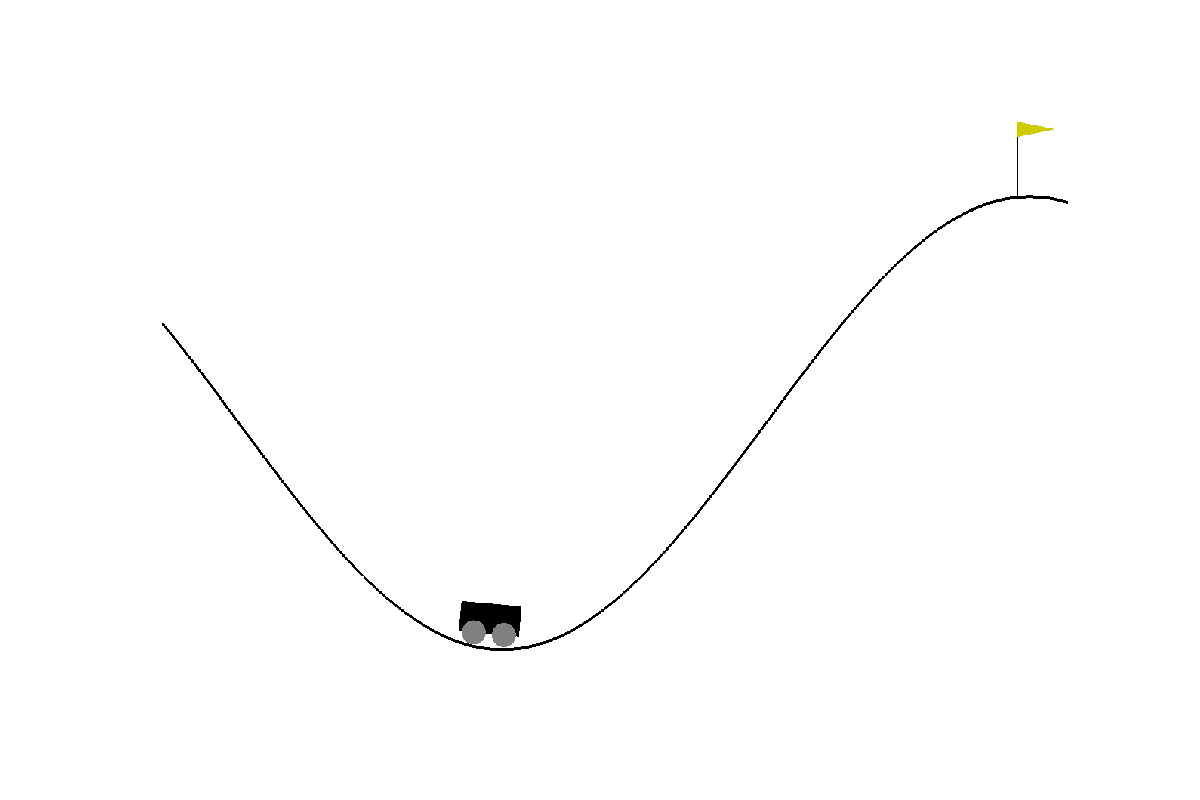
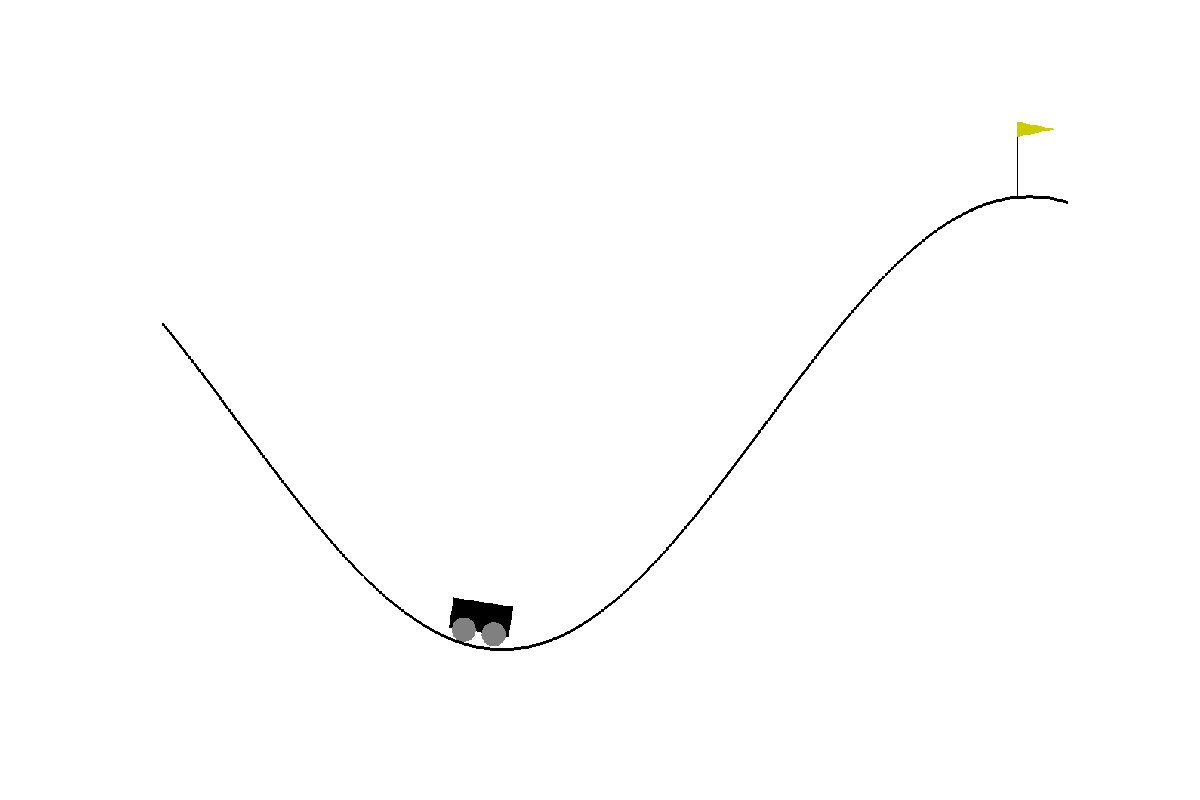
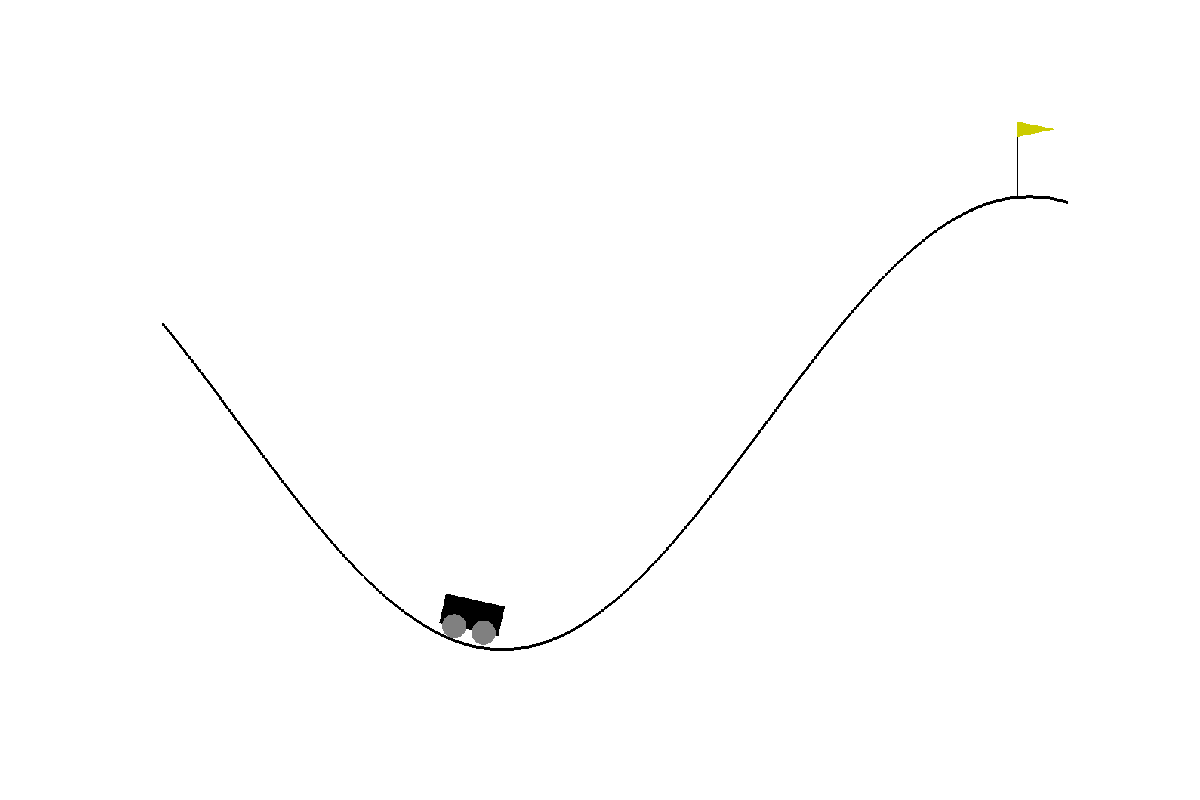
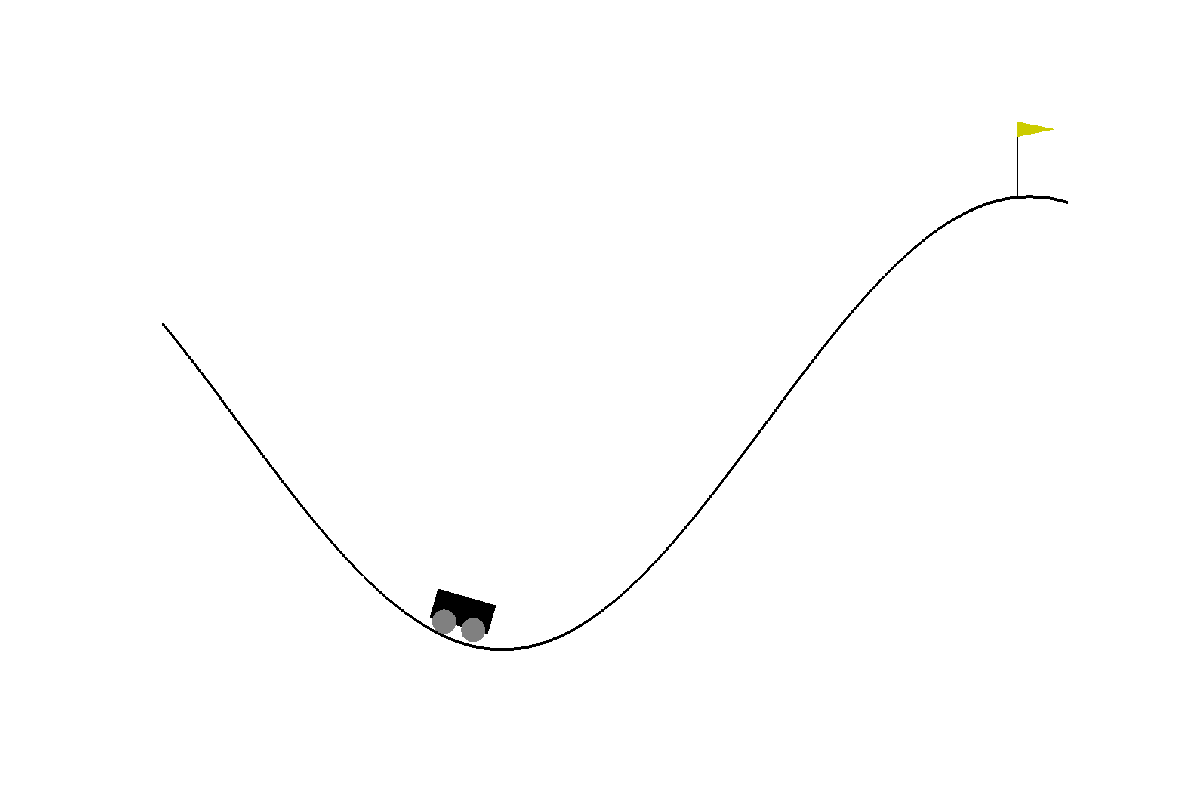
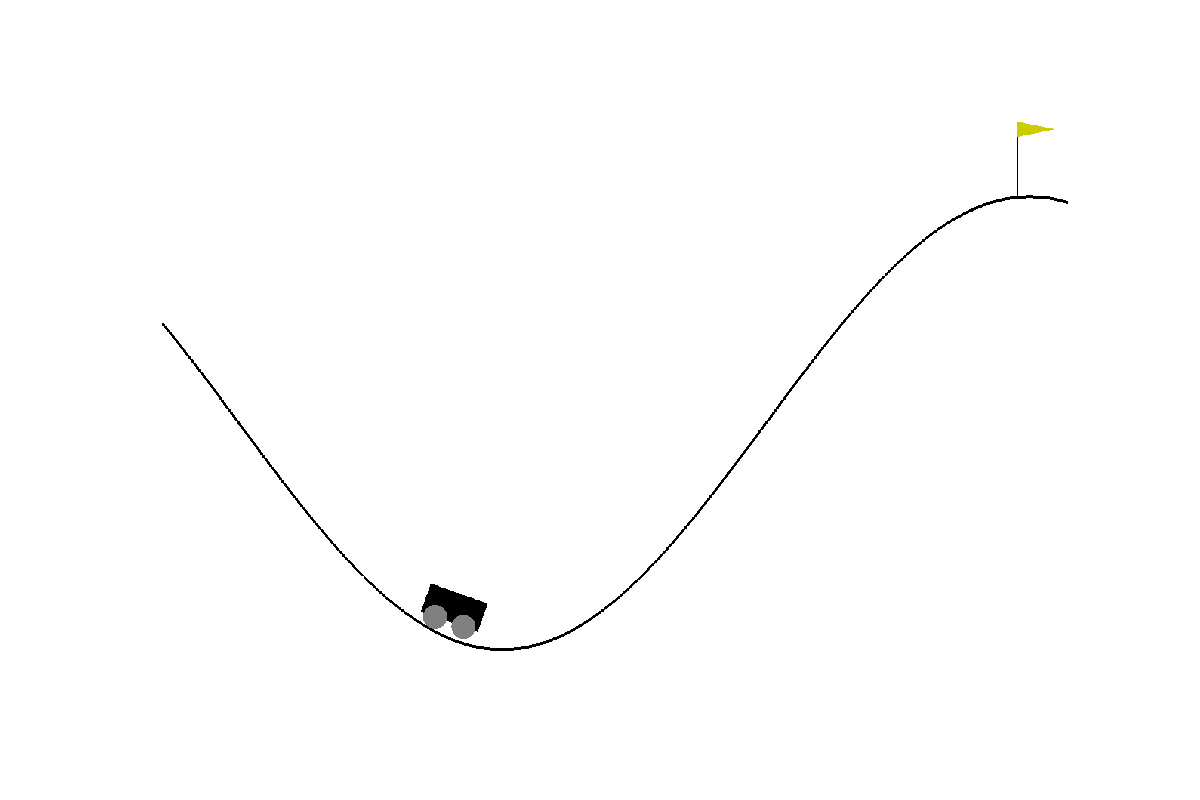
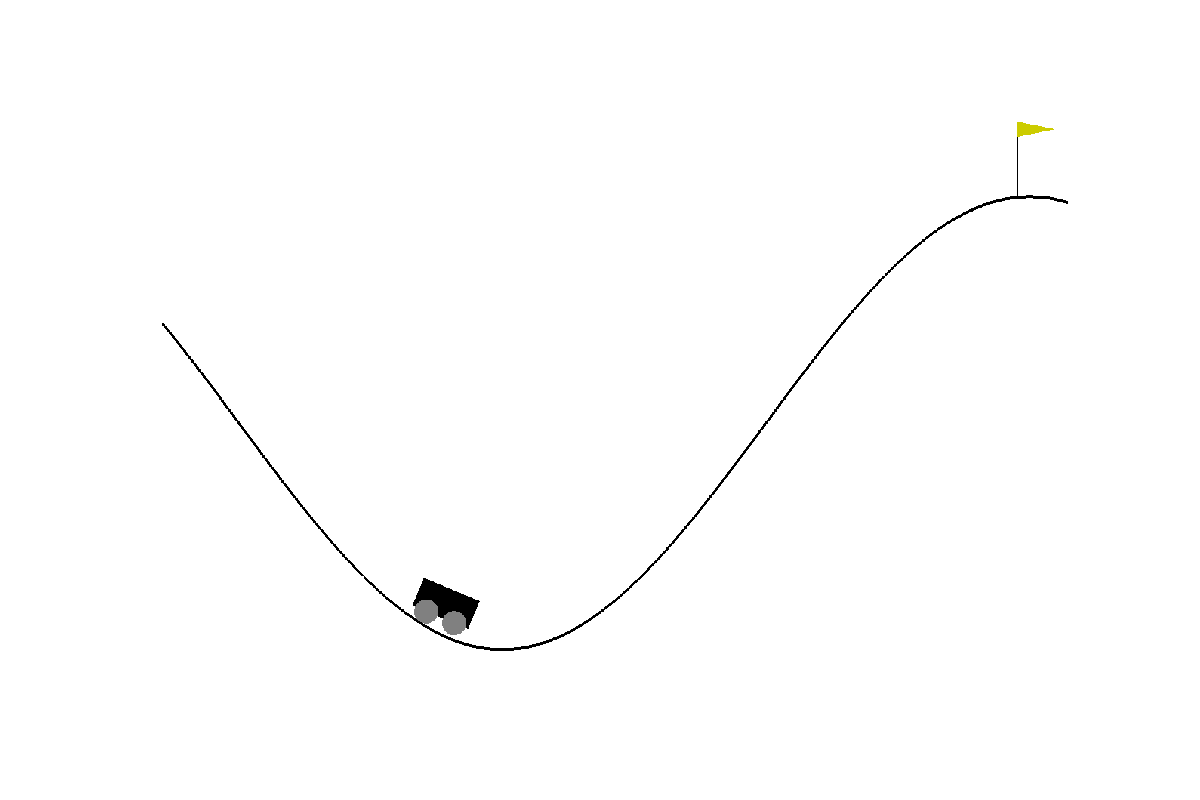
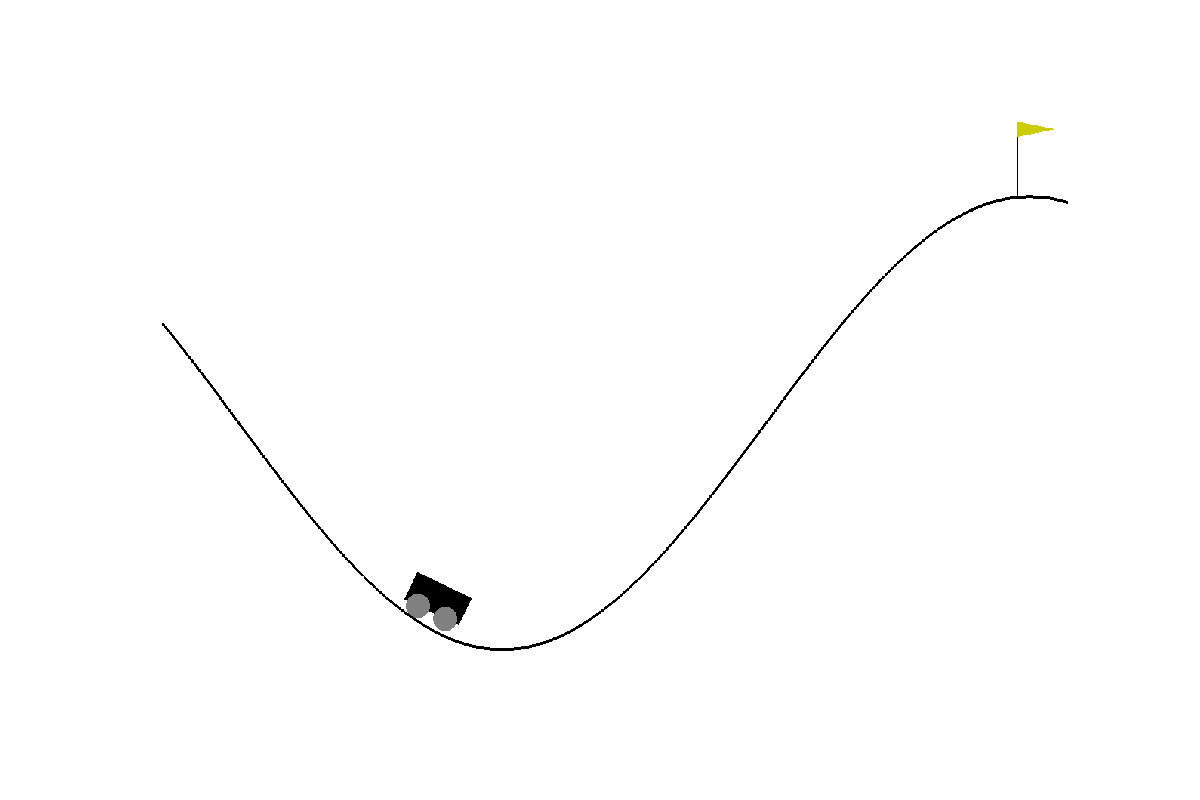
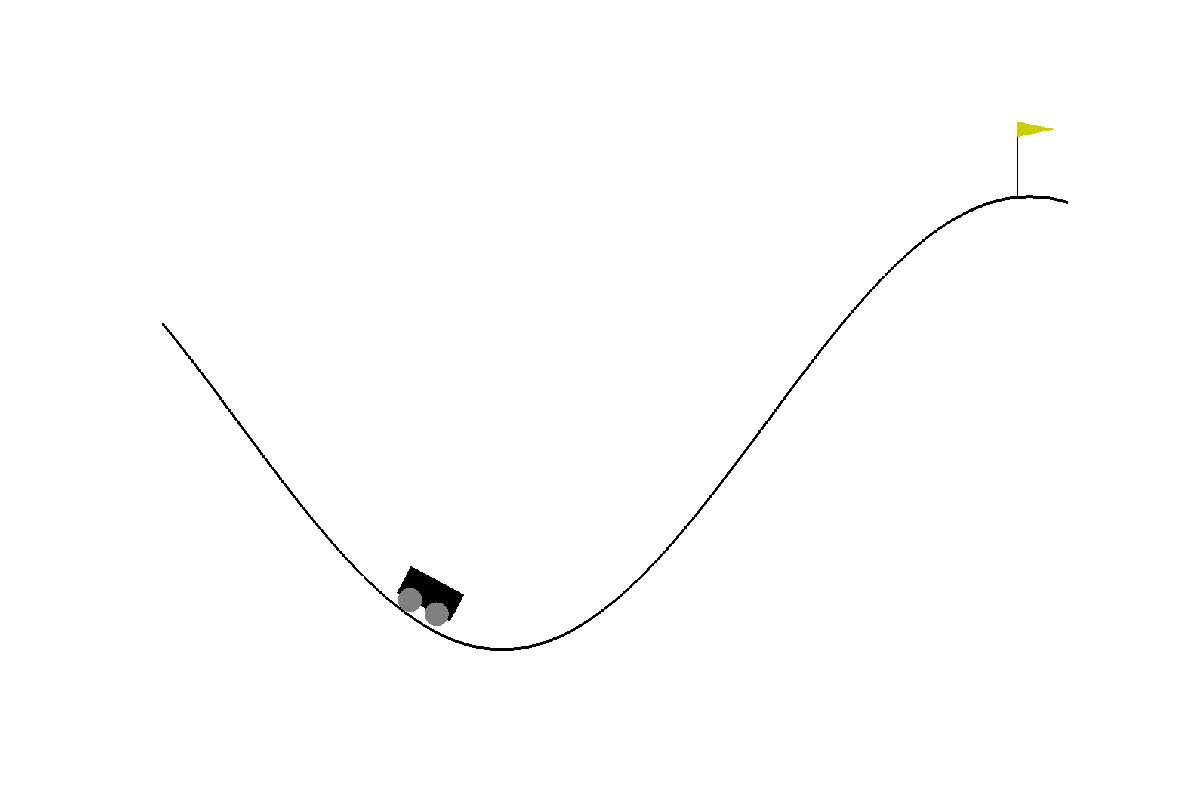
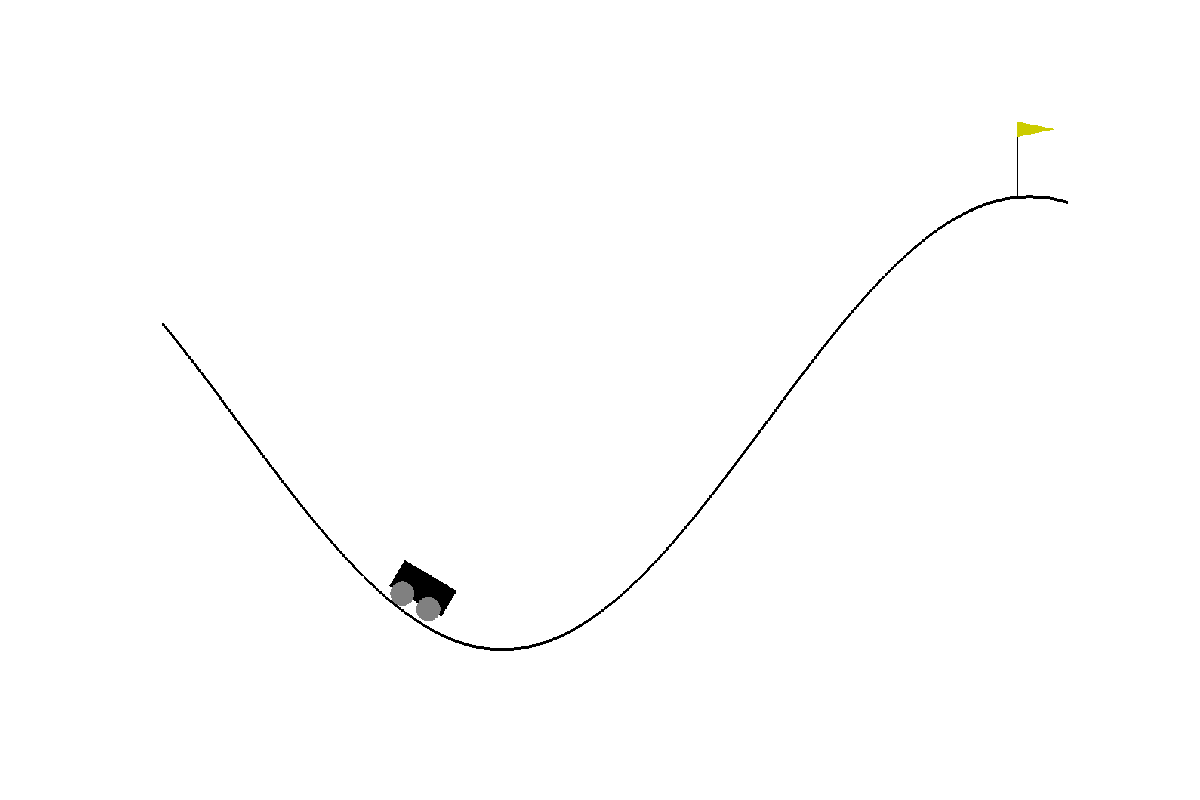
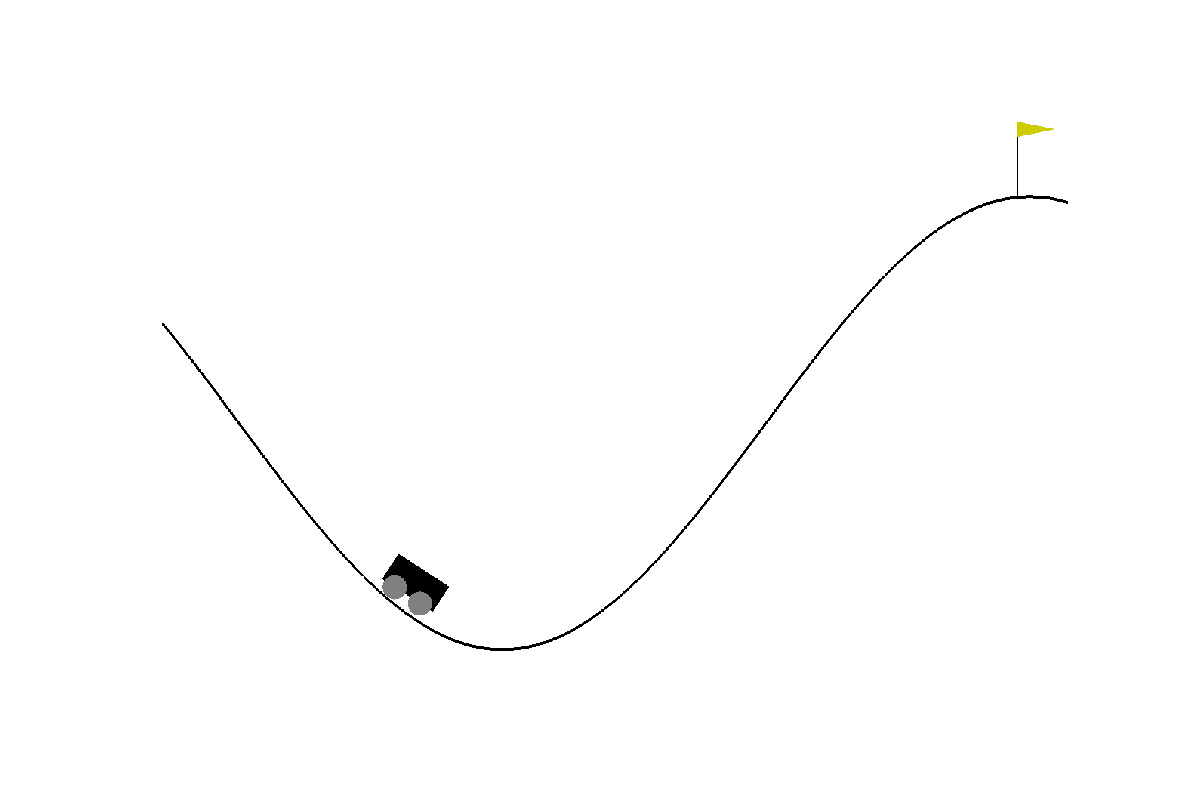
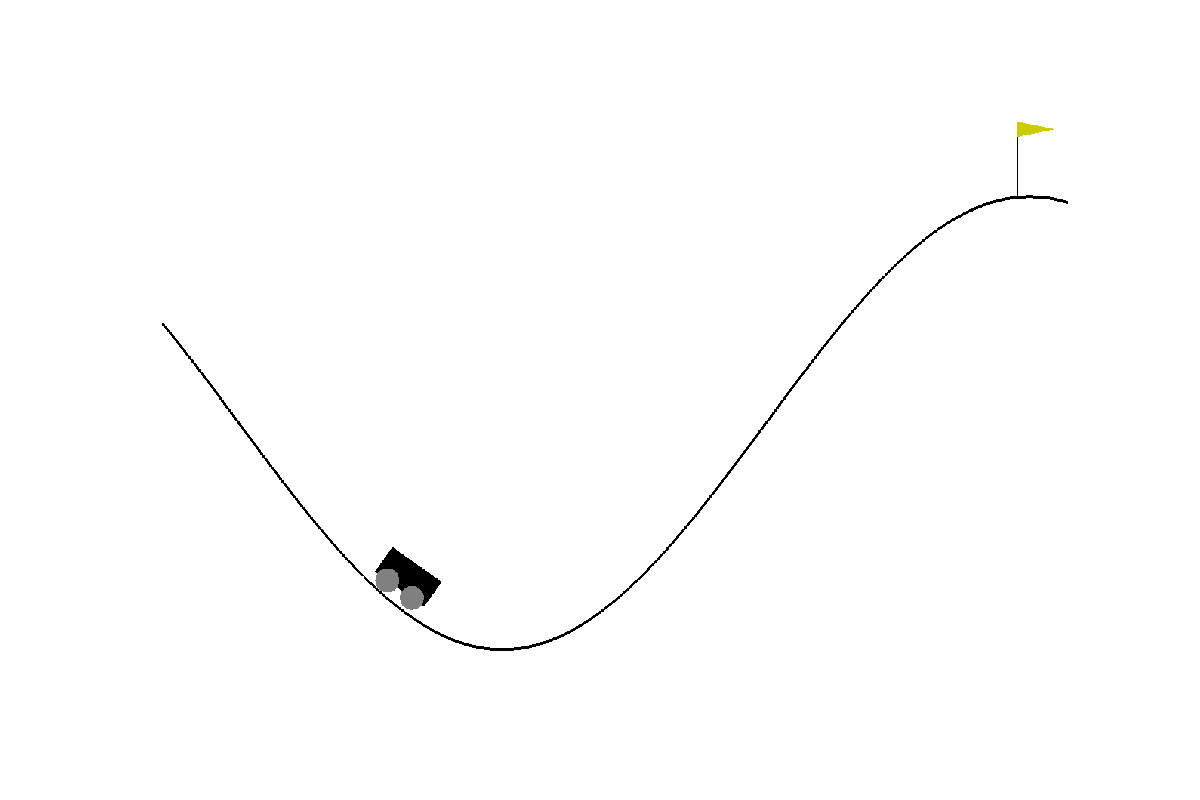
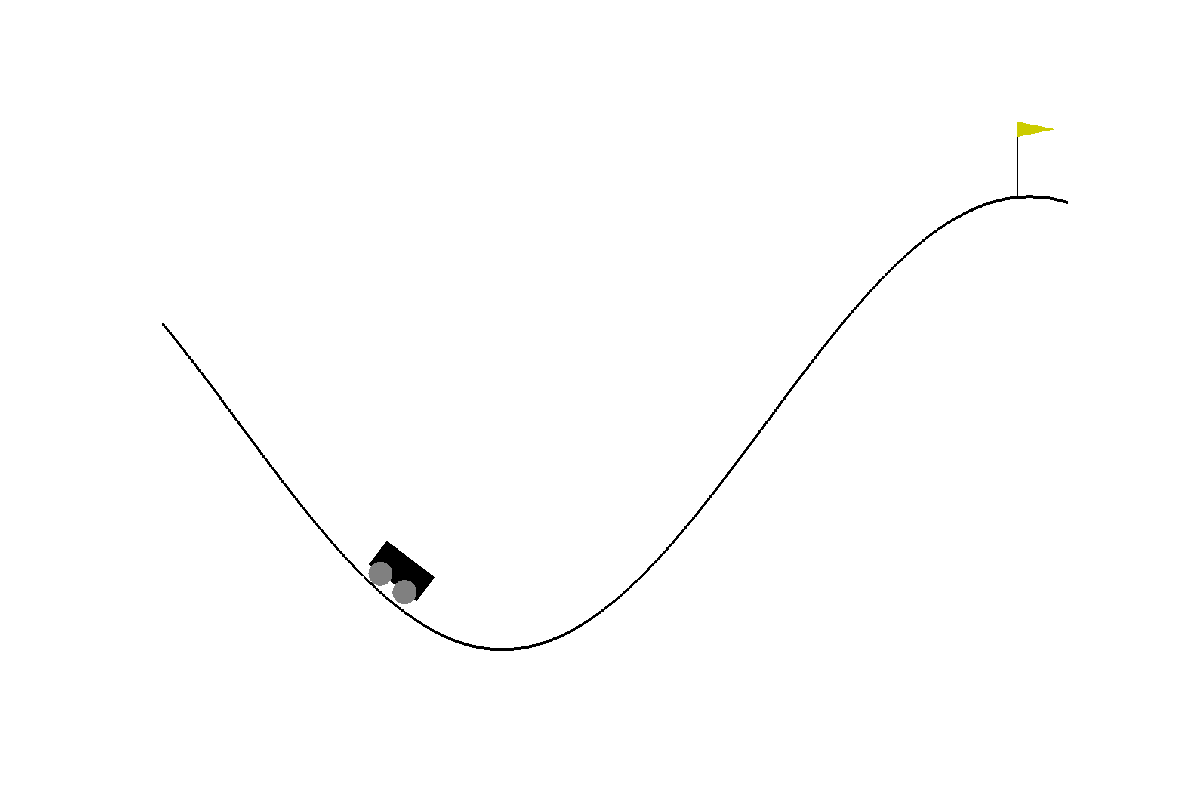
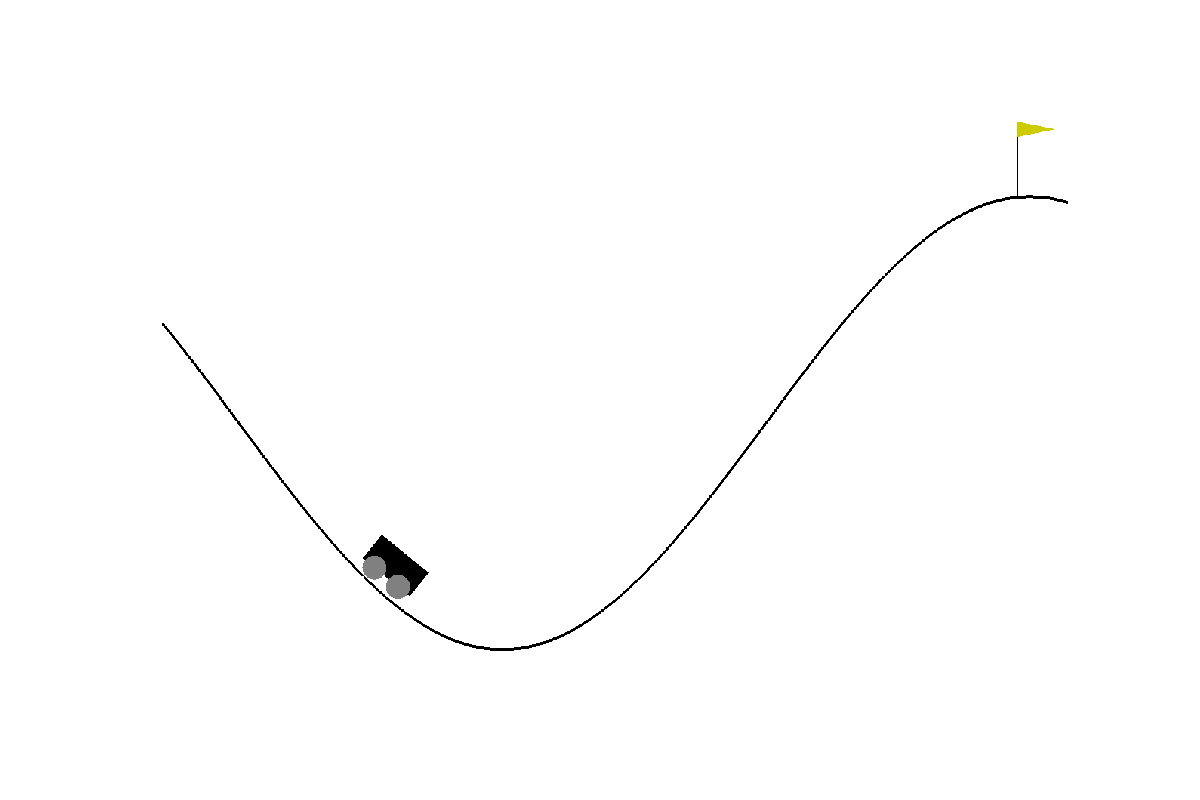
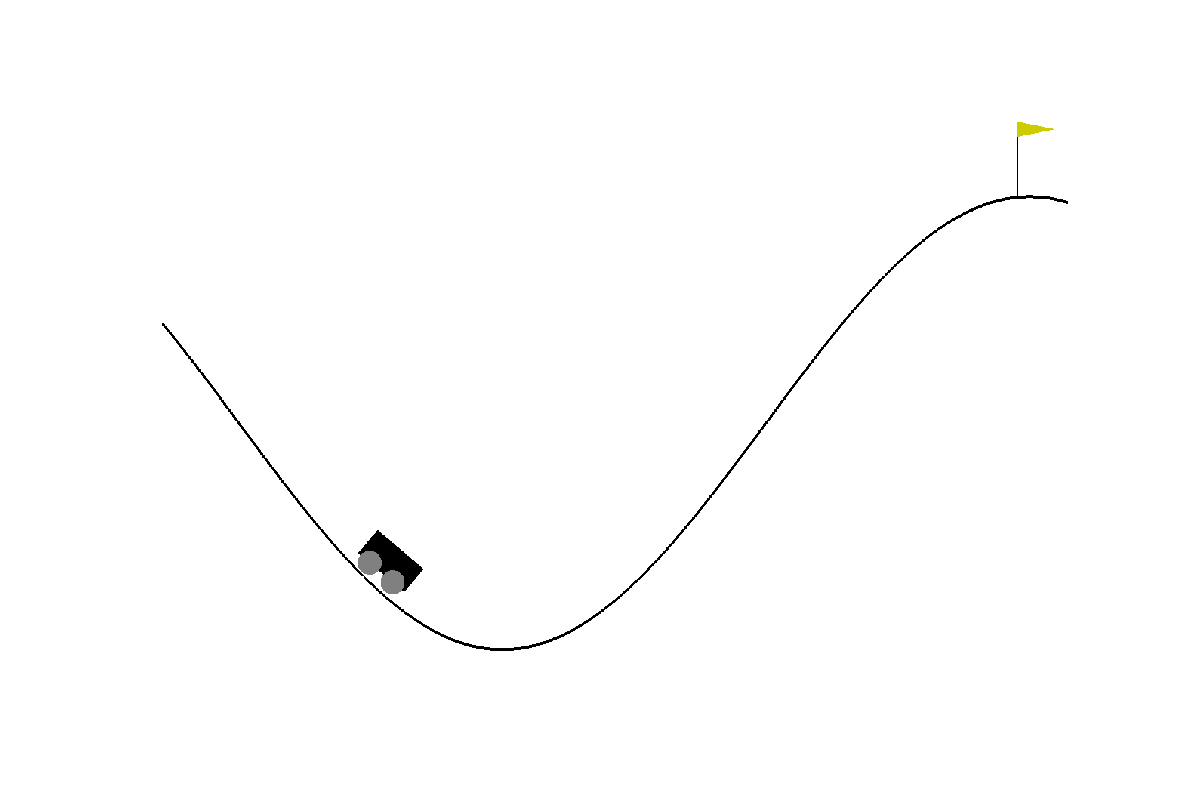
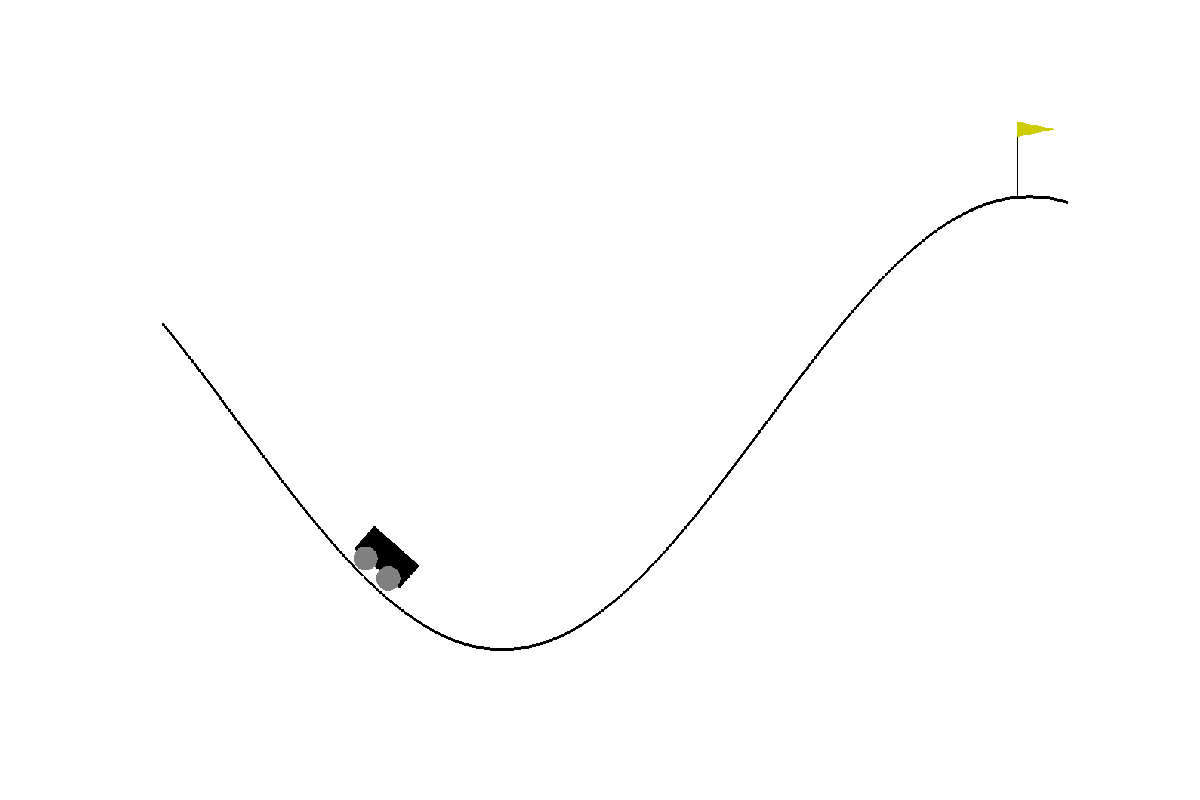
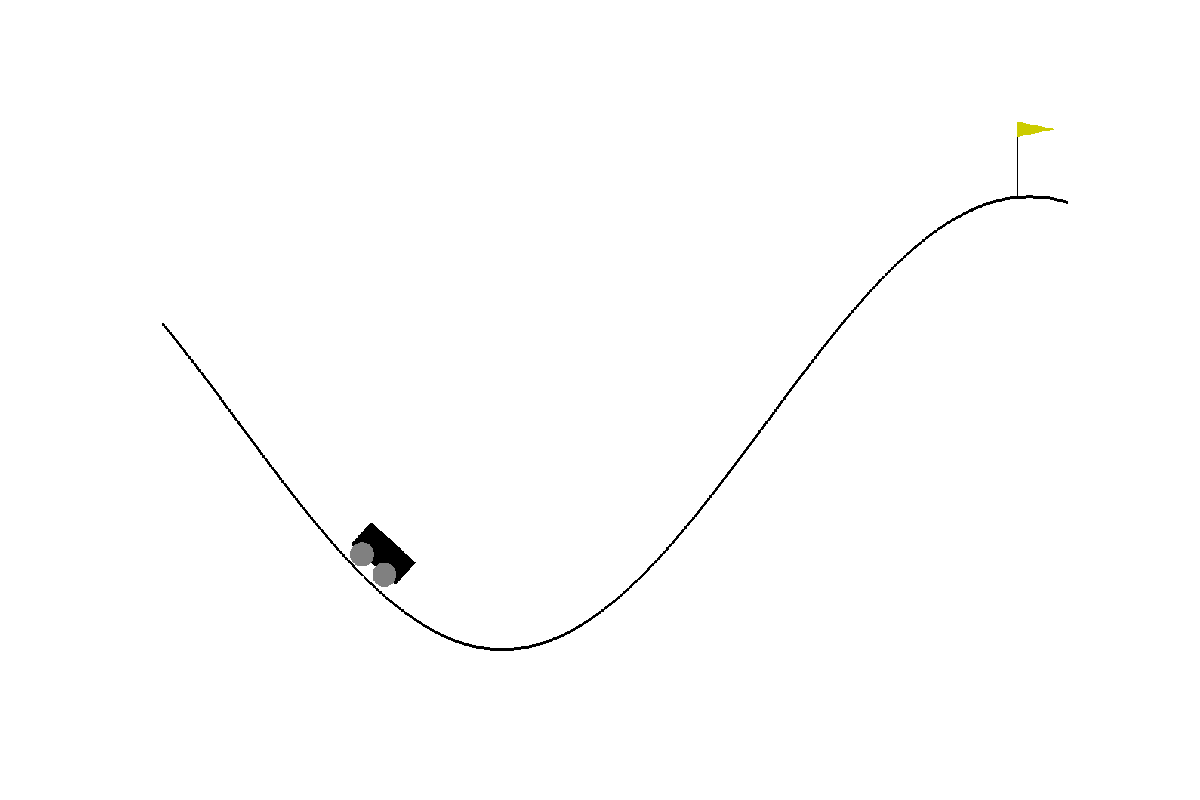
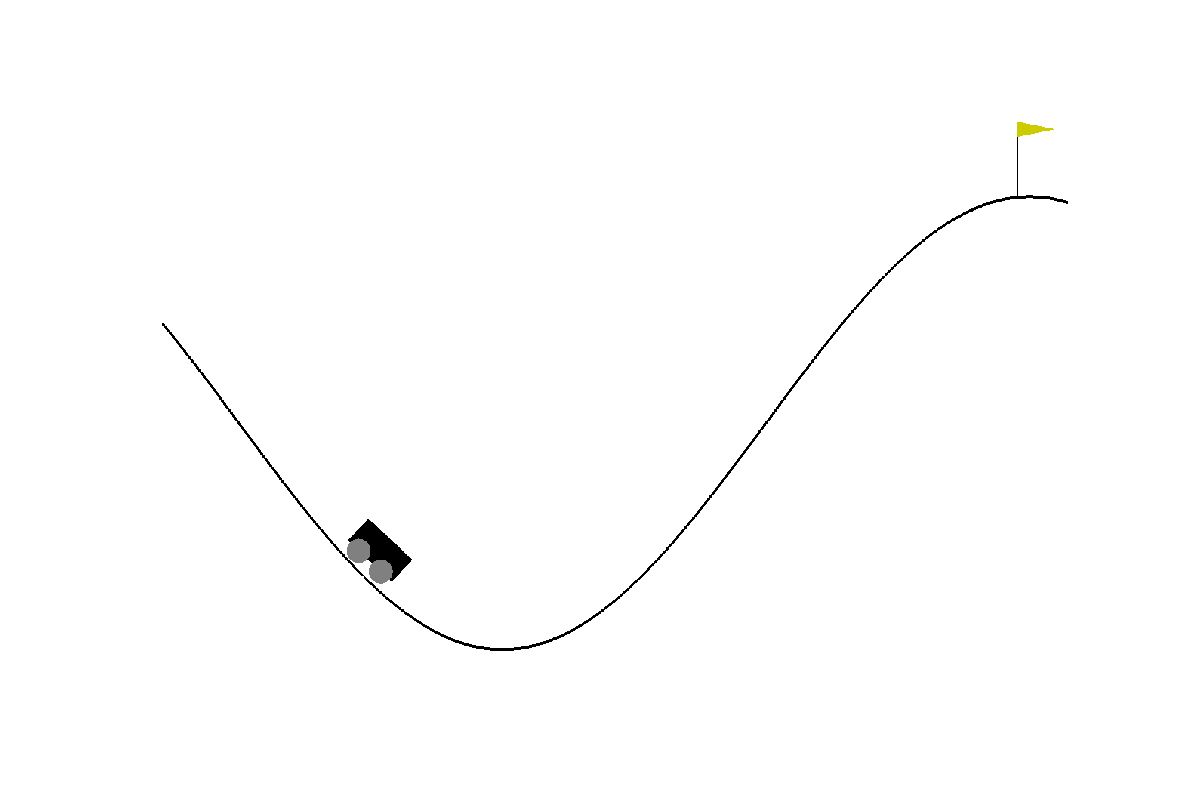
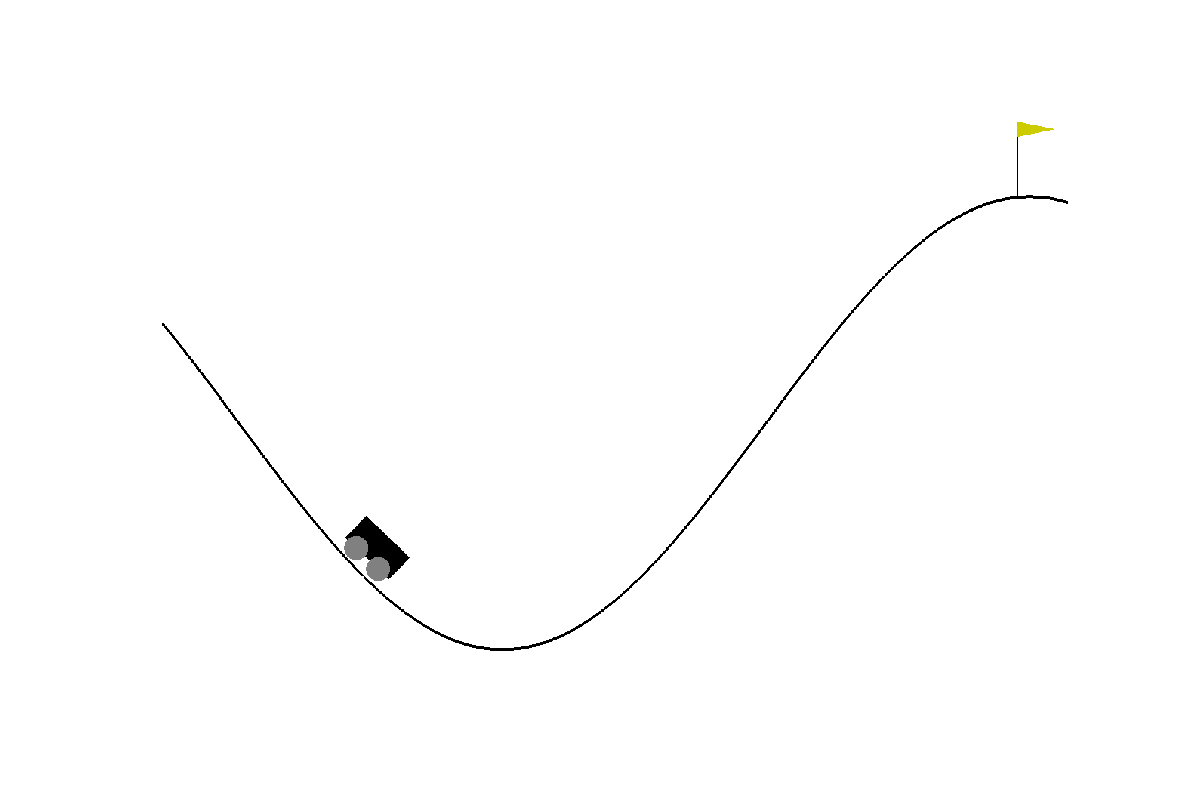
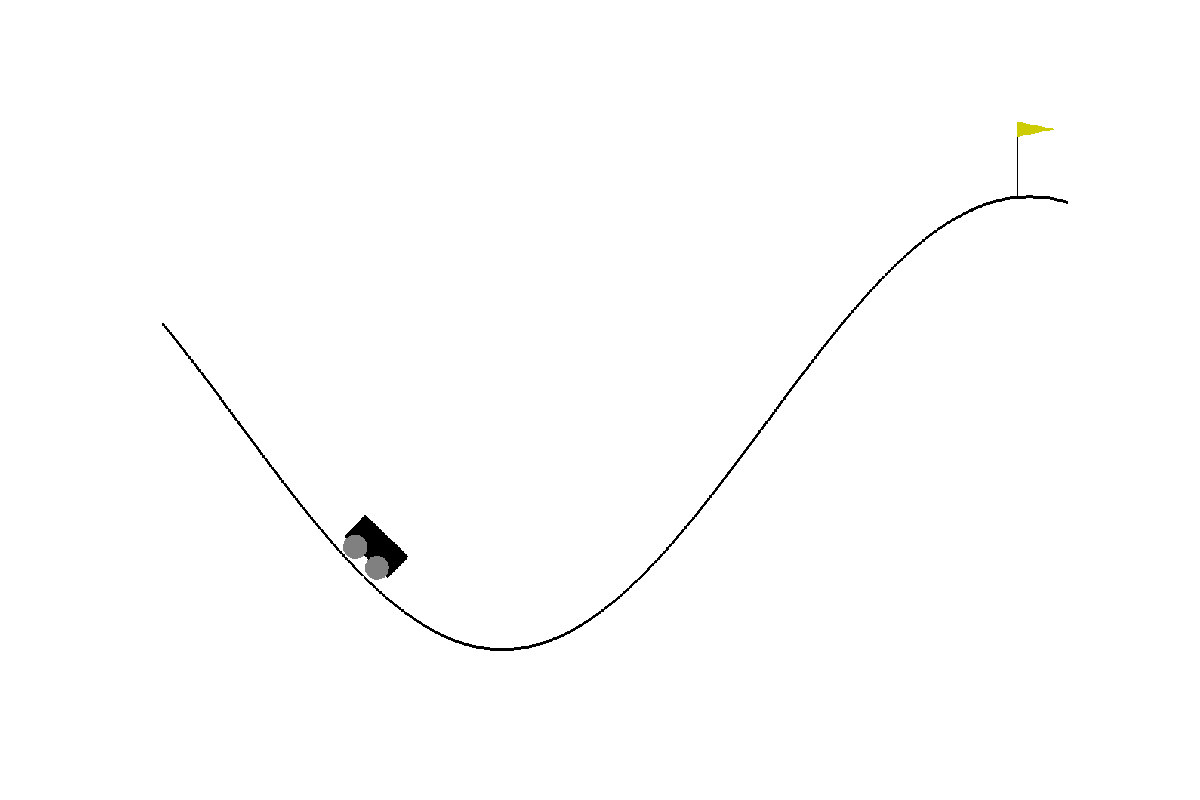
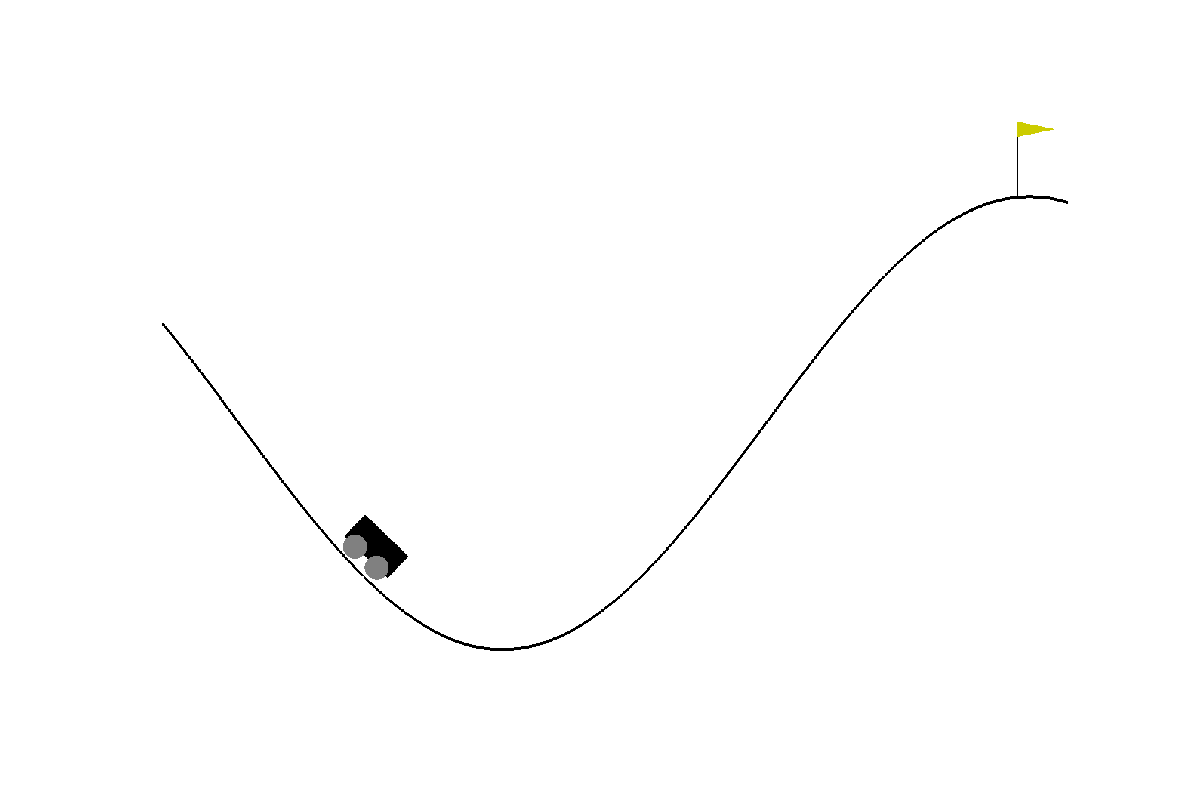
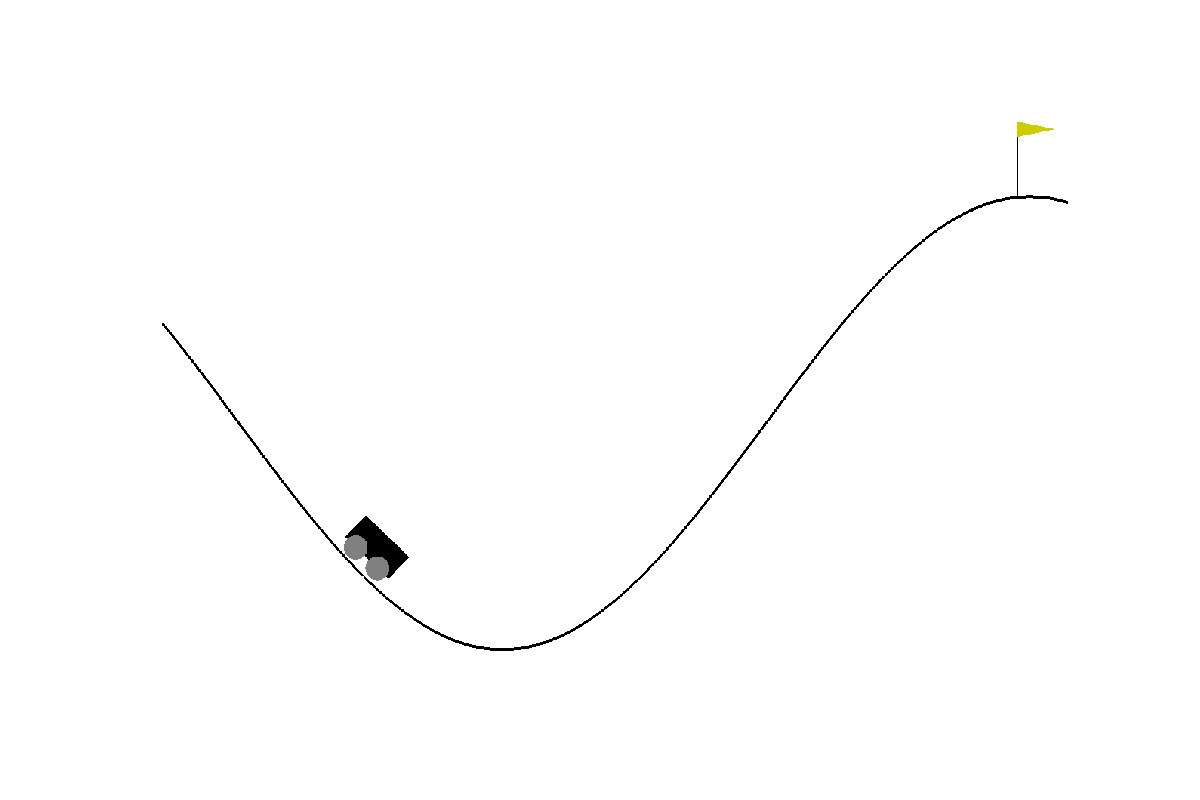
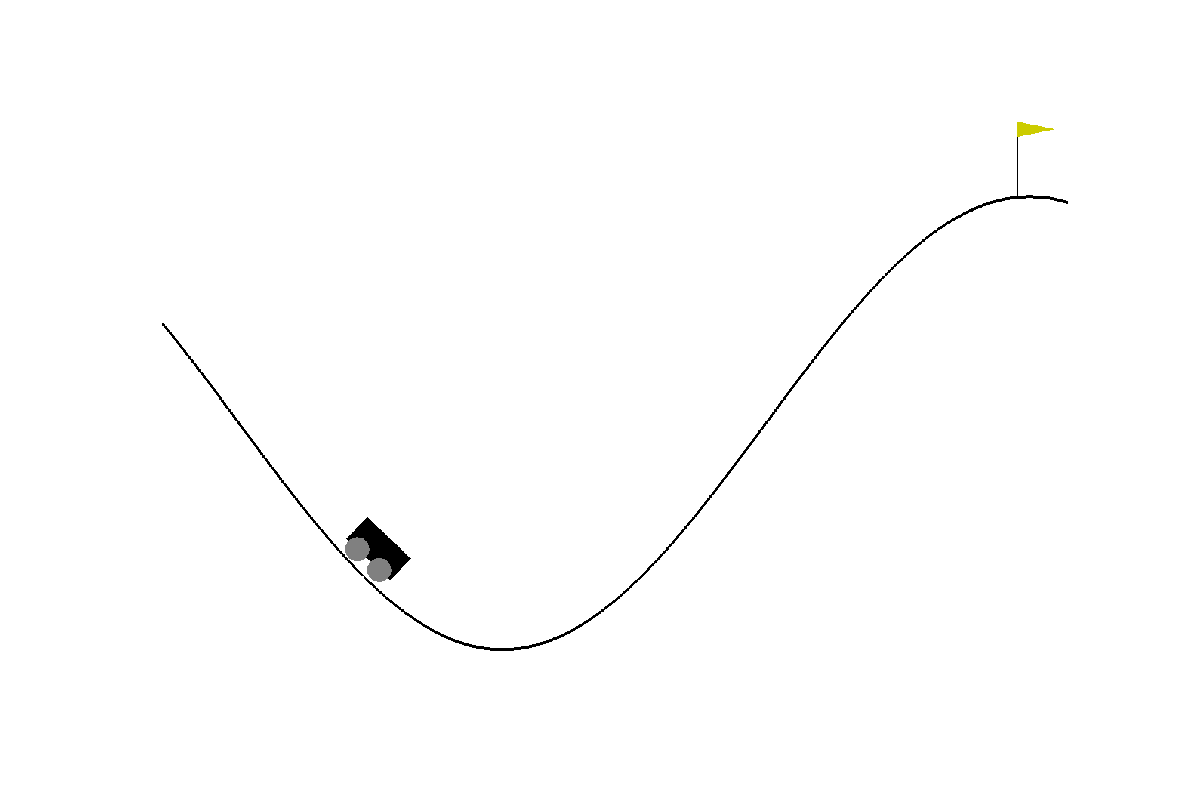
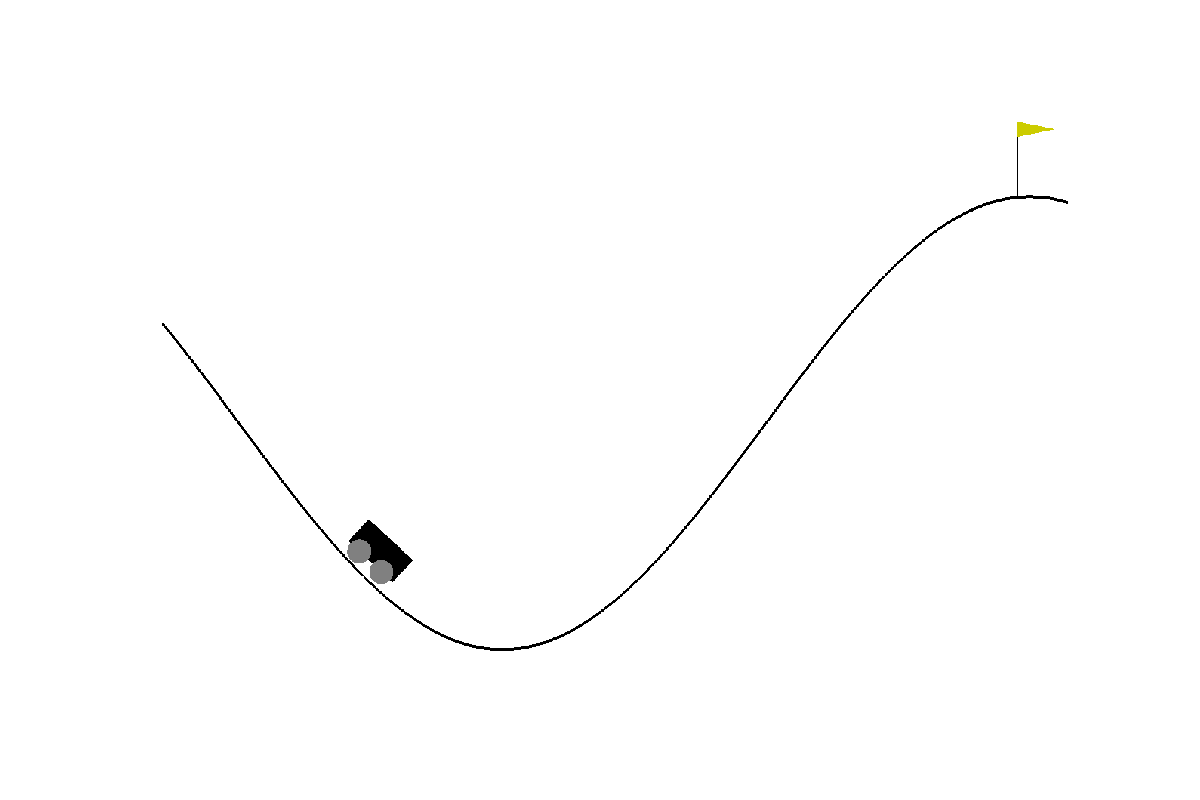
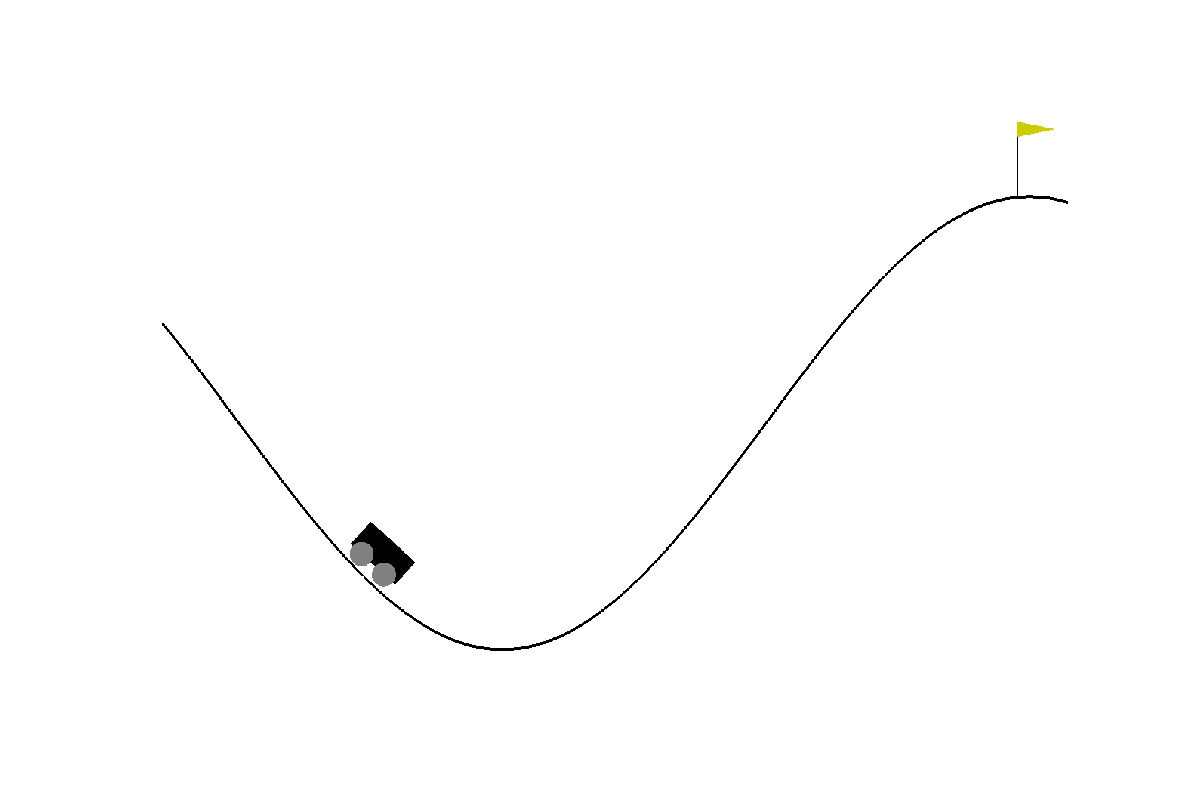
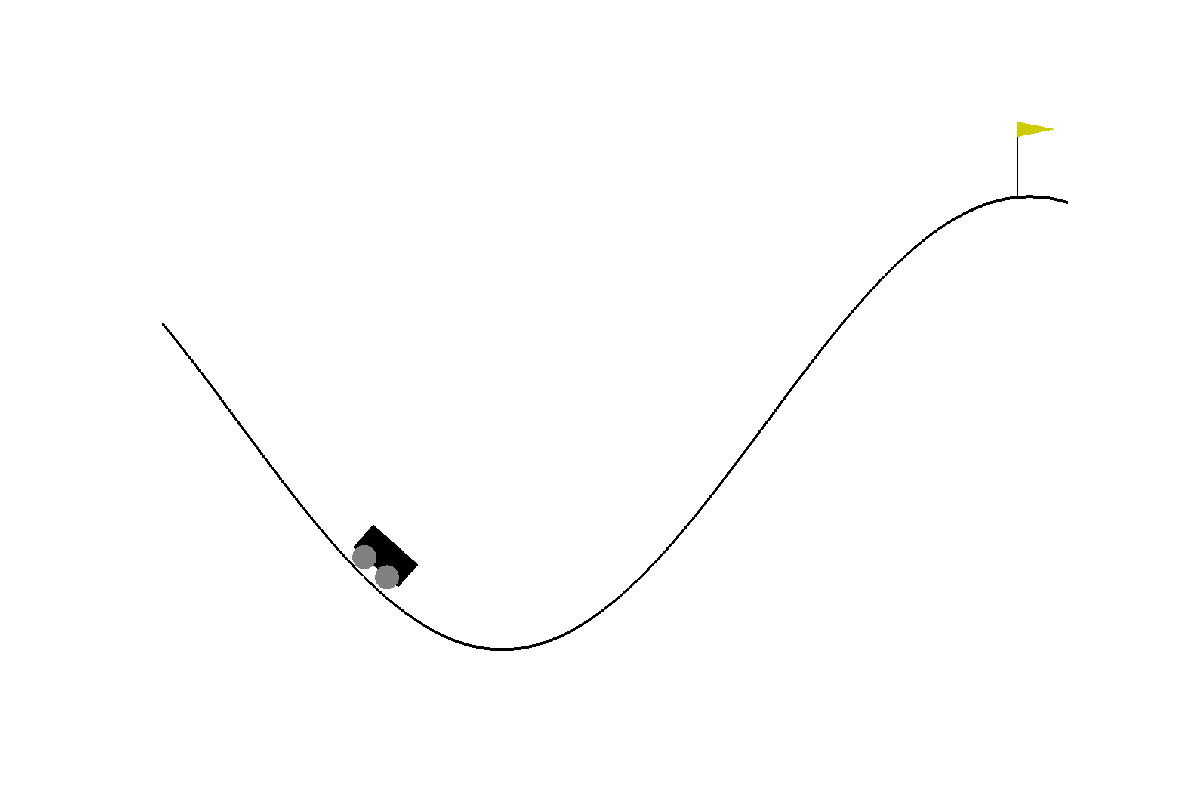
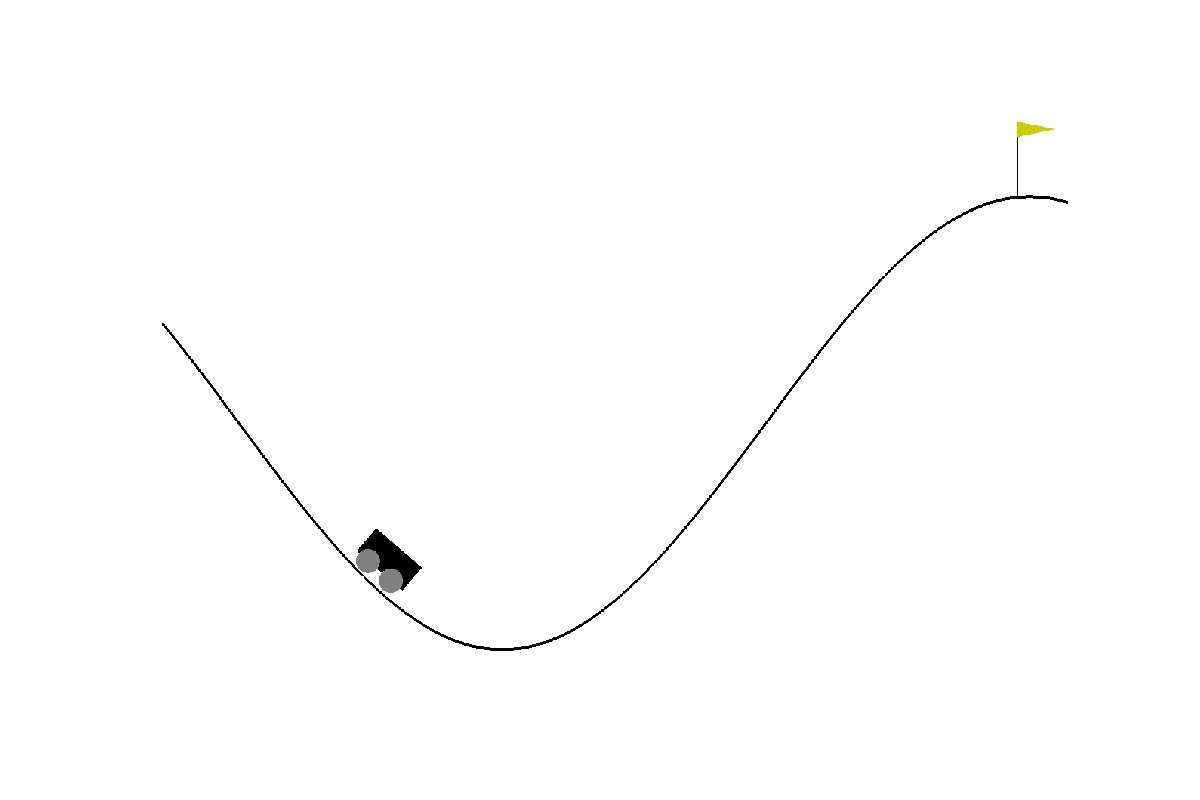
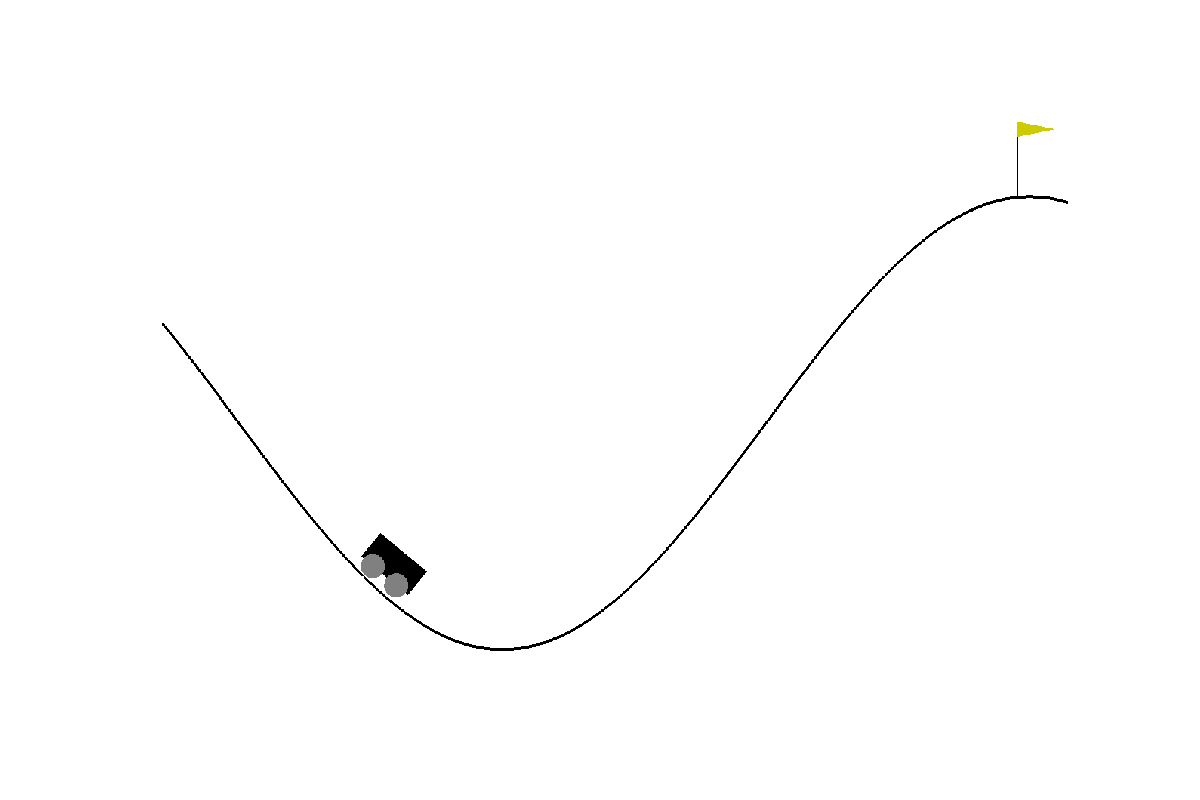
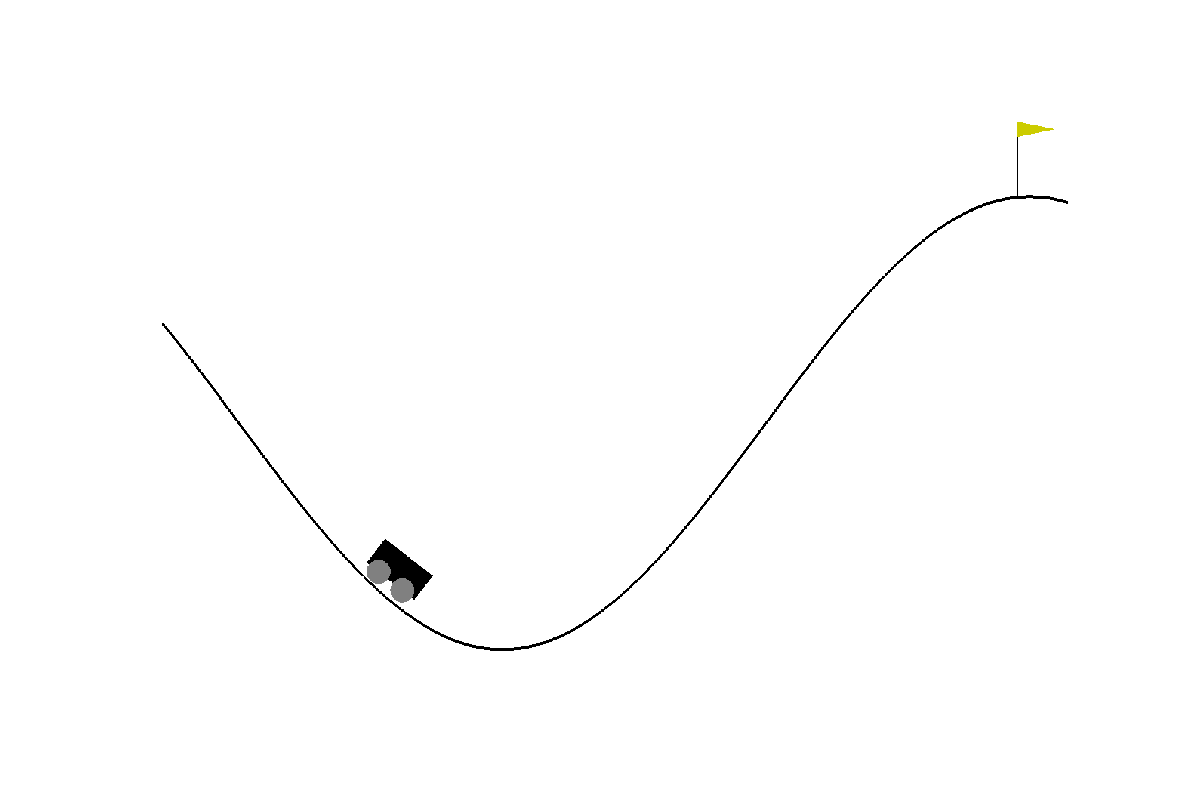
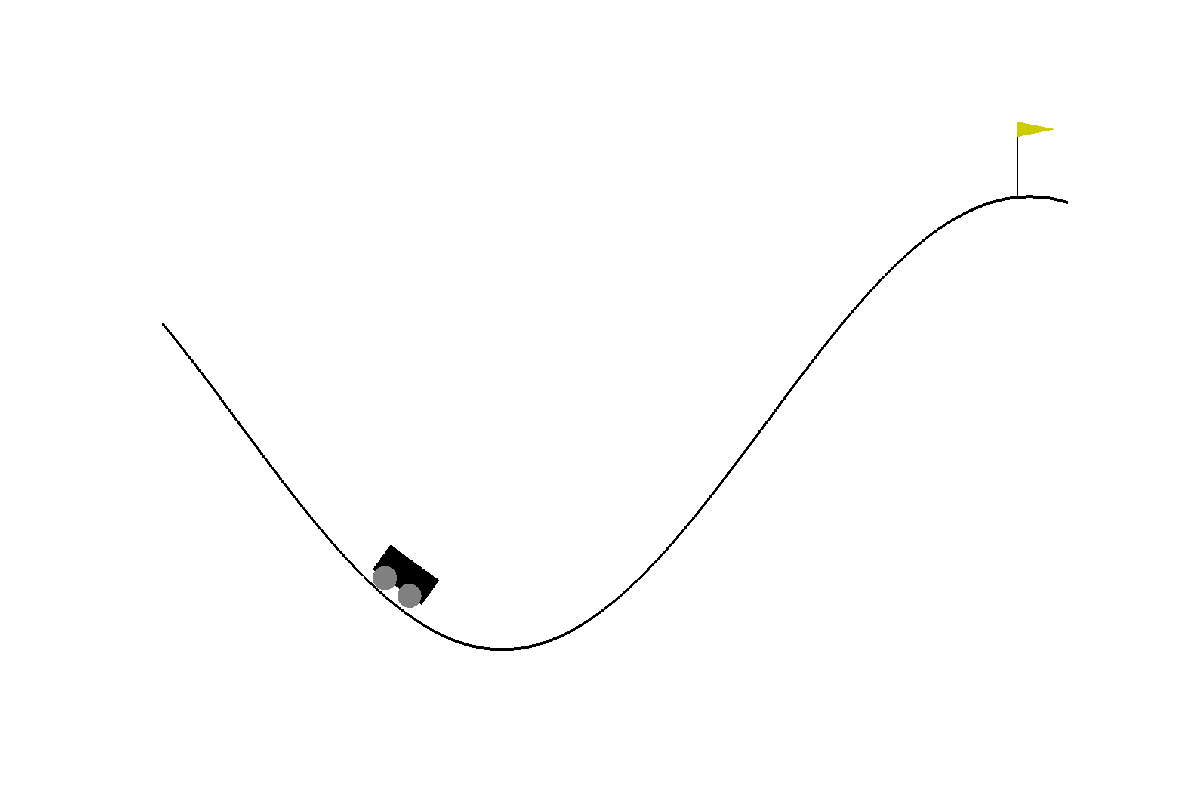
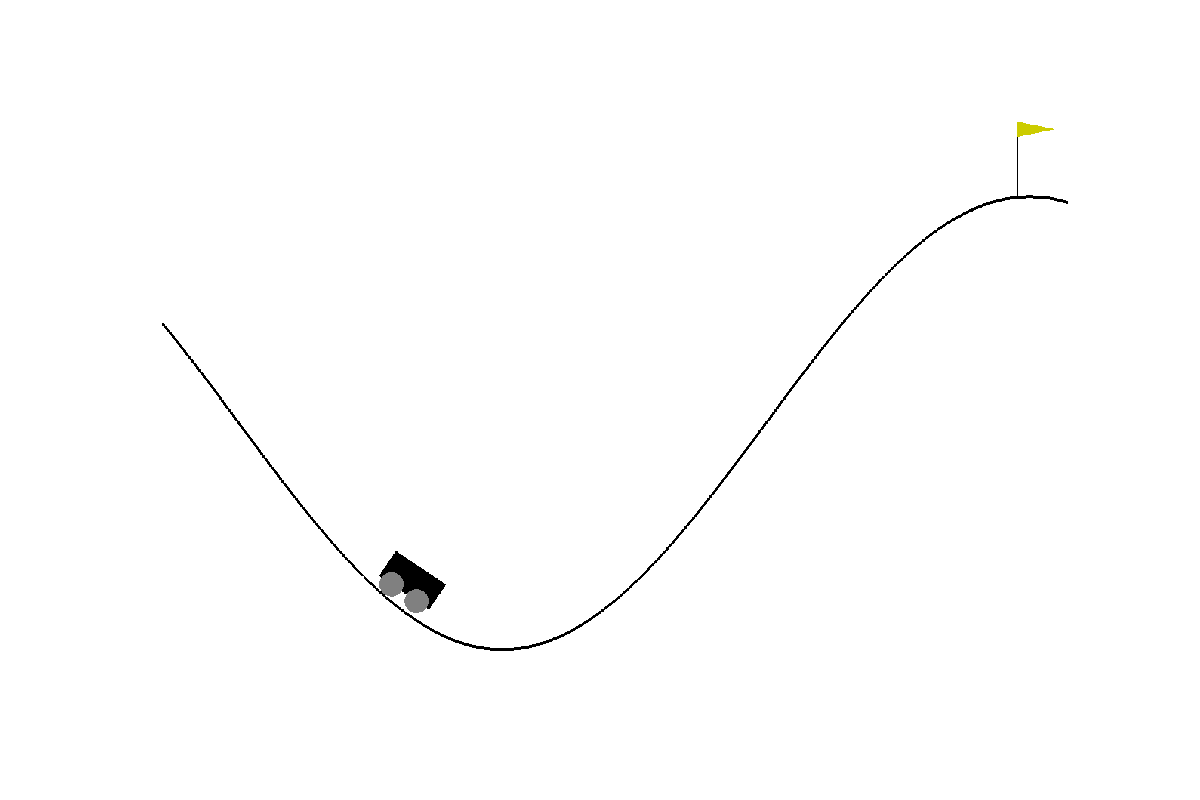
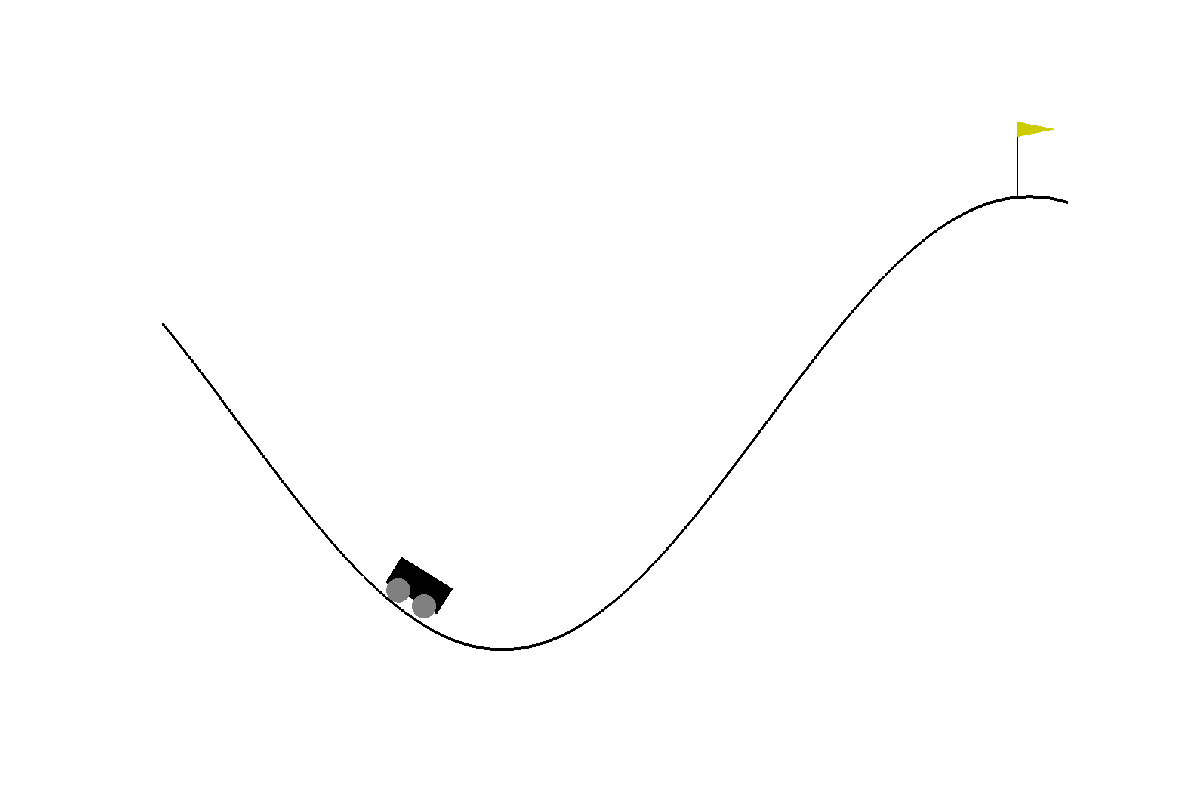
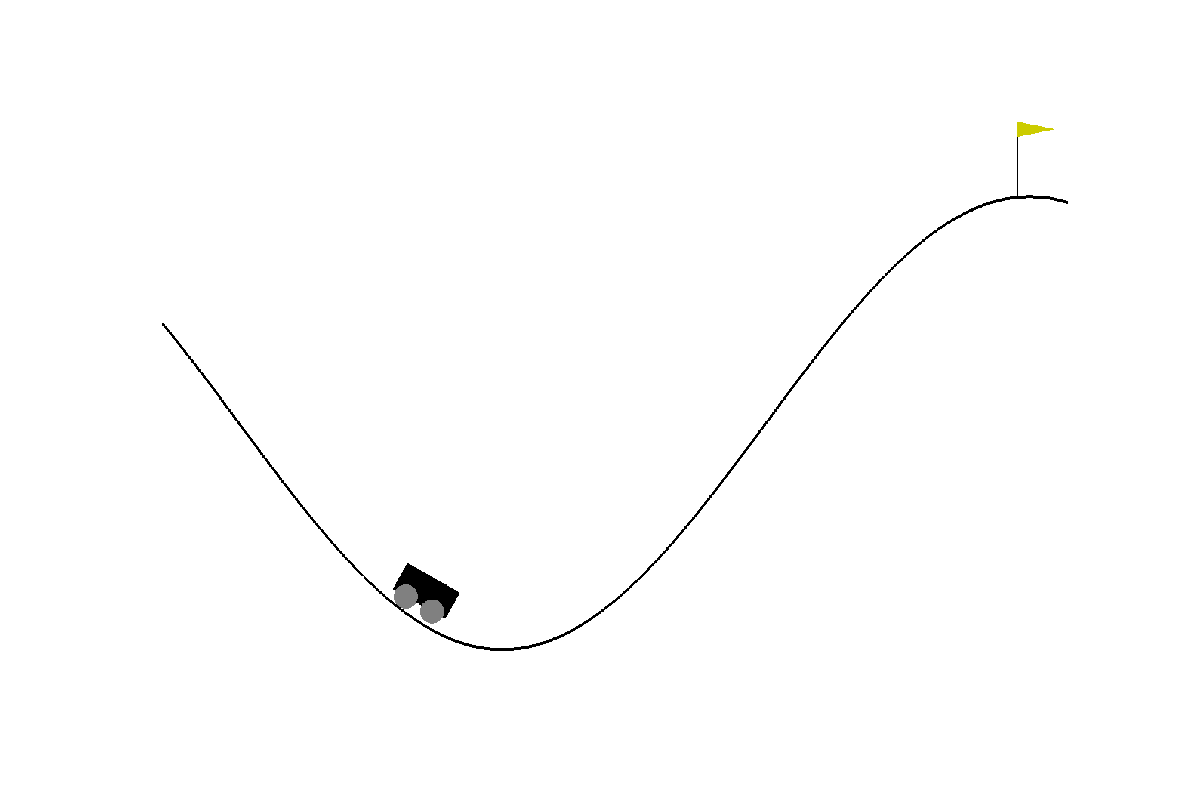
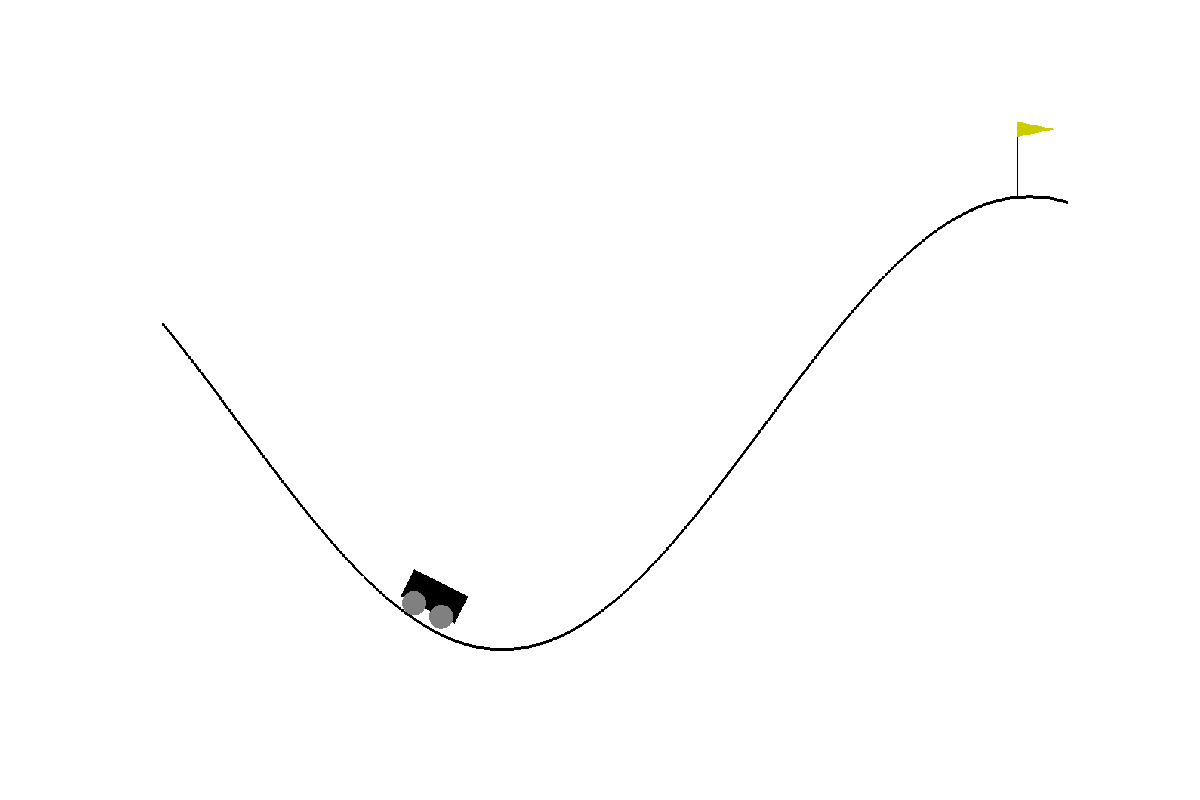
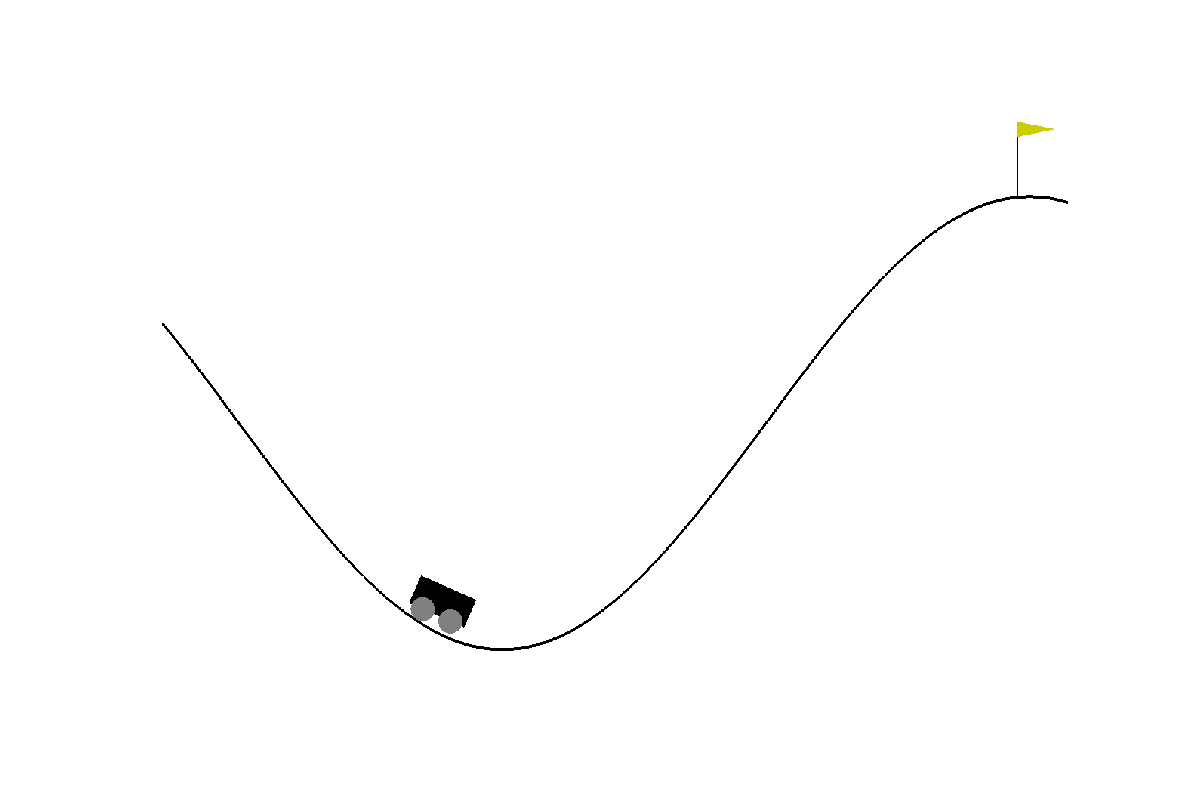
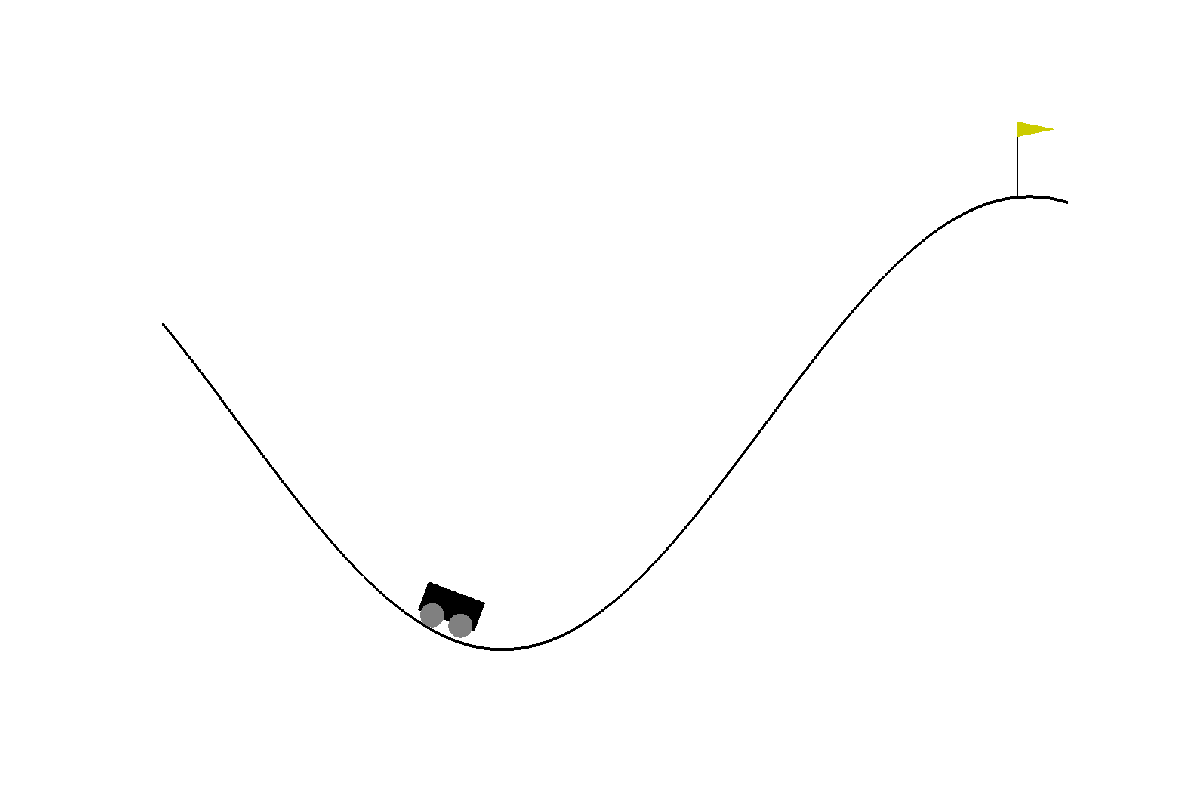
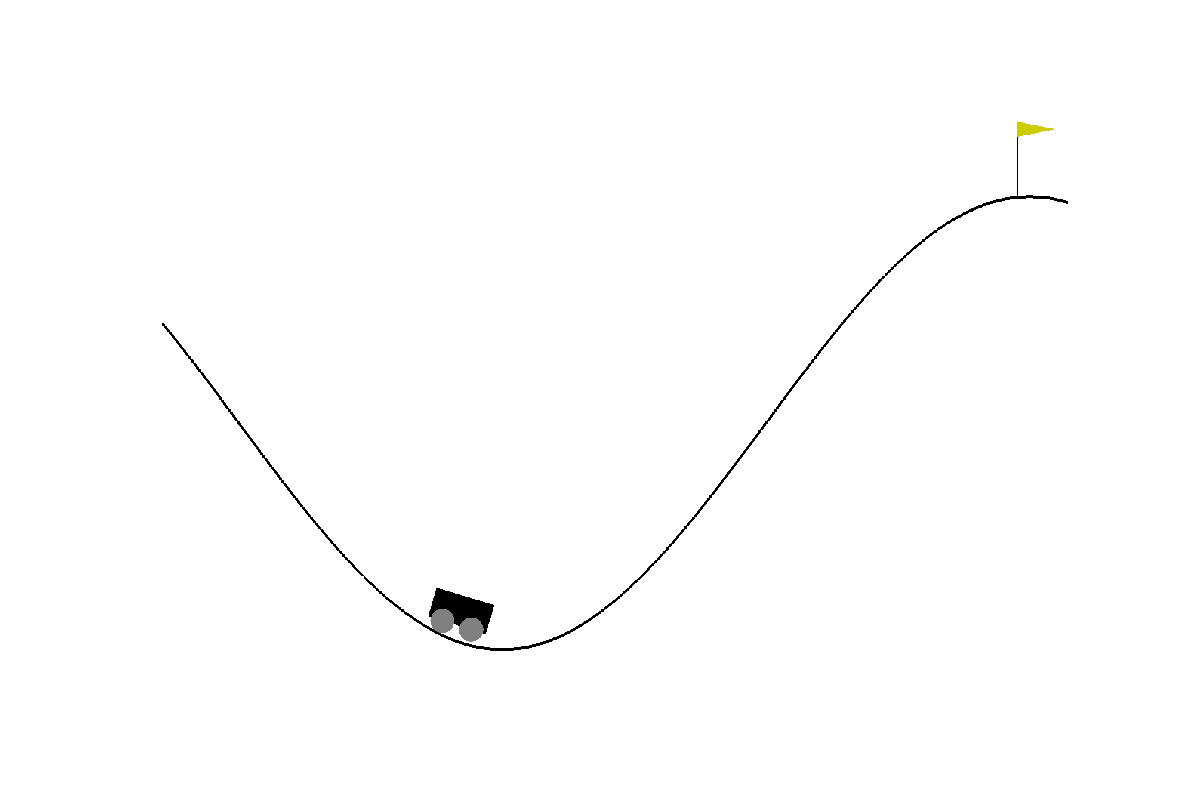
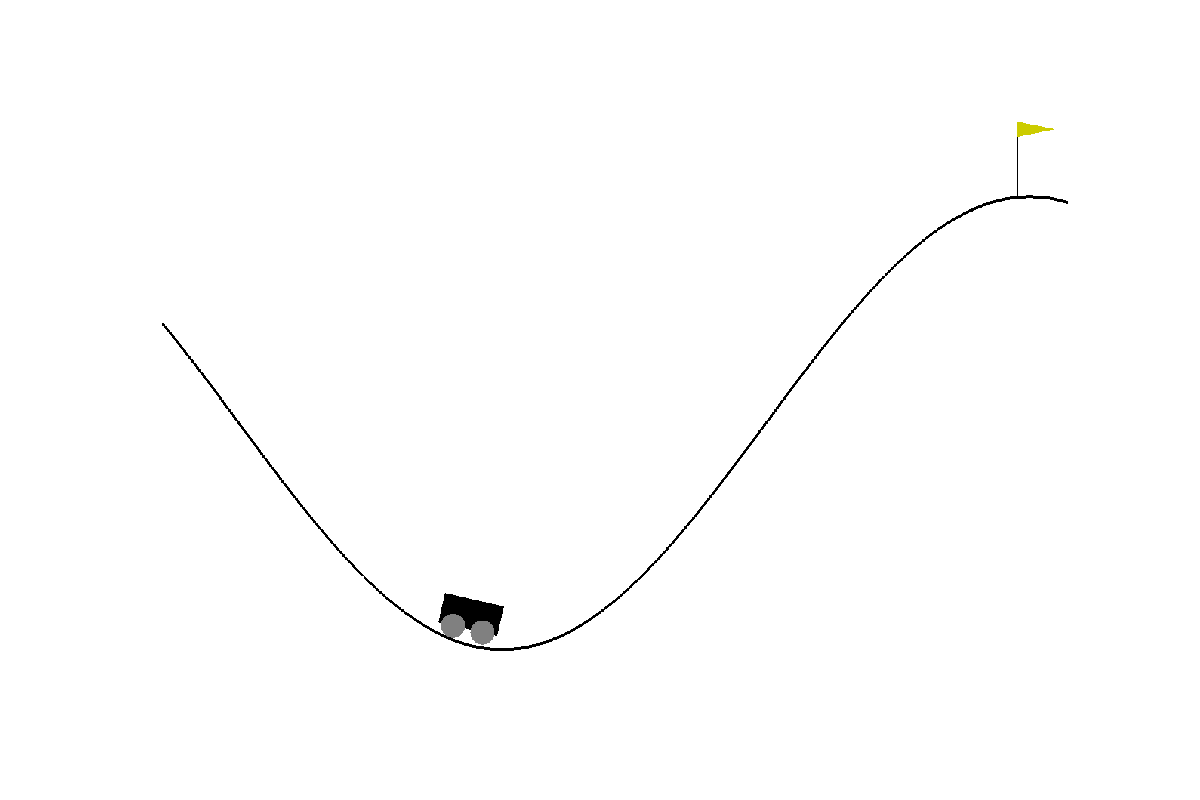
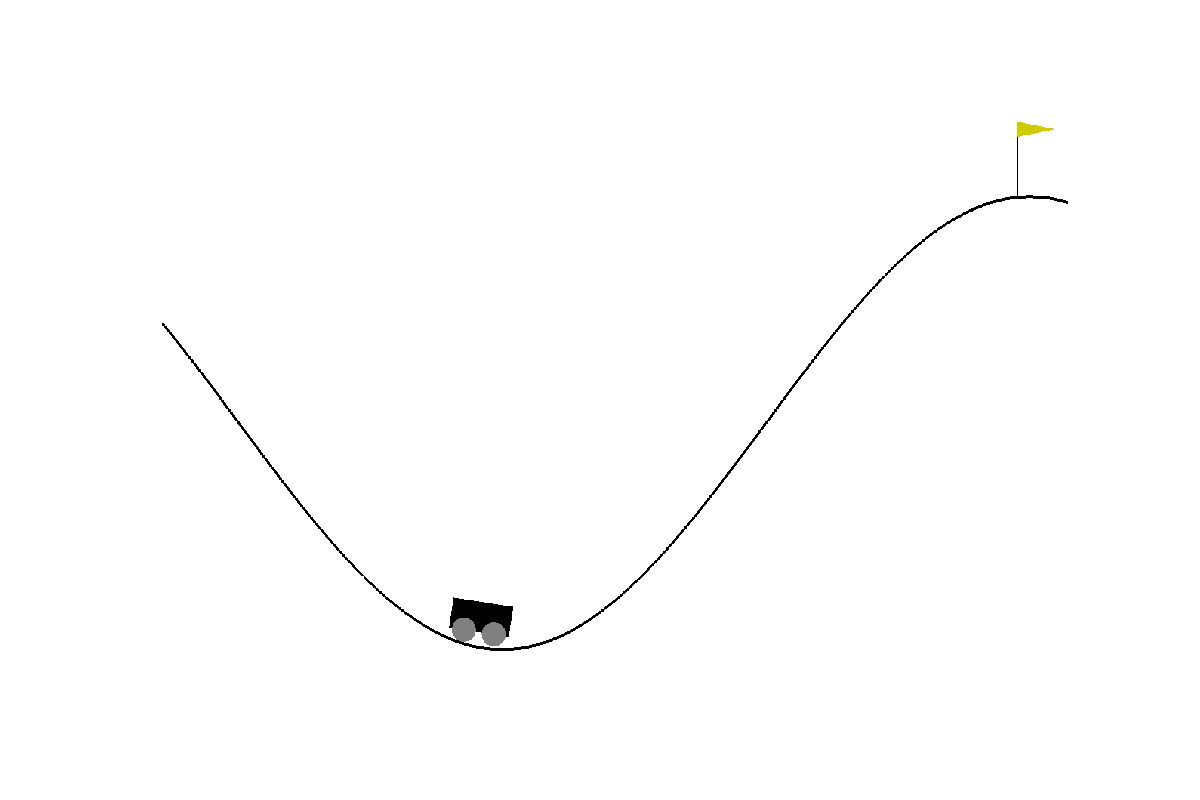
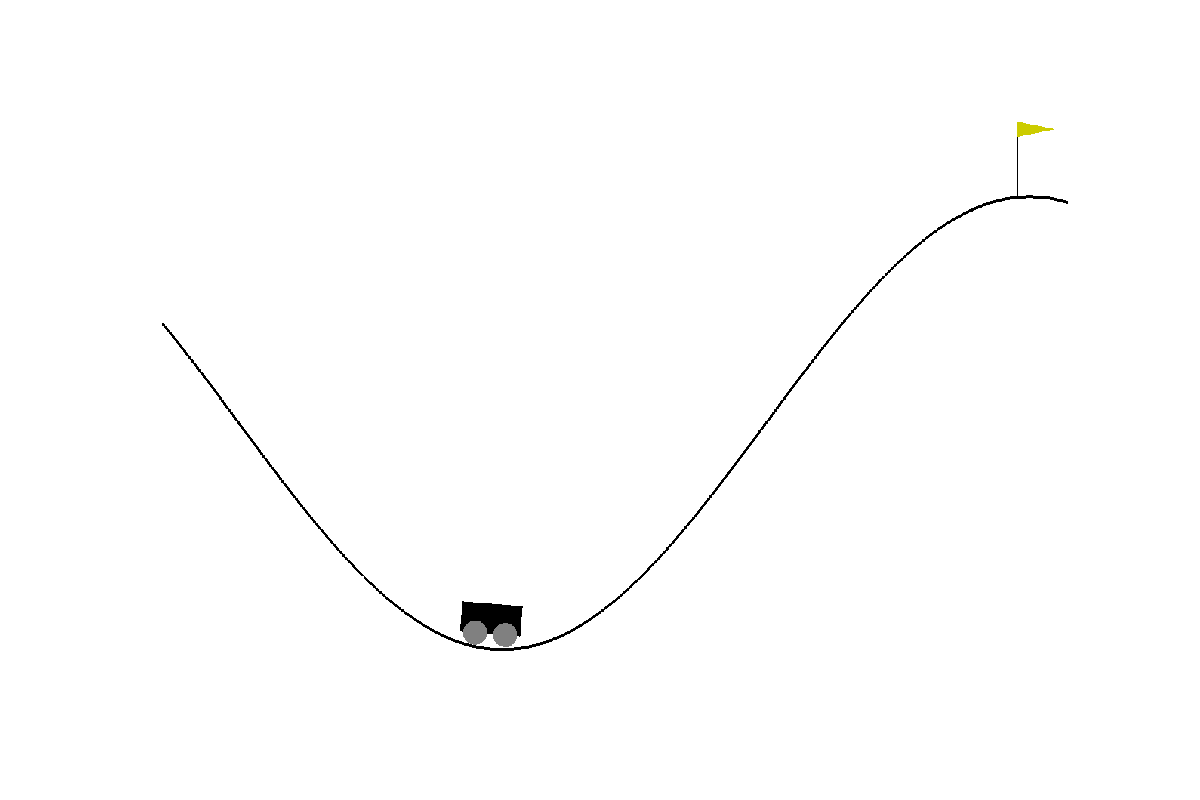
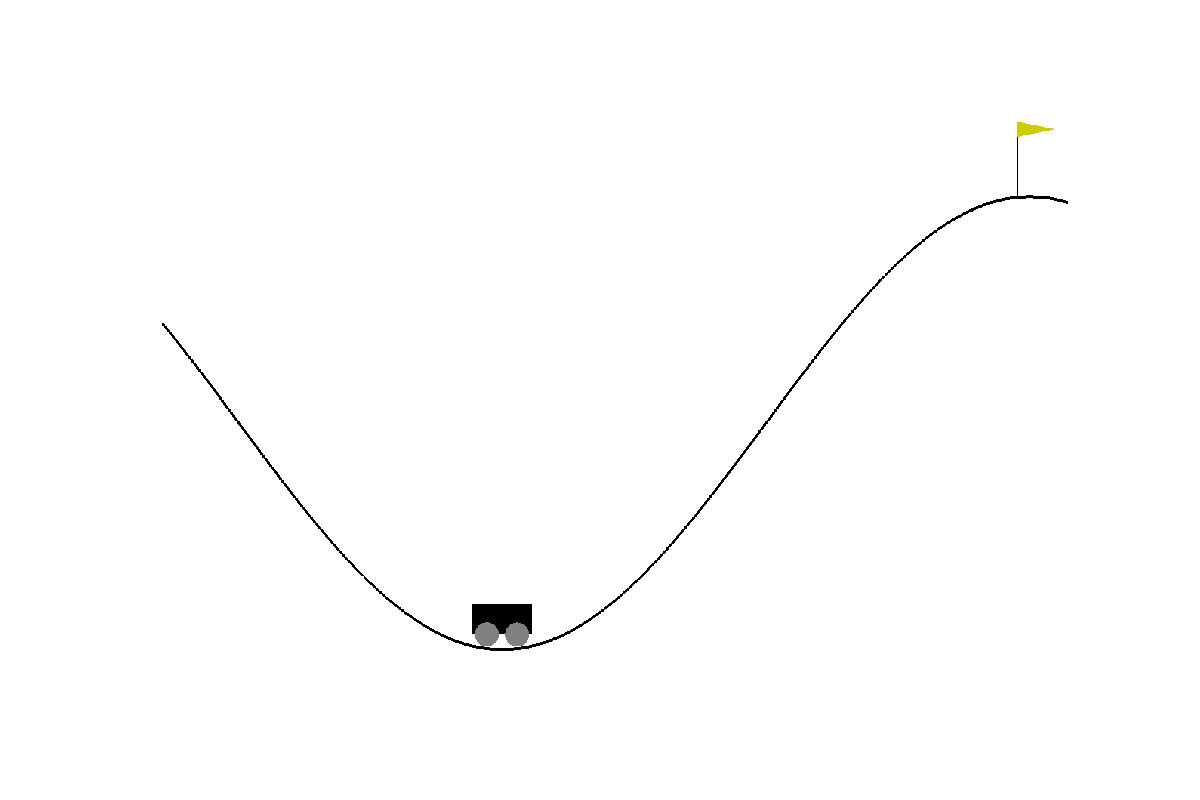
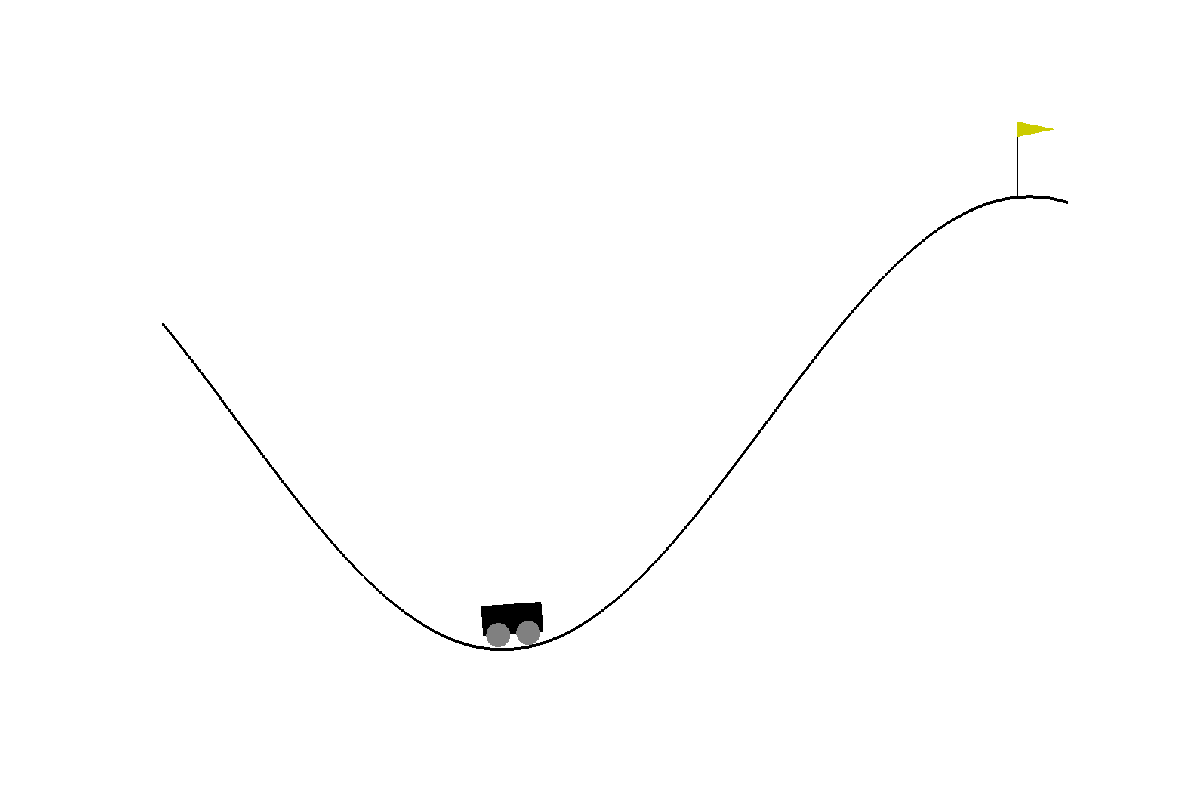
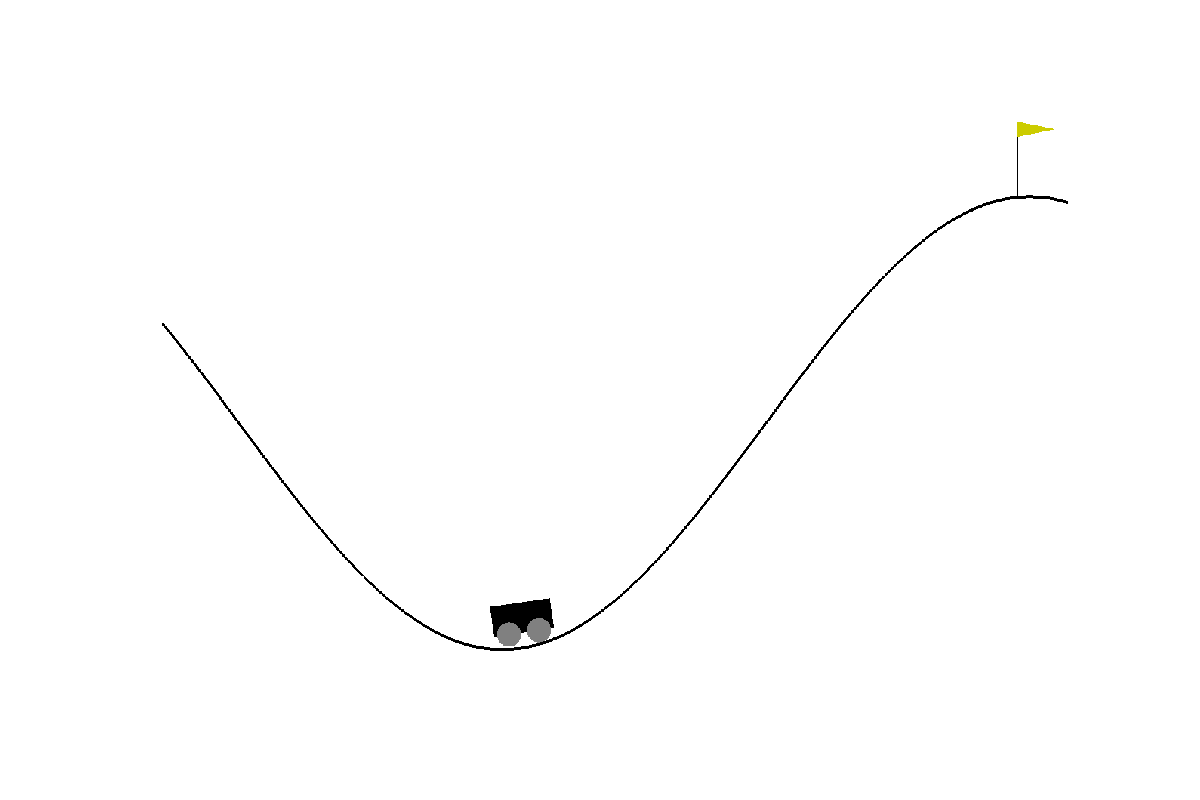
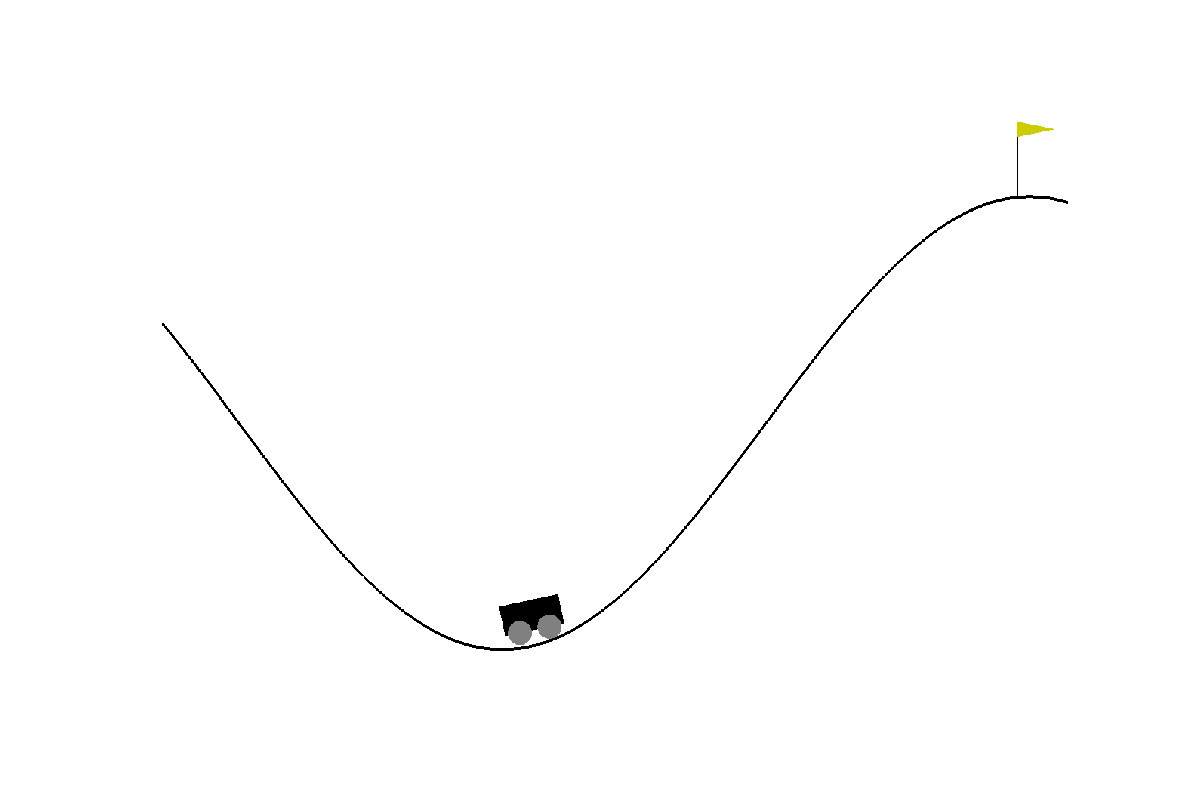
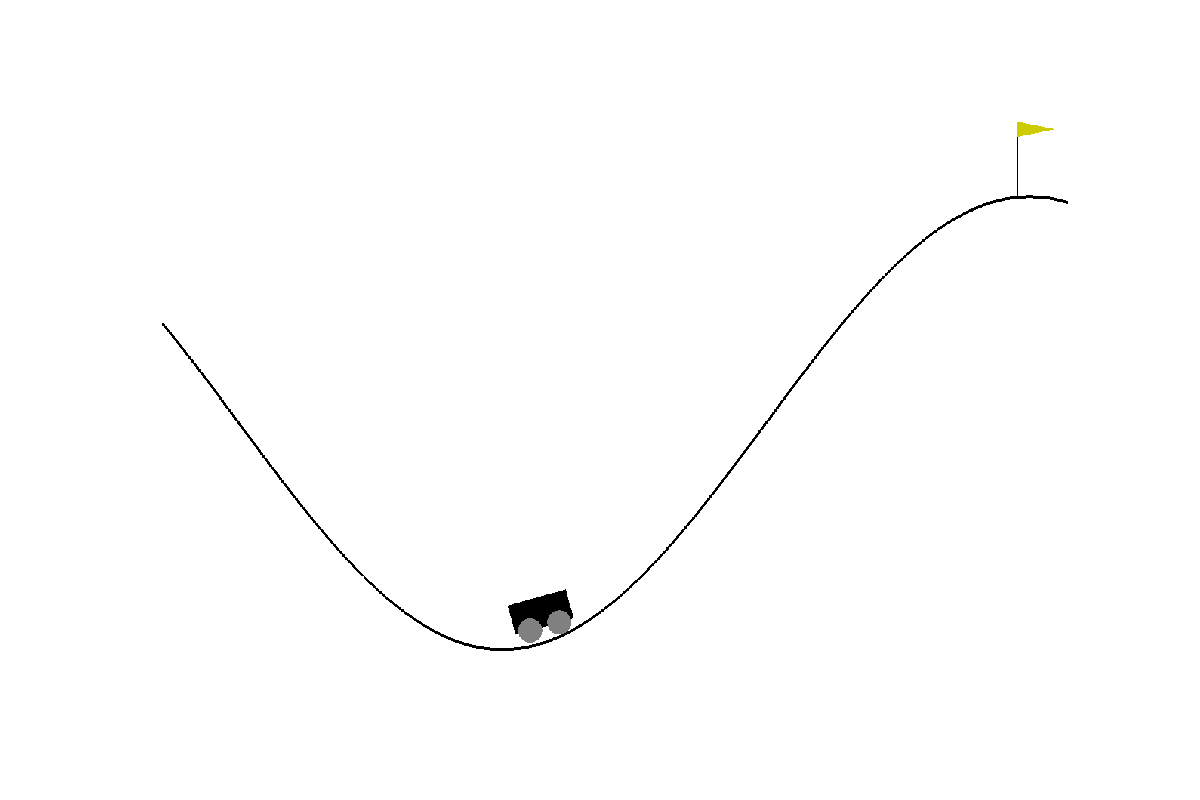
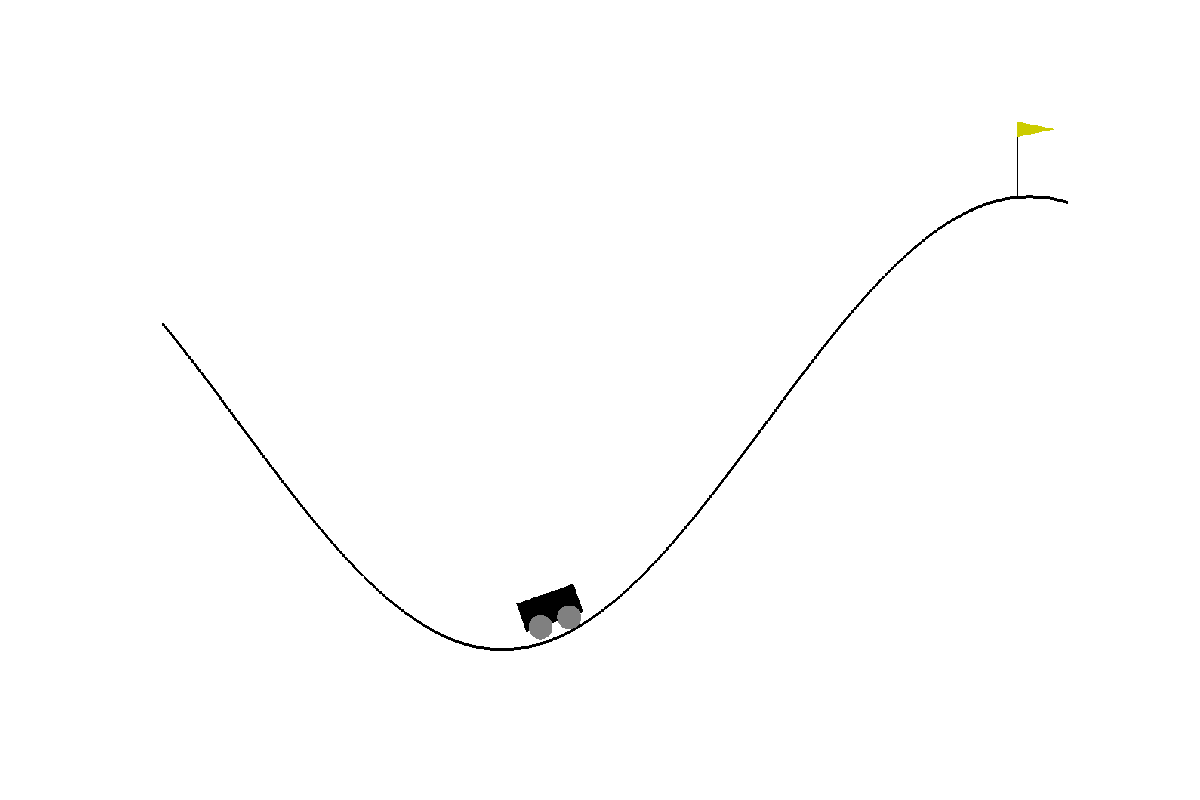
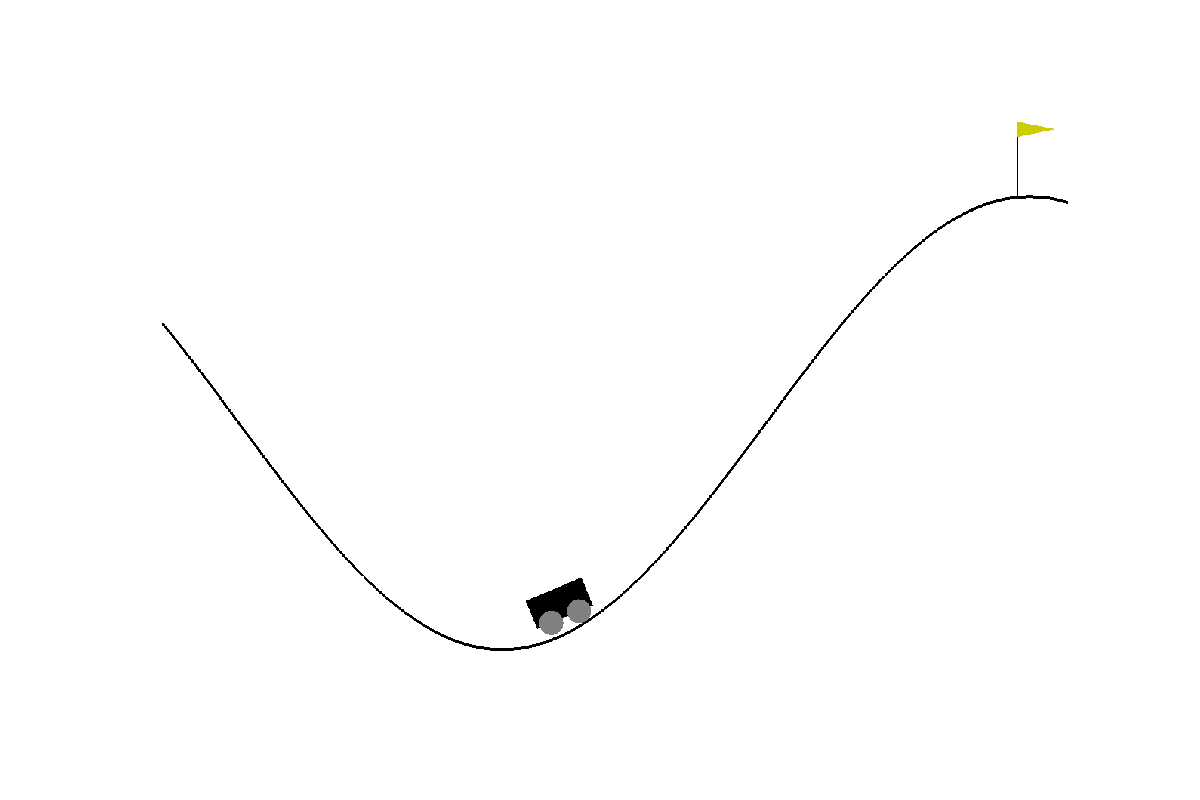
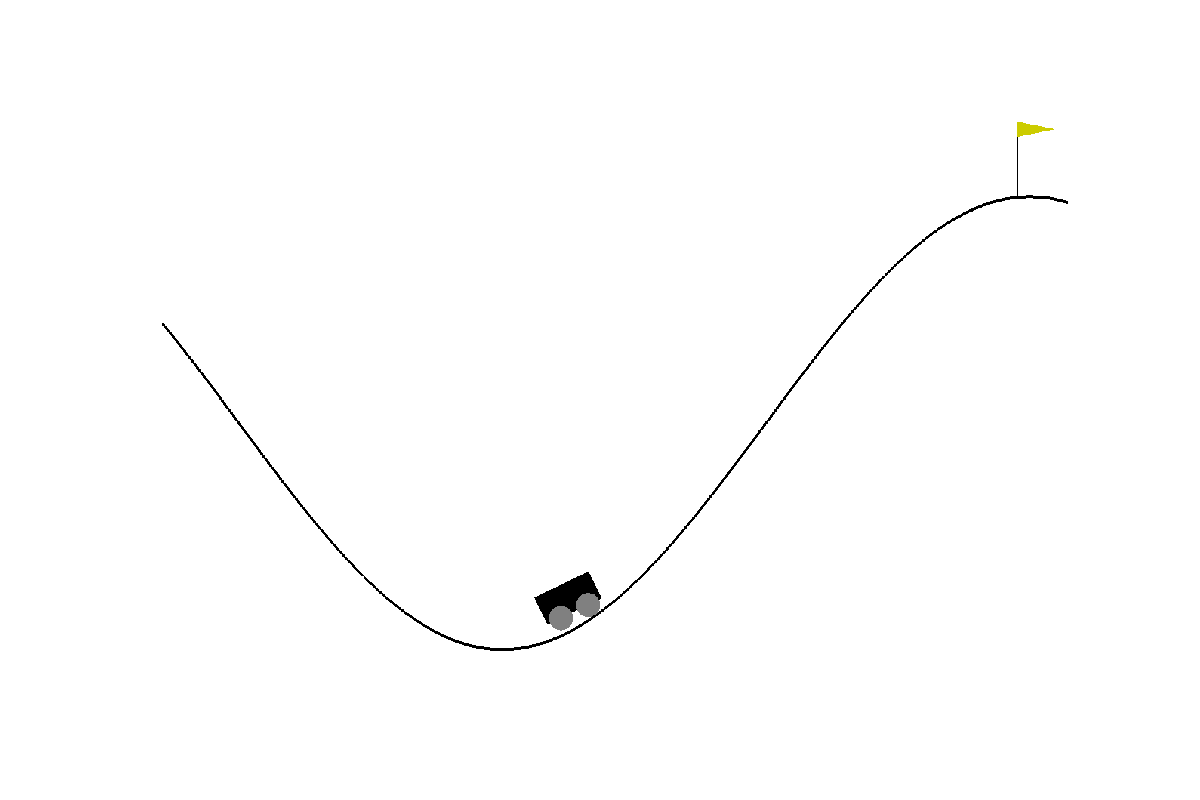
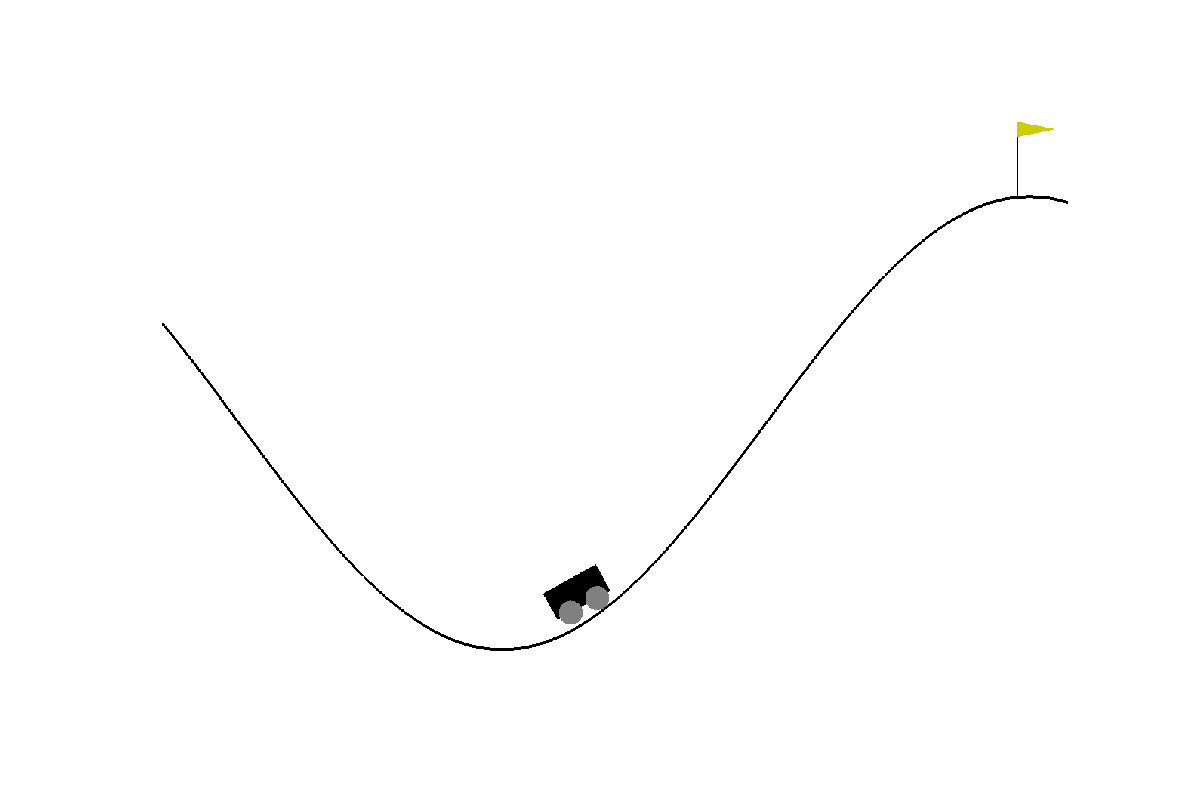
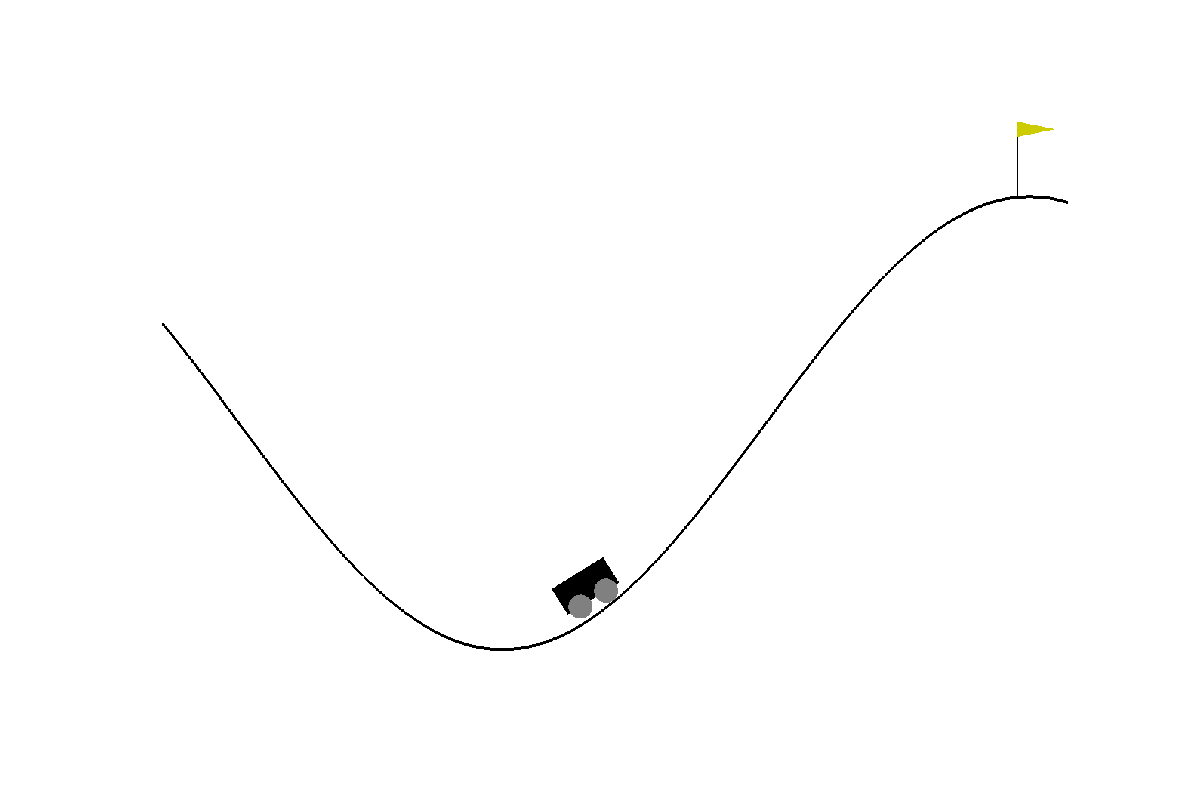
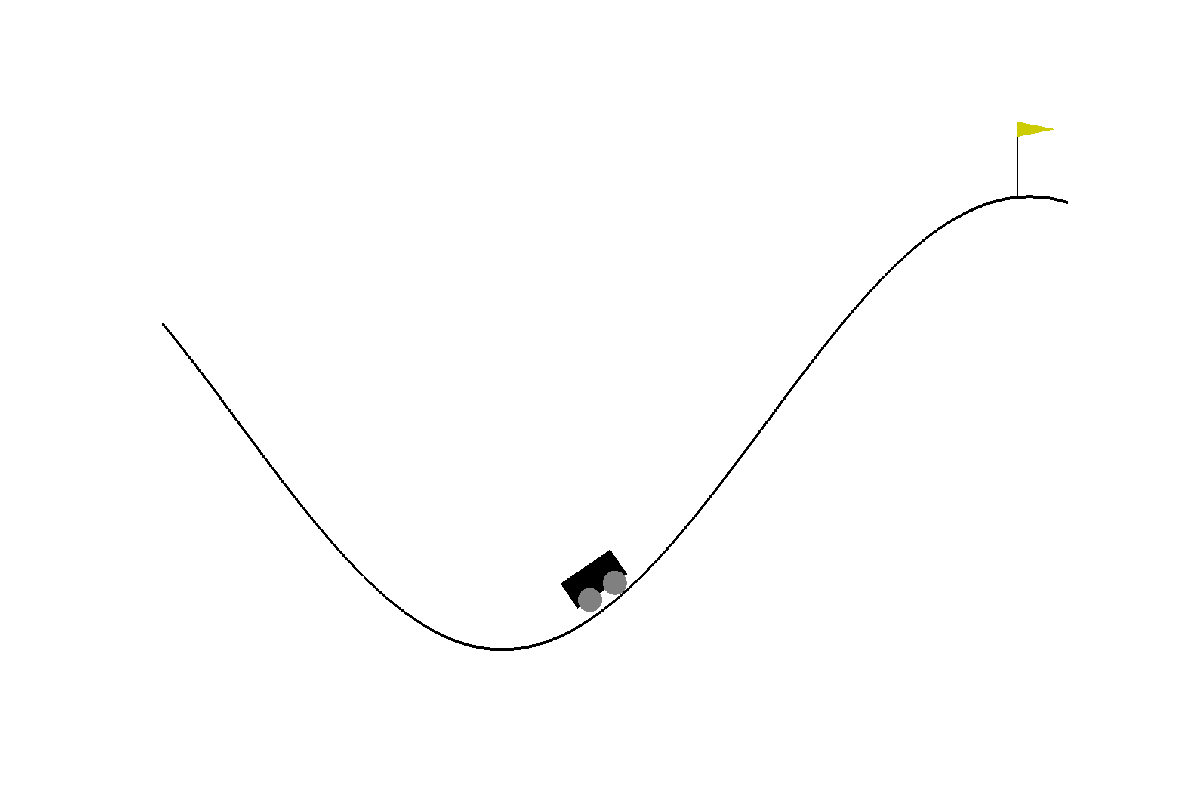
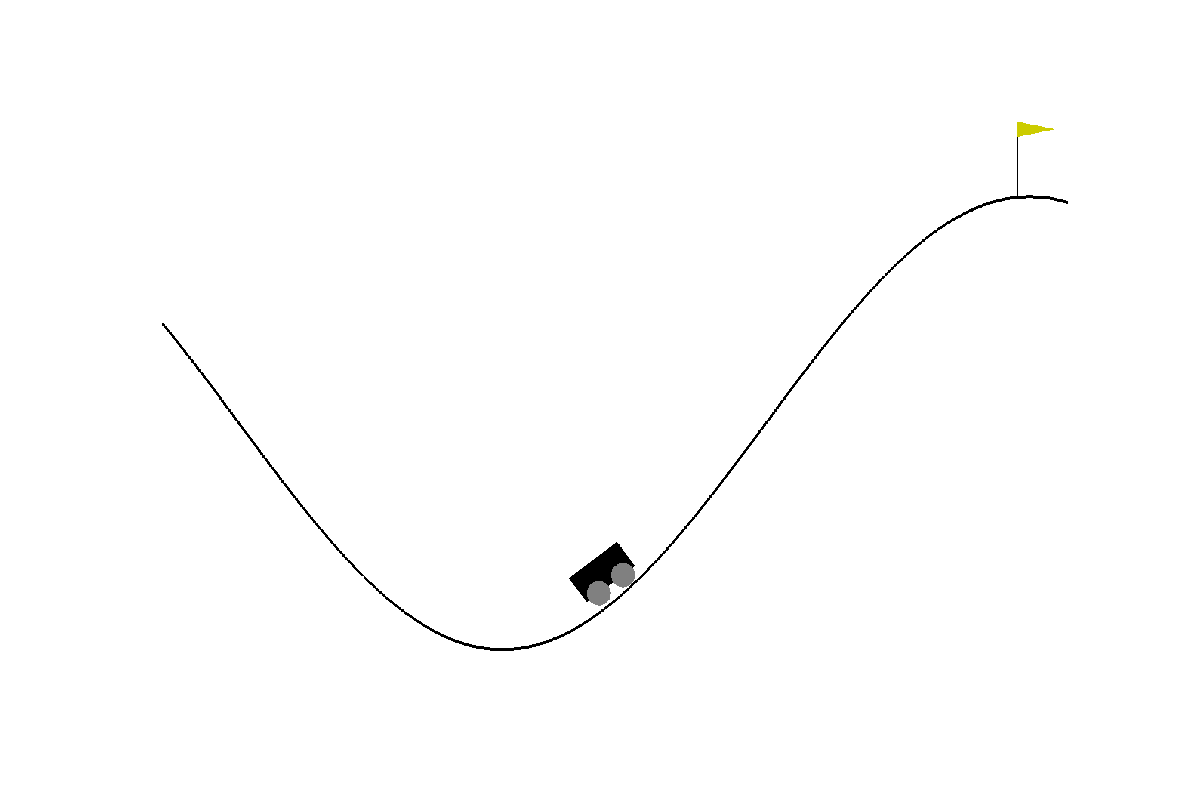
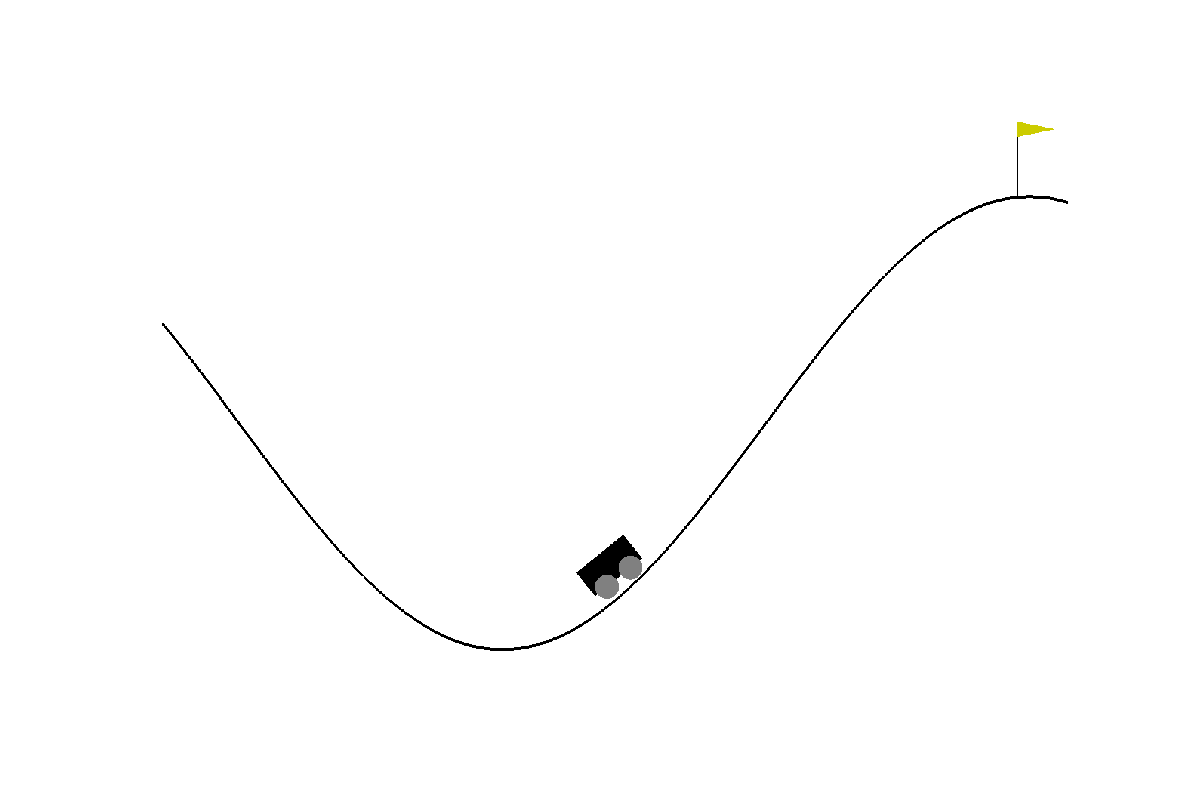
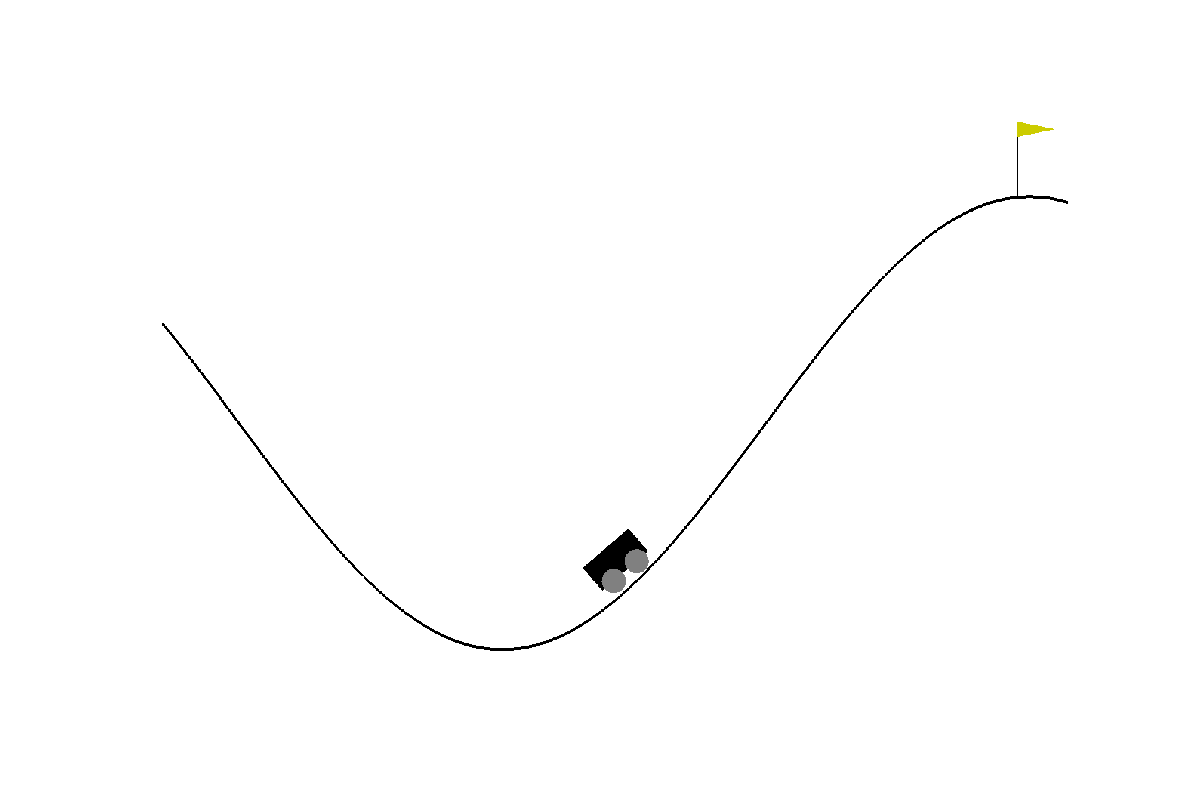
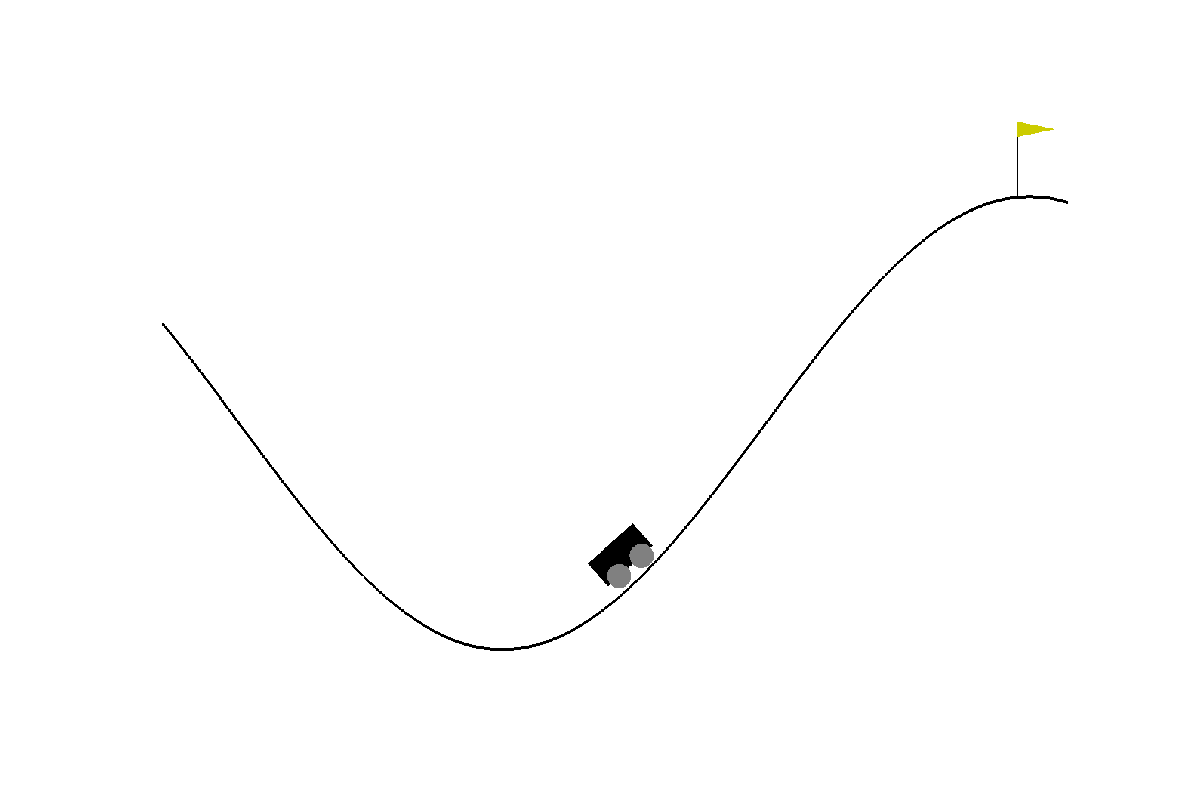
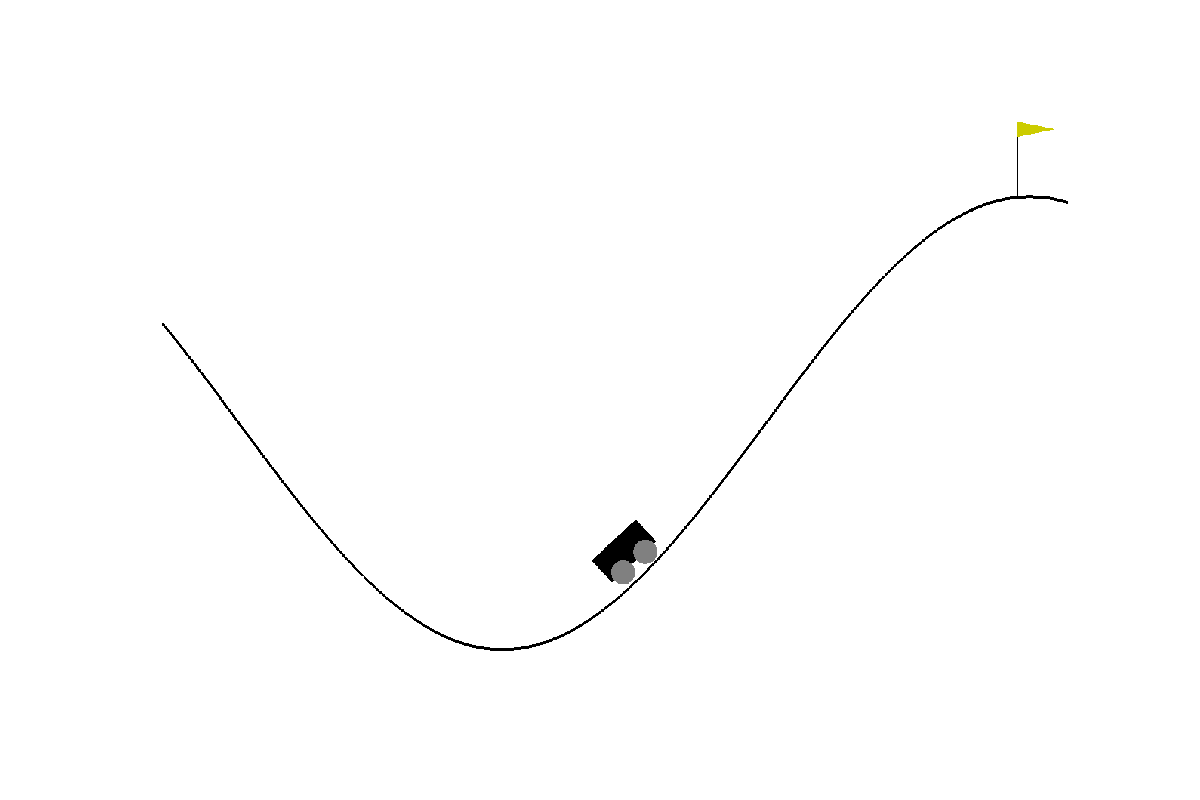
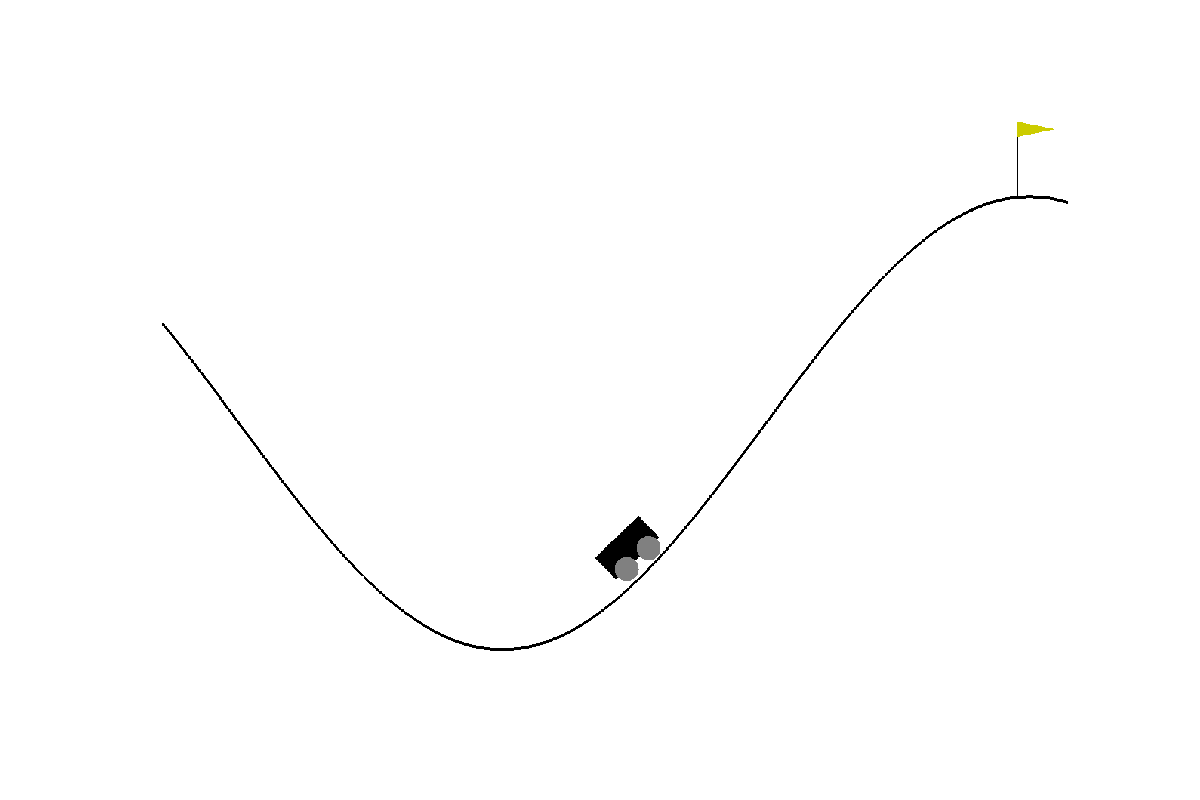
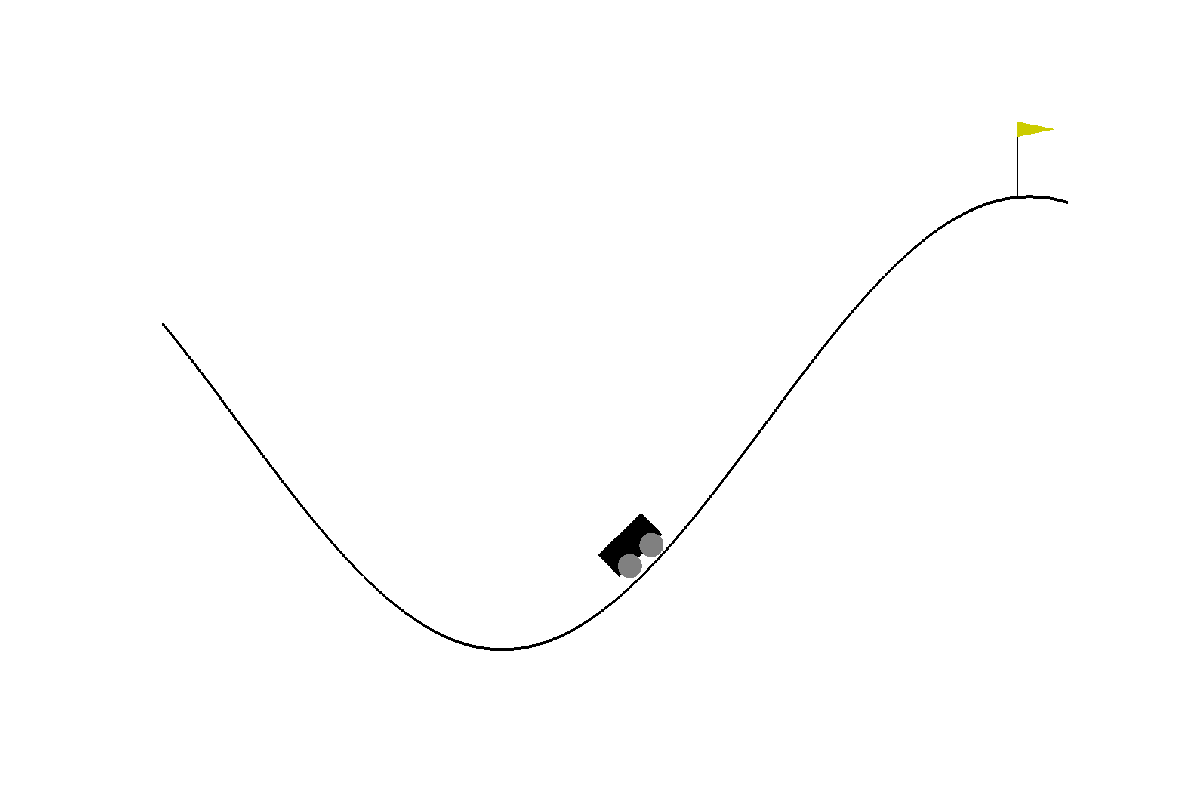
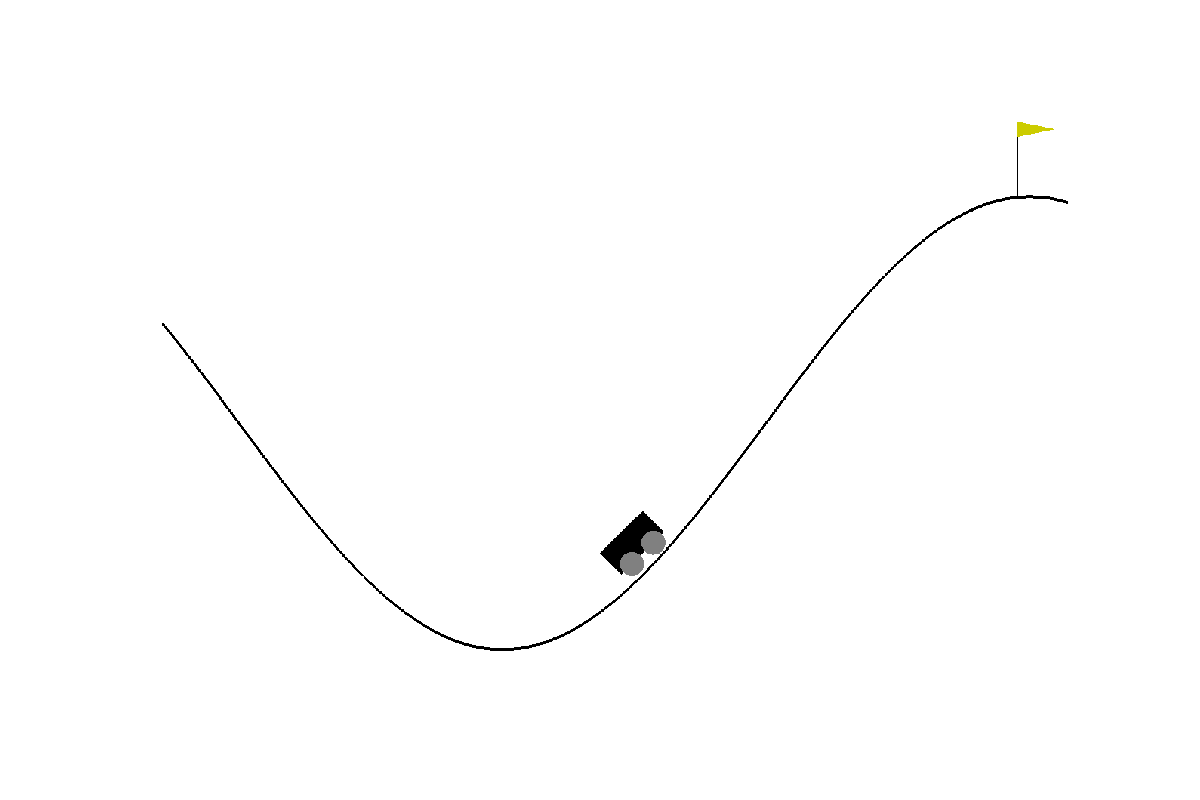
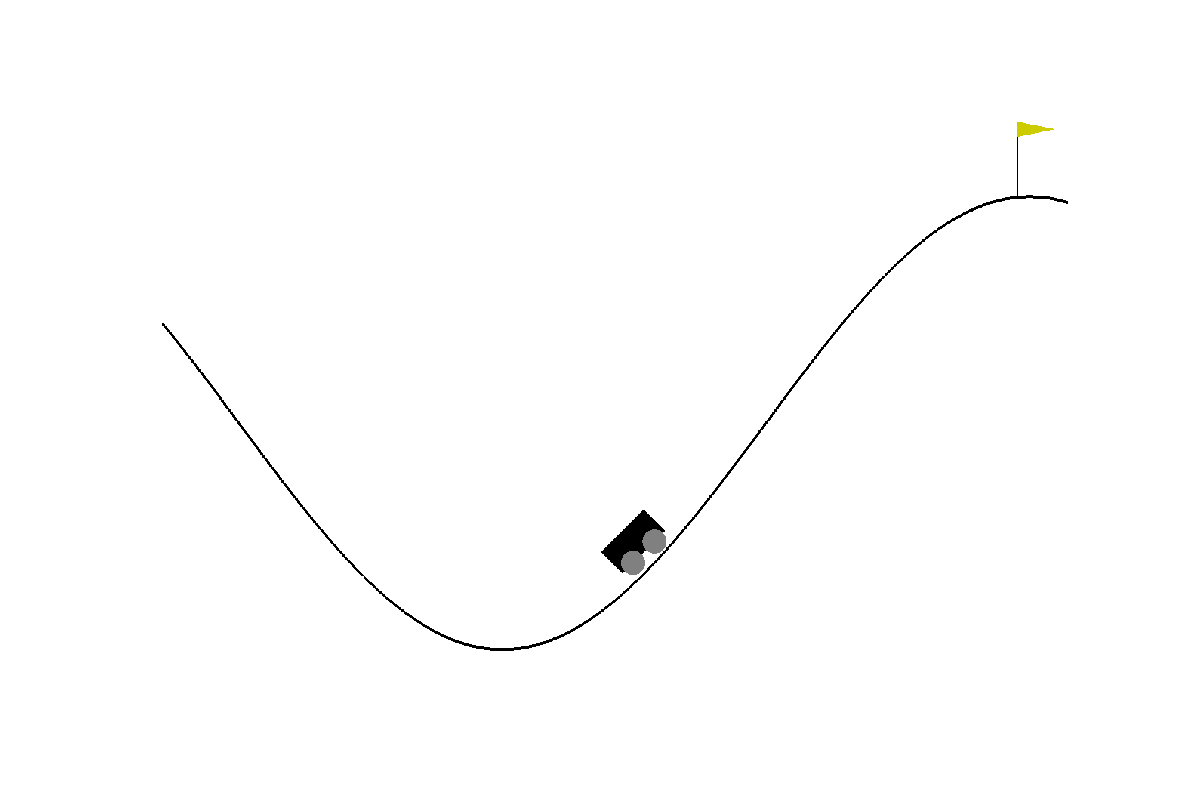
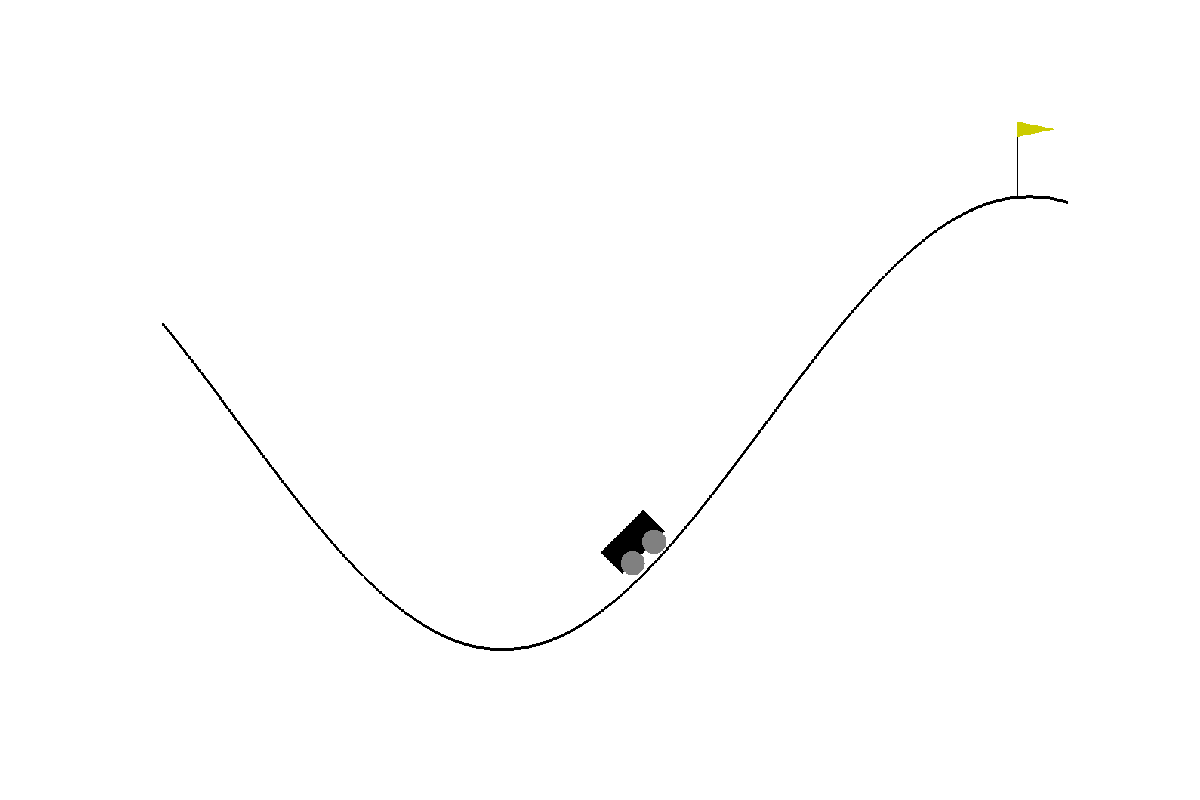
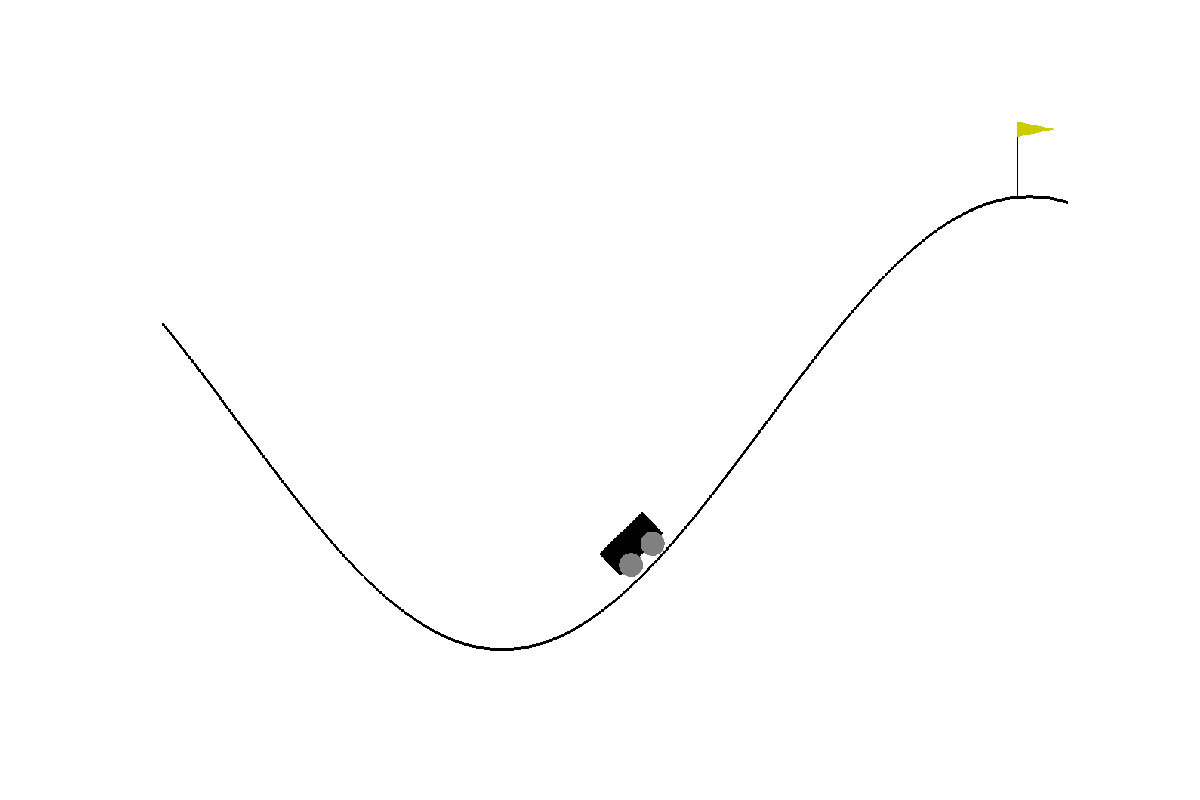
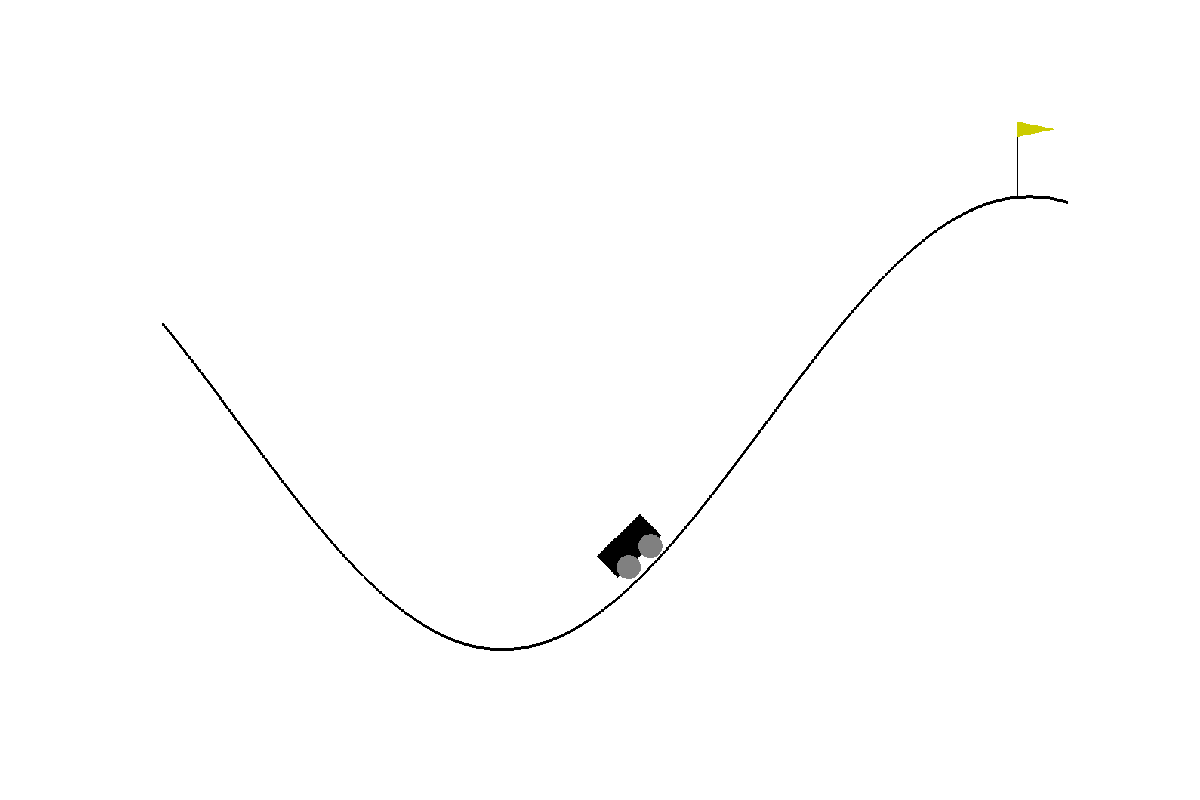
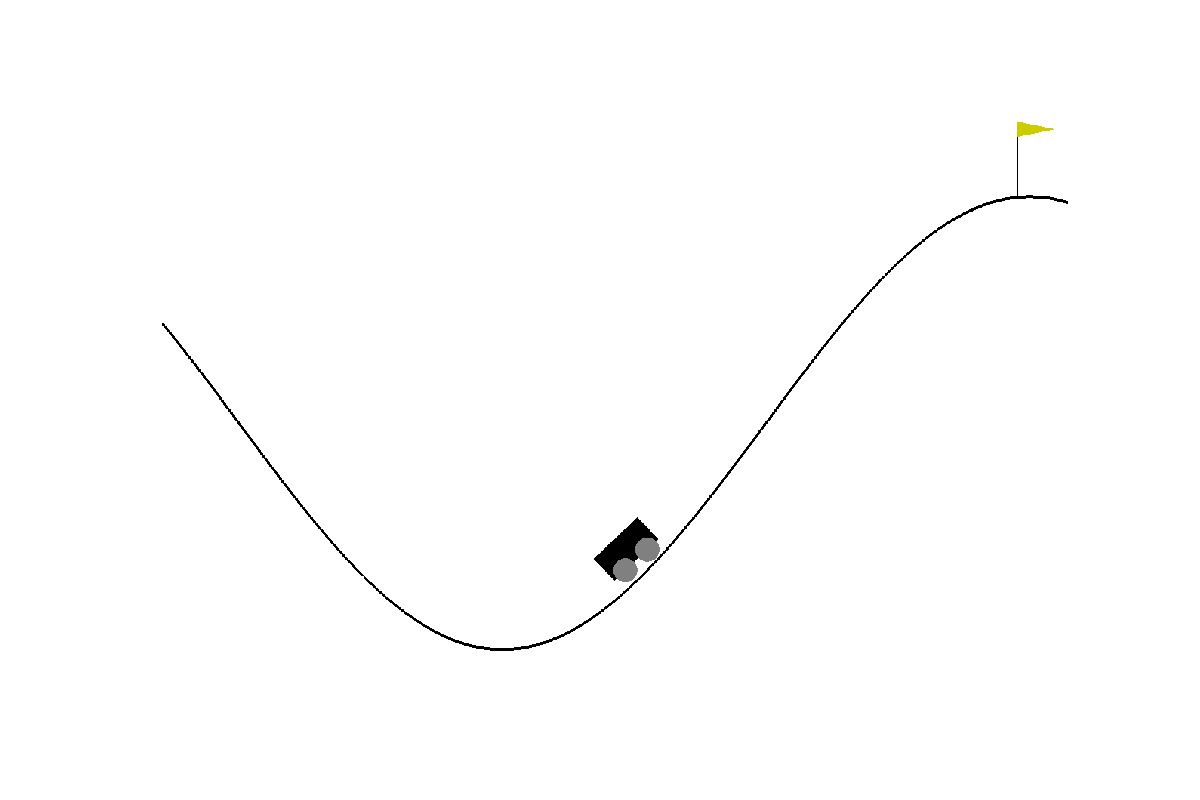
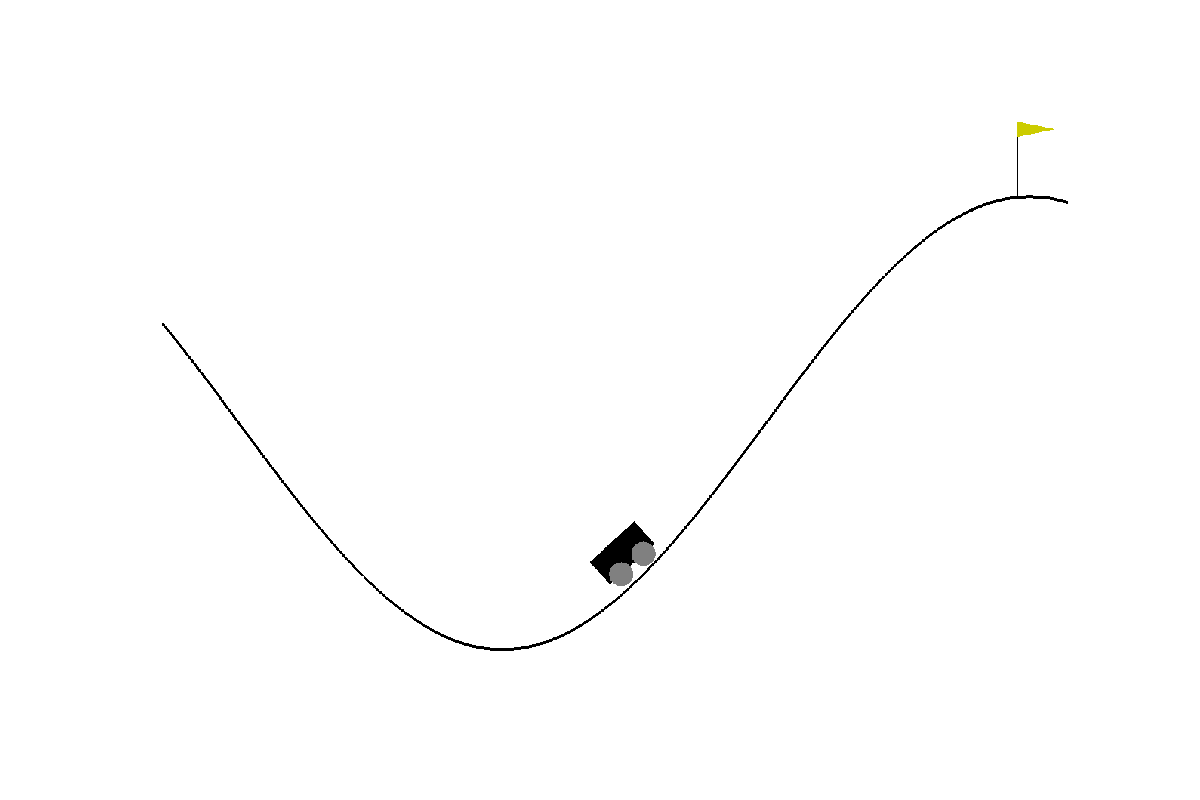
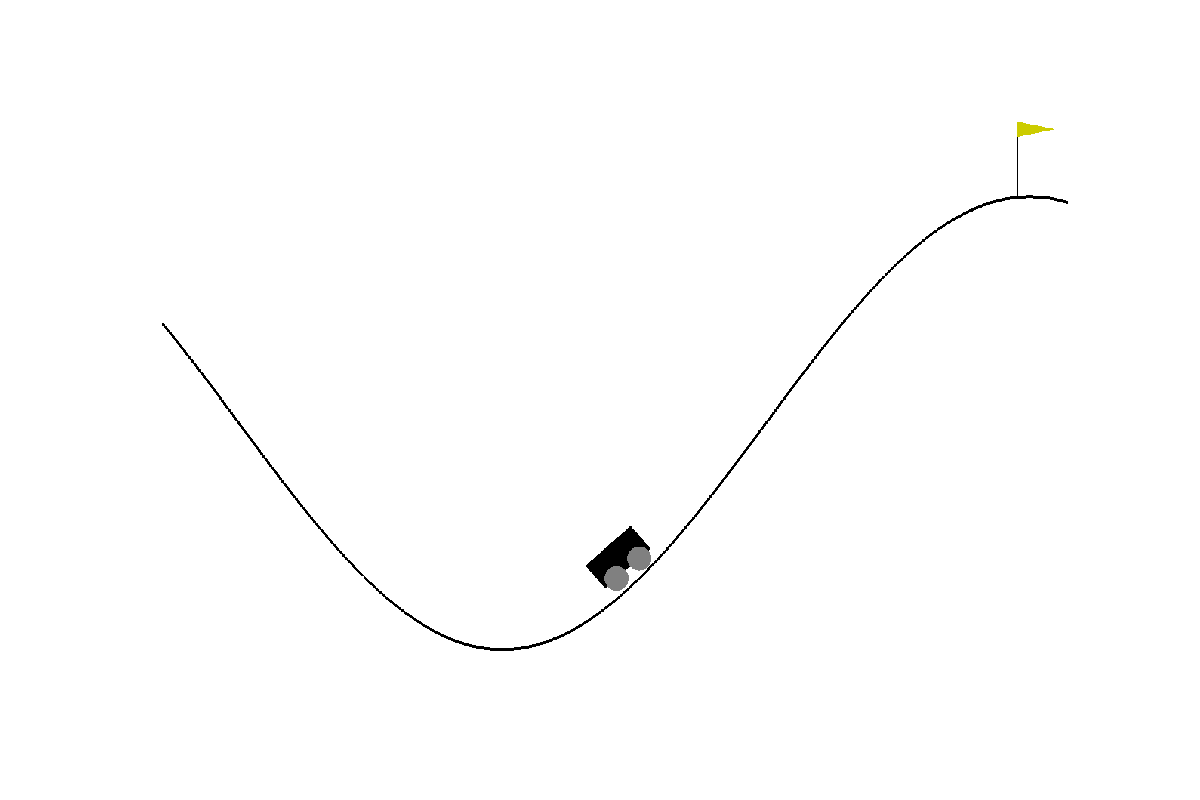
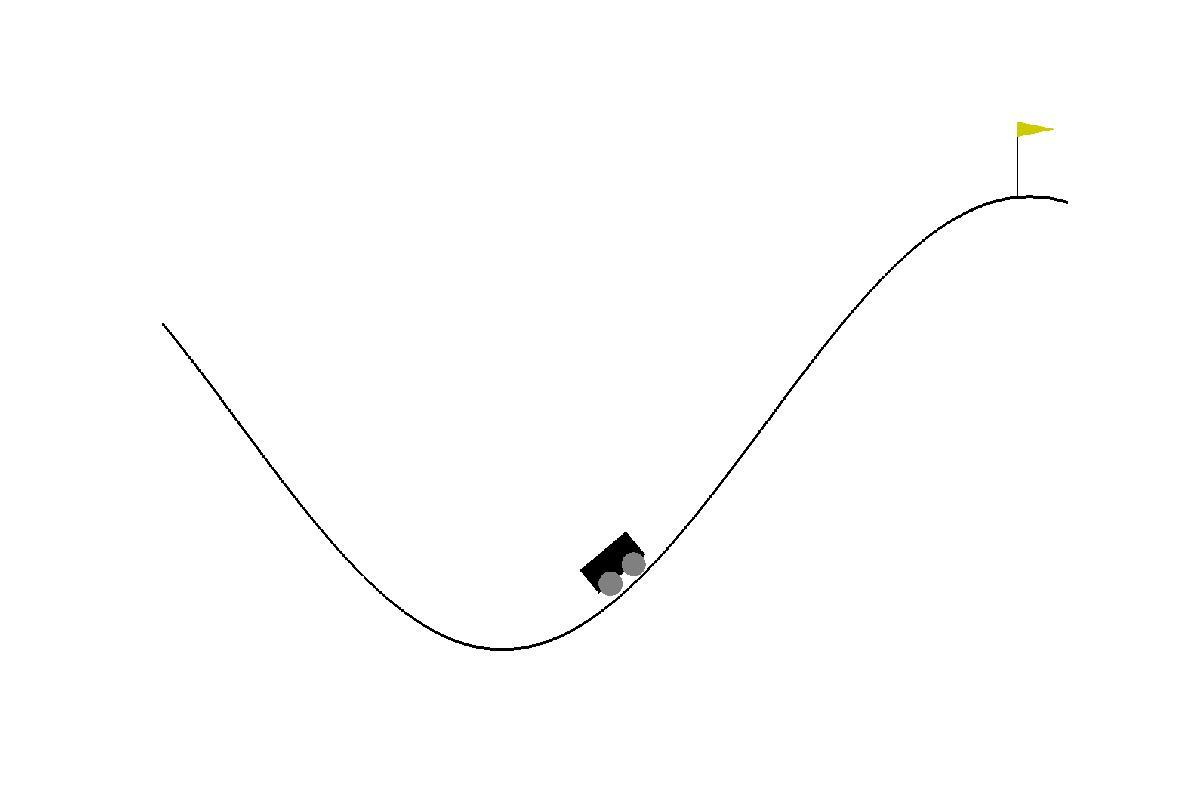
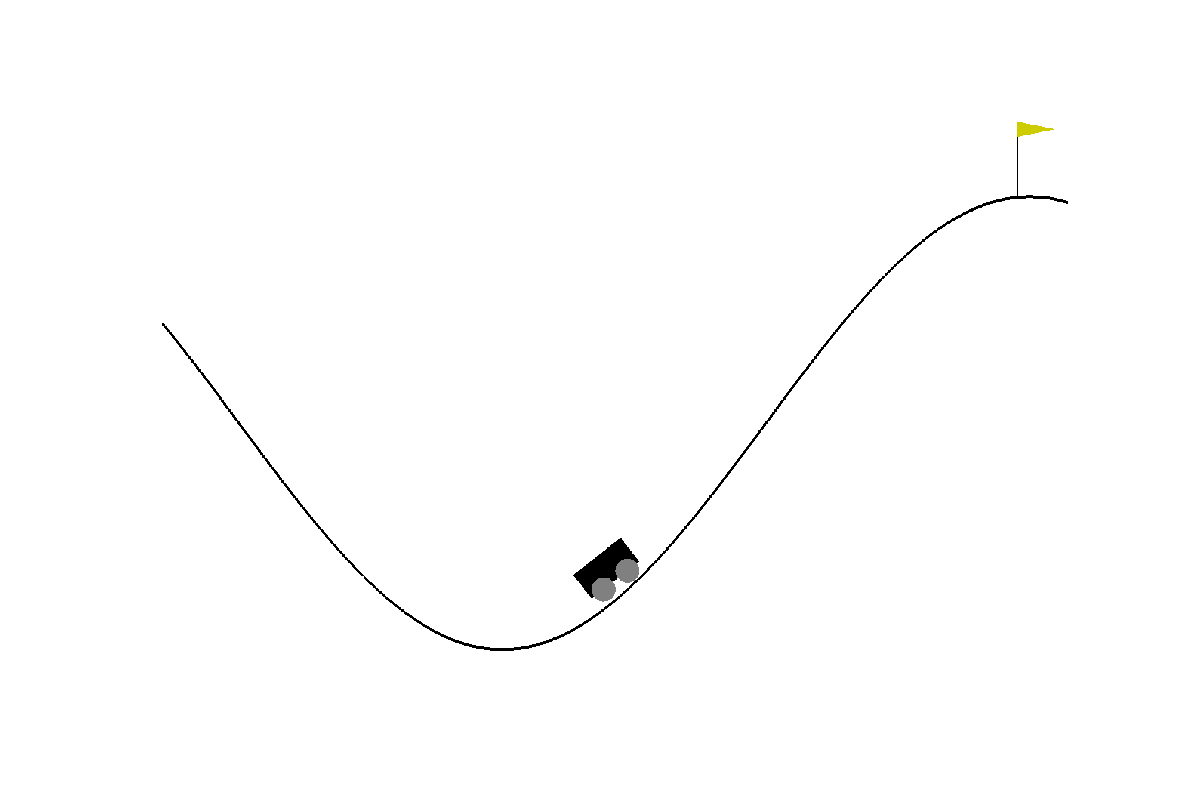
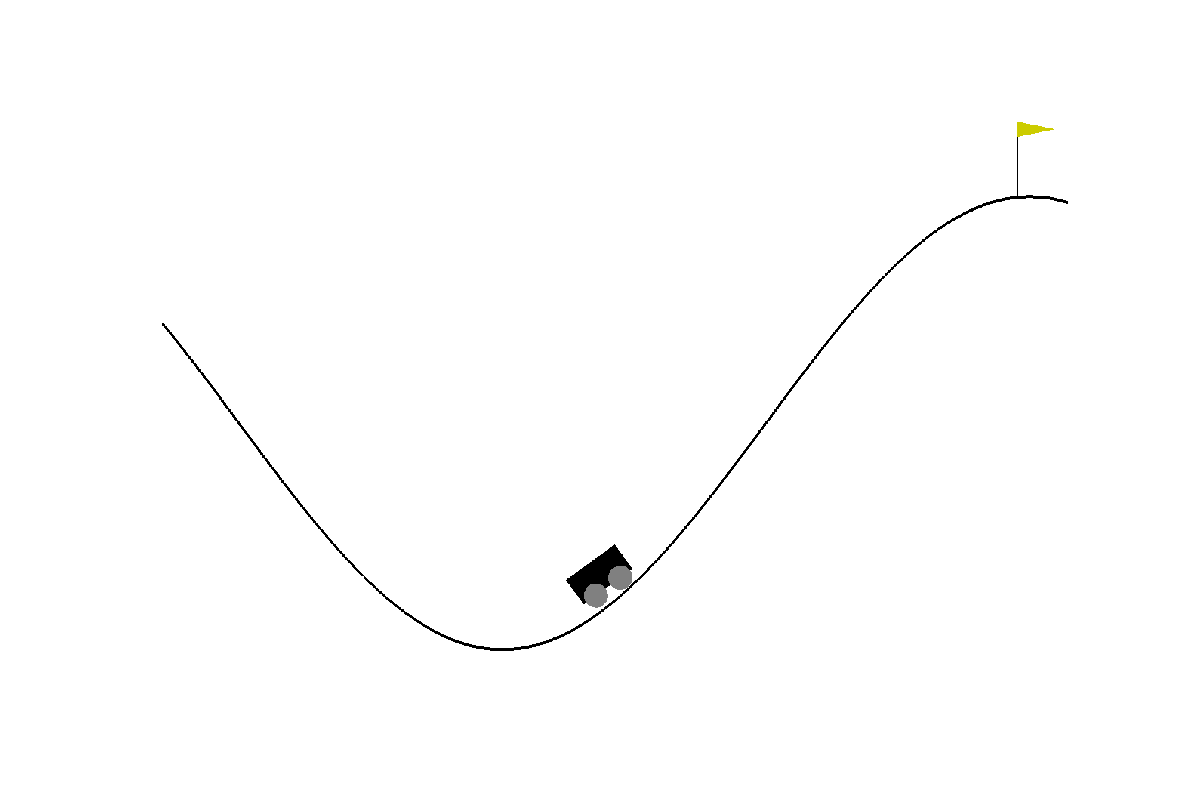
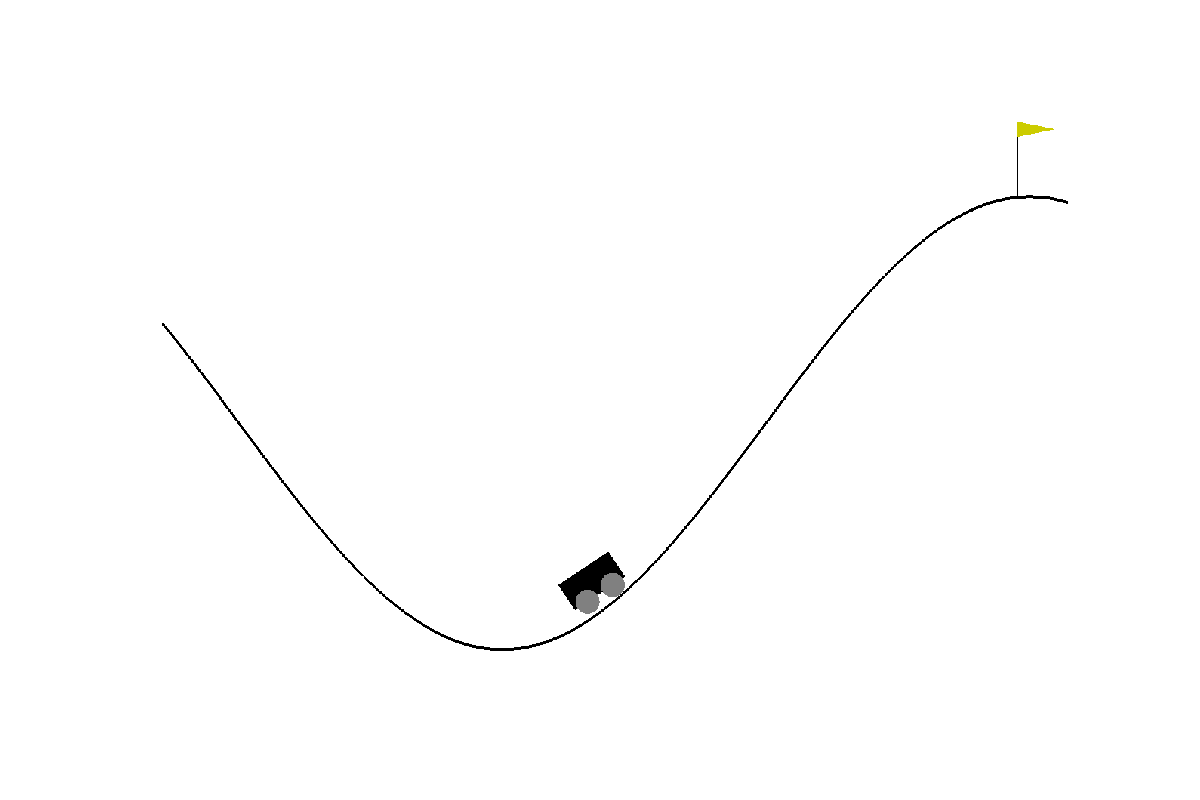
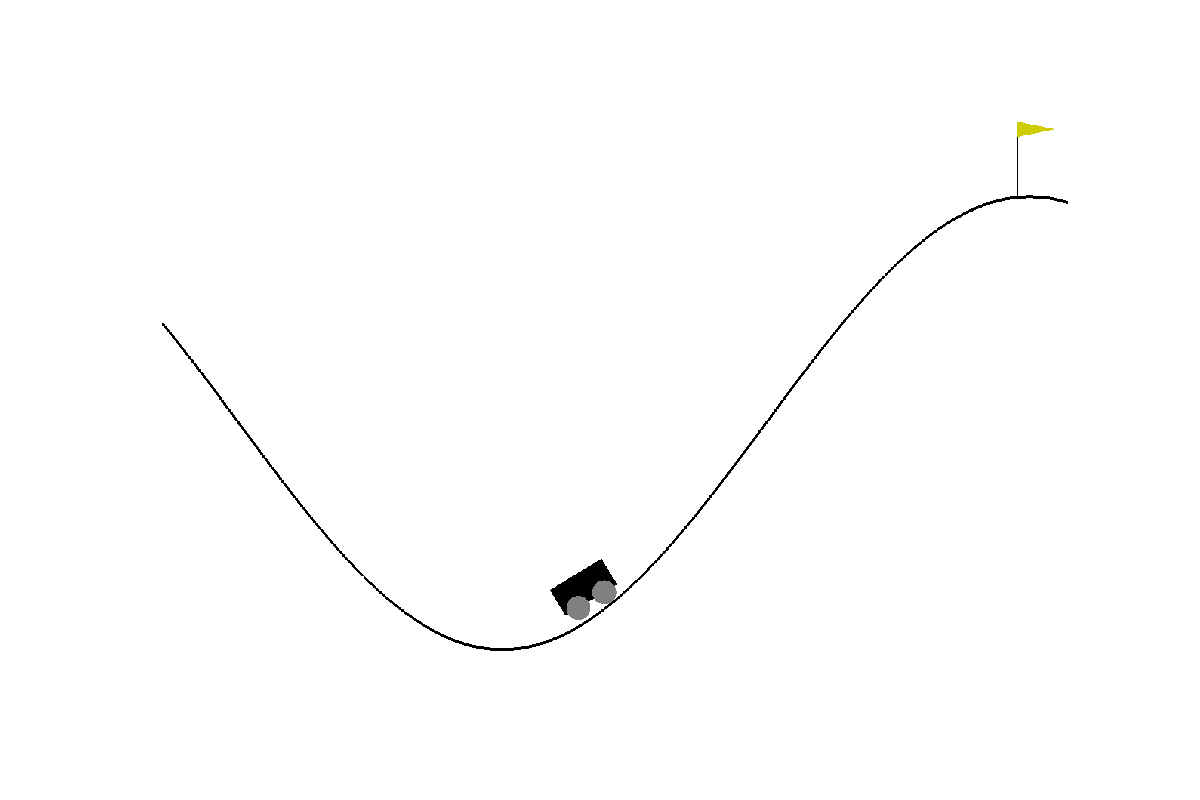
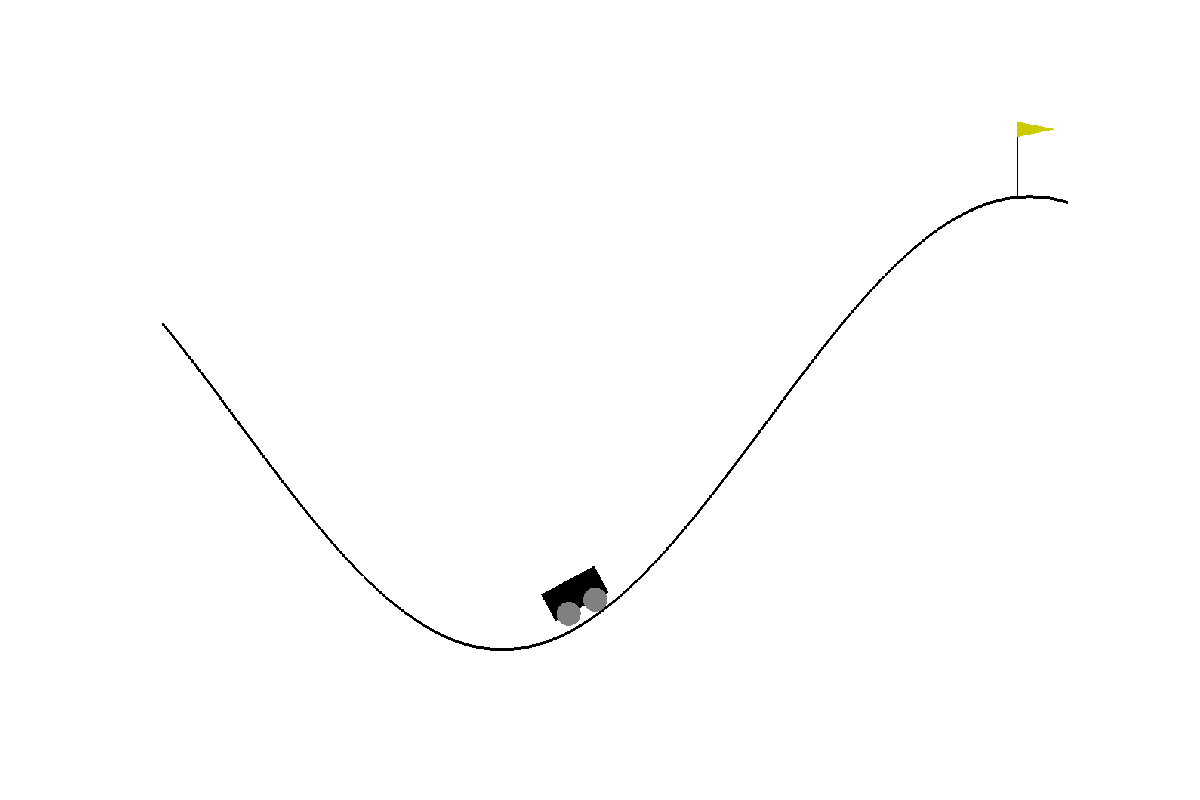
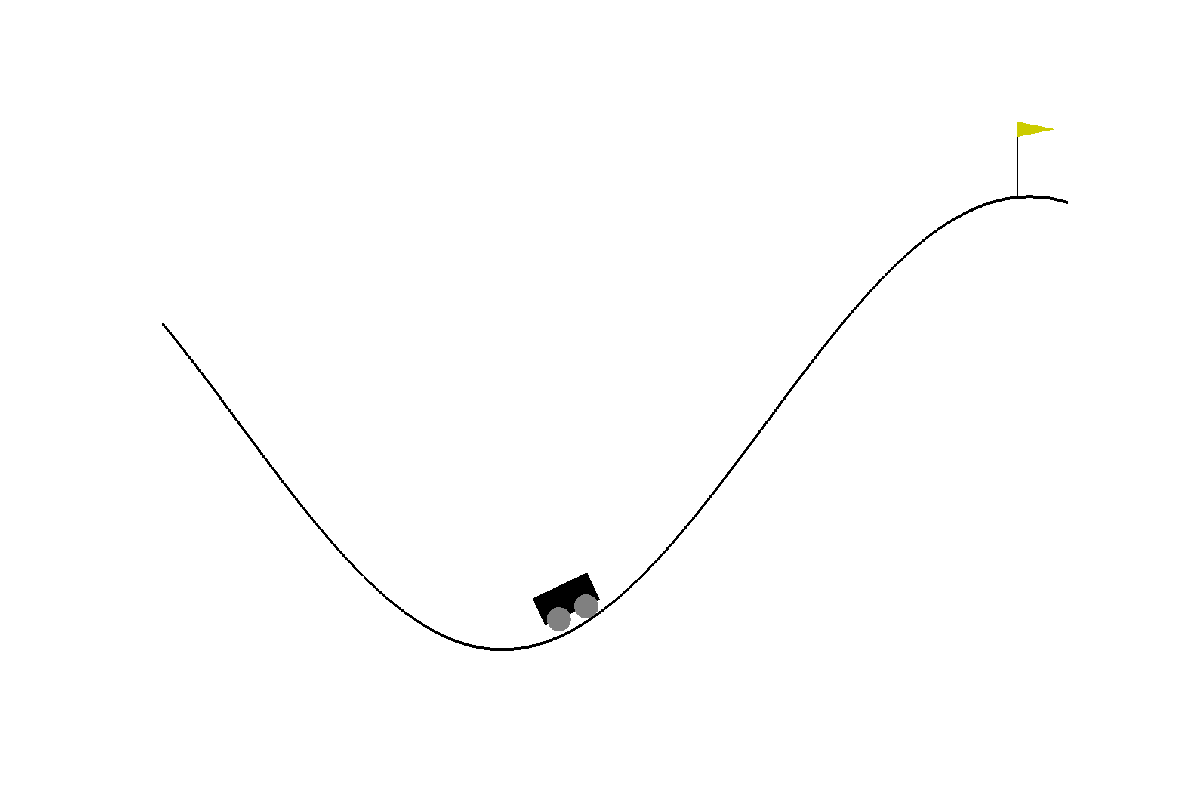
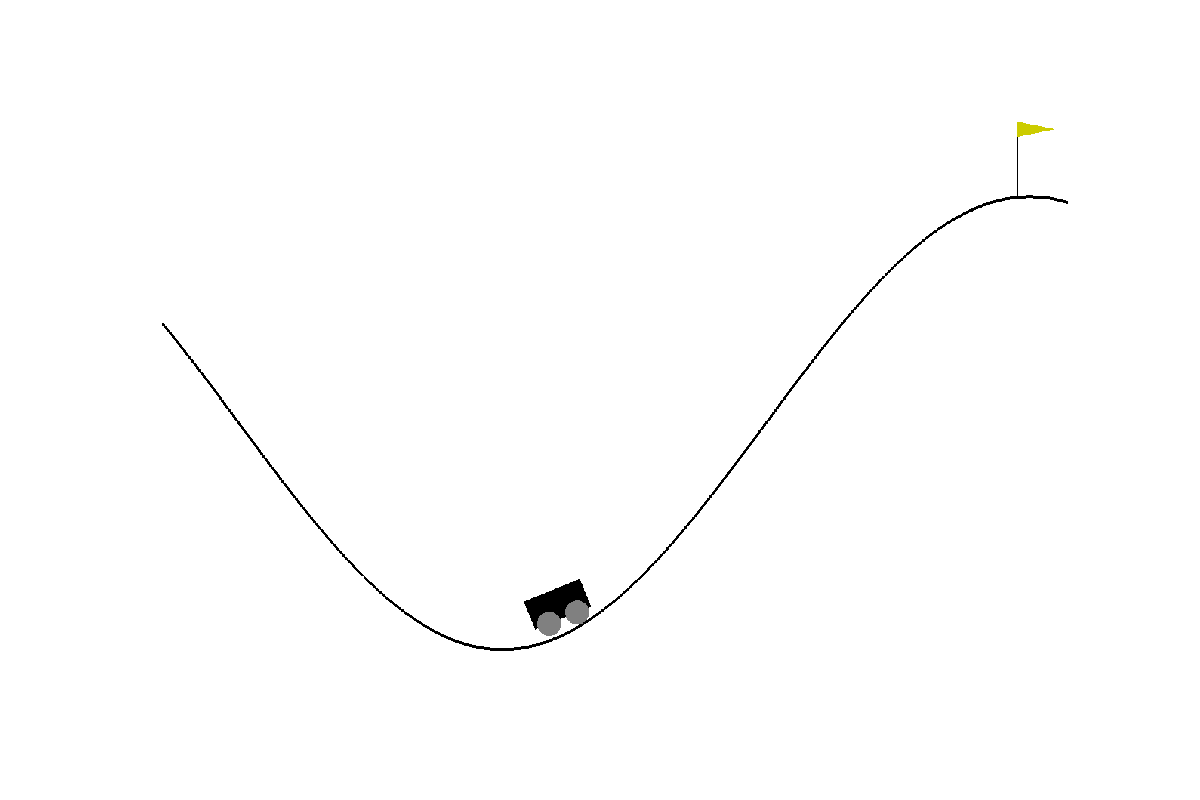
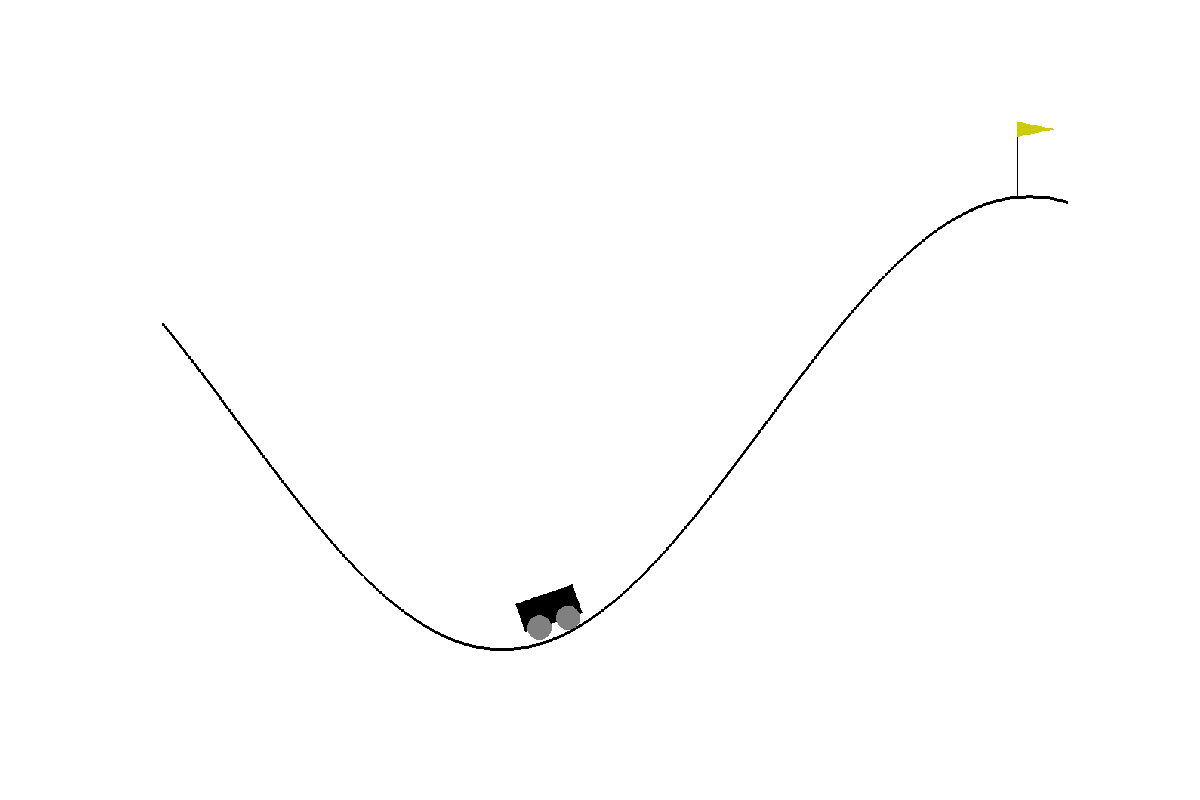
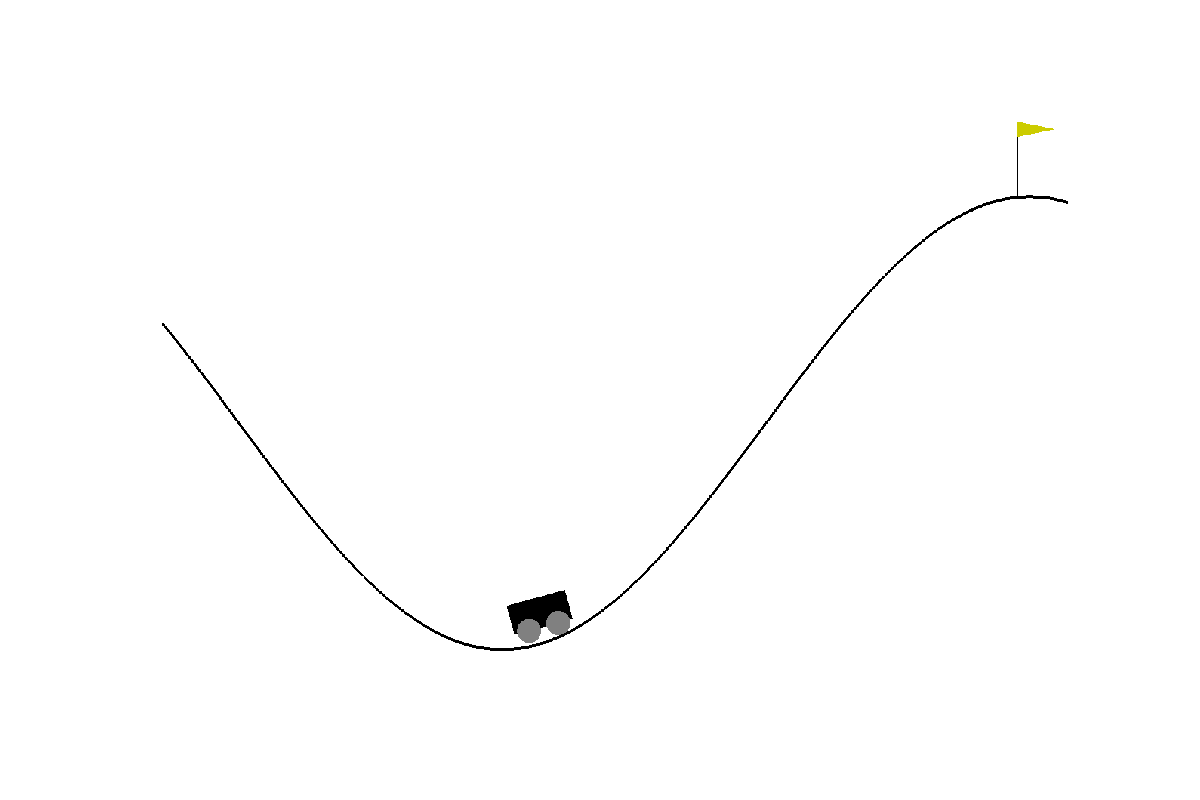
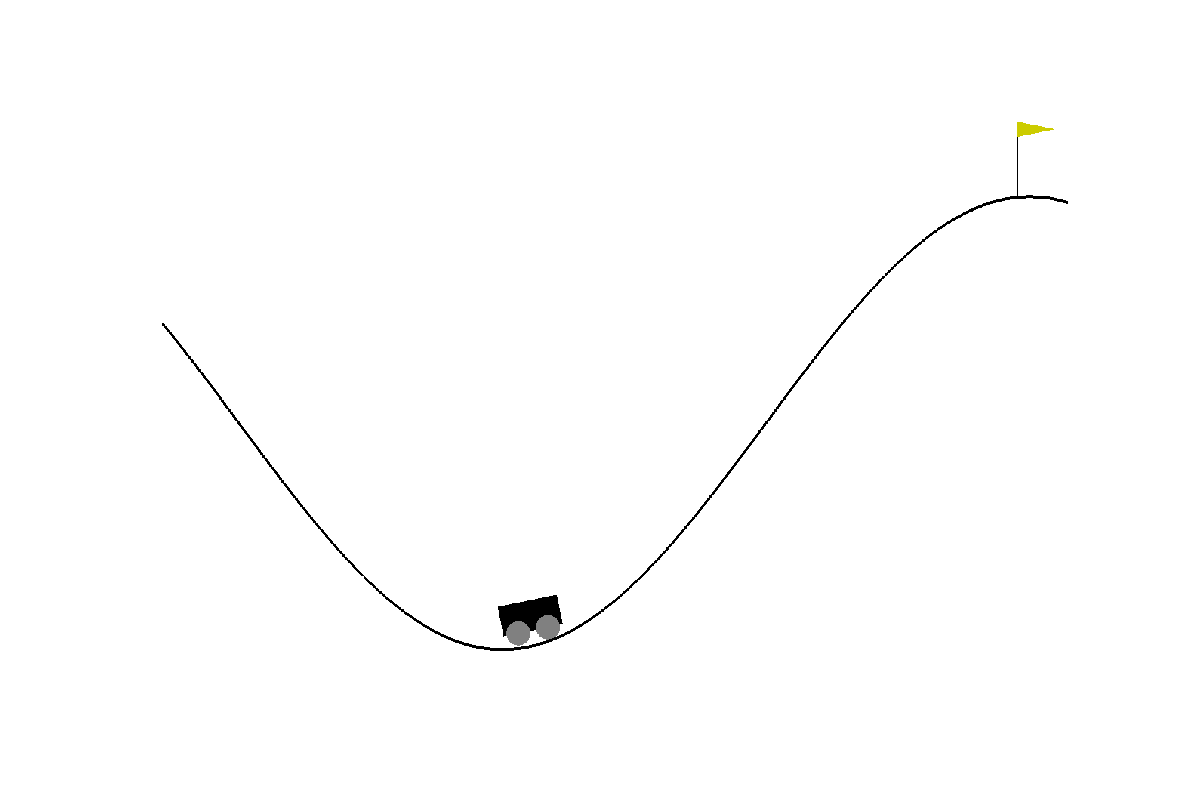
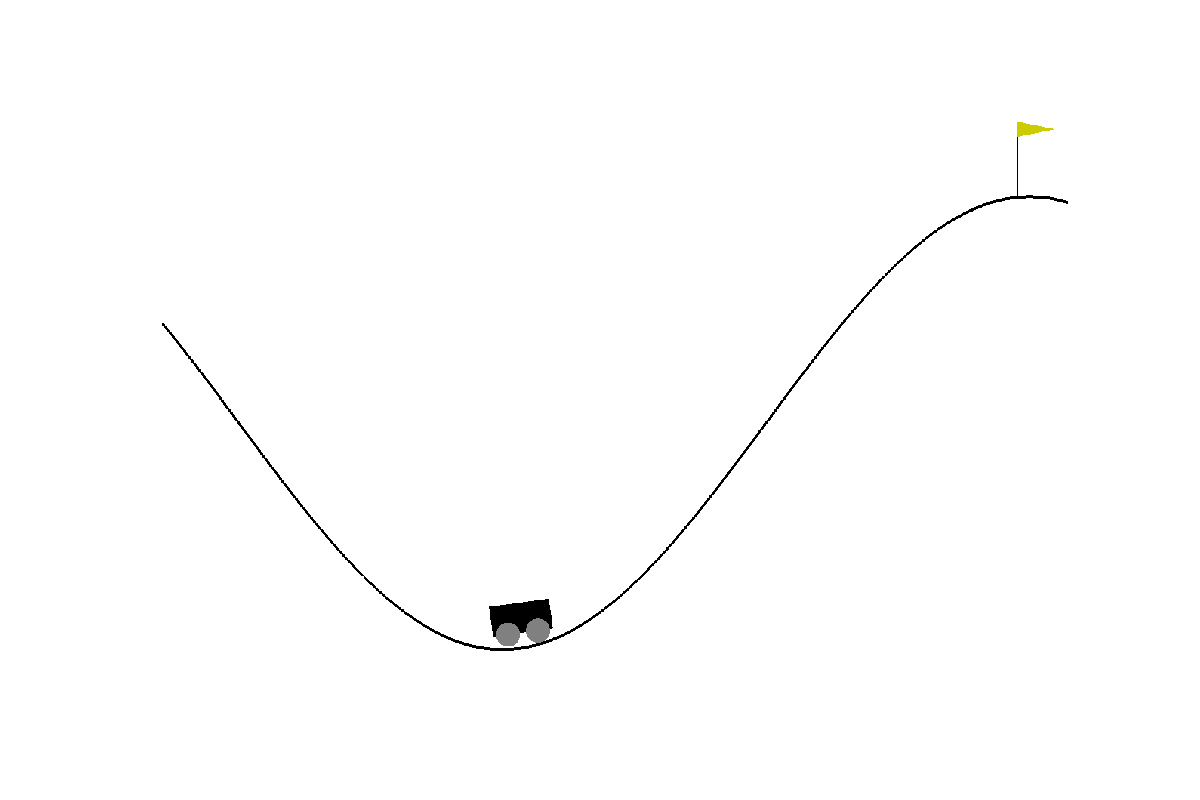
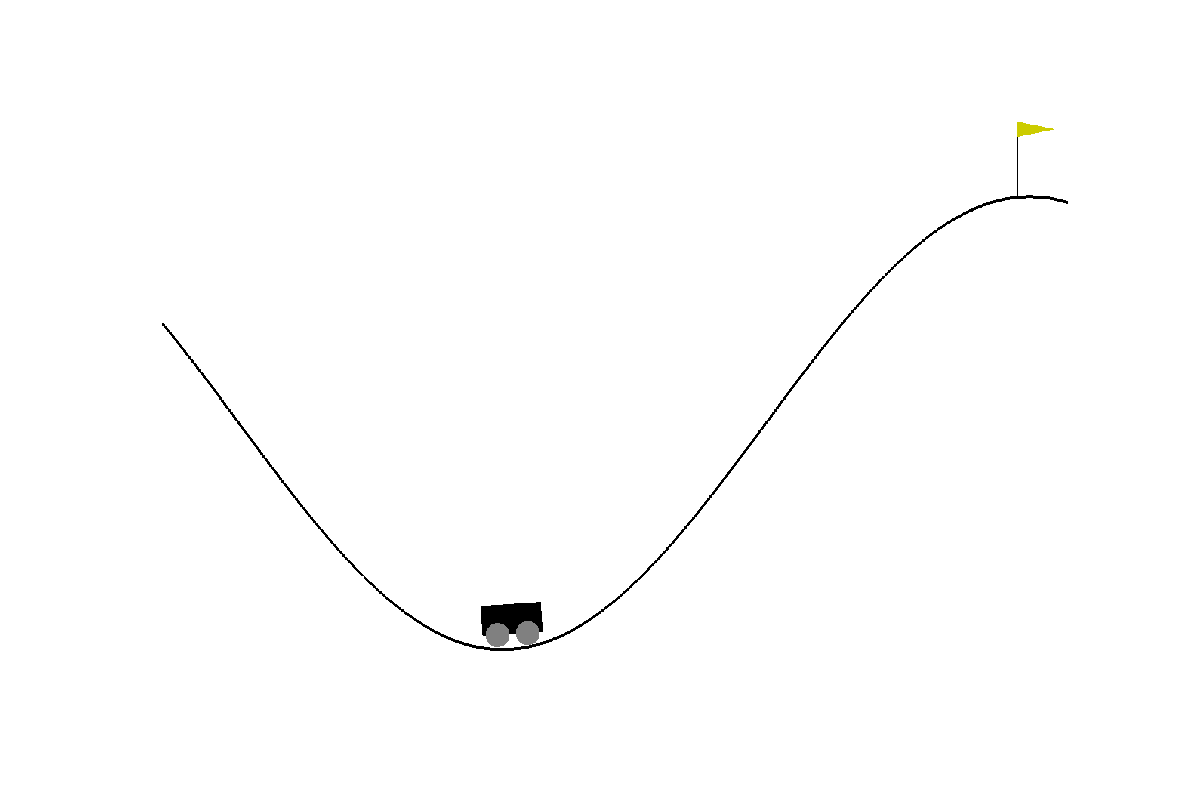
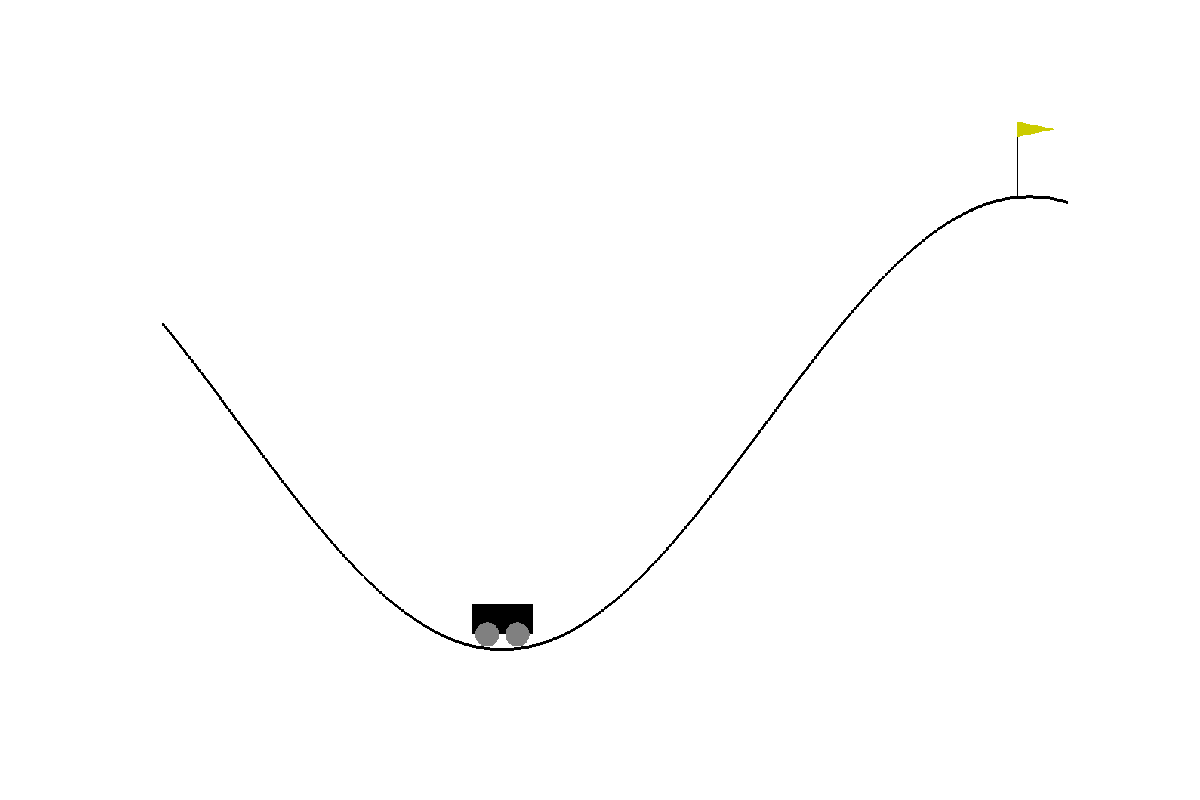
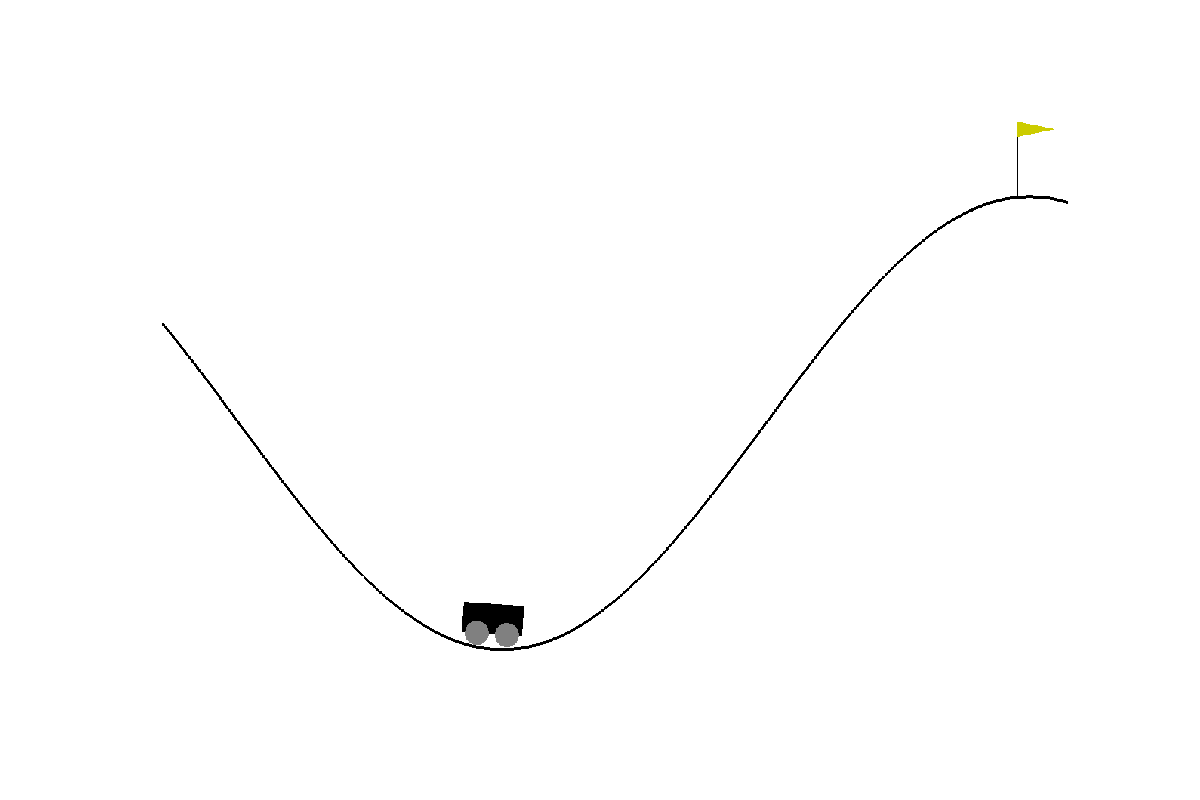
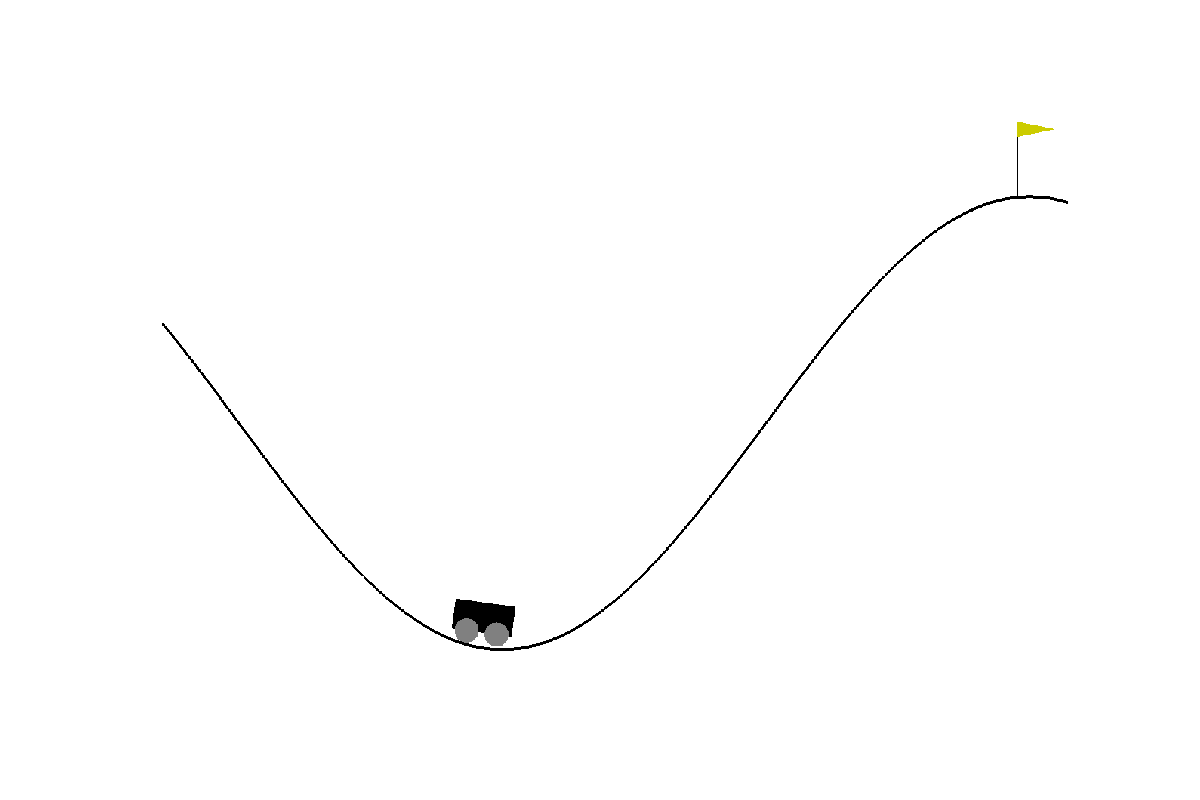
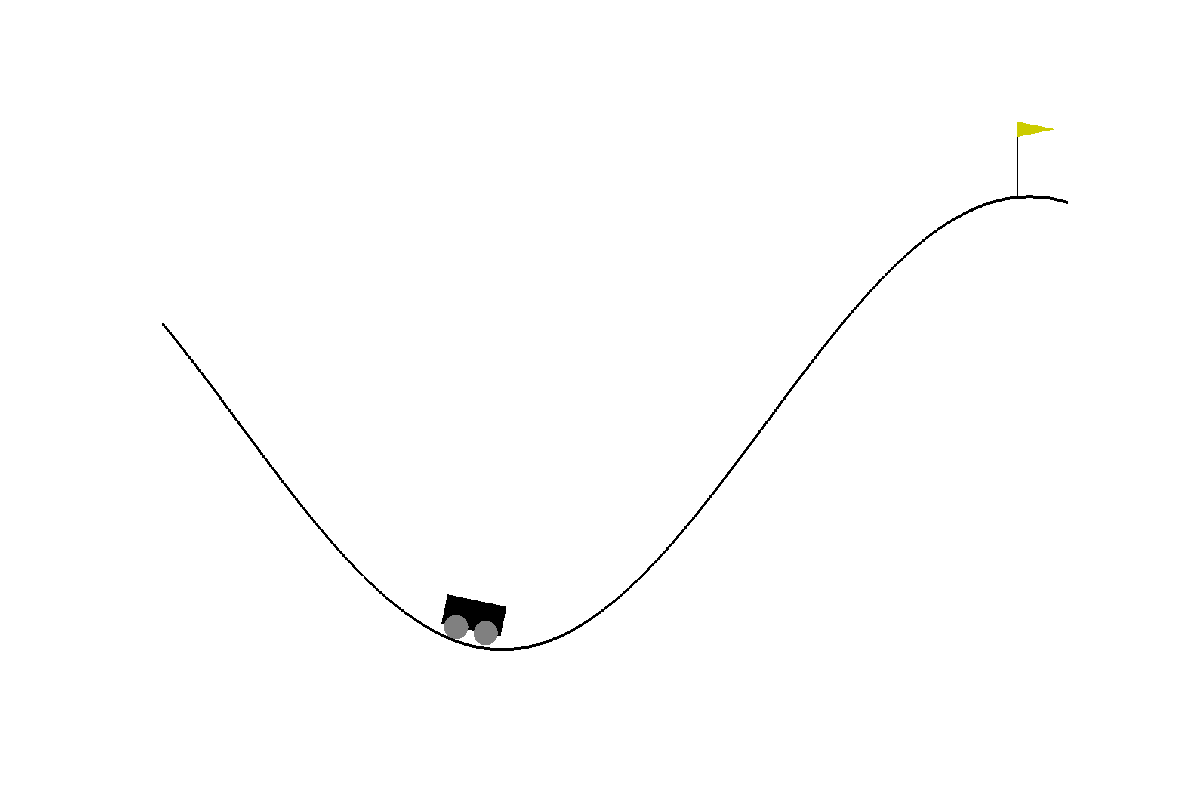
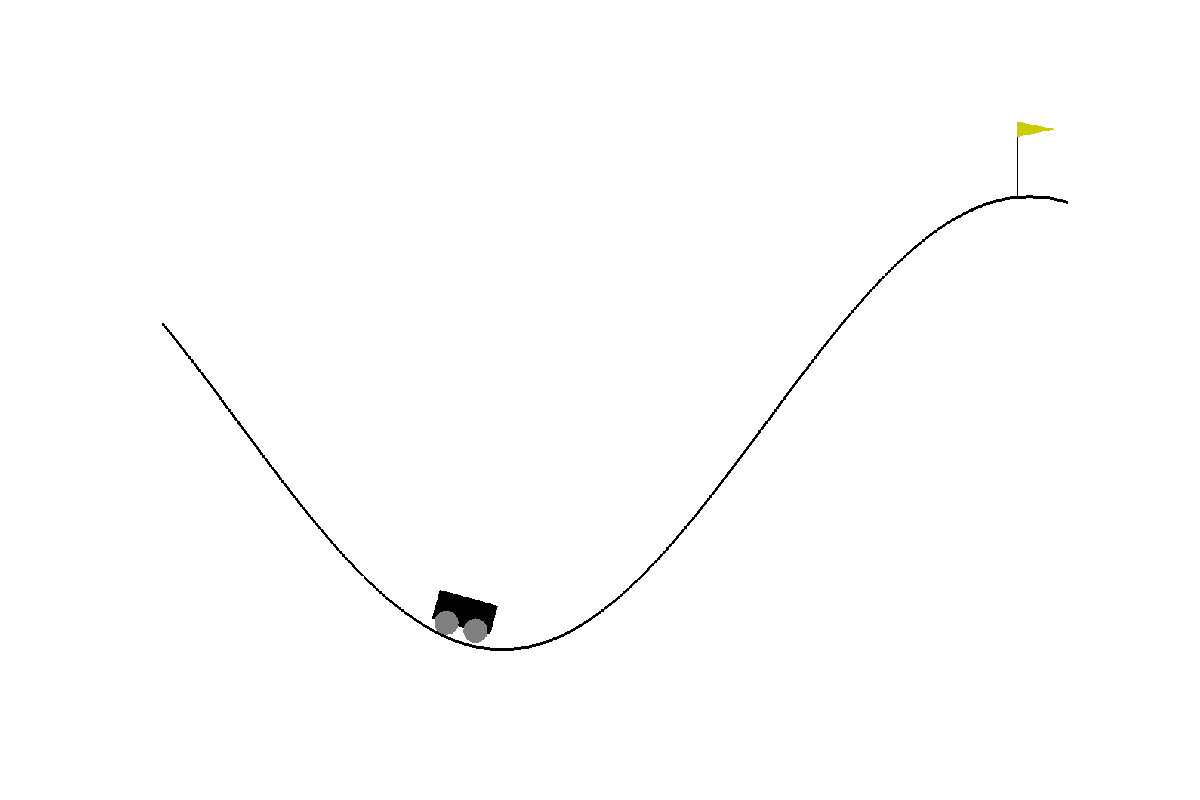
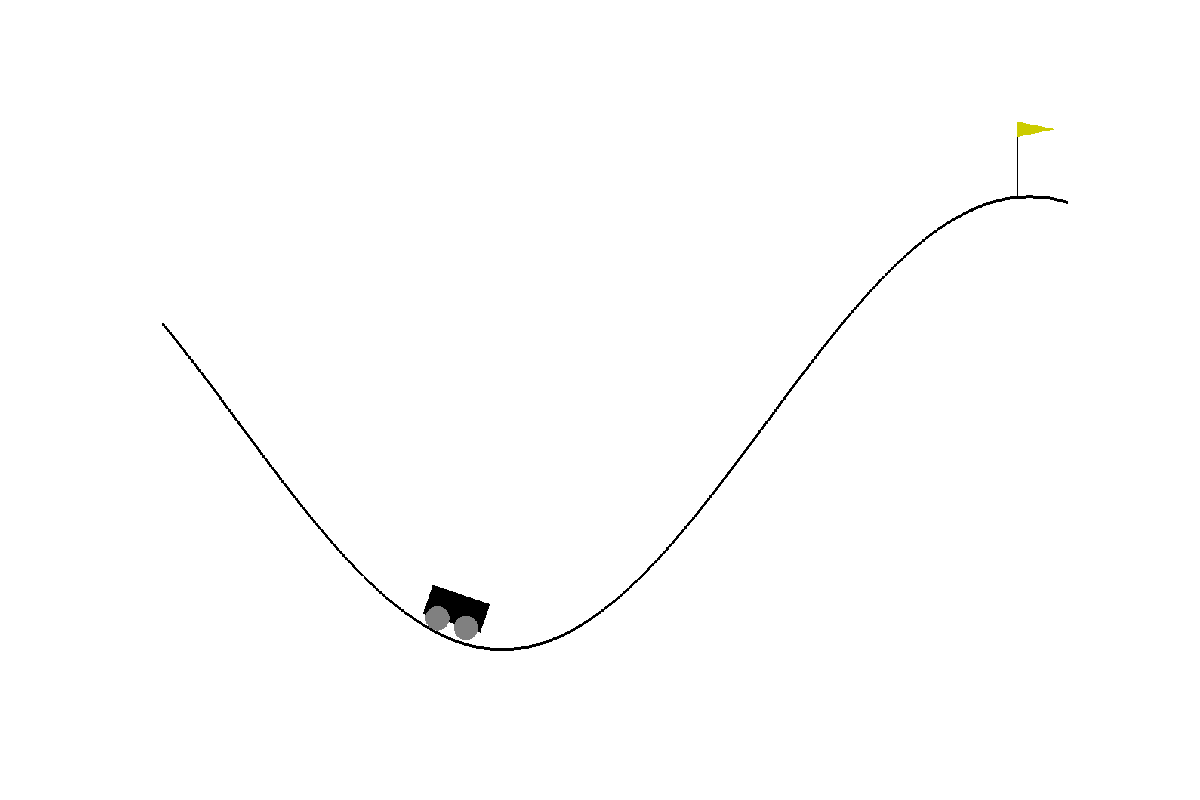
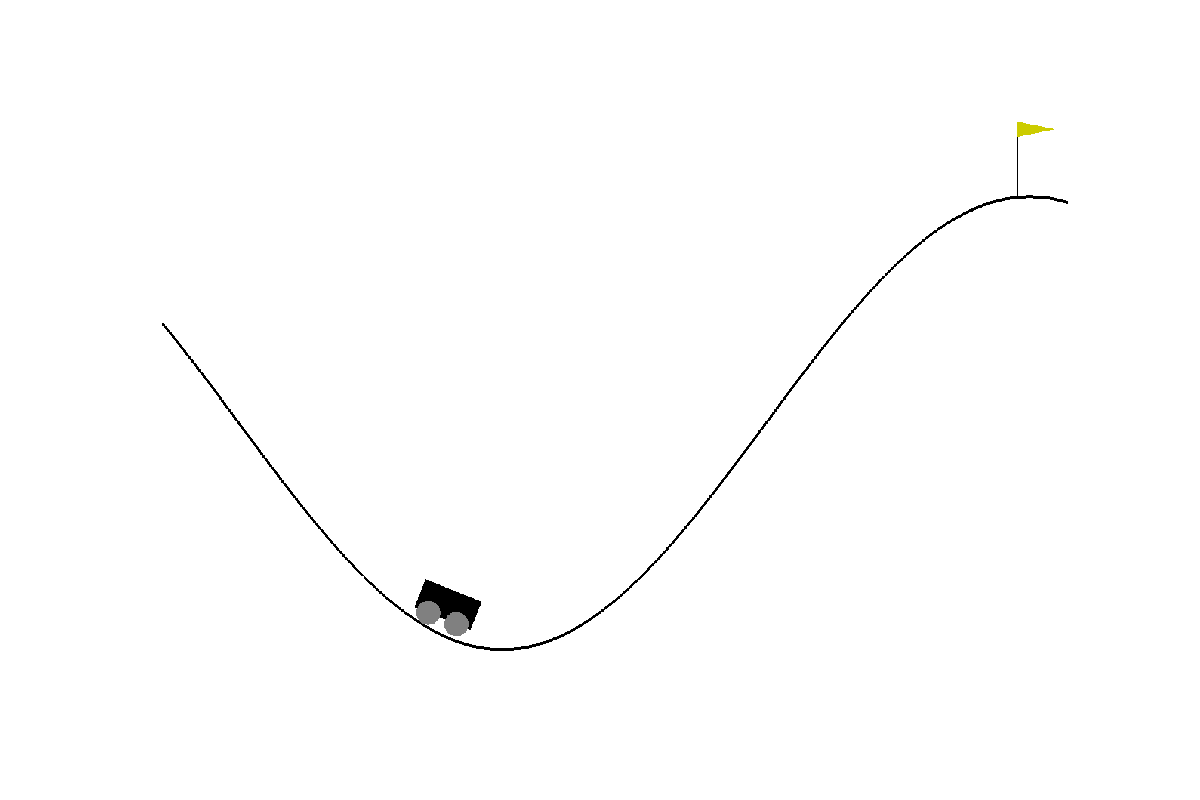
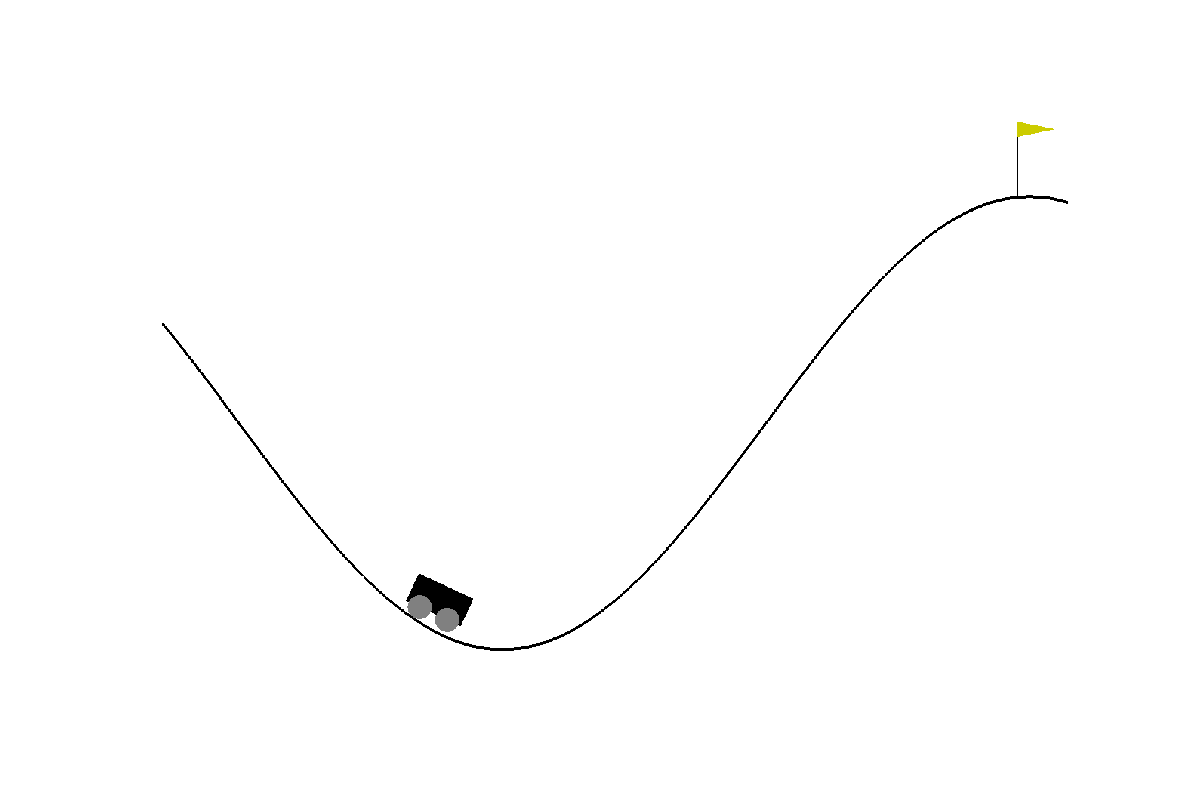
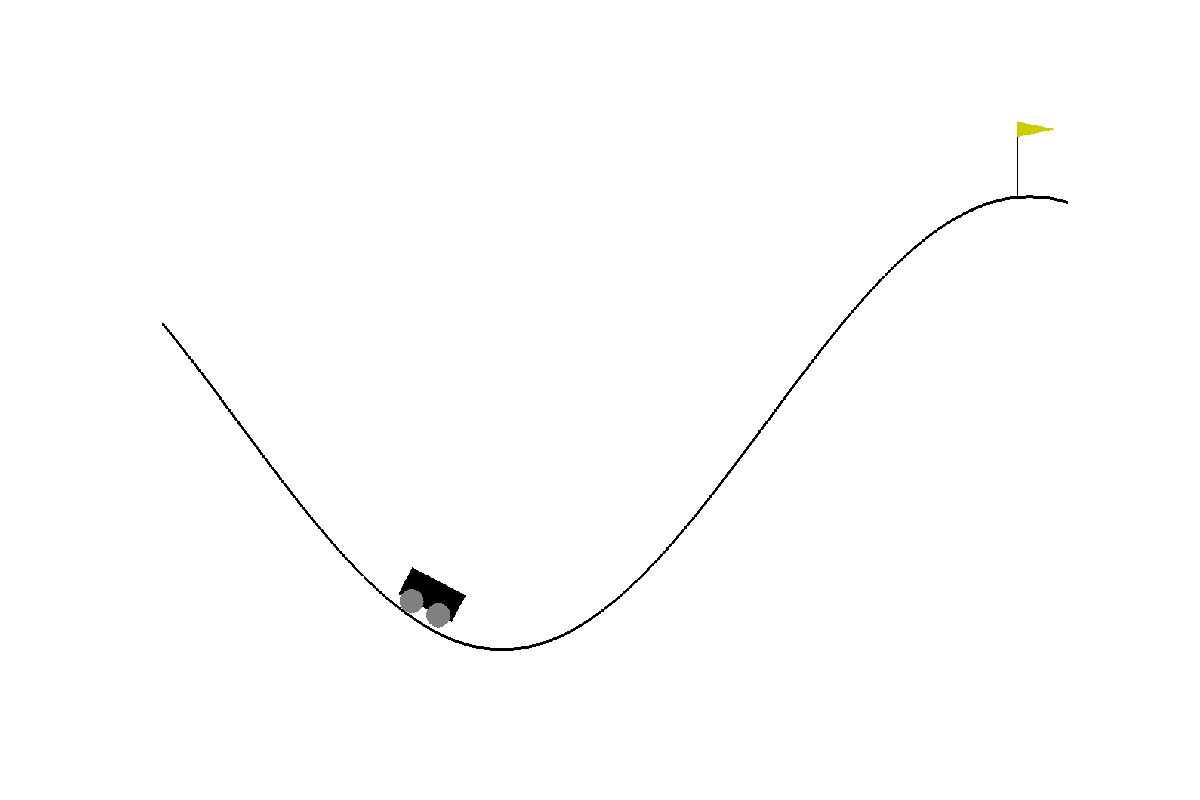
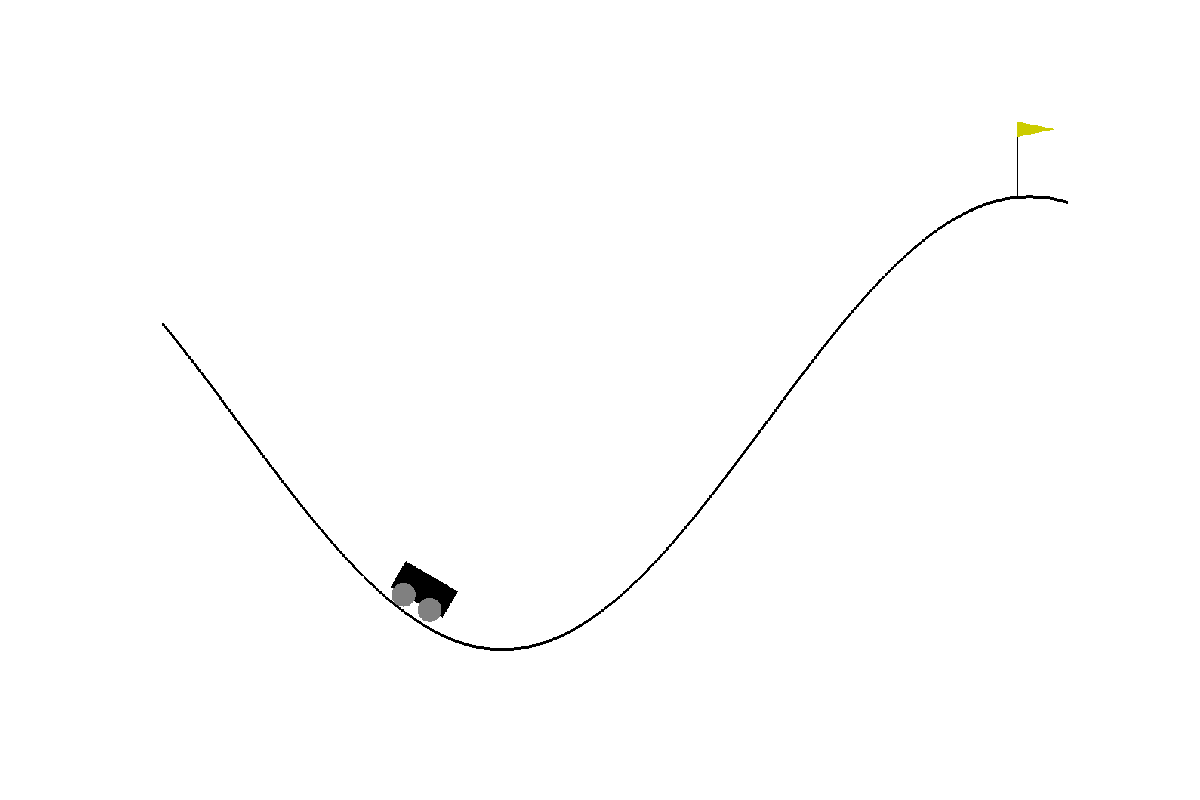
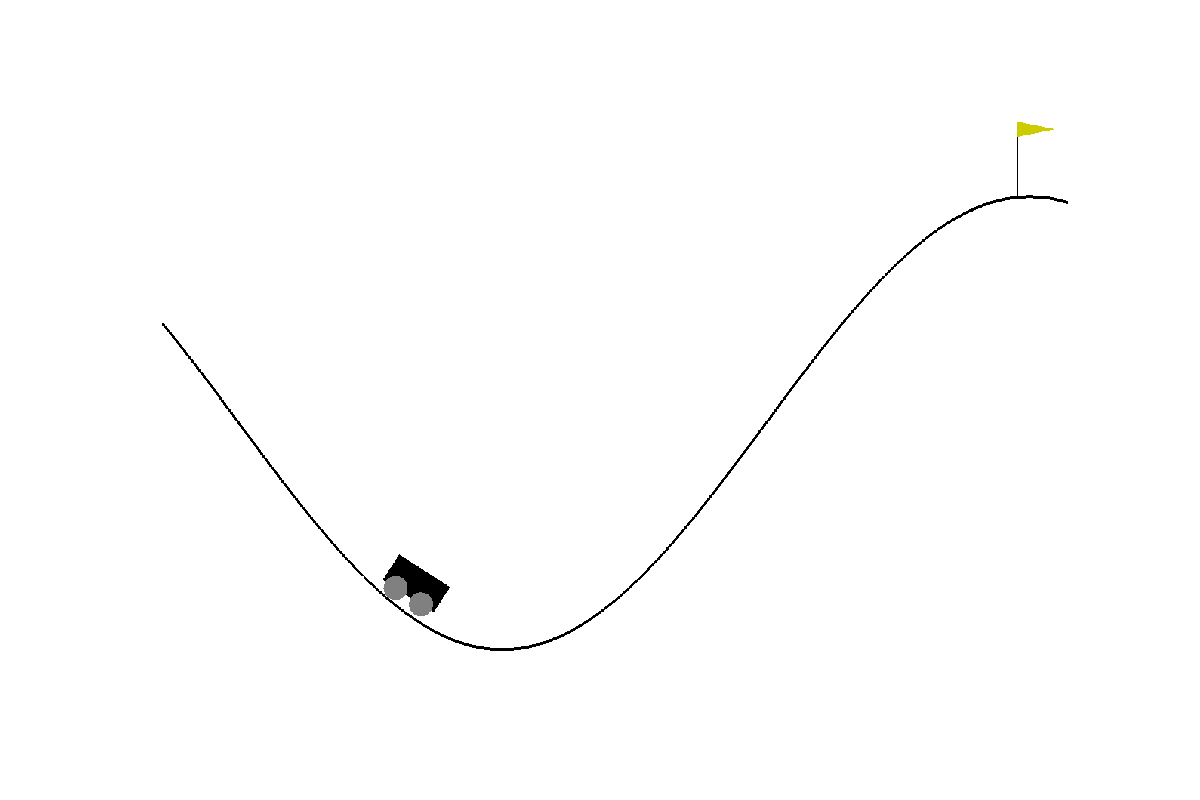
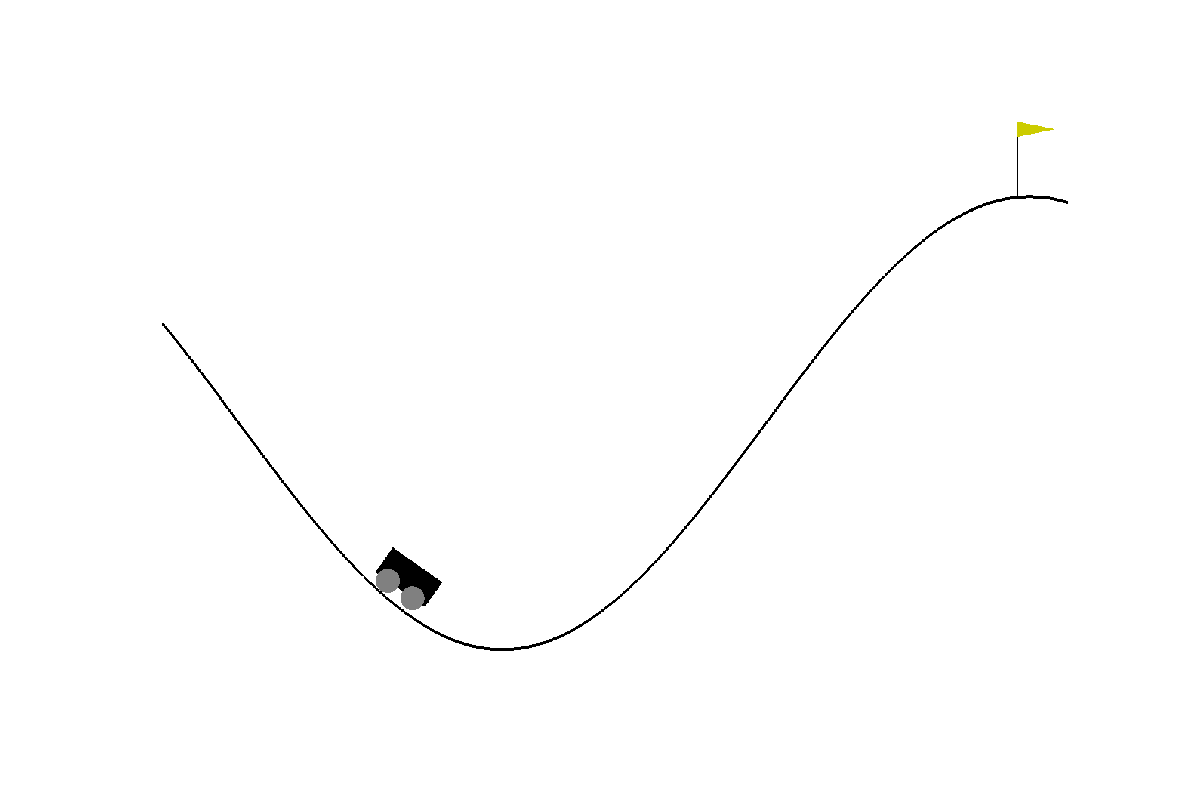
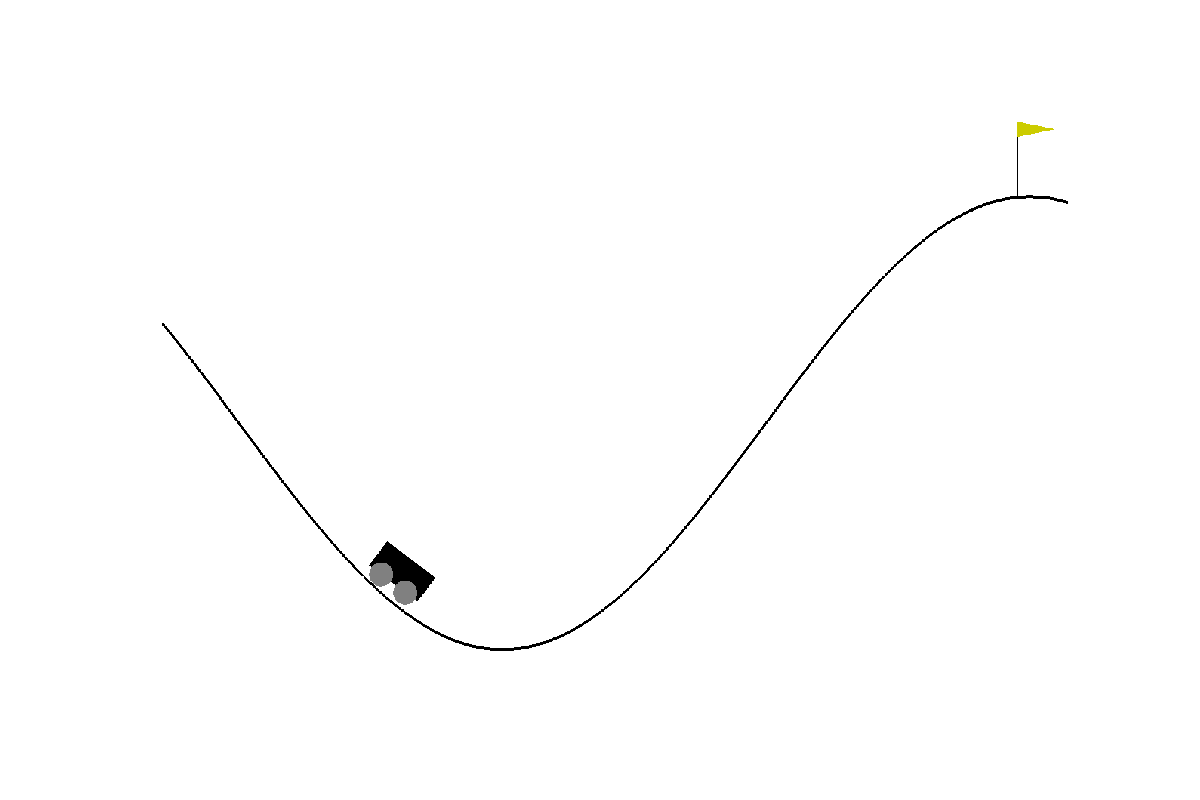
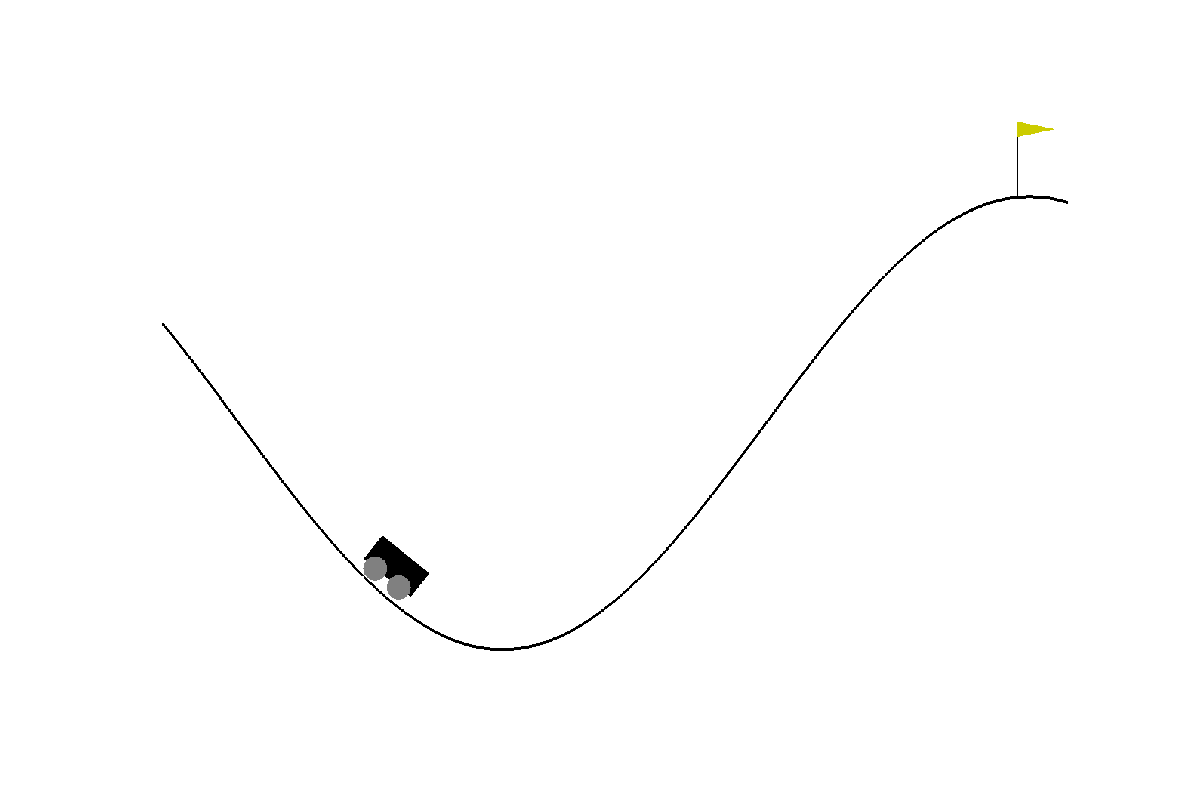
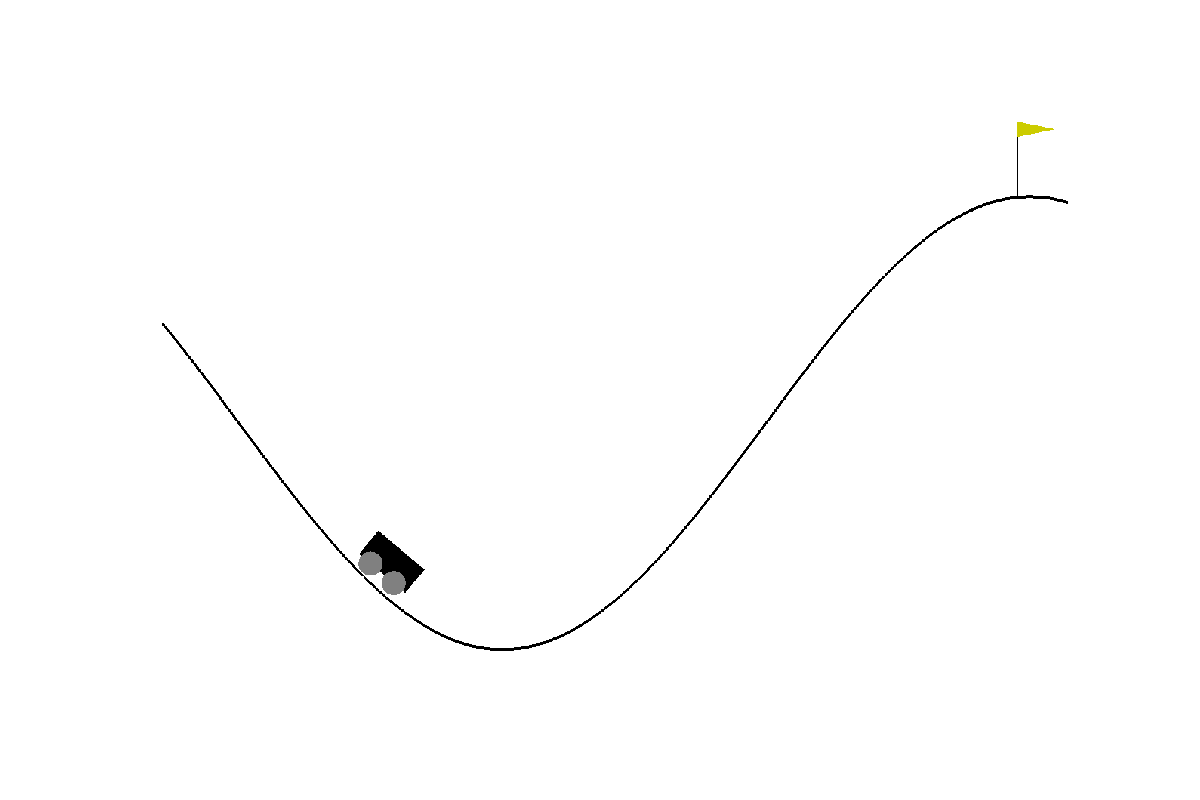
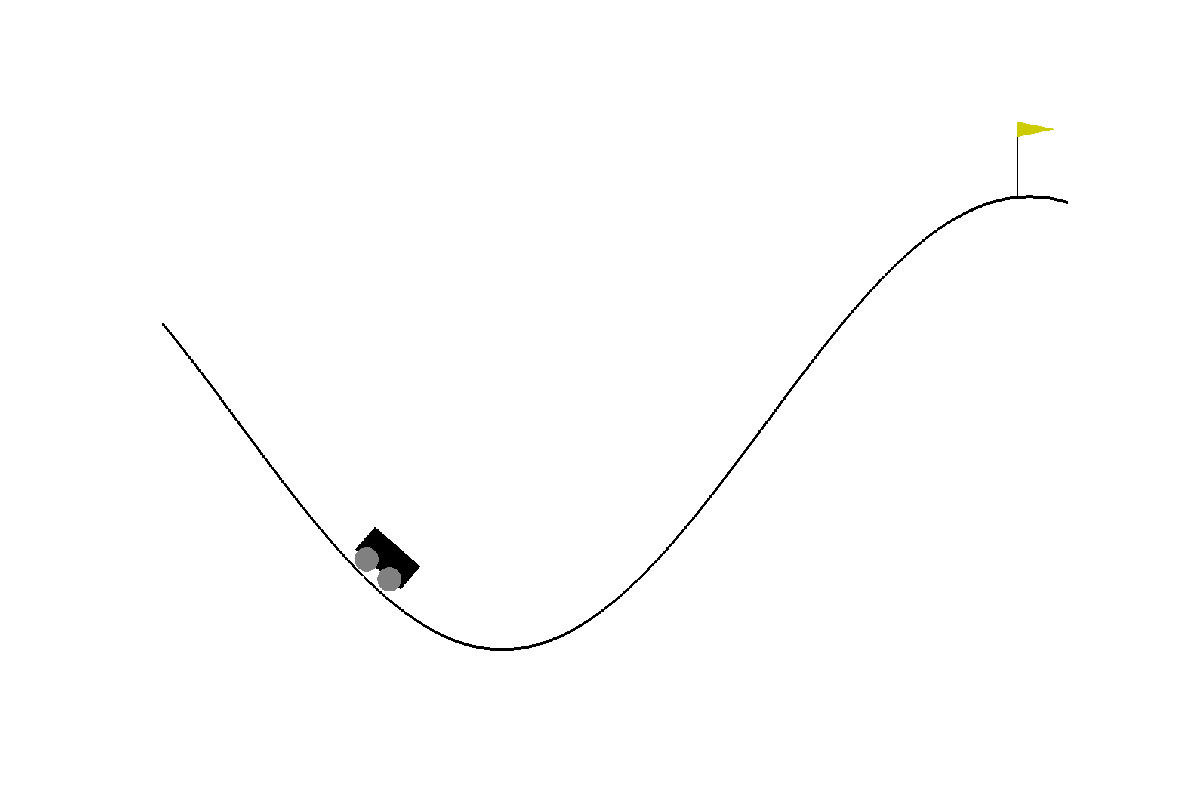
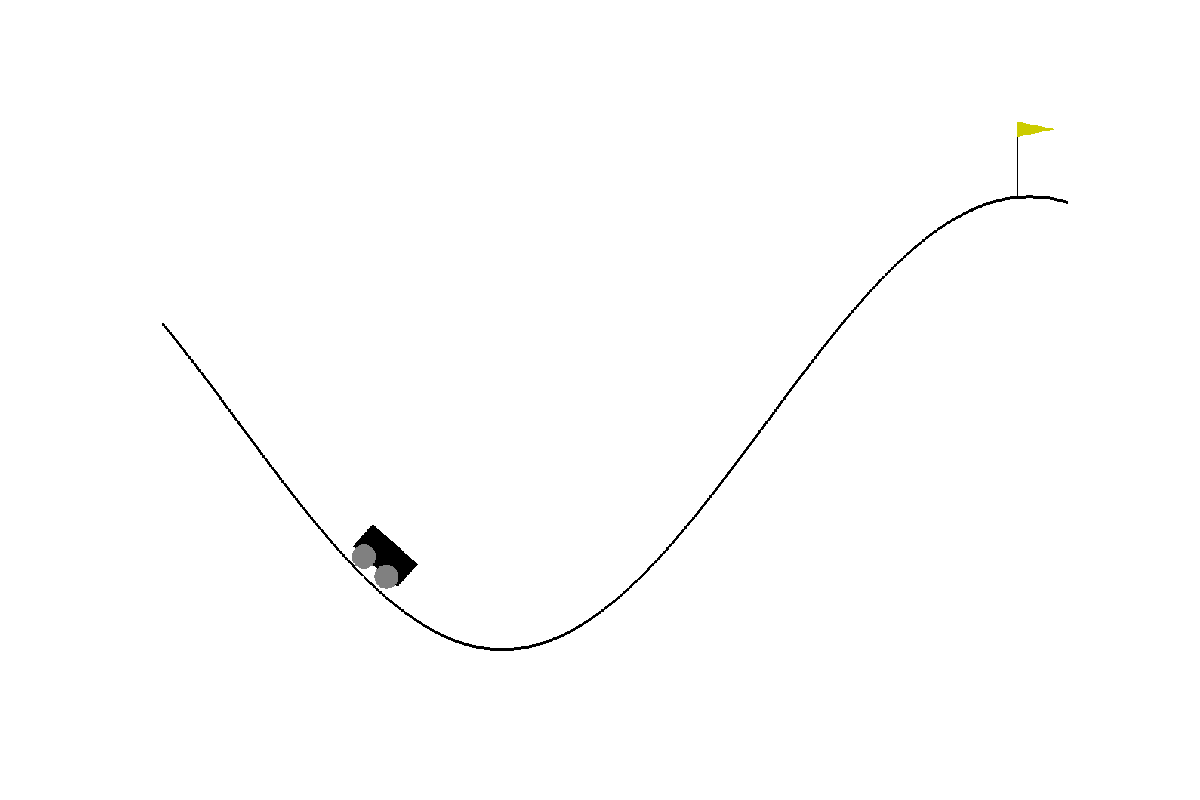
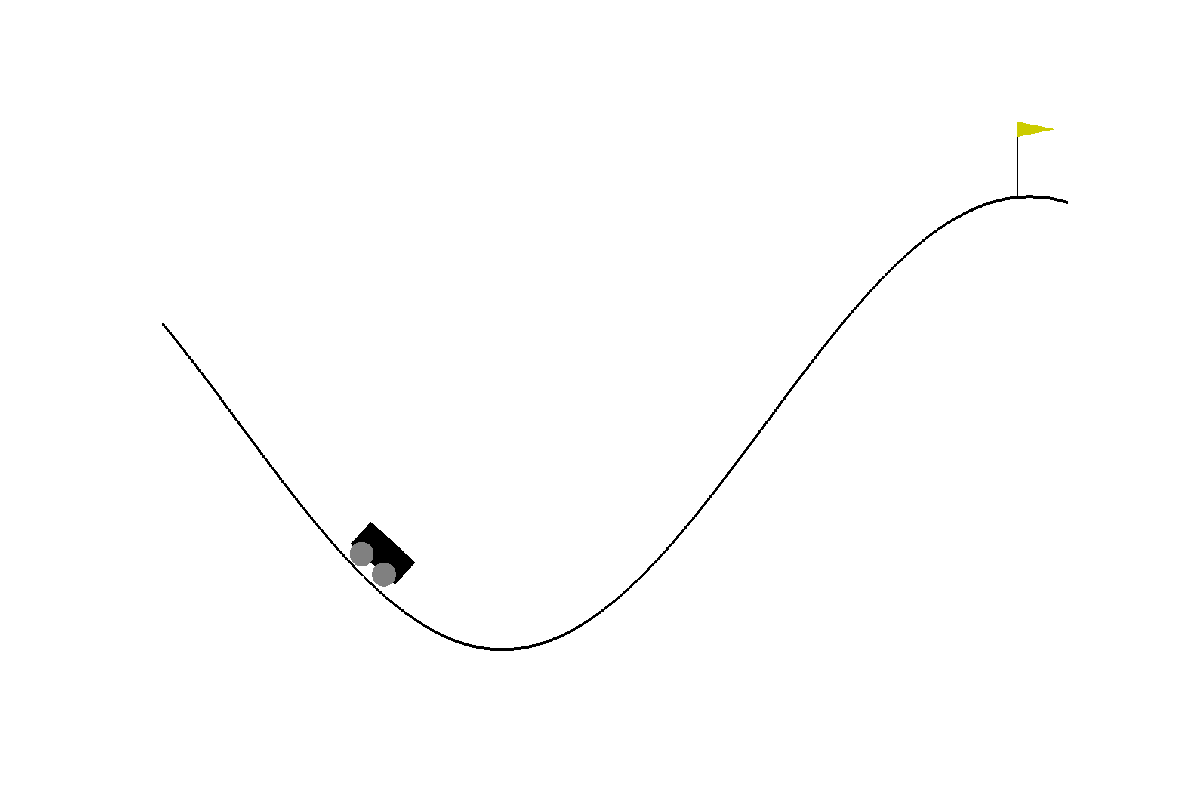
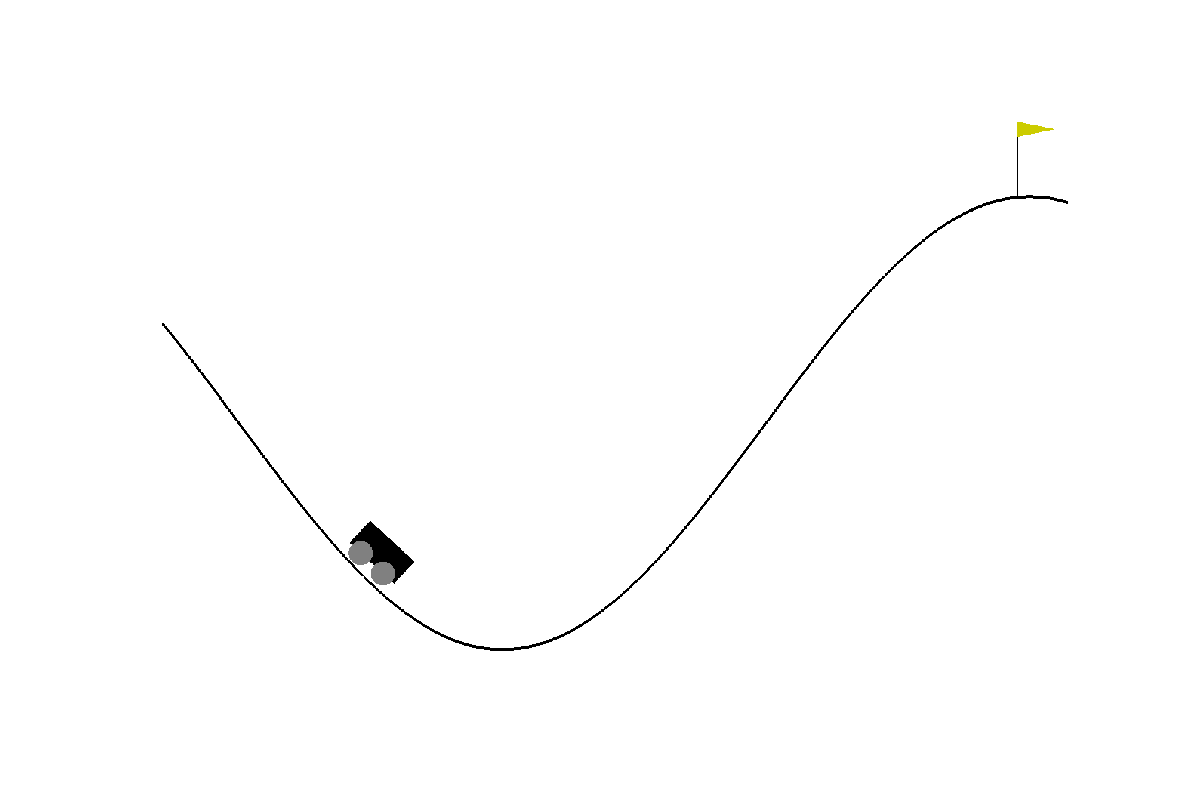
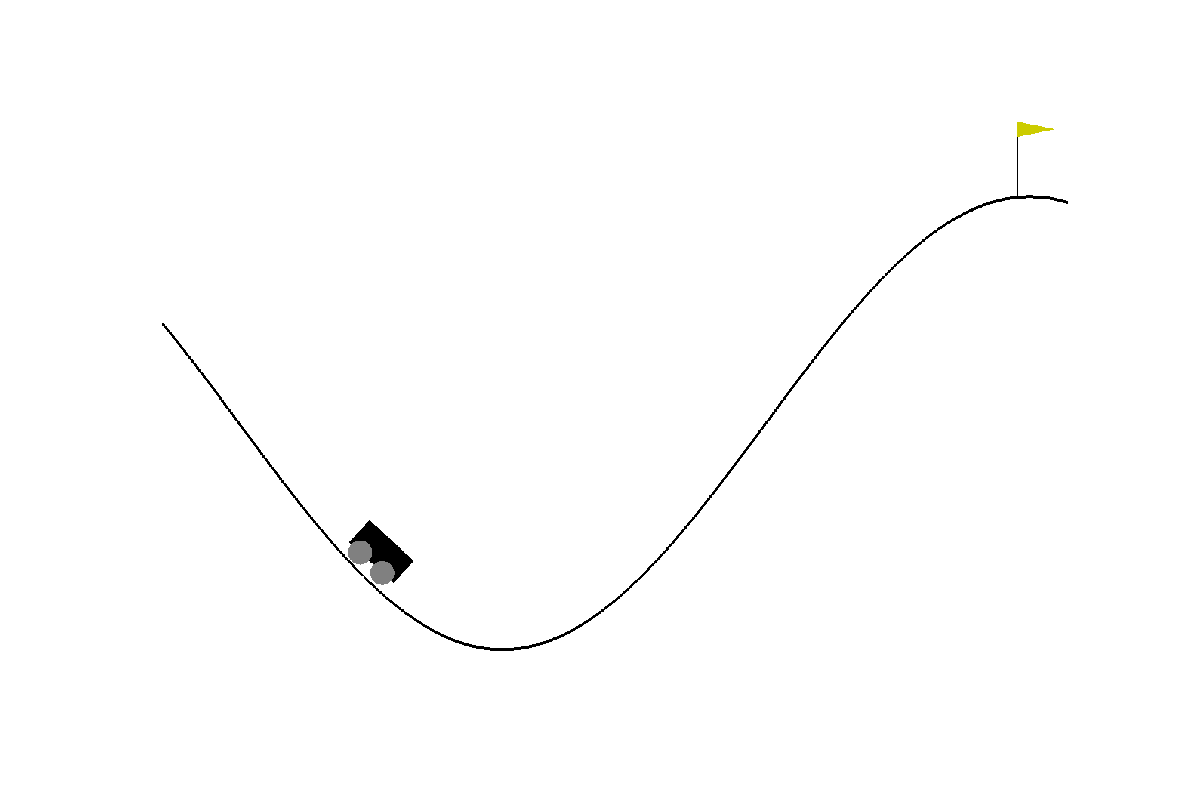
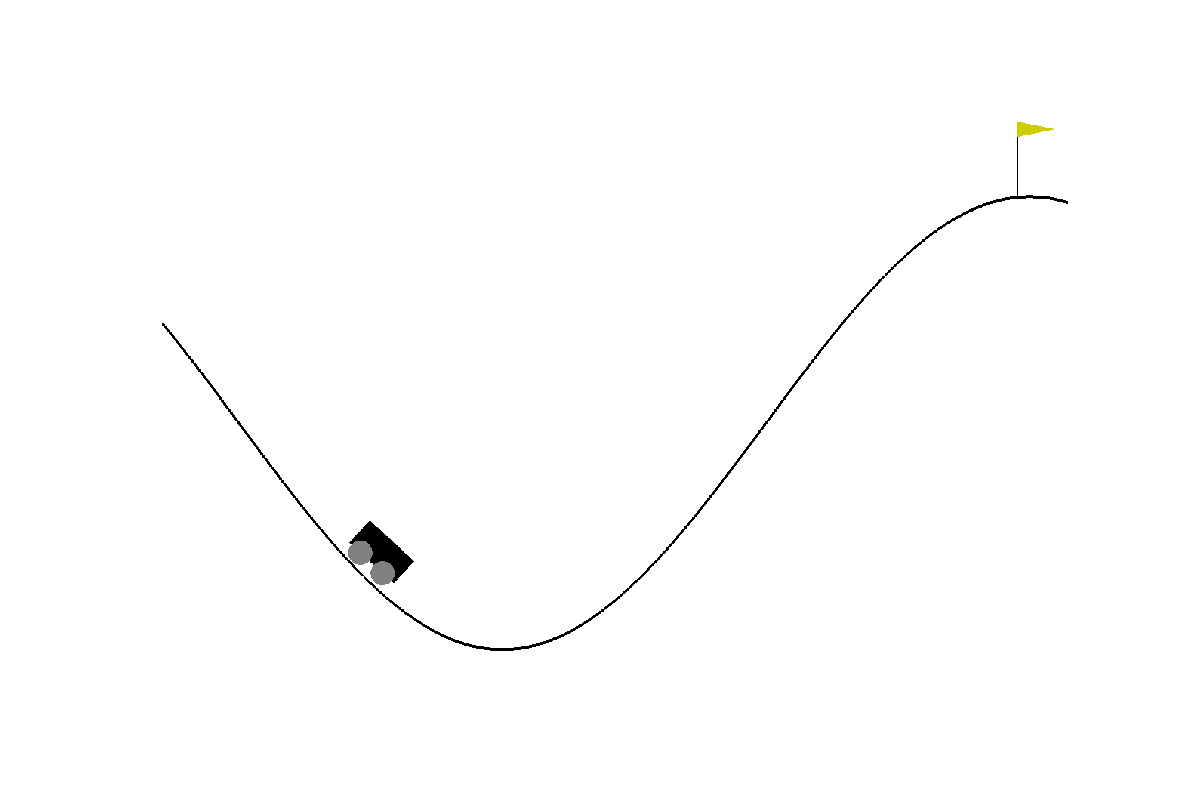
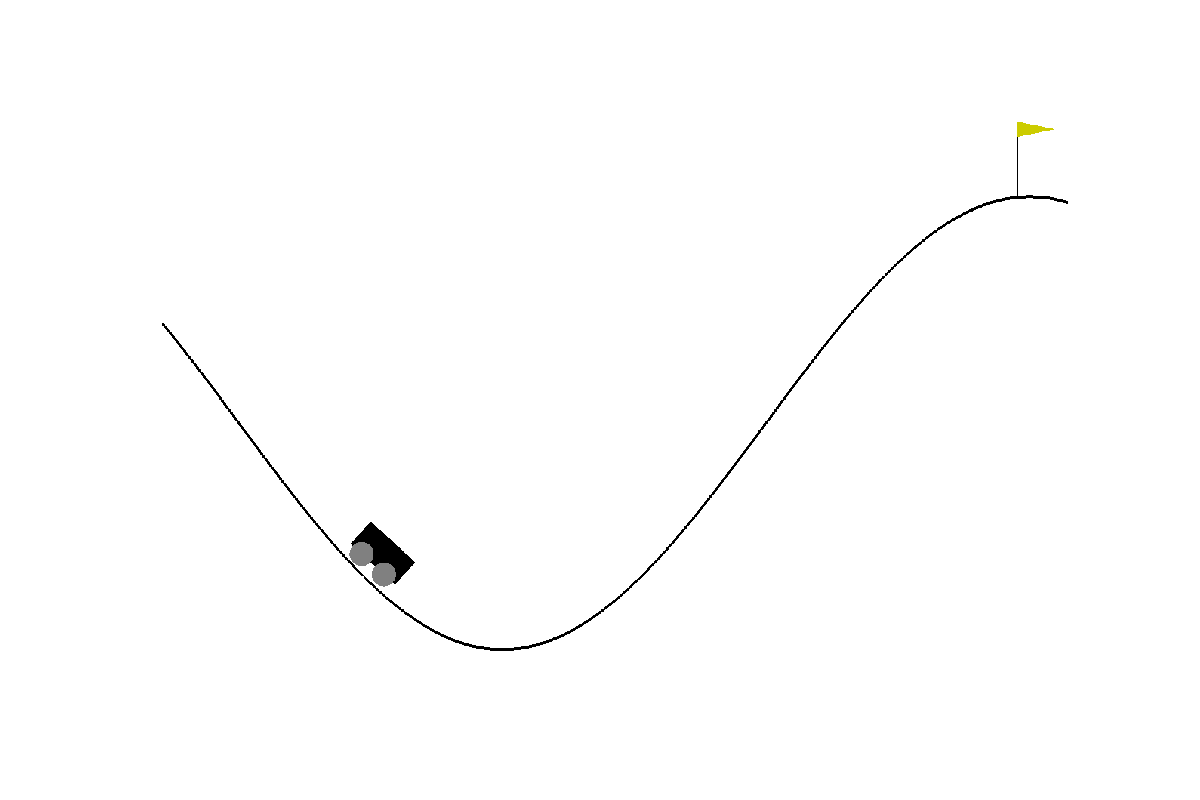
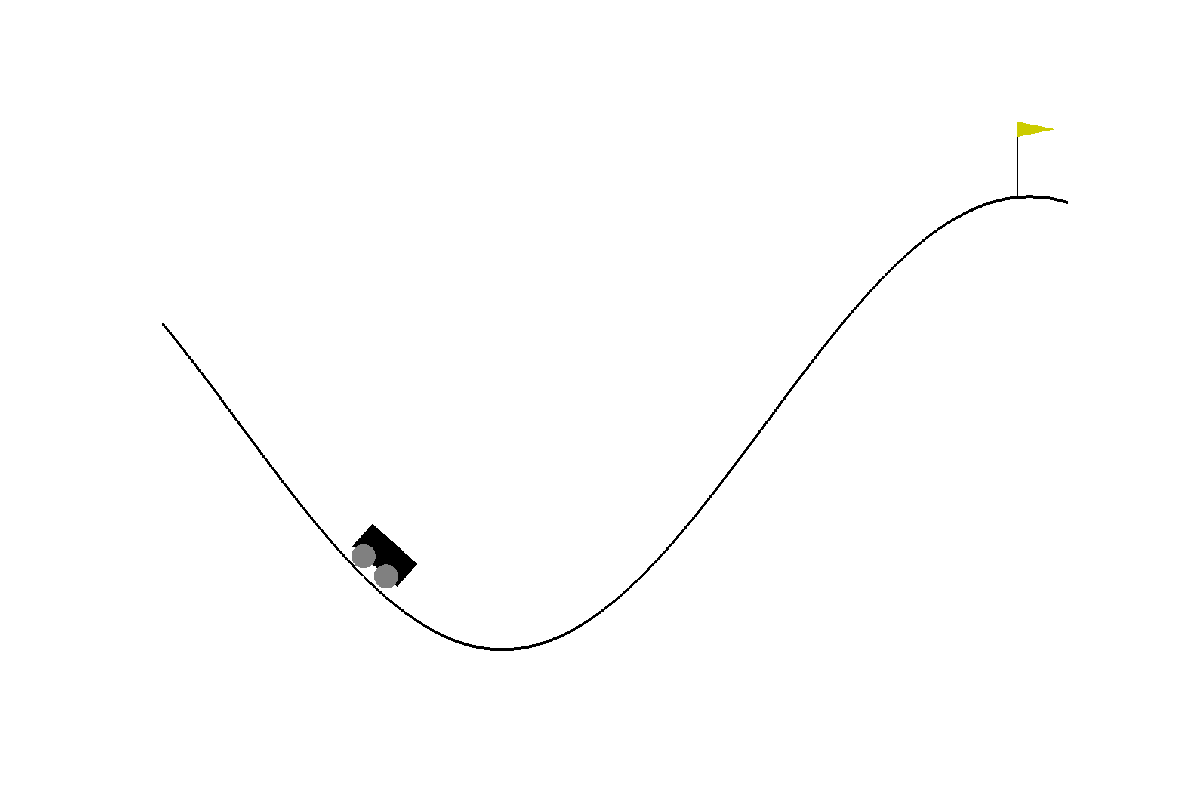
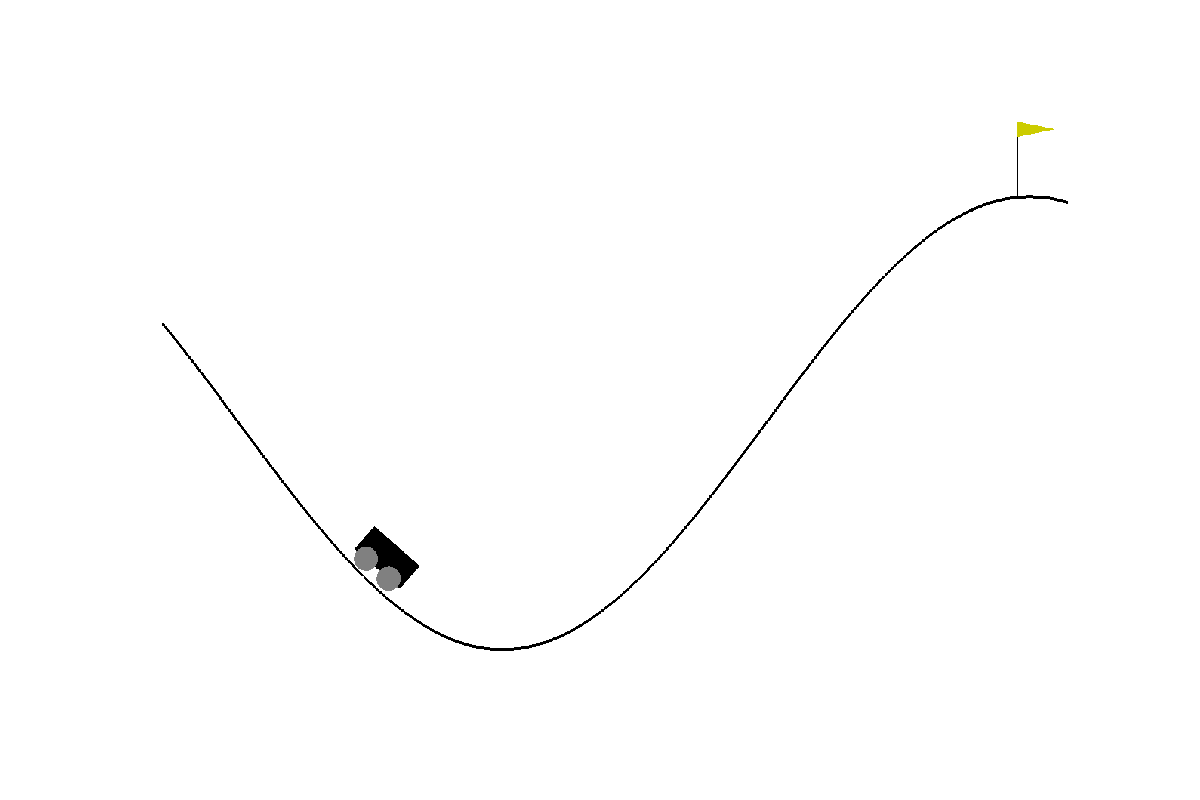
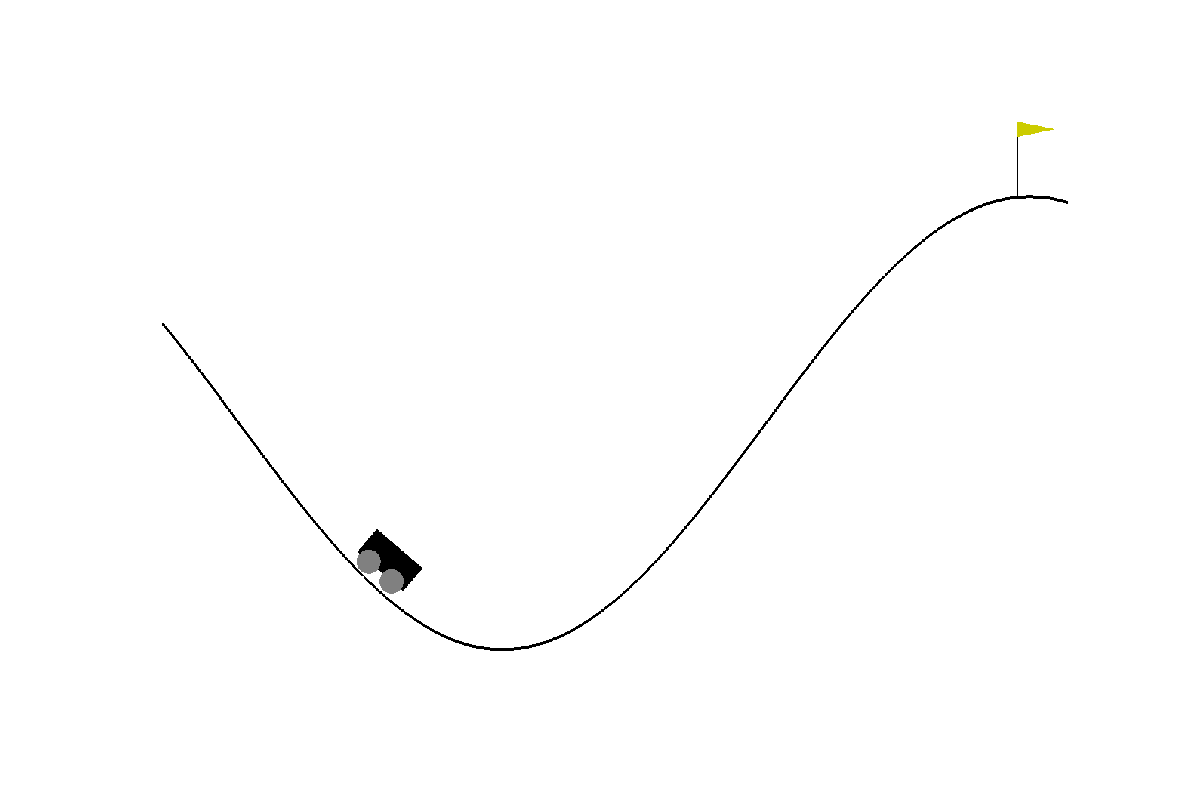
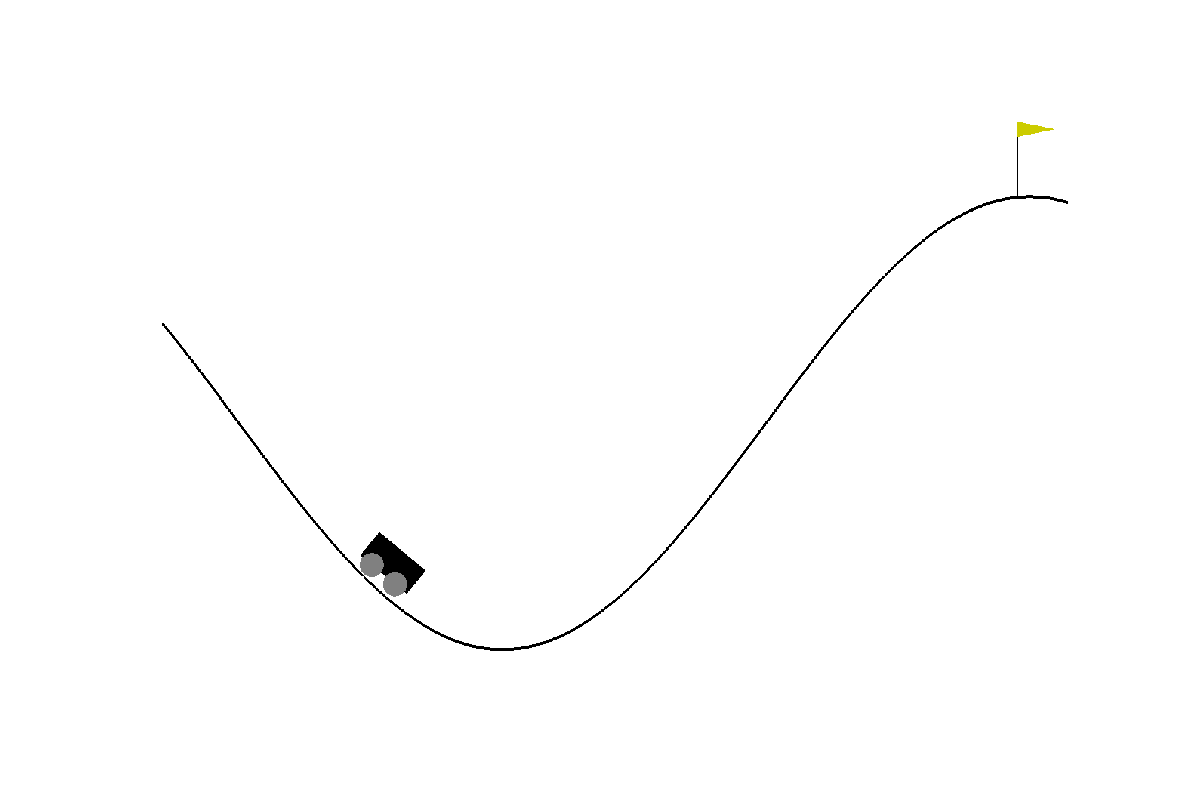
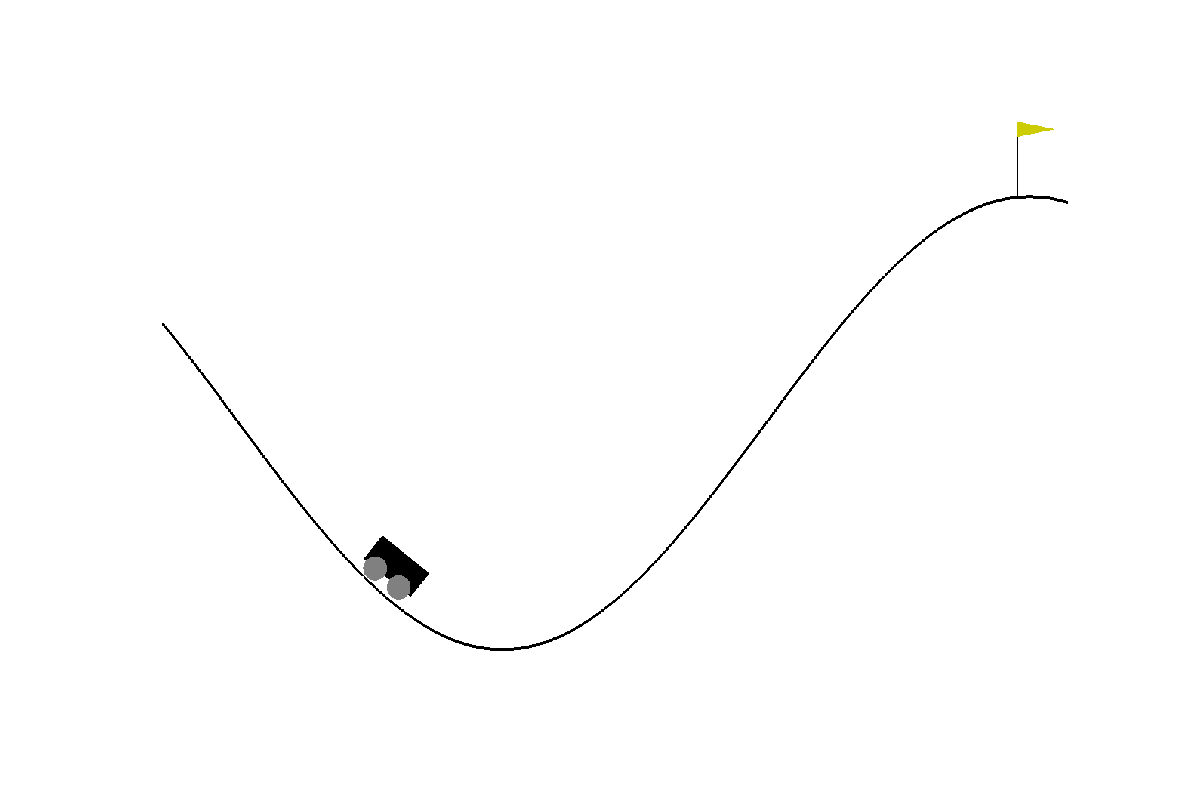
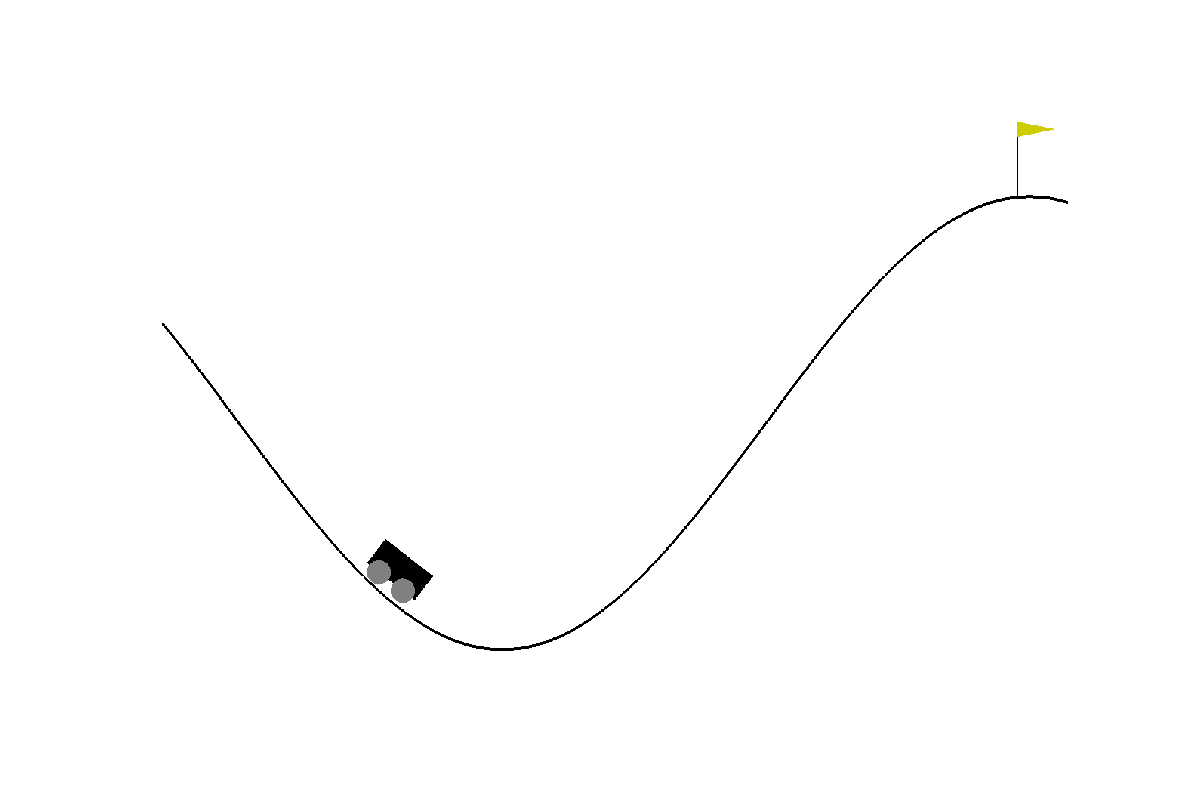
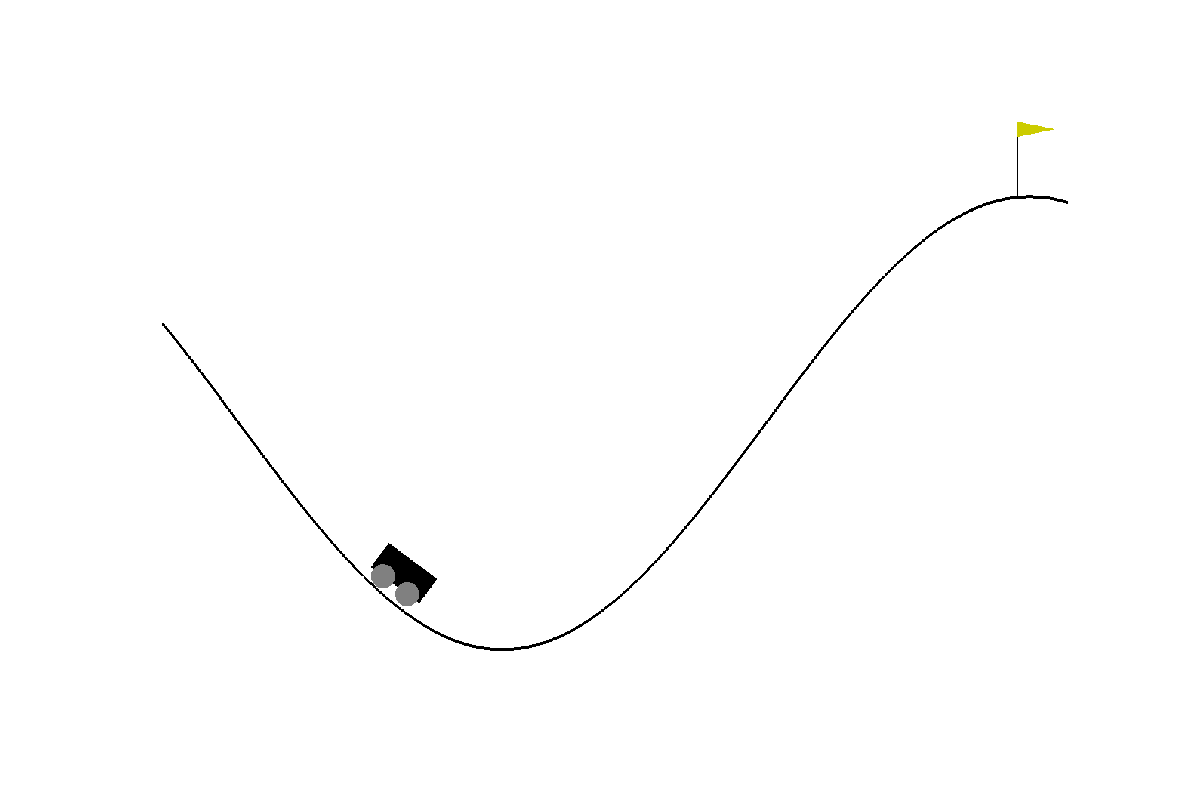
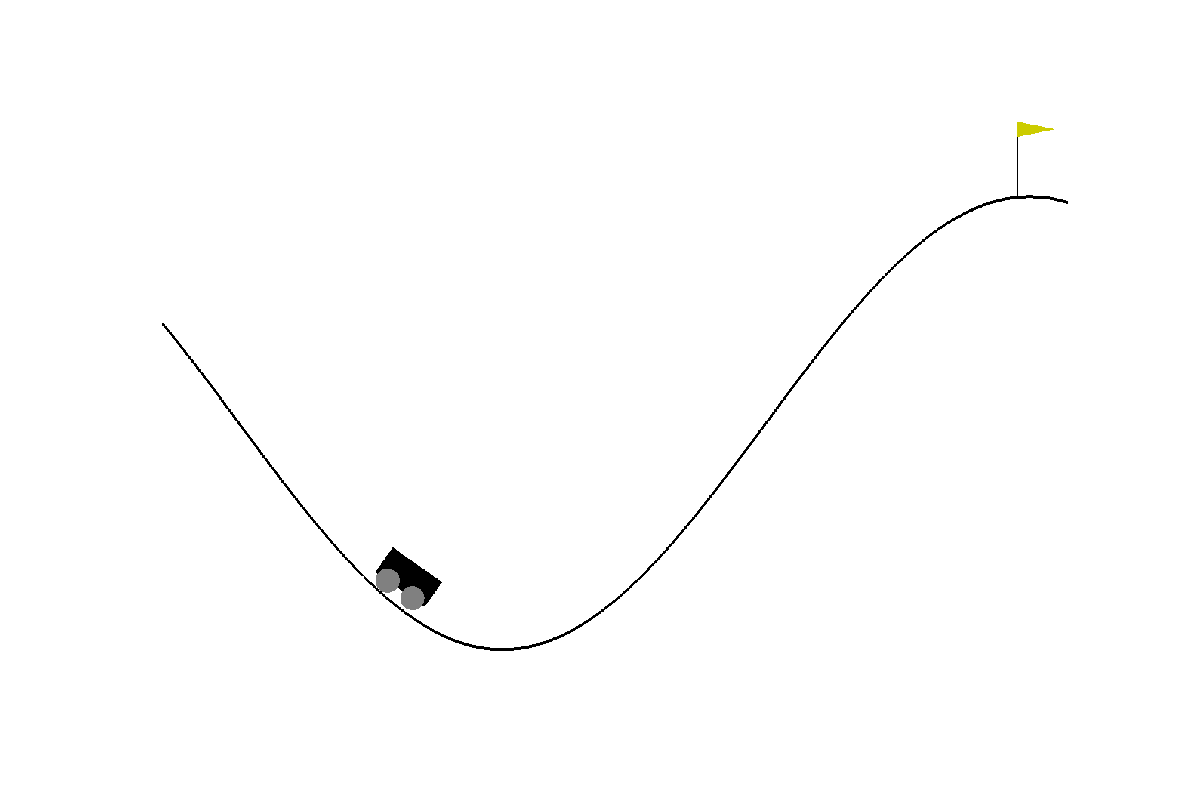
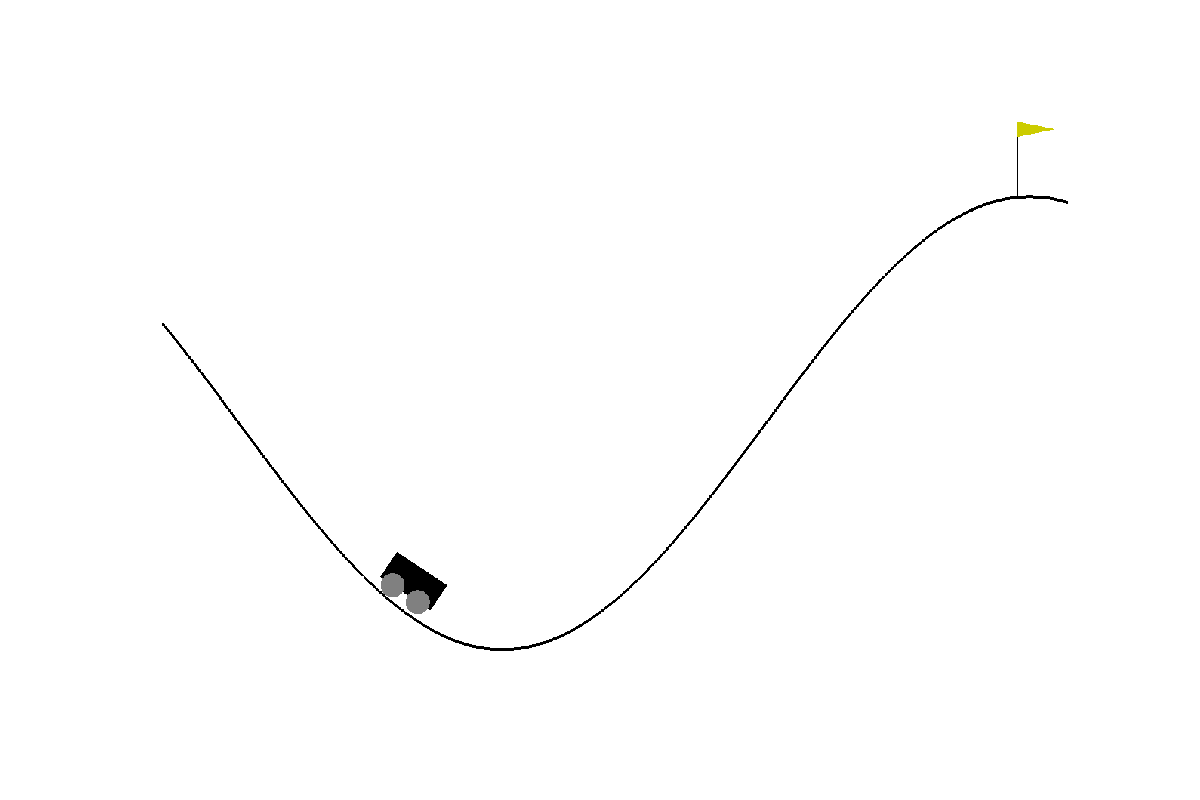
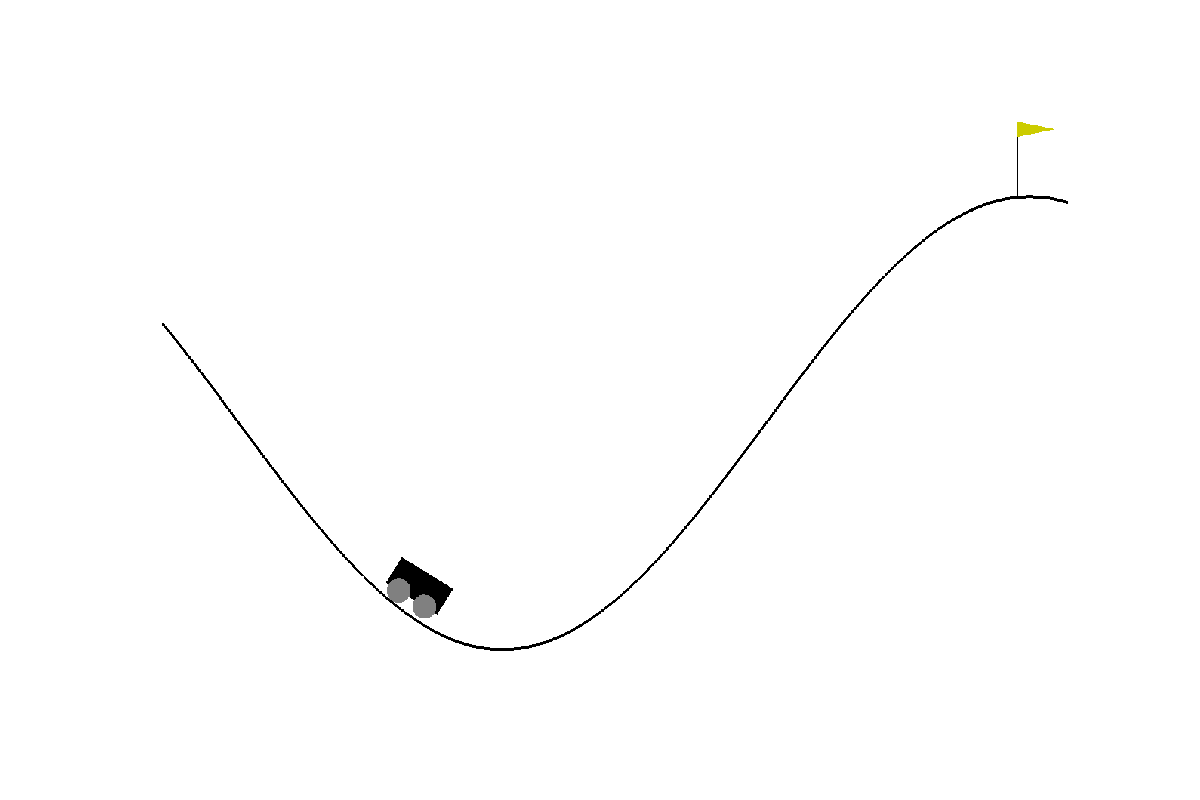
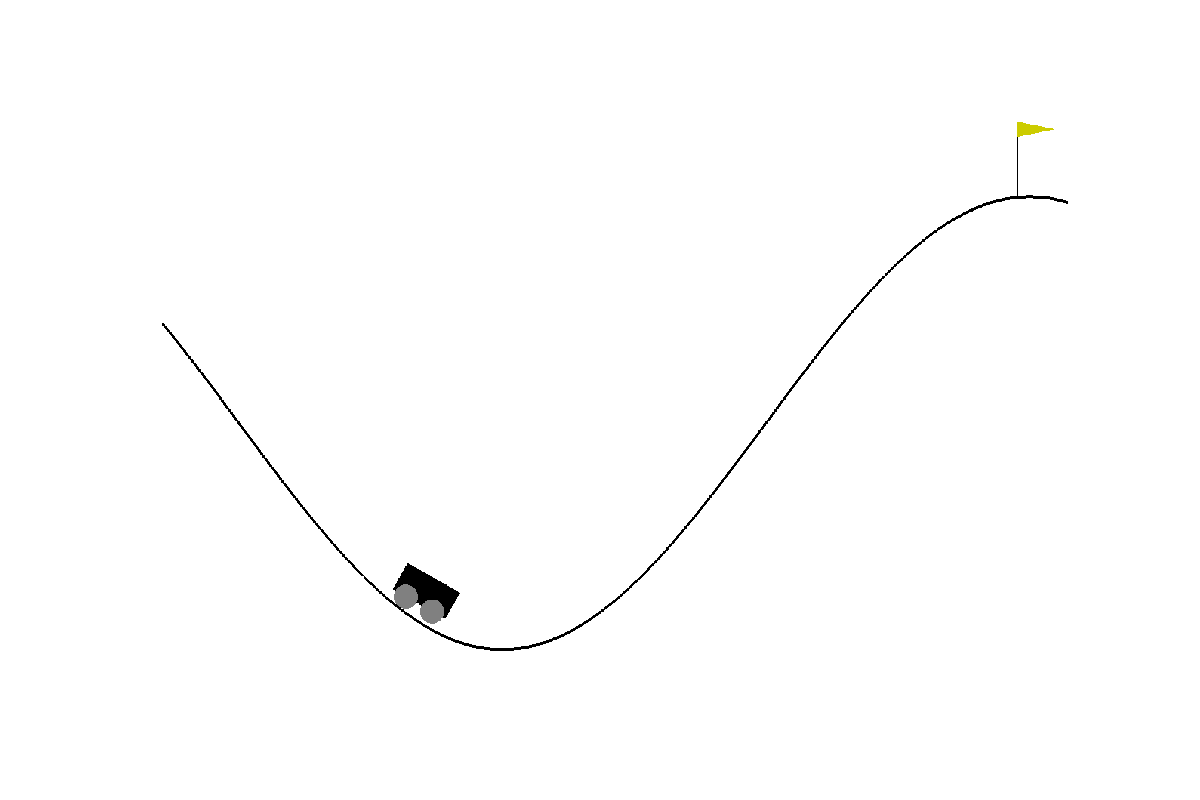
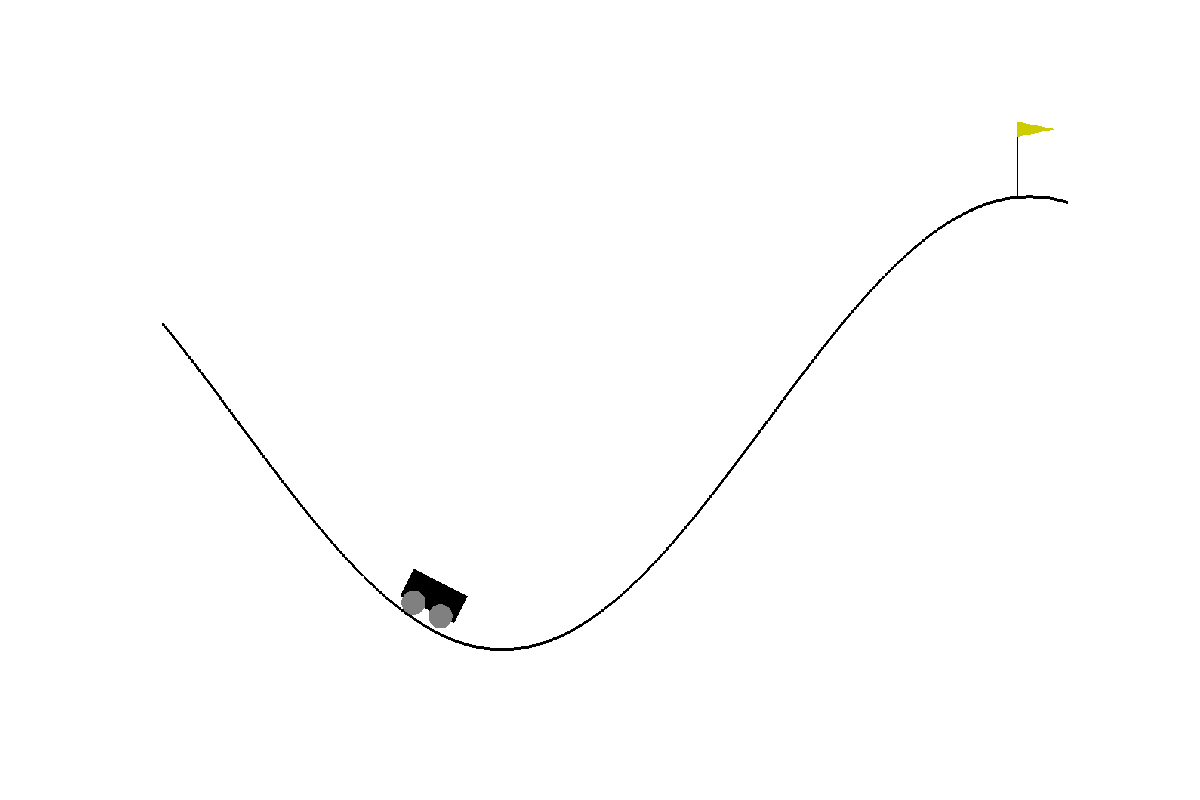
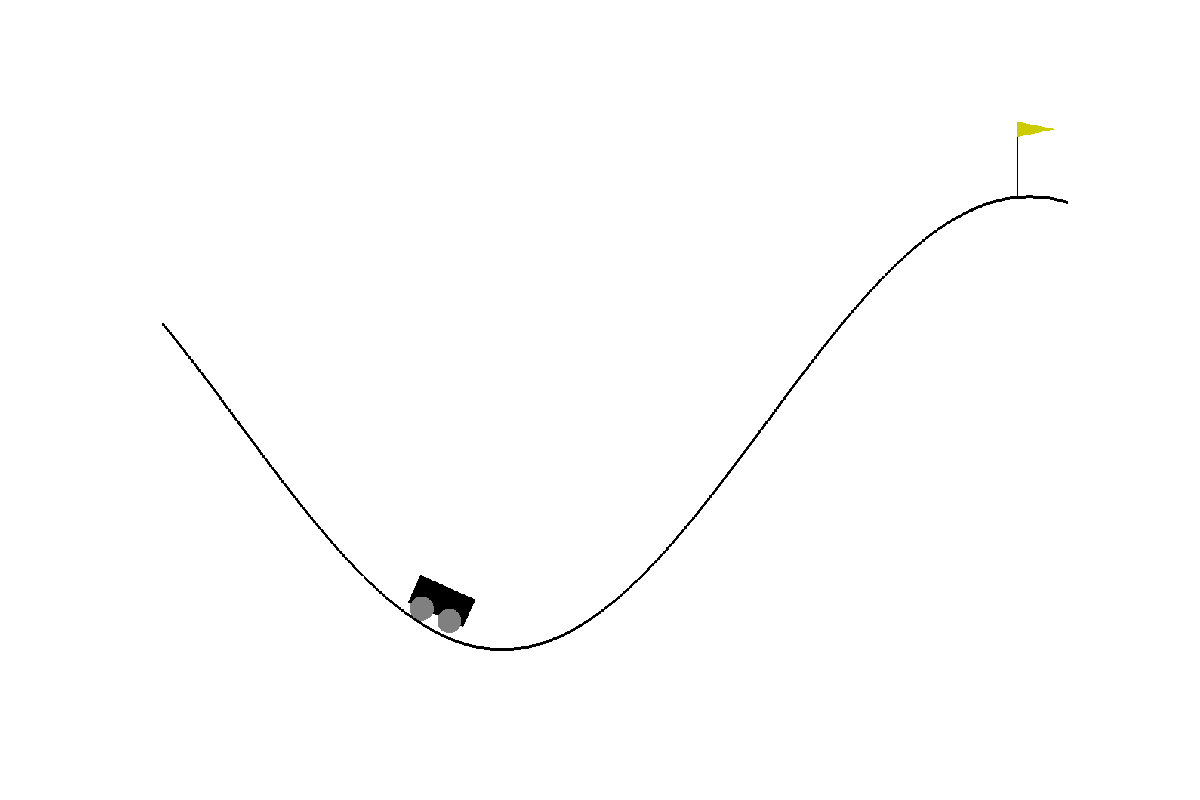
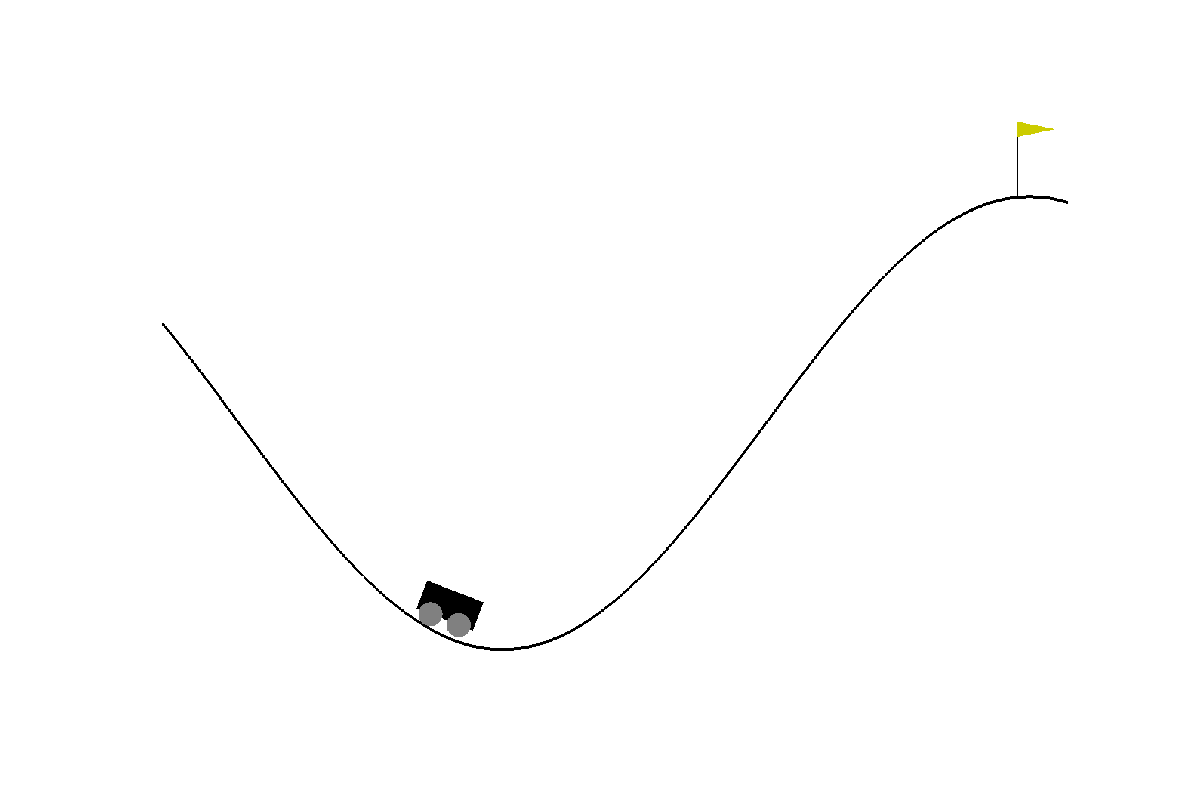
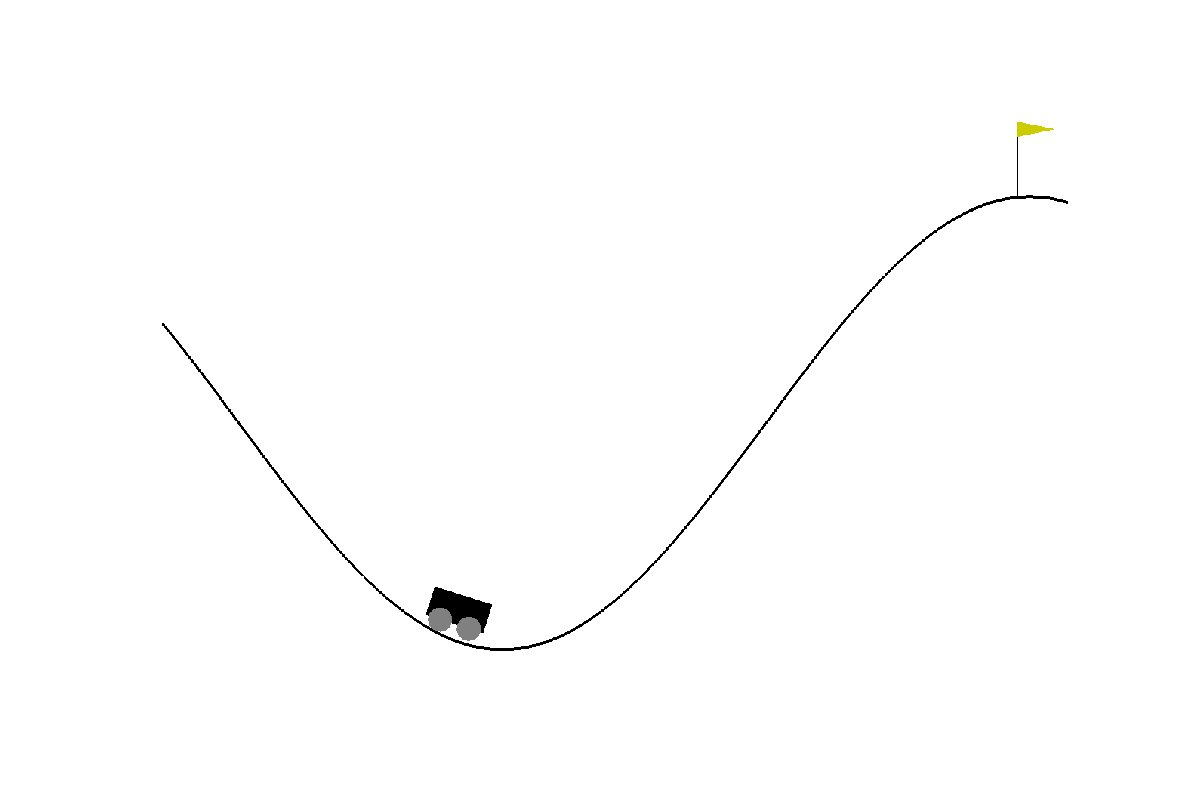
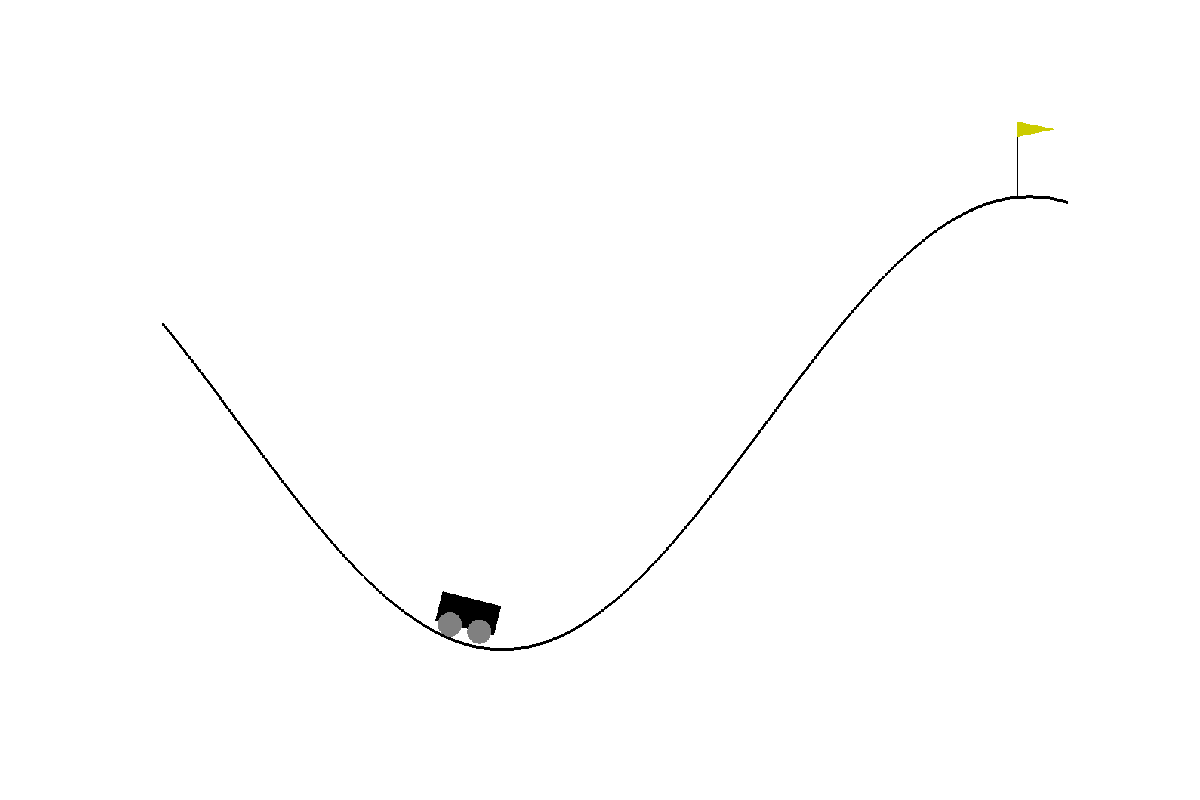
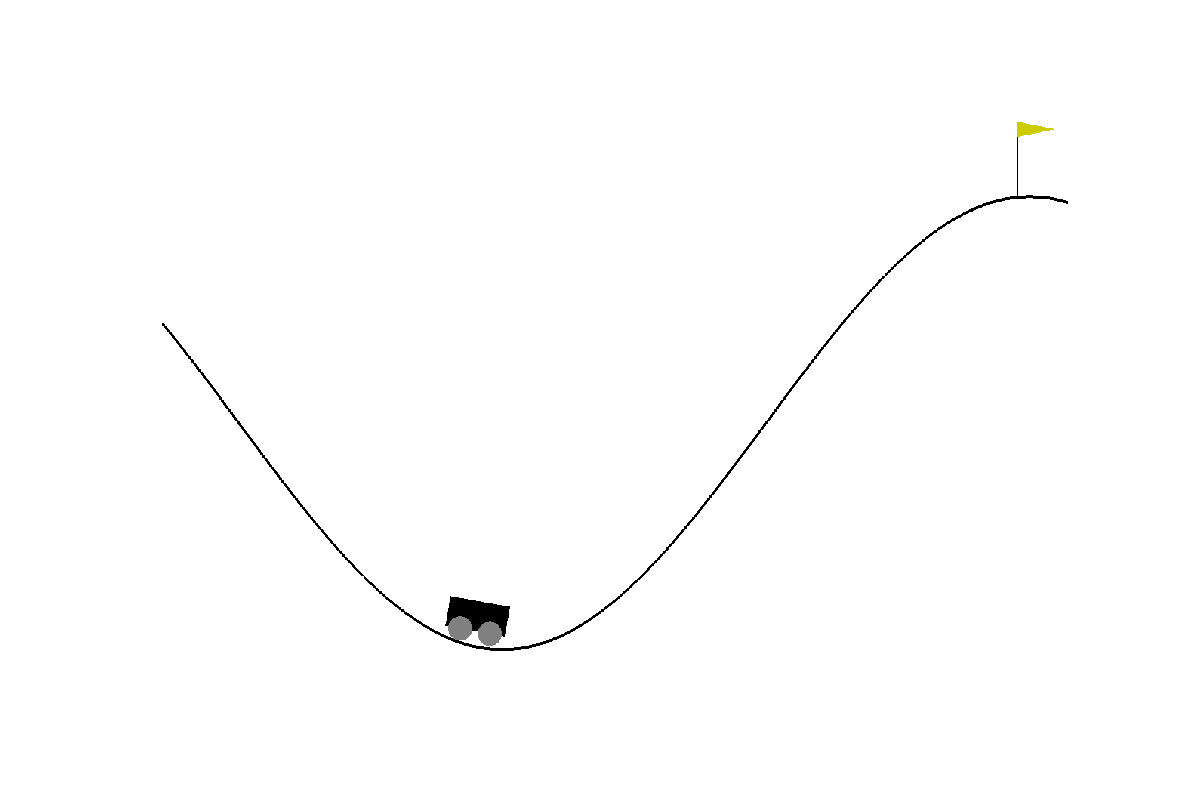

In [78]:
display_frames_as_gif(frames)

In [86]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('  - low:', env.action_space.low)
print('  - high:', env.action_space.high)

observation space: Box(2,)
action space: Box(1,)
  - low: [-1.]
  - high: [1.]


We will create a NN model and train via cross entropy first

In [180]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env.seed(101)
np.random.seed(101)

class Agent(nn.Module):
    def __init__(self, env, h_size=16):
        super(Agent, self).__init__()
        self.env = env
        
        # state, hidden layer, action sizes
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = env.action_space.shape[0]
        
        # define layers
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)
        
        self.w = np.random.randn(agent.get_weights_dim())
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x.cpu().data
        
    def set_weights(self, weights):
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        
        # separate the weights for each layer
        fc1_end = (s_size*h_size)+h_size
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
        
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
    
    def get_weights_dim(self):
        return (self.s_size+1)*self.h_size + (self.h_size+1)*self.a_size
        
    def evaluate(self, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        rewards = []
        state = self.env.reset()
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state) #.cpu().data.numpy())
            state, reward, done, _ = self.env.step(action)
            episode_return += reward * math.pow(gamma, t)
            rewards.append(reward)
            if done:
                break
        return episode_return, rewards
    
    

In [92]:
agent = Agent(env).to(device)

In [114]:
np.random.randn(agent.get_weights_dim())

array([-0.76991607,  0.53924919, -0.67433266,  0.03183056, -0.63584608,
        0.67643329,  0.57659082, -0.20829876,  0.39600671, -1.09306151,
       -1.49125759,  0.4393917 ,  0.1666735 ,  0.63503144,  2.38314477,
        0.94447949, -0.91282223,  1.11701629, -1.31590741, -0.4615846 ,
       -0.06824161,  1.71334272, -0.74475482, -0.82643854, -0.09845252,
       -0.66347829,  1.12663592, -1.07993151, -1.14746865, -0.43782004,
       -0.49803245,  1.92953205,  0.94942081,  0.08755124, -1.22543552,
        0.84436298, -1.00021535, -1.5447711 ,  1.18802979,  0.31694261,
        0.92085882,  0.31872765,  0.85683061, -0.65102559, -1.03424284,
        0.68159452, -0.80340966, -0.68954978, -0.4555325 ,  0.01747916,
       -0.35399391, -1.37495129, -0.6436184 , -2.22340315,  0.62523145,
       -1.60205766, -1.10438334,  0.05216508, -0.739563  ,  1.5430146 ,
       -1.29285691,  0.26705087, -0.03928282, -1.1680935 ,  0.52327666])

In [93]:
def cem(n_iterations=500, max_t=1000, gamma=1.0, print_every=10, pop_size=50, elite_frac=0.2, sigma=0.5):
    """PyTorch implementation of a cross-entropy method.
        
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    n_elite=int(pop_size*elite_frac)

    scores_deque = deque(maxlen=100)
    scores = []
    best_weight = sigma*np.random.randn(agent.get_weights_dim())

    for i_iteration in range(1, n_iterations+1):
        
        # generate 50 weight variations around the current best weight, which is intialized at random. 
        weights_pop = [best_weight + (sigma*np.random.randn(agent.get_weights_dim())) for i in range(pop_size)]
        
        # evaluate how well the agent performs with the weights 
        rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])

        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        
        # take average of best weights 
        best_weight = np.array(elite_weights).mean(axis=0)

        reward = agent.evaluate(best_weight, gamma=1.0)
        scores_deque.append(reward)
        scores.append(reward)
        
        torch.save(agent.state_dict(), 'checkpoint.pth')
        
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=90.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    return scores


In [94]:
scores = cem()

/Users/chrisbarton/anaconda2/envs/drlnd/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 10	Average Score: -1.44
Episode 20	Average Score: -3.98
Episode 30	Average Score: -4.18
Episode 40	Average Score: 2.57
Episode 50	Average Score: 18.74
Episode 60	Average Score: 29.35
Episode 70	Average Score: 38.69
Episode 80	Average Score: 45.65
Episode 90	Average Score: 47.98
Episode 100	Average Score: 52.56
Episode 110	Average Score: 62.09
Episode 120	Average Score: 72.28
Episode 130	Average Score: 82.21
Episode 140	Average Score: 89.48

Environment solved in 47 iterations!	Average Score: 90.83


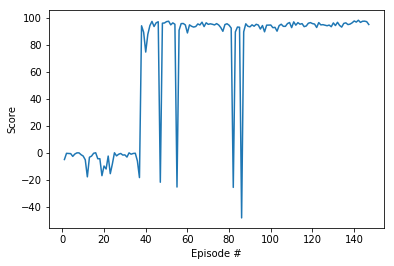

In [95]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [96]:
with open('cem_scores.csv', 'w') as f:
    for item in scores:
        f.write("%s\n" % item)

In [191]:
env.seed(0)
np.random.seed(0)

In [192]:
def hill_climbing(n_episodes=1000, max_t=1000, gamma=1.0, print_every=10, good_noise_scale=1e-1,  bad_noise_scale=1):
    """Implementation of hill climbing with adaptive noise scaling.
        
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        noise_scale (float): standard deviation of additive noise
    """
    
    scores_deque = deque(maxlen=100)
    scores = []
    best_R = -np.Inf
    best_w = agent.w # initiated at random
    
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        er, rewards = agent.evaluate(best_w)

        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])

        if R >= best_R: # found better weights
            # shrinks search area around current weights, but still injects noise. Just not as much.
            best_R = R
            best_w = agent.w
            noise_scale = max(1e-3, good_noise_scale / 2)
            agent.w += noise_scale * np.random.rand(*agent.w.shape) 
            
        else: # did not find better weights
            # adds more more noise around last best state
            noise_scale = min(2, bad_noise_scale * 2)
            agent.w = best_w + noise_scale * np.random.rand(*agent.w.shape)

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            policy.w = best_w
            break
        
    return scores
            


In [200]:
agent = Agent(env).to(device)

In [201]:
scores = hill_climbing(n_episodes=1000, max_t=1000, gamma=1.0, print_every=50, good_noise_scale=1e-1,  bad_noise_scale=1)

Episode 50	Average Score: -38.93
Episode 100	Average Score: -20.44
Episode 150	Average Score: -1.94
Episode 200	Average Score: -1.94
Episode 250	Average Score: -1.94
Episode 300	Average Score: -1.95
Episode 350	Average Score: -1.95
Episode 400	Average Score: -1.95
Episode 450	Average Score: -1.94
Episode 500	Average Score: -1.94
Episode 550	Average Score: -1.94
Episode 600	Average Score: -1.94
Episode 650	Average Score: -1.94
Episode 700	Average Score: -1.94
Episode 750	Average Score: -1.94
Episode 800	Average Score: -1.94
Episode 850	Average Score: -1.94
Episode 900	Average Score: -1.93
Episode 950	Average Score: -1.93
Episode 1000	Average Score: -1.94


In [ ]:
# load the weights from file
agent.load_state_dict(torch.load('checkpoint.pth'))

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
while True:
    state = torch.from_numpy(state).float().to(device)
    with torch.no_grad():
        action = agent(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()